# Housing Prices Prediction

## Summary
Just wanted to perform a quick analysis using Tensorflow and Keras to make a prediction on the House Prices dataset.  Many have done and contributed their exploratory data analyses in Kaggle.  Based on these analyses, the focus here is to perform some quick data transformation and feature engineering, follow by model training and prediction.  Finally, generating the submission csv for assessment in Kaggle.

I aim for this notebook to be short and not dwell in too much details on why certain parameters or models are selected.  Purpose is to build a deep learning neural network model that perform well in making predictions on unseen data with optimal hyperparameters.

---
## References
1. https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python
2. https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard
3. https://www.kaggle.com/lavanyashukla01/how-i-made-top-0-3-on-a-kaggle-competition


---
## Importing Libraries

In [52]:
import time

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Changing the default settings
pd.options.display.max_columns = 50
plt.rcParams.update({'figure.figsize':(15,6), 'figure.dpi':60})
plt.style.use('fivethirtyeight')

import re
import random

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf

In [53]:
import os
for dirname, _, filenames in os.walk('../data/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../data/test.csv
../data/data_description.txt
../data/train.csv
../data/results.csv
../data/sample_submission.csv


---
## Helper Functions

1. **combineTrainTest** - For data transformation and feature engineering with needs to be applied to both Train and Test set consistently.
2. **splitTrainTest** - For splitting the combined dataset back to train and test after data transformation and feature engineering.
3. **plot_importances** - For showing the feature importances as determined by the model.
4. **plot_scatter** - Scatter plot of 2 variables in a table
5. **plot_pairs** - Pair plot of multi variables in a table
6. **seedeverything** - Setting the seed for reproducible results

In [54]:
def combineTrainTest(train, test, features):
    train = train[features]
    test = test[features]
    out = pd.concat([train, test])
    return out

def splitTrainTest(traintest, train, test, target):
    train = traintest.loc[train.index].join(train[target])
    test = traintest.loc[test.index]
    return train, test

def plot_importances(model, columns, top=20):
    importances = pd.Series(data=model.feature_importances_, index=columns).sort_values()

    plt.figure(figsize=(10,6))
    importances[-top:].sort_values().plot(kind='barh', color='lightgreen')
    plt.title('Features Importances')
    plt.show()
    
def plot_scatter(data, xlabel, ylabel):
    fig, ax = plt.subplots()
    ax.scatter(x = data[xlabel], y = data[ylabel])
    plt.xlabel(xlabel, fontsize=13)
    plt.ylabel(ylabel, fontsize=13)
    plt.show()    
    
def plot_check(data, xlabel, ylabel):
    fig, ax = plt.subplots()
    ax.scatter(x = data[xlabel], y = data[ylabel])
    plt.xlabel(xlabel, fontsize=13)
    plt.ylabel(ylabel, fontsize=13)
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    plt.show()    

def plot_pairs(data, columns):
    #scatterplot
    sns.set()
    sns.pairplot(data[columns], size = 2.5)
    plt.show()
    
def seedeverything(seed = 3567): 
    random.seed(seed) 
    np.random.seed(seed) 
    os.environ['PYTHONHASHSEED'] = str(seed) 
    tf.random.set_seed(seed)    

In [55]:
SEED = 3567
seedeverything(SEED)

---
## Loading the Dataset

Some quick information

In [56]:
DATA_FOLDER = '../data/'
train = pd.read_csv(DATA_FOLDER + 'train.csv', index_col='Id')
test = pd.read_csv(DATA_FOLDER + 'test.csv', index_col='Id')
submission = pd.read_csv(DATA_FOLDER + 'sample_submission.csv')

In [57]:
print(train.shape)
print(test.shape)

(1460, 80)
(1459, 79)


---
## Data Exploratory

In [58]:
target = [col for col in train.columns if col not in test.columns]
features = [col for col in train.columns if col in test.columns]

num_features = test._get_numeric_data().columns.tolist()
cat_features = [col for col in test.columns if col not in num_features + target]

print('Target: {}\n'.format(target))
print('List of features: {}\n'.format(features))
print('List of numeric features: {}\n'.format(num_features))
print('List of categorical features: {}\n'.format(cat_features))

Target: ['SalePrice']

List of features: ['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 

Distribution of target label

Target looks like regression
Showing only top 10 of 22 continuous features
Showing only top 10 of 45 categorical features


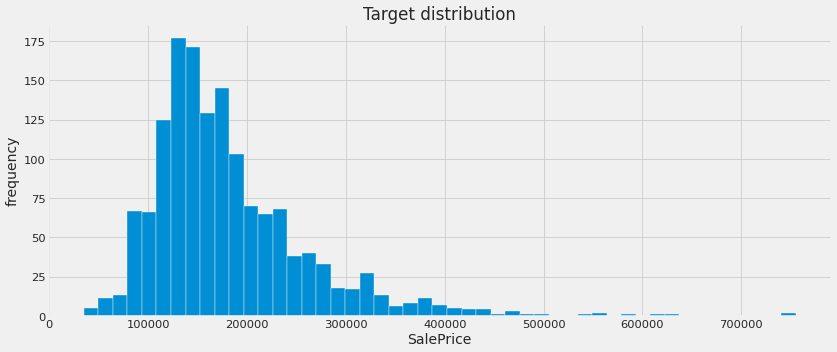

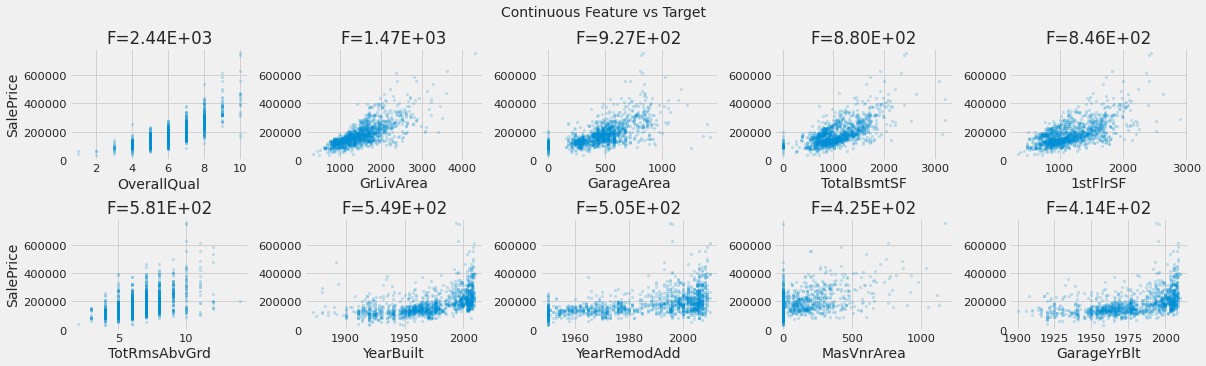

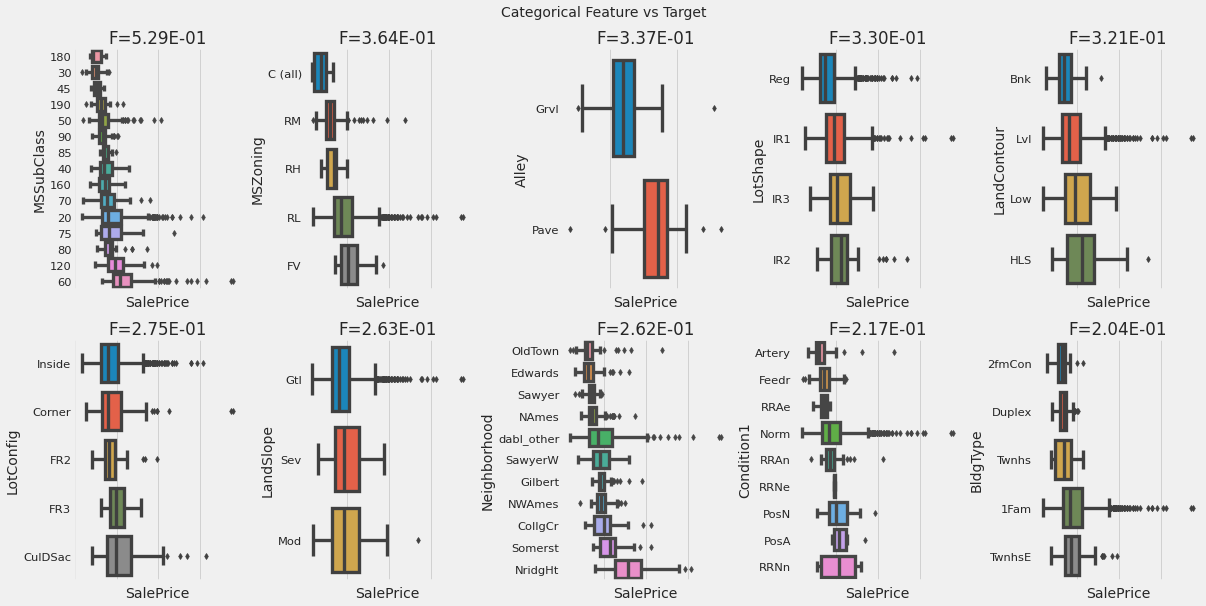

In [59]:
import dabl
dabl.plot(train, target_col = 'SalePrice')

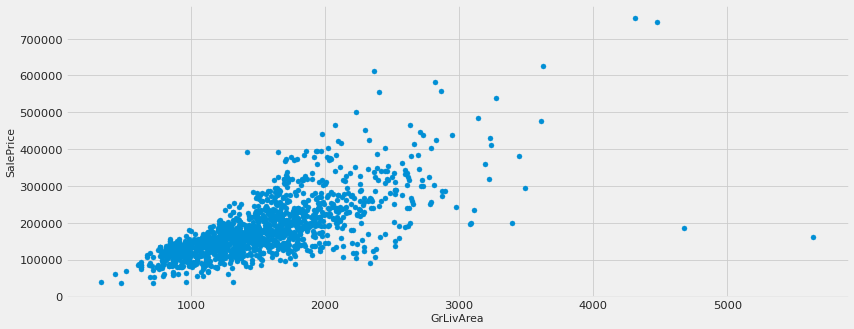

In [60]:
plot_scatter(train, 'GrLivArea', 'SalePrice')

Dropping outliers of extreme high ground living area but low sale price

In [61]:
## Delete outliers
train = train.drop(train[(train.GrLivArea > 4000) & (train.SalePrice < 300000)].index)

Correlation of features

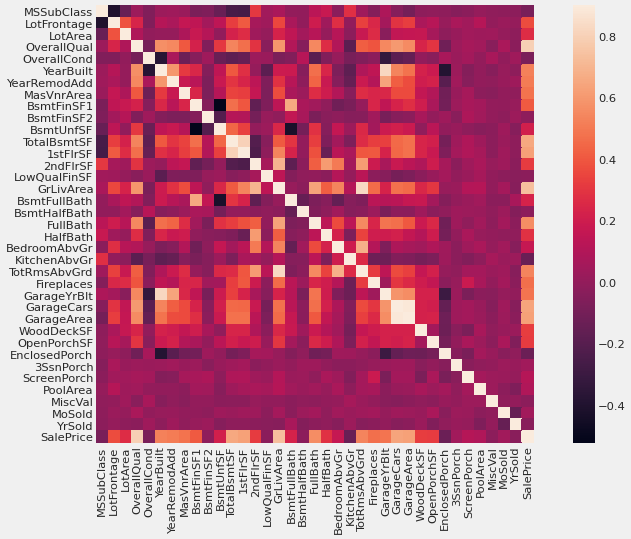

In [62]:
#correlation matrix
corrmat = train.corr()
f, ax = plt.subplots(figsize=(15, 9))
sns.heatmap(corrmat, vmax=.9, square=True)
plt.show()

Top 10 important features correlated with SalePrice

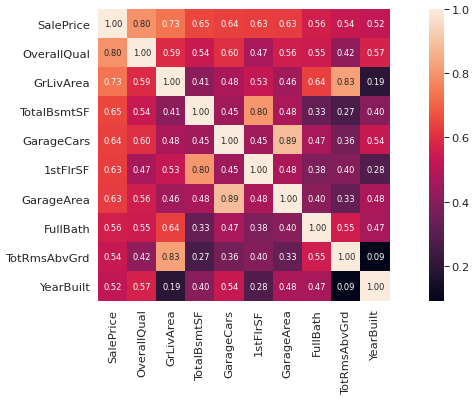

In [63]:
#saleprice correlation matrix
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, 
                 yticklabels=cols.values, xticklabels=cols.values)
plt.show()

Pairs plot of important features

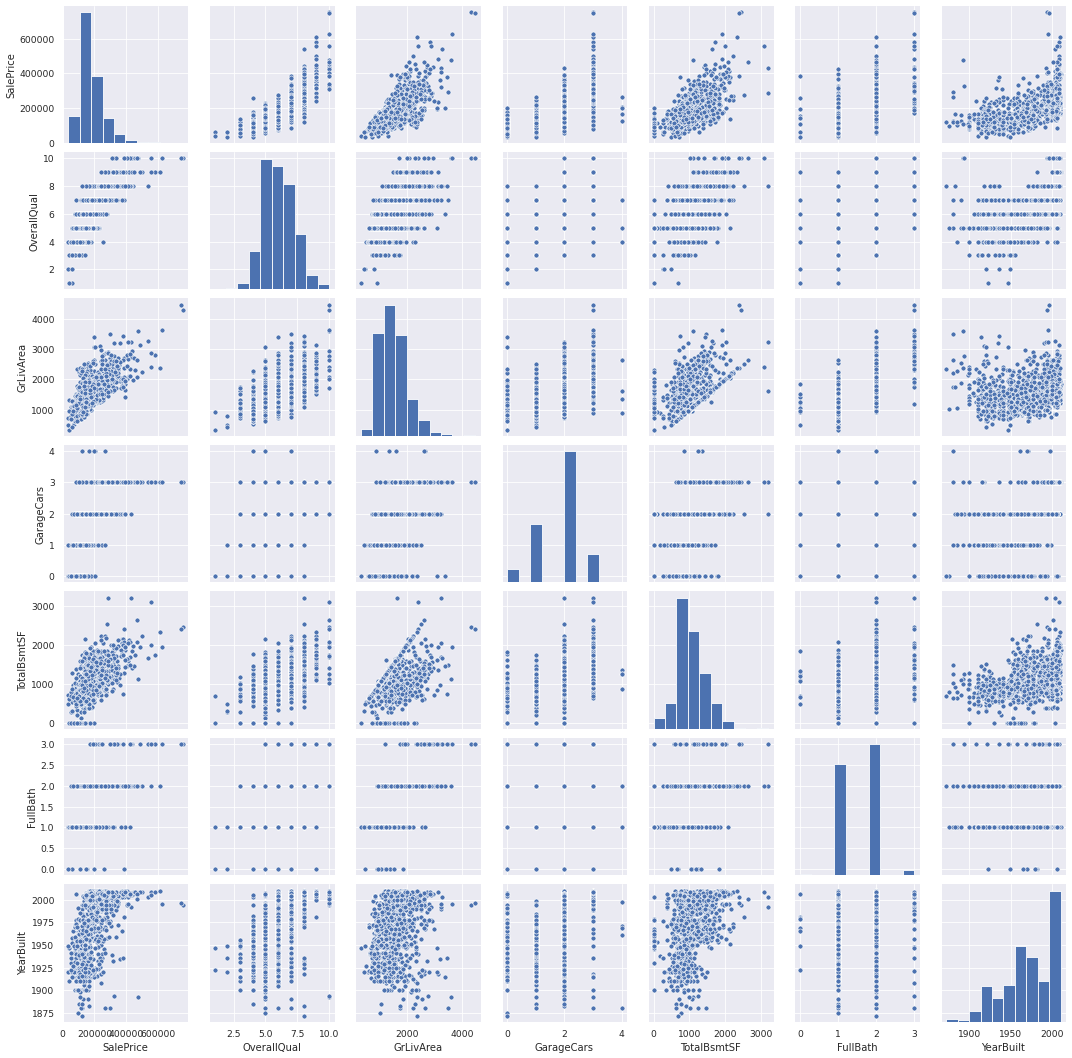

In [64]:
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
plot_pairs(train, cols)

---
## Data Analysis and Feature Engineering

Combining the train and test set together so that data transformation will be consistent and applied to both datasets.

It is important to note that any updates to the test set should be based on analysis or data available only in the train set.  Example, when updating column with null value in test set with the mean value observed, the mean value should be calculated based on data in the train set only and not the combined set.

However, for simplicity, all data manipulation and feature engineering done in a combined manner, assuming data in both the train and test set are consistent and similar.

In [65]:
traintest = combineTrainTest(train, test, features)
traintest.MSSubClass = traintest.MSSubClass.astype('category')
traintest.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2917 entries, 1 to 2919
Data columns (total 79 columns):
MSSubClass       2917 non-null category
MSZoning         2913 non-null object
LotFrontage      2431 non-null float64
LotArea          2917 non-null int64
Street           2917 non-null object
Alley            198 non-null object
LotShape         2917 non-null object
LandContour      2917 non-null object
Utilities        2915 non-null object
LotConfig        2917 non-null object
LandSlope        2917 non-null object
Neighborhood     2917 non-null object
Condition1       2917 non-null object
Condition2       2917 non-null object
BldgType         2917 non-null object
HouseStyle       2917 non-null object
OverallQual      2917 non-null int64
OverallCond      2917 non-null int64
YearBuilt        2917 non-null int64
YearRemodAdd     2917 non-null int64
RoofStyle        2917 non-null object
RoofMatl         2917 non-null object
Exterior1st      2916 non-null object
Exterior2nd      2916 

Check columns with null values

In [66]:
na_cols = traintest.columns[traintest.isna().any()].tolist()
traintest[na_cols].isnull().sum().sort_values(ascending=False)

PoolQC          2908
MiscFeature     2812
Alley           2719
Fence           2346
FireplaceQu     1420
LotFrontage      486
GarageFinish     159
GarageYrBlt      159
GarageQual       159
GarageCond       159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
BsmtFullBath       2
BsmtHalfBath       2
Utilities          2
Functional         2
Exterior2nd        1
Exterior1st        1
SaleType           1
BsmtFinSF1         1
BsmtFinSF2         1
BsmtUnfSF          1
Electrical         1
KitchenQual        1
GarageCars         1
GarageArea         1
TotalBsmtSF        1
dtype: int64

### Fixing the missing values
#### PoolQC

In [67]:
traintest.loc[(traintest.PoolQC.isnull()) & (traintest.PoolArea == 0), 'PoolQC'] = 'NA'
traintest['PoolQC'] = traintest.groupby(['OverallQual'])['PoolQC'].transform(lambda x: x.fillna(x.mode()[0]))

#### FireplaceQu

In [68]:
traintest.loc[(traintest.FireplaceQu.isnull()) & (traintest.Fireplaces == 0), 'FireplaceQu'] = 'NA'
traintest['FireplaceQu'] = traintest.groupby(['OverallQual'])['FireplaceQu'].transform(lambda x: x.fillna(x.mode()[0]))

#### MiscFeature

In [69]:
traintest.loc[(traintest.MiscFeature.isnull()), 'MiscFeature'] = 'NA'
traintest.loc[(traintest.Fence.isnull()), 'Fence'] = 'NA'
traintest.loc[(traintest.Alley.isnull()), 'Alley'] = 'NA'

#### Lot Info

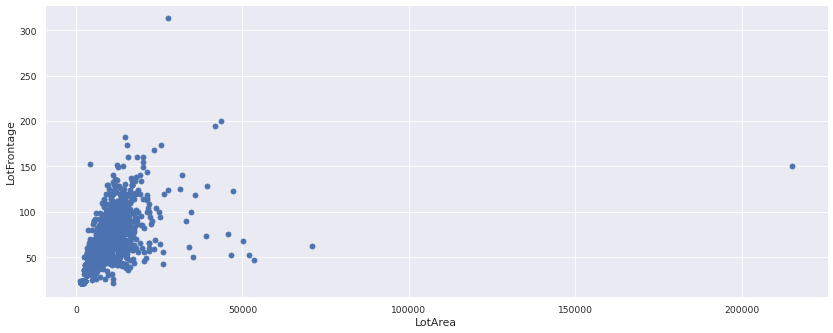

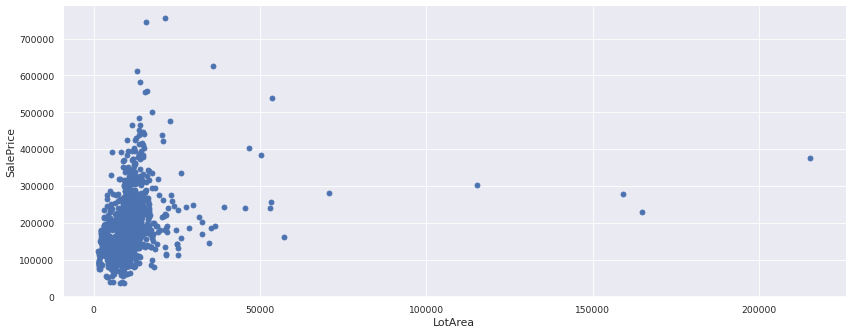

In [70]:
traintest.filter(regex='Lot').head()
plot_scatter(traintest, 'LotArea', 'LotFrontage')
plot_scatter(train, 'LotArea', 'SalePrice')

Notice the outlier.  Extremely large plot of land with with small frontage.  Winsorize the lotarea??

In [71]:
from scipy.stats.mstats import winsorize

# Check minimum sum of donations
# print(traintest["LotArea"].min())
# print(traintest["LotArea"].max())

traintest["LotArea"] = winsorize(traintest["LotArea"], limits=[0, 0.005])

In [72]:
traintest[(traintest.LotArea > 50000)].filter(regex='Lot').head()

Empty DataFrame
Columns: [LotFrontage, LotArea, LotShape, LotConfig]
Index: []

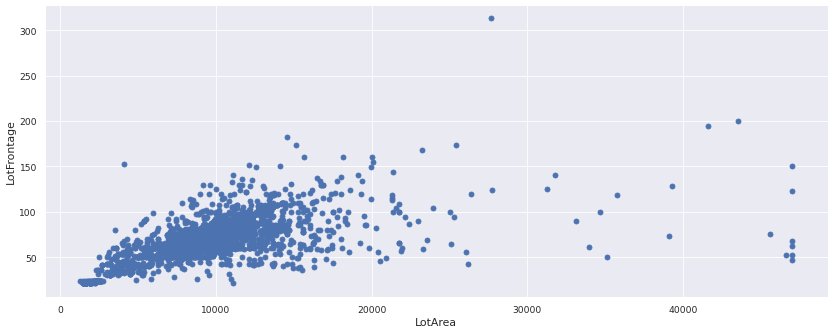

In [73]:
plot_scatter(traintest, 'LotArea', 'LotFrontage')

Create categorial features to group the lot area and then filling the missing lot frontage with respective median.

In [74]:
traintest['LotAreaGroup'] = pd.qcut(traintest['LotArea'], 5, 
                                    labels=['XS','S','M','L','XL'])

traintest['LotFrontage'] = traintest.groupby(['LotAreaGroup','LotShape'])['LotFrontage'].transform(lambda x: x.fillna(x.median()))
traintest['LotFrontage'] = traintest.groupby(['LotAreaGroup'])['LotFrontage'].transform(lambda x: x.fillna(x.median()))

#### Garage Info

In [75]:
traintest.loc[(traintest.GarageYrBlt.isnull()), 'GarageYrBlt'] = -1
traintest.loc[(traintest.GarageFinish.isnull()), 'GarageFinish'] = 'NA'
traintest.loc[(traintest.GarageQual.isnull()), 'GarageQual'] = 'NA'
traintest.loc[(traintest.GarageCond.isnull()), 'GarageCond'] = 'NA'
traintest.loc[(traintest.GarageType.isnull()), 'GarageType'] = 'NA'

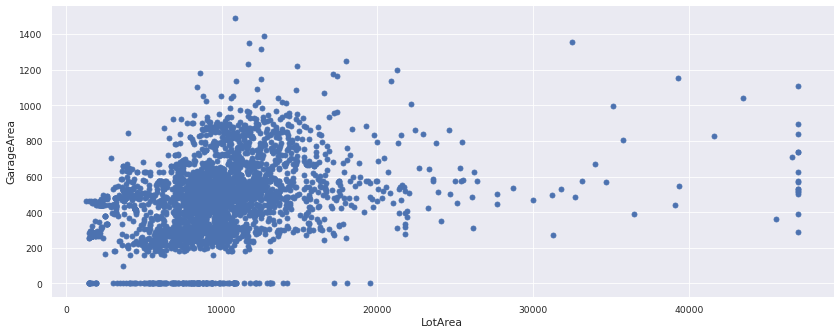

In [76]:
plot_scatter(traintest, 'LotArea', 'GarageArea')

In [77]:
traintest['GarageArea'] = traintest.groupby(['LotAreaGroup'])['GarageArea'].transform(lambda x: x.fillna(x.median()))
traintest['GarageCars'] = traintest.groupby(['LotAreaGroup'])['GarageCars'].transform(lambda x: x.fillna(x.median()))

#### Basement Info

In [78]:
traintest.loc[(traintest.BsmtCond.isnull()), 'BsmtCond'] = 'NA'
traintest.loc[(traintest.BsmtExposure.isnull()), 'BsmtExposure'] = 'NA'
traintest.loc[(traintest.BsmtQual.isnull()), 'BsmtQual'] = 'NA'
traintest.loc[(traintest.BsmtFinType1.isnull()), 'BsmtFinType1'] = 'NA'
traintest.loc[(traintest.BsmtFinType2.isnull()), 'BsmtFinType2'] = 'NA'

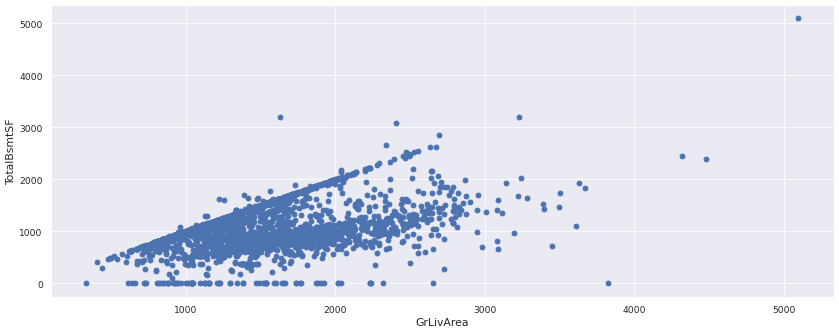

In [79]:
plot_scatter(traintest, 'GrLivArea', 'TotalBsmtSF')

In [80]:
traintest['GrLivAreaGroup'] = pd.qcut(traintest['GrLivArea'], 5, 
                                    labels=['XS','S','M','L','XL'])
traintest['TotalBsmtSF'] = traintest.groupby(['GrLivAreaGroup'])['TotalBsmtSF'].transform(lambda x: x.fillna(x.median()))

In [81]:
traintest['TotalBsmtSFGroup'] = pd.qcut(traintest['TotalBsmtSF'], 5, 
                                    labels=['XS','S','M','L','XL'])

traintest['BsmtFullBath'] = traintest.groupby(['TotalBsmtSFGroup'])['BsmtFullBath'].transform(lambda x: x.fillna(x.median()))
traintest['BsmtHalfBath'] = traintest.groupby(['TotalBsmtSFGroup'])['BsmtHalfBath'].transform(lambda x: x.fillna(x.median()))


In [82]:
traintest[traintest.BsmtFinSF1.isnull()].filter(regex='Bsmt')

BsmtQual BsmtCond BsmtExposure BsmtFinType1  BsmtFinSF1 BsmtFinType2  \
Id                                                                          
2121       NA       NA           NA           NA         NaN           NA   

      BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  BsmtFullBath  BsmtHalfBath  \
Id                                                                     
2121         NaN        NaN        864.0           0.0           0.0   

     TotalBsmtSFGroup  
Id                     
2121                S

This record belongs to the test data set.  Hence cannot be dropped.  Decided to drop the columns instead.

In [83]:
# traintest.loc[traintest.BsmtFinSF1.isnull(), ['BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF']]
traintest = traintest.drop(['BsmtFinSF1','BsmtFinSF2','BsmtUnfSF'], axis=1)

In [84]:
# garage = traintest.columns[traintest.columns.str.startswith('Garage')].tolist()
# basement = traintest.columns[traintest.columns.str.contains('Bsmt')].tolist()
# quality = traintest.columns[traintest.columns.str.contains('Qual')].tolist()

In [85]:
# na_cols = traintest.columns[traintest.isna().any()].tolist()
# traintest[na_cols].isnull().sum().sort_values(ascending=False)

#### MasVnrType Info

In [86]:
traintest.loc[(traintest.MasVnrType.isnull()) & (traintest.MasVnrArea.isnull()), 'MasVnrType'] = 'None'
traintest.loc[(traintest.MasVnrType == 'None') & (traintest.MasVnrArea.isnull()), 'MasVnrArea'] = 0
traintest['MasVnrType'] = traintest.groupby(['MSSubClass'])['MasVnrType'].transform(lambda x: x.fillna(x.mode()[0]))

#### Utilities Info

In [87]:
# traintest['Utilities'] = traintest.groupby(['MSSubClass','YearRemodAdd'])['Utilities'].transform(lambda x: x.fillna(x.mode()[0]))
train.Utilities.value_counts()
traintest = traintest.drop(['Utilities'], axis=1)

#### Miscellaneous Info

In [88]:
traintest['MSZoning'] = traintest.groupby(['MSSubClass','Neighborhood'])['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))
traintest['Functional'] = traintest.groupby(['OverallQual'])['Functional'].transform(lambda x: x.fillna(x.mode()[0]))
traintest['KitchenQual'] = traintest.groupby('OverallQual')['KitchenQual'].transform(lambda x: x.fillna(x.mode()[0]))
traintest['Electrical'] = traintest.groupby(['MSSubClass','YearRemodAdd'])['Electrical'].transform(lambda x: x.fillna(x.mode()[0]))
traintest['SaleType'] = traintest['SaleType'].fillna(traintest['SaleType'].mode()[0])


### Adding potentially useful columns
1. Total Square Feet

In [89]:
traintest['TotalSF'] = traintest['1stFlrSF'] + traintest['2ndFlrSF'] + traintest['TotalBsmtSF']

# tosquare = ['LotFrontage', 'LotArea','MasVnrArea','TotalBsmtSF',
#                '1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea',
#                'GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch',
#                '3SsnPorch','ScreenPorch','PoolArea','MiscVal','TotalSF']

# def genSquareColumns(data, columns):
#     for column in columns:
#         new_column = column + '_squared'
#         data[new_column] = data[column] * data[column]
#     return data
    
# traintest = genSquareColumns(traintest, tosquare)

### Dropping potentially irrelevant columns

These are categorical columns with many categories.  To drop for now so that the size of the data sets for training and test are manageable.

In [90]:
todrop = ['Neighborhood','Exterior1st','Exterior2nd']
traintest = traintest.drop(todrop, axis=1)

### Final Check

Are there any columns with missing data?

In [91]:
traintest.isnull().any().any()

False

In [92]:
traintest.describe(include=np.number)

LotFrontage       LotArea  OverallQual  OverallCond    YearBuilt  \
count   2917.00000   2917.000000  2917.000000  2917.000000  2917.000000   
mean      69.73843   9954.323620     6.086390     5.564964  1971.287967   
std       21.54500   5157.292522     1.406704     1.113414    30.286991   
min       21.00000   1300.000000     1.000000     1.000000  1872.000000   
25%       60.00000   7476.000000     5.000000     5.000000  1953.000000   
50%       70.00000   9452.000000     6.000000     5.000000  1973.000000   
75%       82.00000  11556.000000     7.000000     6.000000  2001.000000   
max      313.00000  47007.000000    10.000000     9.000000  2010.000000   

       YearRemodAdd   MasVnrArea  TotalBsmtSF     1stFlrSF     2ndFlrSF  \
count   2917.000000  2917.000000  2917.000000  2917.000000  2917.000000   
mean    1984.248200   100.931436  1049.263970  1157.692492   335.861502   
std       20.892257   178.032499   429.046043   385.264298   428.119663   
min     1950.000000     0.000000     0.000000   334.000000     0.000000   
25%     1965.000000     0.000000   793.000000   876.000000     0.000000   
50%     1993.000000     0.000000   988.000000  1082.000000     0.000000   
75%     2004.000000   163.000000  1302.000000  1384.000000   704.000000   
max     2010.000000  1600.000000  5095.000000  5095.000000  2065.000000   

       LowQualFinSF    GrLivArea  BsmtFullBath  BsmtHalfBath     FullBath  \
count   2917.000000  2917.000000   2917.000000   2917.000000  2917.000000   
mean       4.697635  1498.251628      0.428865      0.061364     1.567364   
std       46.412570   496.908626      0.523943      0.245687     0.552465   
min        0.000000   334.000000      0.000000      0.000000     0.000000   
25%        0.000000  1126.000000      0.000000      0.000000     1.000000   
50%        0.000000  1444.000000      0.000000      0.000000     2.000000   
75%        0.000000  1743.000000      1.000000      0.000000     2.000000   
max     1064.000000  5095.000000      3.000000      2.000000     4.000000   

          HalfBath  BedroomAbvGr  KitchenAbvGr  TotRmsAbvGrd   Fireplaces  \
count  2917.000000   2917.000000   2917.000000   2917.000000  2917.000000   
mean      0.379842      2.860130      1.044566      6.448063     0.596160   
std       0.502782      0.822967      0.214532      1.564281     0.644773   
min       0.000000      0.000000      0.000000      2.000000     0.000000   
25%       0.000000      2.000000      1.000000      5.000000     0.000000   
50%       0.000000      3.000000      1.000000      6.000000     1.000000   
75%       1.000000      3.000000      1.000000      7.000000     1.000000   
max       2.000000      8.000000      3.000000     15.000000     4.000000   

       GarageYrBlt   GarageCars   GarageArea   WoodDeckSF  OpenPorchSF  \
count  2917.000000  2917.000000  2917.000000  2917.000000  2917.000000   
mean   1870.215632     1.766198   472.409325    93.629414    47.280082   
std     450.052870     0.761412   214.584074   126.532643    67.118965   
min      -1.000000     0.000000     0.000000     0.000000     0.000000   
25%    1957.000000     1.000000   320.000000     0.000000     0.000000   
50%    1977.000000     2.000000   480.000000     0.000000    26.000000   
75%    2001.000000     2.000000   576.000000   168.000000    70.000000   
max    2207.000000     5.000000  1488.000000  1424.000000   742.000000   

       EnclosedPorch    3SsnPorch  ScreenPorch     PoolArea       MiscVal  \
count    2917.000000  2917.000000  2917.000000  2917.000000   2917.000000   
mean       23.114158     2.604045    16.073363     2.088790     50.860816   
std        64.263424    25.196714    56.202054    34.561371    567.595198   
min         0.000000     0.000000     0.000000     0.000000      0.000000   
25%         0.000000     0.000000     0.000000     0.000000      0.000000   
50%         0.000000     0.000000     0.000000     0.000000      0.000000   
75%         0.000000     0.000000     0.000000     0.000000  

In [93]:
traintest.describe(include=[np.object])

MSZoning Street Alley LotShape LandContour LotConfig LandSlope  \
count      2917   2917  2917     2917        2917      2917      2917   
unique        5      2     3        4           4         5         3   
top          RL   Pave    NA      Reg         Lvl    Inside       Gtl   
freq       2264   2905  2719     1859        2622      2132      2776   

       Condition1 Condition2 BldgType HouseStyle RoofStyle RoofMatl  \
count        2917       2917     2917       2917      2917     2917   
unique          9          8        5          8         6        7   
top          Norm       Norm     1Fam     1Story     Gable  CompShg   
freq         2511       2888     2423       1471      2310     2875   

       MasVnrType ExterQual ExterCond Foundation BsmtQual BsmtCond  \
count        2917      2917      2917       2917     2917     2917   
unique          4         4         5          6        5        5   
top          None        TA        TA      PConc       TA       TA   
freq         1766      1798      2536       1306     1283     2604   

       BsmtExposure BsmtFinType1 BsmtFinType2 Heating HeatingQC CentralAir  \
count          2917         2917         2917    2917      2917       2917   
unique            5            7            7       6         5          2   
top              No          Unf          Unf    GasA        Ex          Y   
freq           1904          851         2491    2872      1491       2721   

       Electrical KitchenQual Functional FireplaceQu GarageType GarageFinish  \
count        2917        2917       2917        2917       2917         2917   
unique          5           4          7           6          7            4   
top         SBrkr          TA        Typ          NA     Attchd          Unf   
freq         2670        1493       2716        1420       1722         1230   

       GarageQual GarageCond PavedDrive PoolQC Fence MiscFeature SaleType  \
count        2917       2917       2917   2917  2917        2917     2917   
unique          6          6          3      4     5           5        9   
top            TA         TA          Y     NA    NA          NA       WD   
freq         2602       2652       2639   2908  2346        2812     2526   

       SaleCondition  
count           2917  
unique             6  
top           Normal  
freq            2402

## Preprocessing data for training
1. Splitting the combined dataset back to train and test set
2. One Hot Encoding for Categorical features
3. Normalising the Numerical features

In [94]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

In [95]:
def processStdScalar(train, test, columns):
    
    train_scaled = train.copy()
    test_scaled = test.copy()
    
    for column in columns:
        scalar = StandardScaler()
        scalar.fit(train[[column]])
        train_scaled[column] = scalar.transform(train[[column]])
        test_scaled[column] = scalar.transform(test[[column]])
        
    return train_scaled, test_scaled

In [96]:
traintest.shape

(2917, 76)

### One-Hot Encoding

For simplicity, using Pandas get_dummies for OHE for now.  Also applying to the combined dataset so that the encoding can be consistently applied to both train and test dataset.

In [97]:
traintest = pd.get_dummies(traintest, drop_first=True)

### Splitting the combined data set back to train and test

In [98]:
Xy, X_test = splitTrainTest(traintest, train, test, target)

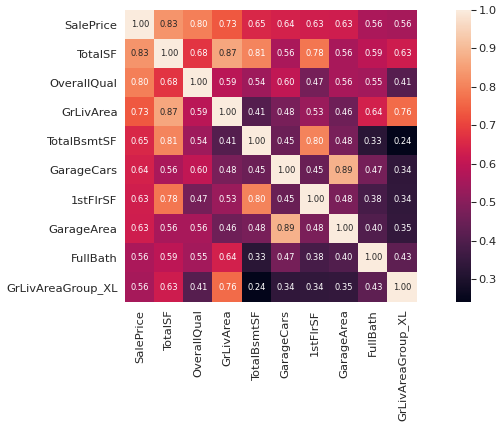

In [99]:
newcorrmat = Xy.corr()

#saleprice correlation matrix
k = 10 #number of variables for heatmap
cols = newcorrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(Xy[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, 
                 yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [100]:
X = Xy.drop(target, axis=1)
y = Xy[target]

### Normalise Numerical Features
Identify numerical features to normalise

In [101]:
tonormalise = ['LotFrontage', 'LotArea','MasVnrArea','TotalBsmtSF',
               '1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea',
               'GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch',
               '3SsnPorch','ScreenPorch','PoolArea','MiscVal','TotalSF']

# tonormalise = tonormalise + [col+'_squared' for col in tonormalise]
# plot_pairs(Xy, tonormalise)

Normalisation was done by fitting the scaler with training data and then transforming the train and test data respectively.

In [102]:
X, X_test, = processStdScalar(X, X_test, tonormalise)

### Normalise Target Features

In [103]:
targetScalar = StandardScaler()
targetScalar.fit(y)
y.SalePrice = targetScalar.transform(y)

### Train Test (Valid) Split
Splitting the training dataset into training and validation data set.  Purpose of the validation data set is for model evaluation later.

In [104]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.4, random_state=SEED)

print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)

(874, 228)
(874, 1)
(584, 228)
(584, 1)
(1459, 228)


---
## Tensorflow

In [105]:
# !pip install tensorflow
# !pip install -q git+https://github.com/tensorflow/docs

### Helper functions
1. **plot_results** - Plot training and validation data over the various epochs

In [106]:
def plot_results(data, val_data, limit=1, title='Results'):
    plt.figure()
    plt.plot(data)
    plt.plot(val_data)
    plt.ylim([0, limit])
    plt.title(title)
    plt.ylabel(title)
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper right')
    plt.show()

In [107]:
INPUTS = len(X_train.columns)
TRAINING_OBSERVATIONS = X_train.shape[0]
print('Number of inputs to neural network: {}'.format(INPUTS))
print('Number of training observations: {}'.format(TRAINING_OBSERVATIONS))

X_train = np.array(X_train)
y_train = np.array(y_train)
X_valid = np.array(X_valid)
y_valid = np.array(y_valid)

Number of inputs to neural network: 228
Number of training observations: 874


### Model Building Considerations:
1. Problem Identification 
    - Binary, Multiclass, Multilabel, Regression
2. Number of Dense layers
    - What is the Activation function
    - Number of Nodes in each layer
    - Any kernel_initializer?
3. Optimization function
    - learning rate and many other parameters (to explore)
4. Loss function
5. Metrics
6. Fitting Parameters
    - Optimal Batch Size
    - Training and Validation Dataset
    - Number of EPOCHS
    - EarlyStopping - patience number
    - ModelCheckpoint

Additional Considerations:
1. Normalisation layers
2. Dropout layers


In [108]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

def build_model(nodes=(16,32,16), activation='relu', learning_rate=0.002, input_dropout=0.05):
    model = Sequential()

    model.add(Dense(nodes[0], input_shape=(INPUTS,), activation='relu', kernel_initializer='normal'))
    model.add(tf.keras.layers.Dropout(input_dropout))
    
    for node in nodes[1:]:
        model.add(Dense(node, activation='relu', kernel_initializer='normal'))

    # model.add(Dense(nodes[1], activation='relu', kernel_initializer='normal'))
    # model.add(tf.keras.layers.BatchNormalization())

    model.add(Dense(1))

    # optimizer = tf.keras.optimizers.RMSprop(0.03)
    # opt = 'RMSprop'
    opt = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.99, epsilon=None, decay=0.0, amsgrad=False)

    model.compile(optimizer=opt, loss='mse', metrics=['mae', 'mse'])

    return model

### Hyperparameters Search

In [109]:
import itertools

layer1 = [8]
layer2 = [16]
layer3 = [32]
layers = [layer1, layer2, layer3]

NODES_LIST = list(itertools.product(*layers))
ACTIVATION_LIST = ['relu', 'sigmoid'] ## 'relu', 'sigmoid', 'tanh', 'leaky_relu'
BATCHSIZE_LIST = [874]
EPOCHS_LIST = [1000]
LEARNINGRATE_LIST = [0.0005, 0.001]
INPUTDROPOUT_LIST = [0, 0.05, 0.1]

# Define the parameters to try out
params = {'nodes': NODES_LIST, 
          'activation': ACTIVATION_LIST, 
          'batch_size': BATCHSIZE_LIST, 
          'epochs': EPOCHS_LIST, 
          'input_dropout': INPUTDROPOUT_LIST, 
          'learning_rate': LEARNINGRATE_LIST}

print(params)

{'nodes': [(8, 16, 32)], 'activation': ['relu', 'sigmoid'], 'batch_size': [874], 'epochs': [1000], 'input_dropout': [0, 0.05, 0.1], 'learning_rate': [0.0005, 0.001]}


In [110]:
# Import KerasRegressor from keras wrappers
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

# Create a KerasRegressor
grid_buildmodel = KerasRegressor(build_fn = build_model)

grid_search = GridSearchCV(grid_buildmodel, param_grid = params, cv = 3, verbose=0, return_train_score=True)

In [111]:
%time grid_search.fit(X_train, y_train)

Epoch 1/1000
1/1 [==============================] - 0s 1ms/step - loss: 5.2228 - mae: 2.1434 - mse: 5.2228
Epoch 2/1000
1/1 [==============================] - 0s 1ms/step - loss: 3.9747 - mae: 1.8466 - mse: 3.9747
Epoch 3/1000
1/1 [==============================] - 0s 1ms/step - loss: 2.9549 - mae: 1.5693 - mse: 2.9549
Epoch 4/1000
1/1 [==============================] - 0s 2ms/step - loss: 2.1762 - mae: 1.3144 - mse: 2.1762
Epoch 5/1000
1/1 [==============================] - 0s 1ms/step - loss: 1.6229 - mae: 1.0976 - mse: 1.6229
Epoch 6/1000
1/1 [==============================] - 0s 1ms/step - loss: 1.2640 - mae: 0.9233 - mse: 1.2640
Epoch 7/1000
1/1 [==============================] - 0s 1ms/step - loss: 1.0760 - mae: 0.8051 - mse: 1.0760
Epoch 8/1000
1/1 [==============================] - 0s 1ms/step - loss: 1.0115 - mae: 0.7446 - mse: 1.0115
Epoch 9/1000
1/1 [==============================] - 0s 2ms/step - loss: 1.0050 - mae: 0.7117 - mse: 1.0050
Epoch 10/1000
1/1 [==================

1/1 [==============================] - 0s 3ms/step - loss: 0.9794 - mae: 0.7110 - mse: 0.9794
Epoch 77/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.9793 - mae: 0.7104 - mse: 0.9793
Epoch 78/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.9792 - mae: 0.7097 - mse: 0.9792
Epoch 79/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9790 - mae: 0.7091 - mse: 0.9790
Epoch 80/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9790 - mae: 0.7085 - mse: 0.9790
Epoch 81/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9789 - mae: 0.7079 - mse: 0.9789
Epoch 82/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9788 - mae: 0.7074 - mse: 0.9788
Epoch 83/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9788 - mae: 0.7070 - mse: 0.9788
Epoch 84/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9787 - mae: 0.7067 - mse: 0.9787
Epoch 85/1000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 0.9650 - mae: 0.7021 - mse: 0.9650
Epoch 152/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.9646 - mae: 0.7019 - mse: 0.9646
Epoch 153/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9642 - mae: 0.7017 - mse: 0.9642
Epoch 154/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9638 - mae: 0.7015 - mse: 0.9638
Epoch 155/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9633 - mae: 0.7013 - mse: 0.9633
Epoch 156/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9629 - mae: 0.7011 - mse: 0.9629
Epoch 157/1000
1/1 [==============================] - 0s 976us/step - loss: 0.9624 - mae: 0.7007 - mse: 0.9624
Epoch 158/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.9619 - mae: 0.7003 - mse: 0.9619
Epoch 159/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9614 - mae: 0.7000 - mse: 0.9614
Epoch 160/1000
1/1 [============

1/1 [==============================] - 0s 1ms/step - loss: 0.8637 - mae: 0.6555 - mse: 0.8637
Epoch 226/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8606 - mae: 0.6540 - mse: 0.8606
Epoch 227/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.8574 - mae: 0.6527 - mse: 0.8574
Epoch 228/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.8542 - mae: 0.6502 - mse: 0.8542
Epoch 229/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.8508 - mae: 0.6486 - mse: 0.8508
Epoch 230/1000
1/1 [==============================] - 0s 975us/step - loss: 0.8474 - mae: 0.6479 - mse: 0.8474
Epoch 231/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8438 - mae: 0.6460 - mse: 0.8438
Epoch 232/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.8401 - mae: 0.6436 - mse: 0.8401
Epoch 233/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.8360 - mae: 0.6415 - mse: 0.8360
Epoch 234/1000
1/1 [============

1/1 [==============================] - 0s 2ms/step - loss: 0.3349 - mae: 0.3574 - mse: 0.3349
Epoch 300/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.3321 - mae: 0.3377 - mse: 0.3321
Epoch 301/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.3306 - mae: 0.3752 - mse: 0.3306
Epoch 302/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.3268 - mae: 0.3288 - mse: 0.3268
Epoch 303/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.3197 - mae: 0.3638 - mse: 0.3197
Epoch 304/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.3118 - mae: 0.3321 - mse: 0.3118
Epoch 305/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.3070 - mae: 0.3333 - mse: 0.3070
Epoch 306/1000
1/1 [==============================] - ETA: 0s - loss: 0.3052 - mae: 0.3491 - mse: 0.305 - 0s 2ms/step - loss: 0.3052 - mae: 0.3491 - mse: 0.3052
Epoch 307/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.3044 - mae: 0.3

1/1 [==============================] - 0s 2ms/step - loss: 0.1750 - mae: 0.2505 - mse: 0.1750
Epoch 373/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1717 - mae: 0.2523 - mse: 0.1717
Epoch 374/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1727 - mae: 0.2611 - mse: 0.1727
Epoch 375/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1722 - mae: 0.2503 - mse: 0.1722
Epoch 376/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1693 - mae: 0.2558 - mse: 0.1693
Epoch 377/1000
1/1 [==============================] - 0s 934us/step - loss: 0.1683 - mae: 0.2547 - mse: 0.1683
Epoch 378/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1688 - mae: 0.2498 - mse: 0.1688
Epoch 379/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1677 - mae: 0.2576 - mse: 0.1677
Epoch 380/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1653 - mae: 0.2487 - mse: 0.1653
Epoch 381/1000
1/1 [============

1/1 [==============================] - 0s 2ms/step - loss: 0.1291 - mae: 0.2300 - mse: 0.1291
Epoch 448/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1287 - mae: 0.2302 - mse: 0.1287
Epoch 449/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1286 - mae: 0.2308 - mse: 0.1286
Epoch 450/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1289 - mae: 0.2298 - mse: 0.1289
Epoch 451/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1297 - mae: 0.2340 - mse: 0.1297
Epoch 452/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1312 - mae: 0.2323 - mse: 0.1312
Epoch 453/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1321 - mae: 0.2400 - mse: 0.1321
Epoch 454/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1325 - mae: 0.2349 - mse: 0.1325
Epoch 455/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1311 - mae: 0.2387 - mse: 0.1311
Epoch 456/1000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.1101 - mae: 0.2177 - mse: 0.1101
Epoch 523/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1126 - mae: 0.2229 - mse: 0.1126
Epoch 524/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1151 - mae: 0.2273 - mse: 0.1151
Epoch 525/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1162 - mae: 0.2260 - mse: 0.1162
Epoch 526/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1132 - mae: 0.2241 - mse: 0.1132
Epoch 527/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1095 - mae: 0.2146 - mse: 0.1095
Epoch 528/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1075 - mae: 0.2132 - mse: 0.1075
Epoch 529/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1094 - mae: 0.2175 - mse: 0.1094
Epoch 530/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1134 - mae: 0.2265 - mse: 0.1134
Epoch 531/1000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.1007 - mae: 0.2121 - mse: 0.1007
Epoch 597/1000
1/1 [==============================] - 0s 796us/step - loss: 0.0963 - mae: 0.2050 - mse: 0.0963
Epoch 598/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0946 - mae: 0.2017 - mse: 0.0946
Epoch 599/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0968 - mae: 0.2080 - mse: 0.0968
Epoch 600/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0998 - mae: 0.2115 - mse: 0.0998
Epoch 601/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1010 - mae: 0.2170 - mse: 0.1010
Epoch 602/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0984 - mae: 0.2106 - mse: 0.0984
Epoch 603/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0952 - mae: 0.2029 - mse: 0.0952
Epoch 604/1000
1/1 [==============================] - 0s 919us/step - loss: 0.0938 - mae: 0.2002 - mse: 0.0938
Epoch 605/1000
1/1 [==========

1/1 [==============================] - 0s 2ms/step - loss: 0.0835 - mae: 0.1928 - mse: 0.0835
Epoch 670/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0838 - mae: 0.1937 - mse: 0.0838
Epoch 671/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0848 - mae: 0.1969 - mse: 0.0848
Epoch 672/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0857 - mae: 0.1976 - mse: 0.0857
Epoch 673/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0868 - mae: 0.2019 - mse: 0.0868
Epoch 674/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0866 - mae: 0.1998 - mse: 0.0866
Epoch 675/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0862 - mae: 0.2006 - mse: 0.0862
Epoch 676/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0845 - mae: 0.1963 - mse: 0.0845
Epoch 677/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0831 - mae: 0.1941 - mse: 0.0831
Epoch 678/1000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.0812 - mae: 0.1992 - mse: 0.0812
Epoch 743/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0807 - mae: 0.1994 - mse: 0.0807
Epoch 744/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0769 - mae: 0.1917 - mse: 0.0769
Epoch 745/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0743 - mae: 0.1861 - mse: 0.0743
Epoch 746/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0756 - mae: 0.1912 - mse: 0.0756
Epoch 747/1000
1/1 [==============================] - 0s 869us/step - loss: 0.0786 - mae: 0.1942 - mse: 0.0786
Epoch 748/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0799 - mae: 0.2008 - mse: 0.0799
Epoch 749/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0782 - mae: 0.1949 - mse: 0.0782
Epoch 750/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0757 - mae: 0.1886 - mse: 0.0757
Epoch 751/1000
1/1 [============

1/1 [==============================] - 0s 2ms/step - loss: 0.0751 - mae: 0.1950 - mse: 0.0751
Epoch 817/1000
1/1 [==============================] - 0s 993us/step - loss: 0.0684 - mae: 0.1824 - mse: 0.0684
Epoch 818/1000
1/1 [==============================] - 0s 951us/step - loss: 0.0696 - mae: 0.1857 - mse: 0.0696
Epoch 819/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0746 - mae: 0.1938 - mse: 0.0746
Epoch 820/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0743 - mae: 0.1978 - mse: 0.0743
Epoch 821/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0691 - mae: 0.1842 - mse: 0.0691
Epoch 822/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0676 - mae: 0.1812 - mse: 0.0676
Epoch 823/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0703 - mae: 0.1877 - mse: 0.0703
Epoch 824/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0713 - mae: 0.1884 - mse: 0.0713
Epoch 825/1000
1/1 [==========

1/1 [==============================] - 0s 2ms/step - loss: 0.0650 - mae: 0.1816 - mse: 0.0650
Epoch 891/1000
1/1 [==============================] - ETA: 0s - loss: 0.0654 - mae: 0.1816 - mse: 0.065 - 0s 3ms/step - loss: 0.0654 - mae: 0.1816 - mse: 0.0654
Epoch 892/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0641 - mae: 0.1803 - mse: 0.0641
Epoch 893/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0630 - mae: 0.1771 - mse: 0.0630
Epoch 894/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0632 - mae: 0.1774 - mse: 0.0632
Epoch 895/1000
1/1 [==============================] - 0s 42ms/step - loss: 0.0643 - mae: 0.1809 - mse: 0.0643
Epoch 896/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0645 - mae: 0.1800 - mse: 0.0645
Epoch 897/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0635 - mae: 0.1788 - mse: 0.0635
Epoch 898/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0627 - mae: 0.

1/1 [==============================] - 0s 1ms/step - loss: 0.0616 - mae: 0.1772 - mse: 0.0616
Epoch 964/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0600 - mae: 0.1753 - mse: 0.0600
Epoch 965/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0593 - mae: 0.1734 - mse: 0.0593
Epoch 966/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0596 - mae: 0.1738 - mse: 0.0596
Epoch 967/1000
1/1 [==============================] - 0s 974us/step - loss: 0.0605 - mae: 0.1768 - mse: 0.0605
Epoch 968/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0613 - mae: 0.1771 - mse: 0.0613
Epoch 969/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0617 - mae: 0.1797 - mse: 0.0617
Epoch 970/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0613 - mae: 0.1768 - mse: 0.0613
Epoch 971/1000
1/1 [==============================] - 0s 933us/step - loss: 0.0610 - mae: 0.1783 - mse: 0.0610
Epoch 972/1000
1/1 [==========

1/1 [==============================] - 0s 1ms/step - loss: 0.8977 - mae: 0.6901 - mse: 0.8977
Epoch 37/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.8981 - mae: 0.6930 - mse: 0.8981
Epoch 38/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.8987 - mae: 0.6954 - mse: 0.8987
Epoch 39/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8992 - mae: 0.6972 - mse: 0.8992
Epoch 40/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8996 - mae: 0.6984 - mse: 0.8996
Epoch 41/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8997 - mae: 0.6988 - mse: 0.8997
Epoch 42/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8996 - mae: 0.6986 - mse: 0.8996
Epoch 43/1000
1/1 [==============================] - 0s 860us/step - loss: 0.8993 - mae: 0.6977 - mse: 0.8993
Epoch 44/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.8988 - mae: 0.6964 - mse: 0.8988
Epoch 45/1000
1/1 [=====================

1/1 [==============================] - 0s 2ms/step - loss: 0.8946 - mae: 0.6857 - mse: 0.8946
Epoch 112/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8945 - mae: 0.6856 - mse: 0.8945
Epoch 113/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.8944 - mae: 0.6855 - mse: 0.8944
Epoch 114/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8944 - mae: 0.6854 - mse: 0.8944
Epoch 115/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8943 - mae: 0.6853 - mse: 0.8943
Epoch 116/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.8942 - mae: 0.6852 - mse: 0.8942
Epoch 117/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8941 - mae: 0.6851 - mse: 0.8941
Epoch 118/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8941 - mae: 0.6850 - mse: 0.8941
Epoch 119/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8940 - mae: 0.6849 - mse: 0.8940
Epoch 120/1000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.8830 - mae: 0.6796 - mse: 0.8830
Epoch 186/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8827 - mae: 0.6794 - mse: 0.8827
Epoch 187/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8824 - mae: 0.6792 - mse: 0.8824
Epoch 188/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.8820 - mae: 0.6791 - mse: 0.8820
Epoch 189/1000
1/1 [==============================] - ETA: 0s - loss: 0.8816 - mae: 0.6789 - mse: 0.881 - 0s 2ms/step - loss: 0.8816 - mae: 0.6789 - mse: 0.8816
Epoch 190/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8813 - mae: 0.6787 - mse: 0.8813
Epoch 191/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8809 - mae: 0.6786 - mse: 0.8809
Epoch 192/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8805 - mae: 0.6784 - mse: 0.8805
Epoch 193/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.8801 - mae: 0.6

1/1 [==============================] - 0s 1ms/step - loss: 0.8022 - mae: 0.6406 - mse: 0.8022
Epoch 259/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.7995 - mae: 0.6392 - mse: 0.7995
Epoch 260/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.7968 - mae: 0.6377 - mse: 0.7968
Epoch 261/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.7940 - mae: 0.6361 - mse: 0.7940
Epoch 262/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.7911 - mae: 0.6346 - mse: 0.7911
Epoch 263/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.7881 - mae: 0.6334 - mse: 0.7881
Epoch 264/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.7850 - mae: 0.6313 - mse: 0.7850
Epoch 265/1000
1/1 [==============================] - 0s 36ms/step - loss: 0.7819 - mae: 0.6300 - mse: 0.7819
Epoch 266/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.7786 - mae: 0.6291 - mse: 0.7786
Epoch 267/1000
1/1 [=============

1/1 [==============================] - 0s 2ms/step - loss: 0.4066 - mae: 0.4262 - mse: 0.4066
Epoch 333/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.4014 - mae: 0.3895 - mse: 0.4014
Epoch 334/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.3932 - mae: 0.4106 - mse: 0.3932
Epoch 335/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.3867 - mae: 0.4004 - mse: 0.3867
Epoch 336/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.3825 - mae: 0.3813 - mse: 0.3825
Epoch 337/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.3774 - mae: 0.4054 - mse: 0.3774
Epoch 338/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.3707 - mae: 0.3756 - mse: 0.3707
Epoch 339/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.3641 - mae: 0.3826 - mse: 0.3641
Epoch 340/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.3592 - mae: 0.3852 - mse: 0.3592
Epoch 341/1000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.2114 - mae: 0.3067 - mse: 0.2114
Epoch 406/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2105 - mae: 0.3043 - mse: 0.2105
Epoch 407/1000
1/1 [==============================] - ETA: 0s - loss: 0.2100 - mae: 0.3035 - mse: 0.210 - 0s 2ms/step - loss: 0.2100 - mae: 0.3035 - mse: 0.2100
Epoch 408/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.2096 - mae: 0.3066 - mse: 0.2096
Epoch 409/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2092 - mae: 0.3019 - mse: 0.2092
Epoch 410/1000
1/1 [==============================] - 0s 997us/step - loss: 0.2090 - mae: 0.3080 - mse: 0.2090
Epoch 411/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2085 - mae: 0.3009 - mse: 0.2085
Epoch 412/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2080 - mae: 0.3081 - mse: 0.2080
Epoch 413/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2073 - mae: 0

1/1 [==============================] - 0s 3ms/step - loss: 0.1789 - mae: 0.2918 - mse: 0.1789
Epoch 479/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1785 - mae: 0.2891 - mse: 0.1785
Epoch 480/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1781 - mae: 0.2902 - mse: 0.1781
Epoch 481/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1778 - mae: 0.2900 - mse: 0.1778
Epoch 482/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1775 - mae: 0.2888 - mse: 0.1775
Epoch 483/1000
1/1 [==============================] - 0s 1000us/step - loss: 0.1772 - mae: 0.2905 - mse: 0.1772
Epoch 484/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1769 - mae: 0.2883 - mse: 0.1769
Epoch 485/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1765 - mae: 0.2897 - mse: 0.1765
Epoch 486/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1761 - mae: 0.2885 - mse: 0.1761
Epoch 487/1000
1/1 [===========

1/1 [==============================] - 0s 3ms/step - loss: 0.1566 - mae: 0.2731 - mse: 0.1566
Epoch 553/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1567 - mae: 0.2768 - mse: 0.1567
Epoch 554/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1565 - mae: 0.2725 - mse: 0.1565
Epoch 555/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1558 - mae: 0.2751 - mse: 0.1558
Epoch 556/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1552 - mae: 0.2730 - mse: 0.1552
Epoch 557/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1551 - mae: 0.2723 - mse: 0.1551
Epoch 558/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1551 - mae: 0.2748 - mse: 0.1551
Epoch 559/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1549 - mae: 0.2714 - mse: 0.1549
Epoch 560/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1545 - mae: 0.2741 - mse: 0.1545
Epoch 561/1000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 0.1376 - mae: 0.2573 - mse: 0.1376
Epoch 627/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1380 - mae: 0.2616 - mse: 0.1380
Epoch 628/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1382 - mae: 0.2572 - mse: 0.1382
Epoch 629/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1375 - mae: 0.2611 - mse: 0.1375
Epoch 630/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1365 - mae: 0.2564 - mse: 0.1365
Epoch 631/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1357 - mae: 0.2575 - mse: 0.1357
Epoch 632/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1355 - mae: 0.2574 - mse: 0.1355
Epoch 633/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1357 - mae: 0.2558 - mse: 0.1357
Epoch 634/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1358 - mae: 0.2591 - mse: 0.1358
Epoch 635/1000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.1237 - mae: 0.2495 - mse: 0.1237
Epoch 702/1000
1/1 [==============================] - 0s 950us/step - loss: 0.1257 - mae: 0.2462 - mse: 0.1257
Epoch 703/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.1254 - mae: 0.2524 - mse: 0.1254
Epoch 704/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1237 - mae: 0.2441 - mse: 0.1237
Epoch 705/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1202 - mae: 0.2441 - mse: 0.1202
Epoch 706/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1191 - mae: 0.2418 - mse: 0.1191
Epoch 707/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1204 - mae: 0.2412 - mse: 0.1204
Epoch 708/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1213 - mae: 0.2463 - mse: 0.1213
Epoch 709/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1212 - mae: 0.2417 - mse: 0.1212
Epoch 710/1000
1/1 [============

1/1 [==============================] - 0s 4ms/step - loss: 0.1067 - mae: 0.2283 - mse: 0.1067
Epoch 776/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1067 - mae: 0.2294 - mse: 0.1067
Epoch 777/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1066 - mae: 0.2280 - mse: 0.1066
Epoch 778/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1066 - mae: 0.2296 - mse: 0.1066
Epoch 779/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1065 - mae: 0.2277 - mse: 0.1065
Epoch 780/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1063 - mae: 0.2294 - mse: 0.1063
Epoch 781/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1062 - mae: 0.2274 - mse: 0.1062
Epoch 782/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1060 - mae: 0.2290 - mse: 0.1060
Epoch 783/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1058 - mae: 0.2270 - mse: 0.1058
Epoch 784/1000
1/1 [==============

1/1 [==============================] - 0s 1ms/step - loss: 0.0963 - mae: 0.2176 - mse: 0.0963
Epoch 850/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0990 - mae: 0.2200 - mse: 0.0990
Epoch 851/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0986 - mae: 0.2228 - mse: 0.0986
Epoch 852/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0960 - mae: 0.2165 - mse: 0.0960
Epoch 853/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0960 - mae: 0.2165 - mse: 0.0960
Epoch 854/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0976 - mae: 0.2212 - mse: 0.0976
Epoch 855/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0968 - mae: 0.2177 - mse: 0.0968
Epoch 856/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0951 - mae: 0.2160 - mse: 0.0951
Epoch 857/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0958 - mae: 0.2181 - mse: 0.0958
Epoch 858/1000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.0891 - mae: 0.2112 - mse: 0.0891
Epoch 924/1000
1/1 [==============================] - 0s 38ms/step - loss: 0.0944 - mae: 0.2177 - mse: 0.0944
Epoch 925/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0897 - mae: 0.2125 - mse: 0.0897
Epoch 926/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0876 - mae: 0.2083 - mse: 0.0876
Epoch 927/1000
1/1 [==============================] - ETA: 0s - loss: 0.0911 - mae: 0.2126 - mse: 0.091 - 0s 2ms/step - loss: 0.0911 - mae: 0.2126 - mse: 0.0911
Epoch 928/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0893 - mae: 0.2118 - mse: 0.0893
Epoch 929/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0870 - mae: 0.2071 - mse: 0.0870
Epoch 930/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0890 - mae: 0.2097 - mse: 0.0890
Epoch 931/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0887 - mae: 0.

1/1 [==============================] - 0s 2ms/step - loss: 0.0820 - mae: 0.2022 - mse: 0.0820
Epoch 998/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0827 - mae: 0.2043 - mse: 0.0827
Epoch 999/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0844 - mae: 0.2068 - mse: 0.0844
Epoch 1000/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0902 - mae: 0.2171 - mse: 0.0902
Epoch 1/1000
1/1 [==============================] - 0s 987us/step - loss: 1.4873 - mae: 1.0555 - mse: 1.4873
Epoch 2/1000
1/1 [==============================] - 0s 1ms/step - loss: 1.2655 - mae: 0.9511 - mse: 1.2655
Epoch 3/1000
1/1 [==============================] - 0s 996us/step - loss: 1.1097 - mae: 0.8591 - mse: 1.1097
Epoch 4/1000
1/1 [==============================] - 0s 1ms/step - loss: 1.0134 - mae: 0.7817 - mse: 1.0134
Epoch 5/1000
1/1 [==============================] - 0s 997us/step - loss: 0.9692 - mae: 0.7167 - mse: 0.9692
Epoch 6/1000
1/1 [===================

1/1 [==============================] - 0s 2ms/step - loss: 0.8903 - mae: 0.6679 - mse: 0.8903
Epoch 70/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8888 - mae: 0.6673 - mse: 0.8888
Epoch 71/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8871 - mae: 0.6677 - mse: 0.8871
Epoch 72/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8855 - mae: 0.6677 - mse: 0.8855
Epoch 73/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8837 - mae: 0.6664 - mse: 0.8837
Epoch 74/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8819 - mae: 0.6640 - mse: 0.8819
Epoch 75/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.8800 - mae: 0.6621 - mse: 0.8800
Epoch 76/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.8780 - mae: 0.6622 - mse: 0.8780
Epoch 77/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8759 - mae: 0.6628 - mse: 0.8759
Epoch 78/1000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 0.5857 - mae: 0.4937 - mse: 0.5857
Epoch 143/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.5774 - mae: 0.5176 - mse: 0.5774
Epoch 144/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.5697 - mae: 0.5029 - mse: 0.5697
Epoch 145/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.5652 - mae: 0.4858 - mse: 0.5652
Epoch 146/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.5607 - mae: 0.5174 - mse: 0.5607
Epoch 147/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.5516 - mae: 0.4790 - mse: 0.5516
Epoch 148/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.5432 - mae: 0.4858 - mse: 0.5432
Epoch 149/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.5390 - mae: 0.5003 - mse: 0.5390
Epoch 150/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.5344 - mae: 0.4610 - mse: 0.5344
Epoch 151/1000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.2234 - mae: 0.2954 - mse: 0.2234
Epoch 218/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2259 - mae: 0.2810 - mse: 0.2259
Epoch 219/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2264 - mae: 0.3125 - mse: 0.2264
Epoch 220/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.2230 - mae: 0.2802 - mse: 0.2230
Epoch 221/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2166 - mae: 0.2925 - mse: 0.2166
Epoch 222/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2141 - mae: 0.2861 - mse: 0.2141
Epoch 223/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2142 - mae: 0.2786 - mse: 0.2142
Epoch 224/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2139 - mae: 0.2965 - mse: 0.2139
Epoch 225/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2128 - mae: 0.2762 - mse: 0.2128
Epoch 226/1000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.1474 - mae: 0.2428 - mse: 0.1474
Epoch 293/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1495 - mae: 0.2564 - mse: 0.1495
Epoch 294/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1506 - mae: 0.2468 - mse: 0.1506
Epoch 295/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1474 - mae: 0.2533 - mse: 0.1474
Epoch 296/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.1439 - mae: 0.2413 - mse: 0.1439
Epoch 297/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1430 - mae: 0.2409 - mse: 0.1430
Epoch 298/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1443 - mae: 0.2487 - mse: 0.1443
Epoch 299/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1447 - mae: 0.2408 - mse: 0.1447
Epoch 300/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1427 - mae: 0.2469 - mse: 0.1427
Epoch 301/1000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.1109 - mae: 0.2194 - mse: 0.1109
Epoch 368/1000
1/1 [==============================] - 0s 38ms/step - loss: 0.1129 - mae: 0.2171 - mse: 0.1129
Epoch 369/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1107 - mae: 0.2204 - mse: 0.1107
Epoch 370/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1082 - mae: 0.2121 - mse: 0.1082
Epoch 371/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1081 - mae: 0.2121 - mse: 0.1081
Epoch 372/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1093 - mae: 0.2187 - mse: 0.1093
Epoch 373/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1098 - mae: 0.2147 - mse: 0.1098
Epoch 374/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.1078 - mae: 0.2156 - mse: 0.1078
Epoch 375/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1063 - mae: 0.2115 - mse: 0.1063
Epoch 376/1000
1/1 [=============

1/1 [==============================] - 0s 2ms/step - loss: 0.0898 - mae: 0.1986 - mse: 0.0898
Epoch 442/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0897 - mae: 0.1981 - mse: 0.0897
Epoch 443/1000
1/1 [==============================] - 0s 40ms/step - loss: 0.0898 - mae: 0.2002 - mse: 0.0898
Epoch 444/1000
1/1 [==============================] - ETA: 0s - loss: 0.0898 - mae: 0.1981 - mse: 0.089 - 0s 2ms/step - loss: 0.0898 - mae: 0.1981 - mse: 0.0898
Epoch 445/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0898 - mae: 0.2011 - mse: 0.0898
Epoch 446/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0899 - mae: 0.1981 - mse: 0.0899
Epoch 447/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0899 - mae: 0.2018 - mse: 0.0899
Epoch 448/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0899 - mae: 0.1983 - mse: 0.0899
Epoch 449/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0900 - mae: 0.

1/1 [==============================] - 0s 1ms/step - loss: 0.0823 - mae: 0.1983 - mse: 0.0823
Epoch 516/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0793 - mae: 0.1889 - mse: 0.0793
Epoch 517/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0775 - mae: 0.1869 - mse: 0.0775
Epoch 518/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0783 - mae: 0.1898 - mse: 0.0783
Epoch 519/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0800 - mae: 0.1900 - mse: 0.0800
Epoch 520/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0802 - mae: 0.1946 - mse: 0.0802
Epoch 521/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0788 - mae: 0.1884 - mse: 0.0788
Epoch 522/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0771 - mae: 0.1874 - mse: 0.0771
Epoch 523/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0767 - mae: 0.1866 - mse: 0.0767
Epoch 524/1000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.0694 - mae: 0.1791 - mse: 0.0694
Epoch 591/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0698 - mae: 0.1792 - mse: 0.0698
Epoch 592/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0702 - mae: 0.1817 - mse: 0.0702
Epoch 593/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0707 - mae: 0.1813 - mse: 0.0707
Epoch 594/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.0710 - mae: 0.1839 - mse: 0.0710
Epoch 595/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0713 - mae: 0.1828 - mse: 0.0713
Epoch 596/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0713 - mae: 0.1848 - mse: 0.0713
Epoch 597/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0713 - mae: 0.1829 - mse: 0.0713
Epoch 598/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0709 - mae: 0.1841 - mse: 0.0709
Epoch 599/1000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.0662 - mae: 0.1783 - mse: 0.0662
Epoch 665/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0632 - mae: 0.1720 - mse: 0.0632
Epoch 666/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0623 - mae: 0.1698 - mse: 0.0623
Epoch 667/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0637 - mae: 0.1724 - mse: 0.0637
Epoch 668/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0651 - mae: 0.1768 - mse: 0.0651
Epoch 669/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0650 - mae: 0.1755 - mse: 0.0650
Epoch 670/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0634 - mae: 0.1728 - mse: 0.0634
Epoch 671/1000
1/1 [==============================] - 0s 962us/step - loss: 0.0621 - mae: 0.1693 - mse: 0.0621
Epoch 672/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0621 - mae: 0.1696 - mse: 0.0621
Epoch 673/1000
1/1 [============

1/1 [==============================] - 0s 2ms/step - loss: 0.0578 - mae: 0.1641 - mse: 0.0578
Epoch 739/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0580 - mae: 0.1645 - mse: 0.0580
Epoch 740/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0582 - mae: 0.1652 - mse: 0.0582
Epoch 741/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0584 - mae: 0.1658 - mse: 0.0584
Epoch 742/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0586 - mae: 0.1664 - mse: 0.0586
Epoch 743/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0588 - mae: 0.1669 - mse: 0.0588
Epoch 744/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0589 - mae: 0.1671 - mse: 0.0589
Epoch 745/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0590 - mae: 0.1674 - mse: 0.0590
Epoch 746/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0590 - mae: 0.1674 - mse: 0.0590
Epoch 747/1000
1/1 [==============

1/1 [==============================] - 0s 1ms/step - loss: 0.0545 - mae: 0.1607 - mse: 0.0545
Epoch 813/1000
1/1 [==============================] - ETA: 0s - loss: 0.0553 - mae: 0.1623 - mse: 0.055 - 0s 2ms/step - loss: 0.0553 - mae: 0.1623 - mse: 0.0553
Epoch 814/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0563 - mae: 0.1654 - mse: 0.0563
Epoch 815/1000
1/1 [==============================] - 0s 942us/step - loss: 0.0571 - mae: 0.1661 - mse: 0.0571
Epoch 816/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0579 - mae: 0.1685 - mse: 0.0579
Epoch 817/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0580 - mae: 0.1682 - mse: 0.0580
Epoch 818/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0575 - mae: 0.1671 - mse: 0.0575
Epoch 819/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0561 - mae: 0.1642 - mse: 0.0561
Epoch 820/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0547 - mae: 0

1/1 [==============================] - 0s 1ms/step - loss: 0.0526 - mae: 0.1592 - mse: 0.0526
Epoch 886/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0525 - mae: 0.1583 - mse: 0.0525
Epoch 887/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0522 - mae: 0.1582 - mse: 0.0522
Epoch 888/1000
1/1 [==============================] - 0s 967us/step - loss: 0.0520 - mae: 0.1574 - mse: 0.0520
Epoch 889/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0518 - mae: 0.1572 - mse: 0.0518
Epoch 890/1000
1/1 [==============================] - 0s 991us/step - loss: 0.0517 - mae: 0.1567 - mse: 0.0517
Epoch 891/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0516 - mae: 0.1566 - mse: 0.0516
Epoch 892/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0515 - mae: 0.1563 - mse: 0.0515
Epoch 893/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0515 - mae: 0.1565 - mse: 0.0515
Epoch 894/1000
1/1 [==========

1/1 [==============================] - 0s 1ms/step - loss: 0.0495 - mae: 0.1535 - mse: 0.0495
Epoch 959/1000
1/1 [==============================] - 0s 921us/step - loss: 0.0499 - mae: 0.1549 - mse: 0.0499
Epoch 960/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0506 - mae: 0.1559 - mse: 0.0506
Epoch 961/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0520 - mae: 0.1600 - mse: 0.0520
Epoch 962/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0543 - mae: 0.1644 - mse: 0.0543
Epoch 963/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0587 - mae: 0.1763 - mse: 0.0587
Epoch 964/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0635 - mae: 0.1848 - mse: 0.0635
Epoch 965/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0687 - mae: 0.1978 - mse: 0.0687
Epoch 966/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0636 - mae: 0.1858 - mse: 0.0636
Epoch 967/1000
1/1 [============

1/1 [==============================] - 0s 3ms/step - loss: 0.9942 - mae: 0.6925 - mse: 0.9942
Epoch 32/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9913 - mae: 0.6951 - mse: 0.9913
Epoch 33/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9887 - mae: 0.6985 - mse: 0.9887
Epoch 34/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9866 - mae: 0.7028 - mse: 0.9866
Epoch 35/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9854 - mae: 0.7075 - mse: 0.9854
Epoch 36/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9850 - mae: 0.7120 - mse: 0.9850
Epoch 37/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9851 - mae: 0.7163 - mse: 0.9851
Epoch 38/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9855 - mae: 0.7199 - mse: 0.9855
Epoch 39/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9858 - mae: 0.7225 - mse: 0.9858
Epoch 40/1000
1/1 [=======================

1/1 [==============================] - 0s 924us/step - loss: 0.9780 - mae: 0.7078 - mse: 0.9780
Epoch 107/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9779 - mae: 0.7078 - mse: 0.9779
Epoch 108/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.9778 - mae: 0.7079 - mse: 0.9778
Epoch 109/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9777 - mae: 0.7080 - mse: 0.9777
Epoch 110/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9776 - mae: 0.7081 - mse: 0.9776
Epoch 111/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9775 - mae: 0.7082 - mse: 0.9775
Epoch 112/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9774 - mae: 0.7083 - mse: 0.9774
Epoch 113/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9773 - mae: 0.7083 - mse: 0.9773
Epoch 114/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9772 - mae: 0.7082 - mse: 0.9772
Epoch 115/1000
1/1 [============

1/1 [==============================] - 0s 1ms/step - loss: 0.9613 - mae: 0.6999 - mse: 0.9613
Epoch 180/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9608 - mae: 0.6995 - mse: 0.9608
Epoch 181/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9603 - mae: 0.6992 - mse: 0.9603
Epoch 182/1000
1/1 [==============================] - 0s 33ms/step - loss: 0.9598 - mae: 0.6987 - mse: 0.9598
Epoch 183/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9593 - mae: 0.6983 - mse: 0.9593
Epoch 184/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9588 - mae: 0.6980 - mse: 0.9588
Epoch 185/1000
1/1 [==============================] - 0s 892us/step - loss: 0.9583 - mae: 0.6978 - mse: 0.9583
Epoch 186/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9577 - mae: 0.6977 - mse: 0.9577
Epoch 187/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9572 - mae: 0.6975 - mse: 0.9572
Epoch 188/1000
1/1 [===========

1/1 [==============================] - 0s 3ms/step - loss: 0.5799 - mae: 0.4673 - mse: 0.5799
Epoch 254/1000
1/1 [==============================] - 0s 40ms/step - loss: 0.5460 - mae: 0.4830 - mse: 0.5460
Epoch 255/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.5573 - mae: 0.5398 - mse: 0.5573
Epoch 256/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.5235 - mae: 0.4687 - mse: 0.5235
Epoch 257/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.5299 - mae: 0.4391 - mse: 0.5299
Epoch 258/1000
1/1 [==============================] - 0s 954us/step - loss: 0.5055 - mae: 0.4855 - mse: 0.5055
Epoch 259/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.4995 - mae: 0.4910 - mse: 0.4995
Epoch 260/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.4893 - mae: 0.4233 - mse: 0.4893
Epoch 261/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.4706 - mae: 0.4284 - mse: 0.4706
Epoch 262/1000
1/1 [===========

1/1 [==============================] - 0s 1ms/step - loss: 0.1802 - mae: 0.2690 - mse: 0.1802
Epoch 328/1000
1/1 [==============================] - ETA: 0s - loss: 0.1791 - mae: 0.2659 - mse: 0.179 - 0s 2ms/step - loss: 0.1791 - mae: 0.2659 - mse: 0.1791
Epoch 329/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1777 - mae: 0.2675 - mse: 0.1777
Epoch 330/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1765 - mae: 0.2658 - mse: 0.1765
Epoch 331/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1755 - mae: 0.2643 - mse: 0.1755
Epoch 332/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1746 - mae: 0.2655 - mse: 0.1746
Epoch 333/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1736 - mae: 0.2622 - mse: 0.1736
Epoch 334/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1726 - mae: 0.2633 - mse: 0.1726
Epoch 335/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1715 - mae: 0.2

1/1 [==============================] - 0s 1ms/step - loss: 0.1325 - mae: 0.2406 - mse: 0.1325
Epoch 402/1000
1/1 [==============================] - 0s 968us/step - loss: 0.1310 - mae: 0.2400 - mse: 0.1310
Epoch 403/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1318 - mae: 0.2424 - mse: 0.1318
Epoch 404/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1337 - mae: 0.2431 - mse: 0.1337
Epoch 405/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1352 - mae: 0.2488 - mse: 0.1352
Epoch 406/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1357 - mae: 0.2465 - mse: 0.1357
Epoch 407/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1336 - mae: 0.2470 - mse: 0.1336
Epoch 408/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1310 - mae: 0.2412 - mse: 0.1310
Epoch 409/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1289 - mae: 0.2399 - mse: 0.1289
Epoch 410/1000
1/1 [============

1/1 [==============================] - 0s 3ms/step - loss: 0.1116 - mae: 0.2266 - mse: 0.1116
Epoch 477/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1113 - mae: 0.2259 - mse: 0.1113
Epoch 478/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1107 - mae: 0.2252 - mse: 0.1107
Epoch 479/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1100 - mae: 0.2241 - mse: 0.1100
Epoch 480/1000
1/1 [==============================] - 0s 910us/step - loss: 0.1095 - mae: 0.2233 - mse: 0.1095
Epoch 481/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1093 - mae: 0.2231 - mse: 0.1093
Epoch 482/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1093 - mae: 0.2233 - mse: 0.1093
Epoch 483/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.1097 - mae: 0.2242 - mse: 0.1097
Epoch 484/1000
1/1 [==============================] - 0s 43ms/step - loss: 0.1105 - mae: 0.2256 - mse: 0.1105
Epoch 485/1000
1/1 [===========

1/1 [==============================] - 0s 3ms/step - loss: 0.0953 - mae: 0.2086 - mse: 0.0953
Epoch 551/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0955 - mae: 0.2087 - mse: 0.0955
Epoch 552/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0979 - mae: 0.2138 - mse: 0.0979
Epoch 553/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0984 - mae: 0.2135 - mse: 0.0984
Epoch 554/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0950 - mae: 0.2092 - mse: 0.0950
Epoch 555/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0943 - mae: 0.2082 - mse: 0.0943
Epoch 556/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0964 - mae: 0.2116 - mse: 0.0964
Epoch 557/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0963 - mae: 0.2113 - mse: 0.0963
Epoch 558/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0951 - mae: 0.2100 - mse: 0.0951
Epoch 559/1000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.0858 - mae: 0.2008 - mse: 0.0858
Epoch 623/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0865 - mae: 0.2035 - mse: 0.0865
Epoch 624/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0864 - mae: 0.2024 - mse: 0.0864
Epoch 625/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0854 - mae: 0.2018 - mse: 0.0854
Epoch 626/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0841 - mae: 0.1981 - mse: 0.0841
Epoch 627/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0830 - mae: 0.1967 - mse: 0.0830
Epoch 628/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0827 - mae: 0.1962 - mse: 0.0827
Epoch 629/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0829 - mae: 0.1966 - mse: 0.0829
Epoch 630/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0833 - mae: 0.1984 - mse: 0.0833
Epoch 631/1000
1/1 [==============

1/1 [==============================] - 0s 1ms/step - loss: 0.0759 - mae: 0.1959 - mse: 0.0759
Epoch 696/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0746 - mae: 0.1920 - mse: 0.0746
Epoch 697/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0749 - mae: 0.1921 - mse: 0.0749
Epoch 698/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0761 - mae: 0.1964 - mse: 0.0761
Epoch 699/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0770 - mae: 0.1951 - mse: 0.0770
Epoch 700/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0775 - mae: 0.1992 - mse: 0.0775
Epoch 701/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0759 - mae: 0.1937 - mse: 0.0759
Epoch 702/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0746 - mae: 0.1936 - mse: 0.0746
Epoch 703/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0740 - mae: 0.1918 - mse: 0.0740
Epoch 704/1000
1/1 [==============

1/1 [==============================] - 0s 1ms/step - loss: 0.0689 - mae: 0.1873 - mse: 0.0689
Epoch 770/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0695 - mae: 0.1875 - mse: 0.0695
Epoch 771/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0700 - mae: 0.1903 - mse: 0.0700
Epoch 772/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0695 - mae: 0.1875 - mse: 0.0695
Epoch 773/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0687 - mae: 0.1874 - mse: 0.0687
Epoch 774/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0685 - mae: 0.1869 - mse: 0.0685
Epoch 775/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0688 - mae: 0.1867 - mse: 0.0688
Epoch 776/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0691 - mae: 0.1883 - mse: 0.0691
Epoch 777/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0688 - mae: 0.1864 - mse: 0.0688
Epoch 778/1000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.0638 - mae: 0.1813 - mse: 0.0638
Epoch 844/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0656 - mae: 0.1834 - mse: 0.0656
Epoch 845/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0663 - mae: 0.1875 - mse: 0.0663
Epoch 846/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0641 - mae: 0.1813 - mse: 0.0641
Epoch 847/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0640 - mae: 0.1812 - mse: 0.0640
Epoch 848/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0654 - mae: 0.1859 - mse: 0.0654
Epoch 849/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0647 - mae: 0.1822 - mse: 0.0647
Epoch 850/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0635 - mae: 0.1811 - mse: 0.0635
Epoch 851/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0641 - mae: 0.1831 - mse: 0.0641
Epoch 852/1000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.0607 - mae: 0.1770 - mse: 0.0607
Epoch 917/1000
1/1 [==============================] - 0s 42ms/step - loss: 0.0610 - mae: 0.1772 - mse: 0.0610
Epoch 918/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0618 - mae: 0.1802 - mse: 0.0618
Epoch 919/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0625 - mae: 0.1793 - mse: 0.0625
Epoch 920/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0626 - mae: 0.1825 - mse: 0.0626
Epoch 921/1000
1/1 [==============================] - 0s 916us/step - loss: 0.0621 - mae: 0.1789 - mse: 0.0621
Epoch 922/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0614 - mae: 0.1796 - mse: 0.0614
Epoch 923/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0607 - mae: 0.1770 - mse: 0.0607
Epoch 924/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0604 - mae: 0.1769 - mse: 0.0604
Epoch 925/1000
1/1 [===========

1/1 [==============================] - 0s 3ms/step - loss: 0.0596 - mae: 0.1754 - mse: 0.0596
Epoch 991/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0606 - mae: 0.1795 - mse: 0.0606
Epoch 992/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0613 - mae: 0.1777 - mse: 0.0613
Epoch 993/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0620 - mae: 0.1827 - mse: 0.0620
Epoch 994/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0620 - mae: 0.1792 - mse: 0.0620
Epoch 995/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0617 - mae: 0.1816 - mse: 0.0617
Epoch 996/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0609 - mae: 0.1773 - mse: 0.0609
Epoch 997/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0600 - mae: 0.1780 - mse: 0.0600
Epoch 998/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0591 - mae: 0.1744 - mse: 0.0591
Epoch 999/1000
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.6766 - mae: 0.5979 - mse: 0.676 - 0s 2ms/step - loss: 0.6766 - mae: 0.5979 - mse: 0.6766
Epoch 65/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.6593 - mae: 0.5681 - mse: 0.6593
Epoch 66/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.6526 - mae: 0.5447 - mse: 0.6526
Epoch 67/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.6469 - mae: 0.5892 - mse: 0.6469
Epoch 68/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.6314 - mae: 0.5277 - mse: 0.6314
Epoch 69/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.6117 - mae: 0.5478 - mse: 0.6117
Epoch 70/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.6017 - mae: 0.5515 - mse: 0.6017
Epoch 71/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.5975 - mae: 0.5024 - mse: 0.5975
Epoch 72/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.5883 - mae: 0.5613 - ms

1/1 [==============================] - 0s 2ms/step - loss: 0.1769 - mae: 0.2785 - mse: 0.1769
Epoch 140/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1752 - mae: 0.2833 - mse: 0.1752
Epoch 141/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1737 - mae: 0.2772 - mse: 0.1737
Epoch 142/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1721 - mae: 0.2803 - mse: 0.1721
Epoch 143/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1707 - mae: 0.2749 - mse: 0.1707
Epoch 144/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1694 - mae: 0.2775 - mse: 0.1694
Epoch 145/1000
1/1 [==============================] - 0s 965us/step - loss: 0.1684 - mae: 0.2719 - mse: 0.1684
Epoch 146/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1678 - mae: 0.2766 - mse: 0.1678
Epoch 147/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1682 - mae: 0.2698 - mse: 0.1682
Epoch 148/1000
1/1 [============

1/1 [==============================] - 0s 2ms/step - loss: 0.1179 - mae: 0.2333 - mse: 0.1179
Epoch 214/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.1207 - mae: 0.2356 - mse: 0.1207
Epoch 215/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1208 - mae: 0.2387 - mse: 0.1208
Epoch 216/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1217 - mae: 0.2372 - mse: 0.1217
Epoch 217/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1178 - mae: 0.2343 - mse: 0.1178
Epoch 218/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1150 - mae: 0.2275 - mse: 0.1150
Epoch 219/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1121 - mae: 0.2244 - mse: 0.1121
Epoch 220/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1110 - mae: 0.2218 - mse: 0.1110
Epoch 221/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1110 - mae: 0.2219 - mse: 0.1110
Epoch 222/1000
1/1 [==============

1/1 [==============================] - 0s 1ms/step - loss: 0.0904 - mae: 0.2060 - mse: 0.0904
Epoch 288/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0902 - mae: 0.2058 - mse: 0.0902
Epoch 289/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0900 - mae: 0.2056 - mse: 0.0900
Epoch 290/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0899 - mae: 0.2055 - mse: 0.0899
Epoch 291/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0899 - mae: 0.2060 - mse: 0.0899
Epoch 292/1000
1/1 [==============================] - 0s 996us/step - loss: 0.0902 - mae: 0.2062 - mse: 0.0902
Epoch 293/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0914 - mae: 0.2092 - mse: 0.0914
Epoch 294/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0942 - mae: 0.2118 - mse: 0.0942
Epoch 295/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1034 - mae: 0.2303 - mse: 0.1034
Epoch 296/1000
1/1 [============

1/1 [==============================] - 0s 2ms/step - loss: 0.0802 - mae: 0.1984 - mse: 0.0802
Epoch 363/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0822 - mae: 0.2003 - mse: 0.0822
Epoch 364/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0865 - mae: 0.2110 - mse: 0.0865
Epoch 365/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0905 - mae: 0.2129 - mse: 0.0905
Epoch 366/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1002 - mae: 0.2337 - mse: 0.1002
Epoch 367/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1002 - mae: 0.2285 - mse: 0.1002
Epoch 368/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1019 - mae: 0.2352 - mse: 0.1019
Epoch 369/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0868 - mae: 0.2086 - mse: 0.0868
Epoch 370/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0779 - mae: 0.1930 - mse: 0.0779
Epoch 371/1000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.0701 - mae: 0.1855 - mse: 0.0701
Epoch 437/1000
1/1 [==============================] - ETA: 0s - loss: 0.0712 - mae: 0.1881 - mse: 0.071 - 0s 4ms/step - loss: 0.0712 - mae: 0.1881 - mse: 0.0712
Epoch 438/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0724 - mae: 0.1895 - mse: 0.0724
Epoch 439/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0747 - mae: 0.1966 - mse: 0.0747
Epoch 440/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0765 - mae: 0.1951 - mse: 0.0765
Epoch 441/1000
1/1 [==============================] - 0s 42ms/step - loss: 0.0817 - mae: 0.2101 - mse: 0.0817
Epoch 442/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0827 - mae: 0.2051 - mse: 0.0827
Epoch 443/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0866 - mae: 0.2177 - mse: 0.0866
Epoch 444/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0802 - mae: 0.

1/1 [==============================] - 0s 1ms/step - loss: 0.0653 - mae: 0.1793 - mse: 0.0653
Epoch 510/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0650 - mae: 0.1797 - mse: 0.0650
Epoch 511/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0648 - mae: 0.1785 - mse: 0.0648
Epoch 512/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0647 - mae: 0.1792 - mse: 0.0647
Epoch 513/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0647 - mae: 0.1784 - mse: 0.0647
Epoch 514/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0648 - mae: 0.1795 - mse: 0.0648
Epoch 515/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0650 - mae: 0.1789 - mse: 0.0650
Epoch 516/1000
1/1 [==============================] - 0s 39ms/step - loss: 0.0657 - mae: 0.1817 - mse: 0.0657
Epoch 517/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0670 - mae: 0.1824 - mse: 0.0670
Epoch 518/1000
1/1 [=============

1/1 [==============================] - 0s 1ms/step - loss: 0.0661 - mae: 0.1824 - mse: 0.0661
Epoch 584/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0718 - mae: 0.1954 - mse: 0.0718
Epoch 585/1000
1/1 [==============================] - 0s 795us/step - loss: 0.0713 - mae: 0.1907 - mse: 0.0713
Epoch 586/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0697 - mae: 0.1923 - mse: 0.0697
Epoch 587/1000
1/1 [==============================] - ETA: 0s - loss: 0.0642 - mae: 0.1785 - mse: 0.064 - 0s 2ms/step - loss: 0.0642 - mae: 0.1785 - mse: 0.0642
Epoch 588/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0611 - mae: 0.1746 - mse: 0.0611
Epoch 589/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0606 - mae: 0.1734 - mse: 0.0606
Epoch 590/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0624 - mae: 0.1751 - mse: 0.0624
Epoch 591/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0655 - mae: 0

1/1 [==============================] - 0s 1ms/step - loss: 0.0603 - mae: 0.1753 - mse: 0.0603
Epoch 657/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0593 - mae: 0.1710 - mse: 0.0593
Epoch 658/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0586 - mae: 0.1715 - mse: 0.0586
Epoch 659/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0581 - mae: 0.1691 - mse: 0.0581
Epoch 660/1000
1/1 [==============================] - 0s 943us/step - loss: 0.0578 - mae: 0.1694 - mse: 0.0578
Epoch 661/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0577 - mae: 0.1689 - mse: 0.0577
Epoch 662/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0577 - mae: 0.1689 - mse: 0.0577
Epoch 663/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0577 - mae: 0.1693 - mse: 0.0577
Epoch 664/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0578 - mae: 0.1687 - mse: 0.0578
Epoch 665/1000
1/1 [============

1/1 [==============================] - 0s 1ms/step - loss: 0.0558 - mae: 0.1663 - mse: 0.0558
Epoch 732/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0576 - mae: 0.1712 - mse: 0.0576
Epoch 733/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0603 - mae: 0.1736 - mse: 0.0603
Epoch 734/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0637 - mae: 0.1855 - mse: 0.0637
Epoch 735/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0633 - mae: 0.1785 - mse: 0.0633
Epoch 736/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0630 - mae: 0.1845 - mse: 0.0630
Epoch 737/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0597 - mae: 0.1723 - mse: 0.0597
Epoch 738/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0573 - mae: 0.1707 - mse: 0.0573
Epoch 739/1000
1/1 [==============================] - 0s 958us/step - loss: 0.0557 - mae: 0.1656 - mse: 0.0557
Epoch 740/1000
1/1 [============

Epoch 805/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0561 - mae: 0.1696 - mse: 0.0561
Epoch 806/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0551 - mae: 0.1643 - mse: 0.0551
Epoch 807/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0544 - mae: 0.1652 - mse: 0.0544
Epoch 808/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0541 - mae: 0.1630 - mse: 0.0541
Epoch 809/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0539 - mae: 0.1635 - mse: 0.0539
Epoch 810/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0538 - mae: 0.1630 - mse: 0.0538
Epoch 811/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0538 - mae: 0.1630 - mse: 0.0538
Epoch 812/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0538 - mae: 0.1634 - mse: 0.0538
Epoch 813/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0539 - mae: 0.1628 - mse: 0.0539
Epoch 814/1000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.0547 - mae: 0.1654 - mse: 0.0547
Epoch 880/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0554 - mae: 0.1667 - mse: 0.0554
Epoch 881/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0646 - mae: 0.1851 - mse: 0.0646
Epoch 882/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0726 - mae: 0.1988 - mse: 0.0726
Epoch 883/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0597 - mae: 0.1759 - mse: 0.0597
Epoch 884/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0530 - mae: 0.1622 - mse: 0.0530
Epoch 885/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0562 - mae: 0.1693 - mse: 0.0562
Epoch 886/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.0615 - mae: 0.1781 - mse: 0.0615
Epoch 887/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0648 - mae: 0.1879 - mse: 0.0648
Epoch 888/1000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 0.0513 - mae: 0.1592 - mse: 0.0513
Epoch 954/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0514 - mae: 0.1591 - mse: 0.0514
Epoch 955/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0517 - mae: 0.1611 - mse: 0.0517
Epoch 956/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0522 - mae: 0.1605 - mse: 0.0522
Epoch 957/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0533 - mae: 0.1652 - mse: 0.0533
Epoch 958/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0549 - mae: 0.1656 - mse: 0.0549
Epoch 959/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.0589 - mae: 0.1777 - mse: 0.0589
Epoch 960/1000
1/1 [==============================] - ETA: 0s - loss: 0.0630 - mae: 0.1809 - mse: 0.063 - 0s 1ms/step - loss: 0.0630 - mae: 0.1809 - mse: 0.0630
Epoch 961/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0740 - mae: 0.2

1/1 [==============================] - 0s 1ms/step - loss: 0.9324 - mae: 0.6798 - mse: 0.9324
Epoch 27/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9393 - mae: 0.6685 - mse: 0.9393
Epoch 28/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9383 - mae: 0.6686 - mse: 0.9383
Epoch 29/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9312 - mae: 0.6786 - mse: 0.9312
Epoch 30/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9303 - mae: 0.6971 - mse: 0.9303
Epoch 31/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9344 - mae: 0.7107 - mse: 0.9344
Epoch 32/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9331 - mae: 0.7088 - mse: 0.9331
Epoch 33/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9280 - mae: 0.6940 - mse: 0.9280
Epoch 34/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9277 - mae: 0.6778 - mse: 0.9277
Epoch 35/1000
1/1 [=======================

1/1 [==============================] - 0s 1ms/step - loss: 0.7099 - mae: 0.6105 - mse: 0.7099
Epoch 102/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.7176 - mae: 0.5403 - mse: 0.7176
Epoch 103/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.6863 - mae: 0.5719 - mse: 0.6863
Epoch 104/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.6976 - mae: 0.6196 - mse: 0.6976
Epoch 105/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.6780 - mae: 0.5364 - mse: 0.6780
Epoch 106/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.6669 - mae: 0.5357 - mse: 0.6669
Epoch 107/1000
1/1 [==============================] - 0s 44ms/step - loss: 0.6705 - mae: 0.6034 - mse: 0.6705
Epoch 108/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.6453 - mae: 0.5391 - mse: 0.6453
Epoch 109/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.6465 - mae: 0.5149 - mse: 0.6465
Epoch 110/1000
1/1 [=============

1/1 [==============================] - 0s 2ms/step - loss: 0.2387 - mae: 0.3503 - mse: 0.2387
Epoch 177/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2258 - mae: 0.2876 - mse: 0.2258
Epoch 178/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2133 - mae: 0.2970 - mse: 0.2133
Epoch 179/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2184 - mae: 0.3186 - mse: 0.2184
Epoch 180/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2298 - mae: 0.2903 - mse: 0.2298
Epoch 181/1000
1/1 [==============================] - 0s 43ms/step - loss: 0.2243 - mae: 0.3351 - mse: 0.2243
Epoch 182/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2122 - mae: 0.2854 - mse: 0.2122
Epoch 183/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2046 - mae: 0.2925 - mse: 0.2046
Epoch 184/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2086 - mae: 0.3113 - mse: 0.2086
Epoch 185/1000
1/1 [=============

1/1 [==============================] - 0s 2ms/step - loss: 0.1513 - mae: 0.2609 - mse: 0.1513
Epoch 251/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1517 - mae: 0.2720 - mse: 0.1517
Epoch 252/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1502 - mae: 0.2604 - mse: 0.1502
Epoch 253/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1485 - mae: 0.2641 - mse: 0.1485
Epoch 254/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1483 - mae: 0.2658 - mse: 0.1483
Epoch 255/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.1488 - mae: 0.2591 - mse: 0.1488
Epoch 256/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1486 - mae: 0.2684 - mse: 0.1486
Epoch 257/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1474 - mae: 0.2586 - mse: 0.1474
Epoch 258/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1460 - mae: 0.2631 - mse: 0.1460
Epoch 259/1000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.1285 - mae: 0.2592 - mse: 0.1285
Epoch 324/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1275 - mae: 0.2459 - mse: 0.1275
Epoch 325/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1231 - mae: 0.2511 - mse: 0.1231
Epoch 326/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1189 - mae: 0.2365 - mse: 0.1189
Epoch 327/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1162 - mae: 0.2371 - mse: 0.1162
Epoch 328/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1158 - mae: 0.2367 - mse: 0.1158
Epoch 329/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1172 - mae: 0.2344 - mse: 0.1172
Epoch 330/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1187 - mae: 0.2440 - mse: 0.1187
Epoch 331/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1195 - mae: 0.2362 - mse: 0.1195
Epoch 332/1000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.1009 - mae: 0.2278 - mse: 0.1009
Epoch 398/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0963 - mae: 0.2156 - mse: 0.0963
Epoch 399/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0938 - mae: 0.2151 - mse: 0.0938
Epoch 400/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0938 - mae: 0.2156 - mse: 0.0938
Epoch 401/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0957 - mae: 0.2161 - mse: 0.0957
Epoch 402/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0985 - mae: 0.2247 - mse: 0.0985
Epoch 403/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1025 - mae: 0.2250 - mse: 0.1025
Epoch 404/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1069 - mae: 0.2385 - mse: 0.1069
Epoch 405/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1148 - mae: 0.2413 - mse: 0.1148
Epoch 406/1000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.0848 - mae: 0.2066 - mse: 0.0848
Epoch 472/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0828 - mae: 0.2064 - mse: 0.0828
Epoch 473/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0801 - mae: 0.1988 - mse: 0.0801
Epoch 474/1000
1/1 [==============================] - 0s 43ms/step - loss: 0.0780 - mae: 0.1973 - mse: 0.0780
Epoch 475/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0774 - mae: 0.1962 - mse: 0.0774
Epoch 476/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0780 - mae: 0.1972 - mse: 0.0780
Epoch 477/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0794 - mae: 0.2013 - mse: 0.0794
Epoch 478/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0809 - mae: 0.2021 - mse: 0.0809
Epoch 479/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0818 - mae: 0.2057 - mse: 0.0818
Epoch 480/1000
1/1 [=============

1/1 [==============================] - 0s 2ms/step - loss: 0.0684 - mae: 0.1863 - mse: 0.0684
Epoch 546/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0685 - mae: 0.1864 - mse: 0.0685
Epoch 547/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0686 - mae: 0.1867 - mse: 0.0686
Epoch 548/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0686 - mae: 0.1864 - mse: 0.0686
Epoch 549/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0682 - mae: 0.1858 - mse: 0.0682
Epoch 550/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0679 - mae: 0.1852 - mse: 0.0679
Epoch 551/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0677 - mae: 0.1849 - mse: 0.0677
Epoch 552/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0676 - mae: 0.1849 - mse: 0.0676
Epoch 553/1000
1/1 [==============================] - 0s 973us/step - loss: 0.0676 - mae: 0.1849 - mse: 0.0676
Epoch 554/1000
1/1 [============

1/1 [==============================] - 0s 45ms/step - loss: 0.0617 - mae: 0.1779 - mse: 0.0617
Epoch 620/1000
1/1 [==============================] - 0s 996us/step - loss: 0.0613 - mae: 0.1772 - mse: 0.0613
Epoch 621/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0612 - mae: 0.1768 - mse: 0.0612
Epoch 622/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0613 - mae: 0.1766 - mse: 0.0613
Epoch 623/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0615 - mae: 0.1771 - mse: 0.0615
Epoch 624/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0616 - mae: 0.1771 - mse: 0.0616
Epoch 625/1000
1/1 [==============================] - 0s 993us/step - loss: 0.0615 - mae: 0.1775 - mse: 0.0615
Epoch 626/1000
1/1 [==============================] - 0s 992us/step - loss: 0.0614 - mae: 0.1773 - mse: 0.0614
Epoch 627/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0613 - mae: 0.1774 - mse: 0.0613
Epoch 628/1000
1/1 [=======

1/1 [==============================] - 0s 2ms/step - loss: 0.0559 - mae: 0.1701 - mse: 0.0559
Epoch 694/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0557 - mae: 0.1702 - mse: 0.0557
Epoch 695/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0556 - mae: 0.1700 - mse: 0.0556
Epoch 696/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0555 - mae: 0.1701 - mse: 0.0555
Epoch 697/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0554 - mae: 0.1699 - mse: 0.0554
Epoch 698/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0554 - mae: 0.1698 - mse: 0.0554
Epoch 699/1000
1/1 [==============================] - ETA: 0s - loss: 0.0553 - mae: 0.1697 - mse: 0.055 - 0s 1ms/step - loss: 0.0553 - mae: 0.1697 - mse: 0.0553
Epoch 700/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0552 - mae: 0.1696 - mse: 0.0552
Epoch 701/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0552 - mae: 0.1

1/1 [==============================] - 0s 1ms/step - loss: 0.0530 - mae: 0.1679 - mse: 0.0530
Epoch 768/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0539 - mae: 0.1702 - mse: 0.0539
Epoch 769/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0558 - mae: 0.1730 - mse: 0.0558
Epoch 770/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0577 - mae: 0.1772 - mse: 0.0577
Epoch 771/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0610 - mae: 0.1830 - mse: 0.0610
Epoch 772/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0628 - mae: 0.1860 - mse: 0.0628
Epoch 773/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0654 - mae: 0.1915 - mse: 0.0654
Epoch 774/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.0640 - mae: 0.1878 - mse: 0.0640
Epoch 775/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0621 - mae: 0.1857 - mse: 0.0621
Epoch 776/1000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 0.0507 - mae: 0.1652 - mse: 0.0507
Epoch 842/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0522 - mae: 0.1683 - mse: 0.0522
Epoch 843/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0533 - mae: 0.1697 - mse: 0.0533
Epoch 844/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0545 - mae: 0.1726 - mse: 0.0545
Epoch 845/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0541 - mae: 0.1714 - mse: 0.0541
Epoch 846/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0532 - mae: 0.1696 - mse: 0.0532
Epoch 847/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0511 - mae: 0.1659 - mse: 0.0511
Epoch 848/1000
1/1 [==============================] - ETA: 0s - loss: 0.0495 - mae: 0.1626 - mse: 0.049 - 0s 1ms/step - loss: 0.0495 - mae: 0.1626 - mse: 0.0495
Epoch 849/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0486 - mae: 0.1

1/1 [==============================] - 0s 3ms/step - loss: 0.0466 - mae: 0.1582 - mse: 0.0466
Epoch 916/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0481 - mae: 0.1610 - mse: 0.0481
Epoch 917/1000
1/1 [==============================] - ETA: 0s - loss: 0.0499 - mae: 0.1659 - mse: 0.049 - 0s 2ms/step - loss: 0.0499 - mae: 0.1659 - mse: 0.0499
Epoch 918/1000
1/1 [==============================] - ETA: 0s - loss: 0.0509 - mae: 0.1660 - mse: 0.050 - 0s 2ms/step - loss: 0.0509 - mae: 0.1660 - mse: 0.0509
Epoch 919/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0519 - mae: 0.1691 - mse: 0.0519
Epoch 920/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0515 - mae: 0.1677 - mse: 0.0515
Epoch 921/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0503 - mae: 0.1648 - mse: 0.0503
Epoch 922/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0478 - mae: 0.1605 - mse: 0.0478
Epoch 923/1000
1/1 [===================

1/1 [==============================] - 0s 2ms/step - loss: 0.0446 - mae: 0.1545 - mse: 0.0446
Epoch 989/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0449 - mae: 0.1554 - mse: 0.0449
Epoch 990/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0451 - mae: 0.1561 - mse: 0.0451
Epoch 991/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0456 - mae: 0.1571 - mse: 0.0456
Epoch 992/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0469 - mae: 0.1596 - mse: 0.0469
Epoch 993/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0486 - mae: 0.1629 - mse: 0.0486
Epoch 994/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0525 - mae: 0.1707 - mse: 0.0525
Epoch 995/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0554 - mae: 0.1760 - mse: 0.0554
Epoch 996/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0613 - mae: 0.1872 - mse: 0.0613
Epoch 997/1000
1/1 [==============

1/1 [==============================] - 0s 1ms/step - loss: 0.9871 - mae: 0.7097 - mse: 0.9871
Epoch 62/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9903 - mae: 0.7116 - mse: 0.9903
Epoch 63/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9900 - mae: 0.7130 - mse: 0.9900
Epoch 64/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9846 - mae: 0.7094 - mse: 0.9846
Epoch 65/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9837 - mae: 0.7101 - mse: 0.9837
Epoch 66/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9850 - mae: 0.7103 - mse: 0.9850
Epoch 67/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9888 - mae: 0.7139 - mse: 0.9888
Epoch 68/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9838 - mae: 0.7119 - mse: 0.9838
Epoch 69/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9863 - mae: 0.7132 - mse: 0.9863
Epoch 70/1000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 0.9712 - mae: 0.7042 - mse: 0.9712
Epoch 136/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9706 - mae: 0.7080 - mse: 0.9706
Epoch 137/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9718 - mae: 0.7076 - mse: 0.9718
Epoch 138/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9654 - mae: 0.7035 - mse: 0.9654
Epoch 139/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.9661 - mae: 0.7037 - mse: 0.9661
Epoch 140/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.9778 - mae: 0.7095 - mse: 0.9778
Epoch 141/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.9724 - mae: 0.7065 - mse: 0.9724
Epoch 142/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9688 - mae: 0.7023 - mse: 0.9688
Epoch 143/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9779 - mae: 0.7067 - mse: 0.9779
Epoch 144/1000
1/1 [==============

1/1 [==============================] - 0s 1ms/step - loss: 0.8483 - mae: 0.5983 - mse: 0.8483
Epoch 209/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.8151 - mae: 0.6104 - mse: 0.8151
Epoch 210/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8034 - mae: 0.6270 - mse: 0.8034
Epoch 211/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.7799 - mae: 0.5888 - mse: 0.7799
Epoch 212/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.7826 - mae: 0.5789 - mse: 0.7826
Epoch 213/1000
1/1 [==============================] - ETA: 0s - loss: 0.7564 - mae: 0.5906 - mse: 0.756 - 0s 2ms/step - loss: 0.7564 - mae: 0.5906 - mse: 0.7564
Epoch 214/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.7536 - mae: 0.6175 - mse: 0.7536
Epoch 215/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.7548 - mae: 0.6066 - mse: 0.7548
Epoch 216/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.7355 - mae: 0.5

1/1 [==============================] - 0s 1ms/step - loss: 0.4194 - mae: 0.3914 - mse: 0.4194
Epoch 282/1000
1/1 [==============================] - 0s 39ms/step - loss: 0.4104 - mae: 0.3954 - mse: 0.4104
Epoch 283/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.3964 - mae: 0.3717 - mse: 0.3964
Epoch 284/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.3807 - mae: 0.3777 - mse: 0.3807
Epoch 285/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.3658 - mae: 0.3724 - mse: 0.3658
Epoch 286/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.3868 - mae: 0.3671 - mse: 0.3868
Epoch 287/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.3833 - mae: 0.3783 - mse: 0.3833
Epoch 288/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.3943 - mae: 0.3823 - mse: 0.3943
Epoch 289/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.3532 - mae: 0.3685 - mse: 0.3532
Epoch 290/1000
1/1 [=============

1/1 [==============================] - 0s 1ms/step - loss: 0.2320 - mae: 0.2969 - mse: 0.2320
Epoch 356/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2244 - mae: 0.2928 - mse: 0.2244
Epoch 357/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2274 - mae: 0.3094 - mse: 0.2274
Epoch 358/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2335 - mae: 0.2939 - mse: 0.2335
Epoch 359/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2433 - mae: 0.3020 - mse: 0.2433
Epoch 360/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2318 - mae: 0.2995 - mse: 0.2318
Epoch 361/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2330 - mae: 0.2998 - mse: 0.2330
Epoch 362/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2330 - mae: 0.2989 - mse: 0.2330
Epoch 363/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2229 - mae: 0.2943 - mse: 0.2229
Epoch 364/1000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.1730 - mae: 0.2668 - mse: 0.1730
Epoch 430/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1743 - mae: 0.2717 - mse: 0.1743
Epoch 431/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1624 - mae: 0.2604 - mse: 0.1624
Epoch 432/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1804 - mae: 0.2729 - mse: 0.1804
Epoch 433/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1906 - mae: 0.2759 - mse: 0.1906
Epoch 434/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1519 - mae: 0.2570 - mse: 0.1519
Epoch 435/1000
1/1 [==============================] - 0s 40ms/step - loss: 0.1602 - mae: 0.2656 - mse: 0.1602
Epoch 436/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1726 - mae: 0.2703 - mse: 0.1726
Epoch 437/1000
1/1 [==============================] - 0s 861us/step - loss: 0.1787 - mae: 0.2666 - mse: 0.1787
Epoch 438/1000
1/1 [===========

1/1 [==============================] - 0s 1ms/step - loss: 0.1543 - mae: 0.2475 - mse: 0.1543
Epoch 505/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2000 - mae: 0.2486 - mse: 0.2000
Epoch 506/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1440 - mae: 0.2512 - mse: 0.1440
Epoch 507/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.1278 - mae: 0.2384 - mse: 0.1278
Epoch 508/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1859 - mae: 0.2543 - mse: 0.1859
Epoch 509/1000
1/1 [==============================] - 0s 970us/step - loss: 0.1783 - mae: 0.2595 - mse: 0.1783
Epoch 510/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1604 - mae: 0.2534 - mse: 0.1604
Epoch 511/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1365 - mae: 0.2464 - mse: 0.1365
Epoch 512/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1345 - mae: 0.2478 - mse: 0.1345
Epoch 513/1000
1/1 [============

1/1 [==============================] - 0s 2ms/step - loss: 0.1291 - mae: 0.2453 - mse: 0.1291
Epoch 579/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1885 - mae: 0.2481 - mse: 0.1885
Epoch 580/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1663 - mae: 0.2457 - mse: 0.1663
Epoch 581/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1144 - mae: 0.2355 - mse: 0.1144
Epoch 582/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1269 - mae: 0.2367 - mse: 0.1269
Epoch 583/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1110 - mae: 0.2277 - mse: 0.1110
Epoch 584/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1149 - mae: 0.2374 - mse: 0.1149
Epoch 585/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1405 - mae: 0.2465 - mse: 0.1405
Epoch 586/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.1178 - mae: 0.2285 - mse: 0.1178
Epoch 587/1000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.1304 - mae: 0.2344 - mse: 0.1304
Epoch 653/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1074 - mae: 0.2275 - mse: 0.1074
Epoch 654/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1205 - mae: 0.2313 - mse: 0.1205
Epoch 655/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1244 - mae: 0.2365 - mse: 0.1244
Epoch 656/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1254 - mae: 0.2418 - mse: 0.1254
Epoch 657/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1068 - mae: 0.2324 - mse: 0.1068
Epoch 658/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1093 - mae: 0.2261 - mse: 0.1093
Epoch 659/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1172 - mae: 0.2299 - mse: 0.1172
Epoch 660/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1039 - mae: 0.2232 - mse: 0.1039
Epoch 661/1000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.1018 - mae: 0.2215 - mse: 0.1018
Epoch 727/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0963 - mae: 0.2168 - mse: 0.0963
Epoch 728/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0964 - mae: 0.2177 - mse: 0.0964
Epoch 729/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1010 - mae: 0.2279 - mse: 0.1010
Epoch 730/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1022 - mae: 0.2224 - mse: 0.1022
Epoch 731/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1081 - mae: 0.2224 - mse: 0.1081
Epoch 732/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1005 - mae: 0.2219 - mse: 0.1005
Epoch 733/1000
1/1 [==============================] - ETA: 0s - loss: 0.0830 - mae: 0.2085 - mse: 0.083 - 0s 2ms/step - loss: 0.0830 - mae: 0.2085 - mse: 0.0830
Epoch 734/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0898 - mae: 0.2

1/1 [==============================] - 0s 1ms/step - loss: 0.1261 - mae: 0.2142 - mse: 0.1261
Epoch 801/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0931 - mae: 0.2129 - mse: 0.0931
Epoch 802/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0925 - mae: 0.2091 - mse: 0.0925
Epoch 803/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0872 - mae: 0.2082 - mse: 0.0872
Epoch 804/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0916 - mae: 0.2090 - mse: 0.0916
Epoch 805/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0838 - mae: 0.2103 - mse: 0.0838
Epoch 806/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0998 - mae: 0.2112 - mse: 0.0998
Epoch 807/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0989 - mae: 0.2185 - mse: 0.0989
Epoch 808/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.1034 - mae: 0.2161 - mse: 0.1034
Epoch 809/1000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.0867 - mae: 0.2045 - mse: 0.0867
Epoch 875/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0823 - mae: 0.2092 - mse: 0.0823
Epoch 876/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0799 - mae: 0.2043 - mse: 0.0799
Epoch 877/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0847 - mae: 0.2063 - mse: 0.0847
Epoch 878/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0887 - mae: 0.2131 - mse: 0.0887
Epoch 879/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1133 - mae: 0.2289 - mse: 0.1133
Epoch 880/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0907 - mae: 0.2097 - mse: 0.0907
Epoch 881/1000
1/1 [==============================] - 0s 34ms/step - loss: 0.0822 - mae: 0.2070 - mse: 0.0822
Epoch 882/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0900 - mae: 0.2174 - mse: 0.0900
Epoch 883/1000
1/1 [=============

1/1 [==============================] - 0s 3ms/step - loss: 0.0796 - mae: 0.1995 - mse: 0.0796
Epoch 950/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0951 - mae: 0.2246 - mse: 0.0951
Epoch 951/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0877 - mae: 0.2079 - mse: 0.0877
Epoch 952/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0838 - mae: 0.2045 - mse: 0.0838
Epoch 953/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0995 - mae: 0.2042 - mse: 0.0995
Epoch 954/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0821 - mae: 0.2035 - mse: 0.0821
Epoch 955/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0862 - mae: 0.2022 - mse: 0.0862
Epoch 956/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0888 - mae: 0.2137 - mse: 0.0888
Epoch 957/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0798 - mae: 0.2050 - mse: 0.0798
Epoch 958/1000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 0.9260 - mae: 0.6825 - mse: 0.9260
Epoch 23/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9080 - mae: 0.6826 - mse: 0.9080
Epoch 24/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9075 - mae: 0.6895 - mse: 0.9075
Epoch 25/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9193 - mae: 0.6923 - mse: 0.9193
Epoch 26/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9180 - mae: 0.7000 - mse: 0.9180
Epoch 27/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9062 - mae: 0.6978 - mse: 0.9062
Epoch 28/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9097 - mae: 0.6989 - mse: 0.9097
Epoch 29/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.9273 - mae: 0.7052 - mse: 0.9273
Epoch 30/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9159 - mae: 0.7047 - mse: 0.9159
Epoch 31/1000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 0.9037 - mae: 0.6907 - mse: 0.9037
Epoch 98/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.8985 - mae: 0.6874 - mse: 0.8985
Epoch 99/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8980 - mae: 0.6853 - mse: 0.8980
Epoch 100/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.8981 - mae: 0.6847 - mse: 0.8981
Epoch 101/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.8965 - mae: 0.6856 - mse: 0.8965
Epoch 102/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.8935 - mae: 0.6867 - mse: 0.8935
Epoch 103/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9040 - mae: 0.6889 - mse: 0.9040
Epoch 104/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.9032 - mae: 0.6872 - mse: 0.9032
Epoch 105/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.8938 - mae: 0.6840 - mse: 0.8938
Epoch 106/1000
1/1 [================

1/1 [==============================] - 0s 2ms/step - loss: 0.8824 - mae: 0.6834 - mse: 0.8824
Epoch 173/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.8818 - mae: 0.6815 - mse: 0.8818
Epoch 174/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8808 - mae: 0.6792 - mse: 0.8808
Epoch 175/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8838 - mae: 0.6805 - mse: 0.8838
Epoch 176/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.8845 - mae: 0.6816 - mse: 0.8845
Epoch 177/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8820 - mae: 0.6819 - mse: 0.8820
Epoch 178/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.8860 - mae: 0.6774 - mse: 0.8860
Epoch 179/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8761 - mae: 0.6767 - mse: 0.8761
Epoch 180/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8752 - mae: 0.6767 - mse: 0.8752
Epoch 181/1000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.8001 - mae: 0.6444 - mse: 0.8001
Epoch 248/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.7927 - mae: 0.6452 - mse: 0.7927
Epoch 249/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.8025 - mae: 0.6486 - mse: 0.8025
Epoch 250/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.7945 - mae: 0.6375 - mse: 0.7945
Epoch 251/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.7825 - mae: 0.6261 - mse: 0.7825
Epoch 252/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.8039 - mae: 0.6290 - mse: 0.8039
Epoch 253/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.7756 - mae: 0.6210 - mse: 0.7756
Epoch 254/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.7782 - mae: 0.6289 - mse: 0.7782
Epoch 255/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.7729 - mae: 0.6313 - mse: 0.7729
Epoch 256/1000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.4999 - mae: 0.4610 - mse: 0.4999
Epoch 323/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.4820 - mae: 0.4484 - mse: 0.4820
Epoch 324/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.5106 - mae: 0.4920 - mse: 0.5106
Epoch 325/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.4916 - mae: 0.4581 - mse: 0.4916
Epoch 326/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.4717 - mae: 0.4346 - mse: 0.4717
Epoch 327/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.4745 - mae: 0.4653 - mse: 0.4745
Epoch 328/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.4759 - mae: 0.4418 - mse: 0.4759
Epoch 329/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.4688 - mae: 0.4199 - mse: 0.4688
Epoch 330/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.4921 - mae: 0.4697 - mse: 0.4921
Epoch 331/1000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.3190 - mae: 0.3412 - mse: 0.3190
Epoch 396/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.3157 - mae: 0.3340 - mse: 0.3157
Epoch 397/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2989 - mae: 0.3514 - mse: 0.2989
Epoch 398/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.3281 - mae: 0.3454 - mse: 0.3281
Epoch 399/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.3088 - mae: 0.3382 - mse: 0.3088
Epoch 400/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.3231 - mae: 0.3511 - mse: 0.3231
Epoch 401/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.3129 - mae: 0.3328 - mse: 0.3129
Epoch 402/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.3371 - mae: 0.3422 - mse: 0.3371
Epoch 403/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.3366 - mae: 0.3493 - mse: 0.3366
Epoch 404/1000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.2560 - mae: 0.3157 - mse: 0.2560
Epoch 470/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2511 - mae: 0.3105 - mse: 0.2511
Epoch 471/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2463 - mae: 0.3120 - mse: 0.2463
Epoch 472/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2579 - mae: 0.2999 - mse: 0.2579
Epoch 473/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2760 - mae: 0.2994 - mse: 0.2760
Epoch 474/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2734 - mae: 0.3137 - mse: 0.2734
Epoch 475/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.2648 - mae: 0.3131 - mse: 0.2648
Epoch 476/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.2435 - mae: 0.3092 - mse: 0.2435
Epoch 477/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2409 - mae: 0.2947 - mse: 0.2409
Epoch 478/1000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.1998 - mae: 0.2828 - mse: 0.1998
Epoch 545/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1884 - mae: 0.2797 - mse: 0.1884
Epoch 546/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1977 - mae: 0.2800 - mse: 0.1977
Epoch 547/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1997 - mae: 0.2845 - mse: 0.1997
Epoch 548/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2204 - mae: 0.2732 - mse: 0.2204
Epoch 549/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1814 - mae: 0.2691 - mse: 0.1814
Epoch 550/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1855 - mae: 0.2709 - mse: 0.1855
Epoch 551/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2063 - mae: 0.2940 - mse: 0.2063
Epoch 552/1000
1/1 [==============================] - 0s 909us/step - loss: 0.2119 - mae: 0.2795 - mse: 0.2119
Epoch 553/1000
1/1 [============

1/1 [==============================] - 0s 2ms/step - loss: 0.1592 - mae: 0.2591 - mse: 0.1592
Epoch 619/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2176 - mae: 0.2682 - mse: 0.2176
Epoch 620/1000
1/1 [==============================] - 0s 40ms/step - loss: 0.1785 - mae: 0.2715 - mse: 0.1785
Epoch 621/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1887 - mae: 0.2556 - mse: 0.1887
Epoch 622/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1649 - mae: 0.2677 - mse: 0.1649
Epoch 623/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2107 - mae: 0.2749 - mse: 0.2107
Epoch 624/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1607 - mae: 0.2567 - mse: 0.1607
Epoch 625/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2011 - mae: 0.2794 - mse: 0.2011
Epoch 626/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1582 - mae: 0.2486 - mse: 0.1582
Epoch 627/1000
1/1 [=============

1/1 [==============================] - 0s 2ms/step - loss: 0.1489 - mae: 0.2453 - mse: 0.1489
Epoch 694/1000
1/1 [==============================] - ETA: 0s - loss: 0.1788 - mae: 0.2606 - mse: 0.178 - 0s 3ms/step - loss: 0.1788 - mae: 0.2606 - mse: 0.1788
Epoch 695/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1717 - mae: 0.2559 - mse: 0.1717
Epoch 696/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1485 - mae: 0.2437 - mse: 0.1485
Epoch 697/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1613 - mae: 0.2563 - mse: 0.1613
Epoch 698/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1532 - mae: 0.2511 - mse: 0.1532
Epoch 699/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1664 - mae: 0.2571 - mse: 0.1664
Epoch 700/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1505 - mae: 0.2460 - mse: 0.1505
Epoch 701/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1377 - mae: 0.2

1/1 [==============================] - 0s 1ms/step - loss: 0.1200 - mae: 0.2333 - mse: 0.1200
Epoch 768/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1372 - mae: 0.2371 - mse: 0.1372
Epoch 769/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1540 - mae: 0.2437 - mse: 0.1540
Epoch 770/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1684 - mae: 0.2473 - mse: 0.1684
Epoch 771/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1614 - mae: 0.2463 - mse: 0.1614
Epoch 772/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2323 - mae: 0.2560 - mse: 0.2323
Epoch 773/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1250 - mae: 0.2296 - mse: 0.1250
Epoch 774/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1933 - mae: 0.2542 - mse: 0.1933
Epoch 775/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1958 - mae: 0.2525 - mse: 0.1958
Epoch 776/1000
1/1 [==============

1/1 [==============================] - 0s 1ms/step - loss: 0.1155 - mae: 0.2296 - mse: 0.1155
Epoch 842/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1349 - mae: 0.2437 - mse: 0.1349
Epoch 843/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.1241 - mae: 0.2307 - mse: 0.1241
Epoch 844/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1421 - mae: 0.2385 - mse: 0.1421
Epoch 845/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1531 - mae: 0.2419 - mse: 0.1531
Epoch 846/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1581 - mae: 0.2305 - mse: 0.1581
Epoch 847/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1539 - mae: 0.2452 - mse: 0.1539
Epoch 848/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1440 - mae: 0.2405 - mse: 0.1440
Epoch 849/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1290 - mae: 0.2263 - mse: 0.1290
Epoch 850/1000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 0.1185 - mae: 0.2202 - mse: 0.1185
Epoch 917/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1420 - mae: 0.2321 - mse: 0.1420
Epoch 918/1000
1/1 [==============================] - ETA: 0s - loss: 0.1325 - mae: 0.2327 - mse: 0.132 - 0s 2ms/step - loss: 0.1325 - mae: 0.2327 - mse: 0.1325
Epoch 919/1000
1/1 [==============================] - ETA: 0s - loss: 0.1421 - mae: 0.2353 - mse: 0.142 - 0s 2ms/step - loss: 0.1421 - mae: 0.2353 - mse: 0.1421
Epoch 920/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1095 - mae: 0.2127 - mse: 0.1095
Epoch 921/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1116 - mae: 0.2194 - mse: 0.1116
Epoch 922/1000
1/1 [==============================] - ETA: 0s - loss: 0.1239 - mae: 0.2153 - mse: 0.123 - 0s 3ms/step - loss: 0.1239 - mae: 0.2153 - mse: 0.1239
Epoch 923/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1557 - mae: 0.2354 -

1/1 [==============================] - 0s 2ms/step - loss: 0.1295 - mae: 0.2246 - mse: 0.1295
Epoch 990/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1527 - mae: 0.2391 - mse: 0.1527
Epoch 991/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1920 - mae: 0.2344 - mse: 0.1920
Epoch 992/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1062 - mae: 0.2150 - mse: 0.1062
Epoch 993/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0957 - mae: 0.2081 - mse: 0.0957
Epoch 994/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1042 - mae: 0.2197 - mse: 0.1042
Epoch 995/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1619 - mae: 0.2317 - mse: 0.1619
Epoch 996/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1771 - mae: 0.2306 - mse: 0.1771
Epoch 997/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1347 - mae: 0.2338 - mse: 0.1347
Epoch 998/1000
1/1 [==============

1/1 [==============================] - 0s 1ms/step - loss: 0.9488 - mae: 0.7030 - mse: 0.9488
Epoch 64/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9448 - mae: 0.7038 - mse: 0.9448
Epoch 65/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9464 - mae: 0.6937 - mse: 0.9464
Epoch 66/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9397 - mae: 0.6949 - mse: 0.9397
Epoch 67/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9371 - mae: 0.6922 - mse: 0.9371
Epoch 68/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9446 - mae: 0.6980 - mse: 0.9446
Epoch 69/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9451 - mae: 0.6921 - mse: 0.9451
Epoch 70/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9438 - mae: 0.6928 - mse: 0.9438
Epoch 71/1000
1/1 [==============================] - 0s 998us/step - loss: 0.9388 - mae: 0.6933 - mse: 0.9388
Epoch 72/1000
1/1 [=====================

1/1 [==============================] - 0s 1ms/step - loss: 0.9260 - mae: 0.6901 - mse: 0.9260
Epoch 139/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9287 - mae: 0.6890 - mse: 0.9287
Epoch 140/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9304 - mae: 0.6895 - mse: 0.9304
Epoch 141/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9315 - mae: 0.6872 - mse: 0.9315
Epoch 142/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9309 - mae: 0.6872 - mse: 0.9309
Epoch 143/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9282 - mae: 0.6839 - mse: 0.9282
Epoch 144/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9320 - mae: 0.6884 - mse: 0.9320
Epoch 145/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9277 - mae: 0.6827 - mse: 0.9277
Epoch 146/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9236 - mae: 0.6828 - mse: 0.9236
Epoch 147/1000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.9005 - mae: 0.6744 - mse: 0.9005
Epoch 212/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.8906 - mae: 0.6703 - mse: 0.8906
Epoch 213/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8911 - mae: 0.6722 - mse: 0.8911
Epoch 214/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.8924 - mae: 0.6683 - mse: 0.8924
Epoch 215/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8930 - mae: 0.6640 - mse: 0.8930
Epoch 216/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.8939 - mae: 0.6676 - mse: 0.8939
Epoch 217/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8917 - mae: 0.6680 - mse: 0.8917
Epoch 218/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8927 - mae: 0.6740 - mse: 0.8927
Epoch 219/1000
1/1 [==============================] - 0s 947us/step - loss: 0.8932 - mae: 0.6668 - mse: 0.8932
Epoch 220/1000
1/1 [============

1/1 [==============================] - 0s 2ms/step - loss: 0.7582 - mae: 0.6077 - mse: 0.7582
Epoch 286/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.7591 - mae: 0.6043 - mse: 0.7591
Epoch 287/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.7535 - mae: 0.5982 - mse: 0.7535
Epoch 288/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.7280 - mae: 0.5856 - mse: 0.7280
Epoch 289/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.7491 - mae: 0.6045 - mse: 0.7491
Epoch 290/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.7599 - mae: 0.5951 - mse: 0.7599
Epoch 291/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.7327 - mae: 0.5768 - mse: 0.7327
Epoch 292/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.7343 - mae: 0.5871 - mse: 0.7343
Epoch 293/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.7453 - mae: 0.6026 - mse: 0.7453
Epoch 294/1000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.4902 - mae: 0.4914 - mse: 0.4902
Epoch 360/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.4622 - mae: 0.4318 - mse: 0.4622
Epoch 361/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.4702 - mae: 0.4198 - mse: 0.4702
Epoch 362/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.4426 - mae: 0.4264 - mse: 0.4426
Epoch 363/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.4702 - mae: 0.4614 - mse: 0.4702
Epoch 364/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.4869 - mae: 0.4342 - mse: 0.4869
Epoch 365/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.4497 - mae: 0.4177 - mse: 0.4497
Epoch 366/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.4251 - mae: 0.4294 - mse: 0.4251
Epoch 367/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.4712 - mae: 0.4410 - mse: 0.4712
Epoch 368/1000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.3308 - mae: 0.3419 - mse: 0.3308
Epoch 434/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.3403 - mae: 0.3869 - mse: 0.3403
Epoch 435/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.3026 - mae: 0.3379 - mse: 0.3026
Epoch 436/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.3140 - mae: 0.3562 - mse: 0.3140
Epoch 437/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.3232 - mae: 0.3697 - mse: 0.3232
Epoch 438/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.3118 - mae: 0.3565 - mse: 0.3118
Epoch 439/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.3283 - mae: 0.3474 - mse: 0.3283
Epoch 440/1000
1/1 [==============================] - ETA: 0s - loss: 0.3008 - mae: 0.3684 - mse: 0.300 - 0s 4ms/step - loss: 0.3008 - mae: 0.3684 - mse: 0.3008
Epoch 441/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.3213 - mae: 0.3

1/1 [==============================] - 0s 1ms/step - loss: 0.2398 - mae: 0.3108 - mse: 0.2398
Epoch 508/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2384 - mae: 0.3028 - mse: 0.2384
Epoch 509/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.2410 - mae: 0.3249 - mse: 0.2410
Epoch 510/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.2818 - mae: 0.3254 - mse: 0.2818
Epoch 511/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2428 - mae: 0.3209 - mse: 0.2428
Epoch 512/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2126 - mae: 0.3111 - mse: 0.2126
Epoch 513/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.2035 - mae: 0.2882 - mse: 0.2035
Epoch 514/1000
1/1 [==============================] - ETA: 0s - loss: 0.2639 - mae: 0.3148 - mse: 0.263 - 0s 1ms/step - loss: 0.2639 - mae: 0.3148 - mse: 0.2639
Epoch 515/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.2161 - mae: 0.3

1/1 [==============================] - 0s 2ms/step - loss: 0.2449 - mae: 0.2986 - mse: 0.2449
Epoch 582/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2845 - mae: 0.3284 - mse: 0.2845
Epoch 583/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1743 - mae: 0.2829 - mse: 0.1743
Epoch 584/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2358 - mae: 0.3022 - mse: 0.2358
Epoch 585/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2326 - mae: 0.3157 - mse: 0.2326
Epoch 586/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2111 - mae: 0.2982 - mse: 0.2111
Epoch 587/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1977 - mae: 0.2867 - mse: 0.1977
Epoch 588/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.2202 - mae: 0.3043 - mse: 0.2202
Epoch 589/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2032 - mae: 0.2865 - mse: 0.2032
Epoch 590/1000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.2279 - mae: 0.3005 - mse: 0.2279
Epoch 656/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1884 - mae: 0.2848 - mse: 0.1884
Epoch 657/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1582 - mae: 0.2638 - mse: 0.1582
Epoch 658/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2044 - mae: 0.2922 - mse: 0.2044
Epoch 659/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1728 - mae: 0.2766 - mse: 0.1728
Epoch 660/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2181 - mae: 0.2946 - mse: 0.2181
Epoch 661/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1737 - mae: 0.2816 - mse: 0.1737
Epoch 662/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2012 - mae: 0.2892 - mse: 0.2012
Epoch 663/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.2204 - mae: 0.2888 - mse: 0.2204
Epoch 664/1000
1/1 [==============

1/1 [==============================] - 0s 1ms/step - loss: 0.1730 - mae: 0.2789 - mse: 0.1730
Epoch 729/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1889 - mae: 0.2730 - mse: 0.1889
Epoch 730/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1874 - mae: 0.2764 - mse: 0.1874
Epoch 731/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1389 - mae: 0.2516 - mse: 0.1389
Epoch 732/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1865 - mae: 0.2814 - mse: 0.1865
Epoch 733/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1611 - mae: 0.2654 - mse: 0.1611
Epoch 734/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.2264 - mae: 0.2821 - mse: 0.2264
Epoch 735/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1900 - mae: 0.2824 - mse: 0.1900
Epoch 736/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1935 - mae: 0.2668 - mse: 0.1935
Epoch 737/1000
1/1 [==============

1/1 [==============================] - 0s 1ms/step - loss: 0.1481 - mae: 0.2599 - mse: 0.1481
Epoch 803/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1360 - mae: 0.2449 - mse: 0.1360
Epoch 804/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1706 - mae: 0.2638 - mse: 0.1706
Epoch 805/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2386 - mae: 0.2815 - mse: 0.2386
Epoch 806/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1789 - mae: 0.2649 - mse: 0.1789
Epoch 807/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.2104 - mae: 0.2700 - mse: 0.2104
Epoch 808/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1679 - mae: 0.2620 - mse: 0.1679
Epoch 809/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1923 - mae: 0.2828 - mse: 0.1923
Epoch 810/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1750 - mae: 0.2653 - mse: 0.1750
Epoch 811/1000
1/1 [==============

1/1 [==============================] - 0s 5ms/step - loss: 0.2182 - mae: 0.2651 - mse: 0.2182
Epoch 877/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1589 - mae: 0.2503 - mse: 0.1589
Epoch 878/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1313 - mae: 0.2430 - mse: 0.1313
Epoch 879/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1731 - mae: 0.2587 - mse: 0.1731
Epoch 880/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1485 - mae: 0.2504 - mse: 0.1485
Epoch 881/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1679 - mae: 0.2577 - mse: 0.1679
Epoch 882/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.2145 - mae: 0.2627 - mse: 0.2145
Epoch 883/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1309 - mae: 0.2349 - mse: 0.1309
Epoch 884/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1597 - mae: 0.2471 - mse: 0.1597
Epoch 885/1000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.1800 - mae: 0.2638 - mse: 0.1800
Epoch 952/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1222 - mae: 0.2397 - mse: 0.1222
Epoch 953/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1066 - mae: 0.2319 - mse: 0.1066
Epoch 954/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1379 - mae: 0.2453 - mse: 0.1379
Epoch 955/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1283 - mae: 0.2350 - mse: 0.1283
Epoch 956/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1646 - mae: 0.2533 - mse: 0.1646
Epoch 957/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1873 - mae: 0.2557 - mse: 0.1873
Epoch 958/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1881 - mae: 0.2574 - mse: 0.1881
Epoch 959/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1488 - mae: 0.2435 - mse: 0.1488
Epoch 960/1000
1/1 [==============

1/1 [==============================] - 0s 1ms/step - loss: 1.5449 - mae: 1.0301 - mse: 1.5449
Epoch 25/1000
1/1 [==============================] - 0s 2ms/step - loss: 1.2913 - mae: 0.9274 - mse: 1.2913
Epoch 26/1000
1/1 [==============================] - 0s 2ms/step - loss: 1.2696 - mae: 0.8994 - mse: 1.2696
Epoch 27/1000
1/1 [==============================] - 0s 1ms/step - loss: 1.2127 - mae: 0.8500 - mse: 1.2127
Epoch 28/1000
1/1 [==============================] - 0s 1ms/step - loss: 1.1434 - mae: 0.8012 - mse: 1.1434
Epoch 29/1000
1/1 [==============================] - 0s 2ms/step - loss: 1.1145 - mae: 0.7743 - mse: 1.1145
Epoch 30/1000
1/1 [==============================] - 0s 1ms/step - loss: 1.1007 - mae: 0.7553 - mse: 1.1007
Epoch 31/1000
1/1 [==============================] - 0s 2ms/step - loss: 1.0796 - mae: 0.7419 - mse: 1.0796
Epoch 32/1000
1/1 [==============================] - 0s 2ms/step - loss: 1.1095 - mae: 0.7364 - mse: 1.1095
Epoch 33/1000
1/1 [=======================

1/1 [==============================] - 0s 1ms/step - loss: 0.9891 - mae: 0.7183 - mse: 0.9891
Epoch 100/1000
1/1 [==============================] - 0s 1ms/step - loss: 1.0124 - mae: 0.7292 - mse: 1.0124
Epoch 101/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9982 - mae: 0.7242 - mse: 0.9982
Epoch 102/1000
1/1 [==============================] - 0s 2ms/step - loss: 1.0038 - mae: 0.7251 - mse: 1.0038
Epoch 103/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9994 - mae: 0.7222 - mse: 0.9994
Epoch 104/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9967 - mae: 0.7224 - mse: 0.9967
Epoch 105/1000
1/1 [==============================] - 0s 1ms/step - loss: 1.0036 - mae: 0.7267 - mse: 1.0036
Epoch 106/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9945 - mae: 0.7208 - mse: 0.9945
Epoch 107/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9876 - mae: 0.7200 - mse: 0.9876
Epoch 108/1000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.9708 - mae: 0.7032 - mse: 0.9708
Epoch 175/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9749 - mae: 0.7074 - mse: 0.9749
Epoch 176/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9618 - mae: 0.7042 - mse: 0.9618
Epoch 177/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9620 - mae: 0.7028 - mse: 0.9620
Epoch 178/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9723 - mae: 0.7067 - mse: 0.9723
Epoch 179/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9769 - mae: 0.7080 - mse: 0.9769
Epoch 180/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9692 - mae: 0.7064 - mse: 0.9692
Epoch 181/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.9717 - mae: 0.7061 - mse: 0.9717
Epoch 182/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9582 - mae: 0.6997 - mse: 0.9582
Epoch 183/1000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 0.9457 - mae: 0.6911 - mse: 0.9457
Epoch 249/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.9552 - mae: 0.6983 - mse: 0.9552
Epoch 250/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9488 - mae: 0.6943 - mse: 0.9488
Epoch 251/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.9453 - mae: 0.6952 - mse: 0.9453
Epoch 252/1000
1/1 [==============================] - ETA: 0s - loss: 0.9474 - mae: 0.6957 - mse: 0.947 - 0s 2ms/step - loss: 0.9474 - mae: 0.6957 - mse: 0.9474
Epoch 253/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9500 - mae: 0.6966 - mse: 0.9500
Epoch 254/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.9545 - mae: 0.6960 - mse: 0.9545
Epoch 255/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9453 - mae: 0.6984 - mse: 0.9453
Epoch 256/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9561 - mae: 0.7

1/1 [==============================] - 0s 2ms/step - loss: 0.9044 - mae: 0.6791 - mse: 0.9044
Epoch 323/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9116 - mae: 0.6816 - mse: 0.9116
Epoch 324/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9208 - mae: 0.6776 - mse: 0.9208
Epoch 325/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9026 - mae: 0.6751 - mse: 0.9026
Epoch 326/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9100 - mae: 0.6767 - mse: 0.9100
Epoch 327/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.9126 - mae: 0.6772 - mse: 0.9126
Epoch 328/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9062 - mae: 0.6761 - mse: 0.9062
Epoch 329/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9003 - mae: 0.6729 - mse: 0.9003
Epoch 330/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.8969 - mae: 0.6717 - mse: 0.8969
Epoch 331/1000
1/1 [==============

1/1 [==============================] - 0s 1ms/step - loss: 0.8390 - mae: 0.6487 - mse: 0.8390
Epoch 397/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8157 - mae: 0.6384 - mse: 0.8157
Epoch 398/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8291 - mae: 0.6417 - mse: 0.8291
Epoch 399/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.8155 - mae: 0.6377 - mse: 0.8155
Epoch 400/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.8218 - mae: 0.6327 - mse: 0.8218
Epoch 401/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.8115 - mae: 0.6290 - mse: 0.8115
Epoch 402/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.7947 - mae: 0.6309 - mse: 0.7947
Epoch 403/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8357 - mae: 0.6447 - mse: 0.8357
Epoch 404/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.7968 - mae: 0.6212 - mse: 0.7968
Epoch 405/1000
1/1 [==============

1/1 [==============================] - 0s 1ms/step - loss: 0.6164 - mae: 0.5342 - mse: 0.6164
Epoch 471/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.5988 - mae: 0.5318 - mse: 0.5988
Epoch 472/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.6051 - mae: 0.5287 - mse: 0.6051
Epoch 473/1000
1/1 [==============================] - 0s 750us/step - loss: 0.6208 - mae: 0.5251 - mse: 0.6208
Epoch 474/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.5790 - mae: 0.5144 - mse: 0.5790
Epoch 475/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.6062 - mae: 0.5291 - mse: 0.6062
Epoch 476/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.6014 - mae: 0.5244 - mse: 0.6014
Epoch 477/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.5760 - mae: 0.5199 - mse: 0.5760
Epoch 478/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.5839 - mae: 0.5117 - mse: 0.5839
Epoch 479/1000
1/1 [============

1/1 [==============================] - 0s 2ms/step - loss: 0.3409 - mae: 0.3523 - mse: 0.3409
Epoch 545/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.3002 - mae: 0.3514 - mse: 0.3002
Epoch 546/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2813 - mae: 0.3435 - mse: 0.2813
Epoch 547/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.3359 - mae: 0.3547 - mse: 0.3359
Epoch 548/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2794 - mae: 0.3357 - mse: 0.2794
Epoch 549/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2929 - mae: 0.3511 - mse: 0.2929
Epoch 550/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2907 - mae: 0.3305 - mse: 0.2907
Epoch 551/1000
1/1 [==============================] - ETA: 0s - loss: 0.2803 - mae: 0.3346 - mse: 0.280 - 0s 2ms/step - loss: 0.2803 - mae: 0.3346 - mse: 0.2803
Epoch 552/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.3239 - mae: 0.3

1/1 [==============================] - 0s 1ms/step - loss: 0.2035 - mae: 0.2880 - mse: 0.2035
Epoch 618/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2012 - mae: 0.2850 - mse: 0.2012
Epoch 619/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2130 - mae: 0.2935 - mse: 0.2130
Epoch 620/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2179 - mae: 0.3019 - mse: 0.2179
Epoch 621/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2259 - mae: 0.2914 - mse: 0.2259
Epoch 622/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2319 - mae: 0.3030 - mse: 0.2319
Epoch 623/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2473 - mae: 0.3010 - mse: 0.2473
Epoch 624/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2304 - mae: 0.3058 - mse: 0.2304
Epoch 625/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2142 - mae: 0.2860 - mse: 0.2142
Epoch 626/1000
1/1 [==============

1/1 [==============================] - 0s 1ms/step - loss: 0.1966 - mae: 0.2616 - mse: 0.1966
Epoch 693/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1836 - mae: 0.2798 - mse: 0.1836
Epoch 694/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1777 - mae: 0.2772 - mse: 0.1777
Epoch 695/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1914 - mae: 0.2809 - mse: 0.1914
Epoch 696/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1956 - mae: 0.2639 - mse: 0.1956
Epoch 697/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1790 - mae: 0.2723 - mse: 0.1790
Epoch 698/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1797 - mae: 0.2845 - mse: 0.1797
Epoch 699/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1712 - mae: 0.2629 - mse: 0.1712
Epoch 700/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1562 - mae: 0.2515 - mse: 0.1562
Epoch 701/1000
1/1 [==============

1/1 [==============================] - 0s 972us/step - loss: 0.1639 - mae: 0.2448 - mse: 0.1639
Epoch 768/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1509 - mae: 0.2465 - mse: 0.1509
Epoch 769/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1665 - mae: 0.2598 - mse: 0.1665
Epoch 770/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1304 - mae: 0.2433 - mse: 0.1304
Epoch 771/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1717 - mae: 0.2516 - mse: 0.1717
Epoch 772/1000
1/1 [==============================] - ETA: 0s - loss: 0.1358 - mae: 0.2483 - mse: 0.135 - 0s 1ms/step - loss: 0.1358 - mae: 0.2483 - mse: 0.1358
Epoch 773/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1295 - mae: 0.2352 - mse: 0.1295
Epoch 774/1000
1/1 [==============================] - ETA: 0s - loss: 0.1370 - mae: 0.2385 - mse: 0.137 - 0s 2ms/step - loss: 0.1370 - mae: 0.2385 - mse: 0.1370
Epoch 775/1000
1/1 [=================

1/1 [==============================] - 0s 2ms/step - loss: 0.1205 - mae: 0.2301 - mse: 0.1205
Epoch 841/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1473 - mae: 0.2364 - mse: 0.1473
Epoch 842/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1270 - mae: 0.2436 - mse: 0.1270
Epoch 843/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1414 - mae: 0.2449 - mse: 0.1414
Epoch 844/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1169 - mae: 0.2290 - mse: 0.1169
Epoch 845/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.1114 - mae: 0.2220 - mse: 0.1114
Epoch 846/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1499 - mae: 0.2432 - mse: 0.1499
Epoch 847/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1209 - mae: 0.2276 - mse: 0.1209
Epoch 848/1000
1/1 [==============================] - 0s 994us/step - loss: 0.1166 - mae: 0.2221 - mse: 0.1166
Epoch 849/1000
1/1 [============

1/1 [==============================] - 0s 996us/step - loss: 0.1095 - mae: 0.2216 - mse: 0.1095
Epoch 914/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1008 - mae: 0.2111 - mse: 0.1008
Epoch 915/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1362 - mae: 0.2304 - mse: 0.1362
Epoch 916/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1437 - mae: 0.2477 - mse: 0.1437
Epoch 917/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1261 - mae: 0.2332 - mse: 0.1261
Epoch 918/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1250 - mae: 0.2155 - mse: 0.1250
Epoch 919/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1186 - mae: 0.2162 - mse: 0.1186
Epoch 920/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1372 - mae: 0.2326 - mse: 0.1372
Epoch 921/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1416 - mae: 0.2399 - mse: 0.1416
Epoch 922/1000
1/1 [============

1/1 [==============================] - 0s 1ms/step - loss: 0.0906 - mae: 0.2048 - mse: 0.0906
Epoch 987/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1020 - mae: 0.2099 - mse: 0.1020
Epoch 988/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0978 - mae: 0.2111 - mse: 0.0978
Epoch 989/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1098 - mae: 0.2265 - mse: 0.1098
Epoch 990/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1187 - mae: 0.2307 - mse: 0.1187
Epoch 991/1000
1/1 [==============================] - 0s 898us/step - loss: 0.0984 - mae: 0.2199 - mse: 0.0984
Epoch 992/1000
1/1 [==============================] - 0s 948us/step - loss: 0.1080 - mae: 0.2165 - mse: 0.1080
Epoch 993/1000
1/1 [==============================] - 0s 887us/step - loss: 0.0952 - mae: 0.2047 - mse: 0.0952
Epoch 994/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0913 - mae: 0.2129 - mse: 0.0913
Epoch 995/1000
1/1 [========

1/1 [==============================] - 0s 1ms/step - loss: 0.8285 - mae: 0.6575 - mse: 0.8285
Epoch 60/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8247 - mae: 0.6596 - mse: 0.8247
Epoch 61/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8052 - mae: 0.6567 - mse: 0.8052
Epoch 62/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8224 - mae: 0.6665 - mse: 0.8224
Epoch 63/1000
1/1 [==============================] - ETA: 0s - loss: 0.8243 - mae: 0.6617 - mse: 0.824 - 0s 1ms/step - loss: 0.8243 - mae: 0.6617 - mse: 0.8243
Epoch 64/1000
1/1 [==============================] - 0s 819us/step - loss: 0.8100 - mae: 0.6511 - mse: 0.8100
Epoch 65/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8080 - mae: 0.6524 - mse: 0.8080
Epoch 66/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8024 - mae: 0.6600 - mse: 0.8024
Epoch 67/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8026 - mae: 0.6542 - 

1/1 [==============================] - 0s 2ms/step - loss: 0.4637 - mae: 0.4232 - mse: 0.4637
Epoch 135/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.4410 - mae: 0.4382 - mse: 0.4410
Epoch 136/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.4628 - mae: 0.4390 - mse: 0.4628
Epoch 137/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.4660 - mae: 0.4285 - mse: 0.4660
Epoch 138/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.4155 - mae: 0.4147 - mse: 0.4155
Epoch 139/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.4540 - mae: 0.4368 - mse: 0.4540
Epoch 140/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.4220 - mae: 0.4075 - mse: 0.4220
Epoch 141/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.4222 - mae: 0.4079 - mse: 0.4222
Epoch 142/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.4407 - mae: 0.4357 - mse: 0.4407
Epoch 143/1000
1/1 [==============

1/1 [==============================] - 0s 1ms/step - loss: 0.2340 - mae: 0.3177 - mse: 0.2340
Epoch 209/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.3205 - mae: 0.3310 - mse: 0.3205
Epoch 210/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2403 - mae: 0.3201 - mse: 0.2403
Epoch 211/1000
1/1 [==============================] - 0s 774us/step - loss: 0.3186 - mae: 0.3435 - mse: 0.3186
Epoch 212/1000
1/1 [==============================] - ETA: 0s - loss: 0.2631 - mae: 0.3340 - mse: 0.263 - 0s 1ms/step - loss: 0.2631 - mae: 0.3340 - mse: 0.2631
Epoch 213/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2398 - mae: 0.3306 - mse: 0.2398
Epoch 214/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2365 - mae: 0.3216 - mse: 0.2365
Epoch 215/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2629 - mae: 0.3208 - mse: 0.2629
Epoch 216/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2591 - mae: 0

1/1 [==============================] - 0s 2ms/step - loss: 0.1972 - mae: 0.2848 - mse: 0.1972
Epoch 283/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2432 - mae: 0.2891 - mse: 0.2432
Epoch 284/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2704 - mae: 0.2862 - mse: 0.2704
Epoch 285/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2054 - mae: 0.2802 - mse: 0.2054
Epoch 286/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1910 - mae: 0.2862 - mse: 0.1910
Epoch 287/1000
1/1 [==============================] - 0s 36ms/step - loss: 0.2552 - mae: 0.2932 - mse: 0.2552
Epoch 288/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1776 - mae: 0.2788 - mse: 0.1776
Epoch 289/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1990 - mae: 0.2791 - mse: 0.1990
Epoch 290/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2222 - mae: 0.2976 - mse: 0.2222
Epoch 291/1000
1/1 [=============

Epoch 356/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1923 - mae: 0.2770 - mse: 0.1923
Epoch 357/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1800 - mae: 0.2761 - mse: 0.1800
Epoch 358/1000
1/1 [==============================] - ETA: 0s - loss: 0.2094 - mae: 0.2819 - mse: 0.209 - 0s 2ms/step - loss: 0.2094 - mae: 0.2819 - mse: 0.2094
Epoch 359/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1386 - mae: 0.2492 - mse: 0.1386
Epoch 360/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1598 - mae: 0.2536 - mse: 0.1598
Epoch 361/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2165 - mae: 0.2771 - mse: 0.2165
Epoch 362/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1665 - mae: 0.2670 - mse: 0.1665
Epoch 363/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1678 - mae: 0.2720 - mse: 0.1678
Epoch 364/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.

1/1 [==============================] - 0s 2ms/step - loss: 0.1414 - mae: 0.2502 - mse: 0.1414
Epoch 430/1000
1/1 [==============================] - 0s 989us/step - loss: 0.1634 - mae: 0.2443 - mse: 0.1634
Epoch 431/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1552 - mae: 0.2523 - mse: 0.1552
Epoch 432/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2369 - mae: 0.2553 - mse: 0.2369
Epoch 433/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1678 - mae: 0.2466 - mse: 0.1678
Epoch 434/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1299 - mae: 0.2371 - mse: 0.1299
Epoch 435/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1695 - mae: 0.2567 - mse: 0.1695
Epoch 436/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1420 - mae: 0.2554 - mse: 0.1420
Epoch 437/1000
1/1 [==============================] - 0s 985us/step - loss: 0.2149 - mae: 0.2521 - mse: 0.2149
Epoch 438/1000
1/1 [==========

1/1 [==============================] - 0s 2ms/step - loss: 0.1602 - mae: 0.2522 - mse: 0.1602
Epoch 504/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1291 - mae: 0.2482 - mse: 0.1291
Epoch 505/1000
1/1 [==============================] - 0s 39ms/step - loss: 0.1516 - mae: 0.2573 - mse: 0.1516
Epoch 506/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1556 - mae: 0.2547 - mse: 0.1556
Epoch 507/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1574 - mae: 0.2490 - mse: 0.1574
Epoch 508/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1623 - mae: 0.2563 - mse: 0.1623
Epoch 509/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1600 - mae: 0.2413 - mse: 0.1600
Epoch 510/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1308 - mae: 0.2429 - mse: 0.1308
Epoch 511/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1429 - mae: 0.2443 - mse: 0.1429
Epoch 512/1000
1/1 [=============

1/1 [==============================] - 0s 1ms/step - loss: 0.1856 - mae: 0.2555 - mse: 0.1856
Epoch 578/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1175 - mae: 0.2265 - mse: 0.1175
Epoch 579/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1549 - mae: 0.2303 - mse: 0.1549
Epoch 580/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1517 - mae: 0.2411 - mse: 0.1517
Epoch 581/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2414 - mae: 0.2535 - mse: 0.2414
Epoch 582/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1694 - mae: 0.2449 - mse: 0.1694
Epoch 583/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.2167 - mae: 0.2407 - mse: 0.2167
Epoch 584/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1848 - mae: 0.2551 - mse: 0.1848
Epoch 585/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2143 - mae: 0.2391 - mse: 0.2143
Epoch 586/1000
1/1 [==============

1/1 [==============================] - 0s 1ms/step - loss: 0.1432 - mae: 0.2242 - mse: 0.1432
Epoch 652/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1081 - mae: 0.2146 - mse: 0.1081
Epoch 653/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1240 - mae: 0.2292 - mse: 0.1240
Epoch 654/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1231 - mae: 0.2361 - mse: 0.1231
Epoch 655/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1457 - mae: 0.2405 - mse: 0.1457
Epoch 656/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1228 - mae: 0.2273 - mse: 0.1228
Epoch 657/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1921 - mae: 0.2470 - mse: 0.1921
Epoch 658/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.1458 - mae: 0.2428 - mse: 0.1458
Epoch 659/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1567 - mae: 0.2310 - mse: 0.1567
Epoch 660/1000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.1608 - mae: 0.2241 - mse: 0.1608
Epoch 726/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1952 - mae: 0.2399 - mse: 0.1952
Epoch 727/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1251 - mae: 0.2235 - mse: 0.1251
Epoch 728/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1221 - mae: 0.2241 - mse: 0.1221
Epoch 729/1000
1/1 [==============================] - 0s 38ms/step - loss: 0.1434 - mae: 0.2321 - mse: 0.1434
Epoch 730/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1436 - mae: 0.2321 - mse: 0.1436
Epoch 731/1000
1/1 [==============================] - ETA: 0s - loss: 0.1088 - mae: 0.2237 - mse: 0.108 - 0s 2ms/step - loss: 0.1088 - mae: 0.2237 - mse: 0.1088
Epoch 732/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1130 - mae: 0.2252 - mse: 0.1130
Epoch 733/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1152 - mae: 0.

1/1 [==============================] - 0s 4ms/step - loss: 0.1104 - mae: 0.2202 - mse: 0.1104
Epoch 800/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1052 - mae: 0.2138 - mse: 0.1052
Epoch 801/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1193 - mae: 0.2148 - mse: 0.1193
Epoch 802/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1392 - mae: 0.2246 - mse: 0.1392
Epoch 803/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1547 - mae: 0.2280 - mse: 0.1547
Epoch 804/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1202 - mae: 0.2288 - mse: 0.1202
Epoch 805/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1192 - mae: 0.2104 - mse: 0.1192
Epoch 806/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1129 - mae: 0.2183 - mse: 0.1129
Epoch 807/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1128 - mae: 0.2138 - mse: 0.1128
Epoch 808/1000
1/1 [==============

1/1 [==============================] - 0s 1ms/step - loss: 0.1127 - mae: 0.2079 - mse: 0.1127
Epoch 873/1000
1/1 [==============================] - 0s 898us/step - loss: 0.1172 - mae: 0.2065 - mse: 0.1172
Epoch 874/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1224 - mae: 0.2234 - mse: 0.1224
Epoch 875/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1503 - mae: 0.2206 - mse: 0.1503
Epoch 876/1000
1/1 [==============================] - 0s 972us/step - loss: 0.1092 - mae: 0.2150 - mse: 0.1092
Epoch 877/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1195 - mae: 0.2119 - mse: 0.1195
Epoch 878/1000
1/1 [==============================] - 0s 995us/step - loss: 0.1351 - mae: 0.2103 - mse: 0.1351
Epoch 879/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2351 - mae: 0.2368 - mse: 0.2351
Epoch 880/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1109 - mae: 0.2110 - mse: 0.1109
Epoch 881/1000
1/1 [========

1/1 [==============================] - 0s 3ms/step - loss: 0.1462 - mae: 0.2147 - mse: 0.1462
Epoch 948/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1340 - mae: 0.2184 - mse: 0.1340
Epoch 949/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0957 - mae: 0.2028 - mse: 0.0957
Epoch 950/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1328 - mae: 0.2219 - mse: 0.1328
Epoch 951/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1852 - mae: 0.2139 - mse: 0.1852
Epoch 952/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1041 - mae: 0.2102 - mse: 0.1041
Epoch 953/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1089 - mae: 0.2073 - mse: 0.1089
Epoch 954/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1152 - mae: 0.2170 - mse: 0.1152
Epoch 955/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1251 - mae: 0.2306 - mse: 0.1251
Epoch 956/1000
1/1 [==============

1/1 [==============================] - 0s 921us/step - loss: 1.1544 - mae: 0.8686 - mse: 1.1544
Epoch 20/1000
1/1 [==============================] - 0s 1ms/step - loss: 1.2666 - mae: 0.9321 - mse: 1.2666
Epoch 21/1000
1/1 [==============================] - 0s 3ms/step - loss: 1.2521 - mae: 0.9320 - mse: 1.2521
Epoch 22/1000
1/1 [==============================] - 0s 1ms/step - loss: 1.3243 - mae: 0.9628 - mse: 1.3243
Epoch 23/1000
1/1 [==============================] - 0s 3ms/step - loss: 1.2660 - mae: 0.9390 - mse: 1.2660
Epoch 24/1000
1/1 [==============================] - 0s 1ms/step - loss: 1.2600 - mae: 0.9336 - mse: 1.2600
Epoch 25/1000
1/1 [==============================] - 0s 2ms/step - loss: 1.1945 - mae: 0.9013 - mse: 1.1945
Epoch 26/1000
1/1 [==============================] - 0s 2ms/step - loss: 1.1499 - mae: 0.8813 - mse: 1.1499
Epoch 27/1000
1/1 [==============================] - 0s 950us/step - loss: 1.0730 - mae: 0.8302 - mse: 1.0730
Epoch 28/1000
1/1 [===================

Epoch 94/1000
1/1 [==============================] - 0s 979us/step - loss: 0.9365 - mae: 0.6932 - mse: 0.9365
Epoch 95/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9314 - mae: 0.6936 - mse: 0.9314
Epoch 96/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9398 - mae: 0.6973 - mse: 0.9398
Epoch 97/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9406 - mae: 0.6902 - mse: 0.9406
Epoch 98/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9347 - mae: 0.6933 - mse: 0.9347
Epoch 99/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9314 - mae: 0.6859 - mse: 0.9314
Epoch 100/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9320 - mae: 0.6871 - mse: 0.9320
Epoch 101/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9242 - mae: 0.6824 - mse: 0.9242
Epoch 102/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9313 - mae: 0.6812 - mse: 0.9313
Epoch 103/1000
1/1 [===

1/1 [==============================] - 0s 1ms/step - loss: 0.9066 - mae: 0.6757 - mse: 0.9066
Epoch 169/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9010 - mae: 0.6764 - mse: 0.9010
Epoch 170/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.8966 - mae: 0.6727 - mse: 0.8966
Epoch 171/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.8988 - mae: 0.6739 - mse: 0.8988
Epoch 172/1000
1/1 [==============================] - ETA: 0s - loss: 0.8970 - mae: 0.6750 - mse: 0.897 - 0s 2ms/step - loss: 0.8970 - mae: 0.6750 - mse: 0.8970
Epoch 173/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9038 - mae: 0.6736 - mse: 0.9038
Epoch 174/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.9062 - mae: 0.6752 - mse: 0.9062
Epoch 175/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.8929 - mae: 0.6672 - mse: 0.8929
Epoch 176/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8966 - mae: 0.6

1/1 [==============================] - 0s 2ms/step - loss: 0.7095 - mae: 0.5882 - mse: 0.7095
Epoch 242/1000
1/1 [==============================] - 0s 997us/step - loss: 0.7074 - mae: 0.5938 - mse: 0.7074
Epoch 243/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.7229 - mae: 0.5994 - mse: 0.7229
Epoch 244/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.6902 - mae: 0.5752 - mse: 0.6902
Epoch 245/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.6825 - mae: 0.5716 - mse: 0.6825
Epoch 246/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.6999 - mae: 0.5770 - mse: 0.6999
Epoch 247/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.6677 - mae: 0.5560 - mse: 0.6677
Epoch 248/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.6519 - mae: 0.5589 - mse: 0.6519
Epoch 249/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.6743 - mae: 0.5773 - mse: 0.6743
Epoch 250/1000
1/1 [============

1/1 [==============================] - 0s 1ms/step - loss: 0.3019 - mae: 0.3365 - mse: 0.3019
Epoch 316/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.3555 - mae: 0.3580 - mse: 0.3555
Epoch 317/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2692 - mae: 0.3252 - mse: 0.2692
Epoch 318/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.2954 - mae: 0.3441 - mse: 0.2954
Epoch 319/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.3025 - mae: 0.3338 - mse: 0.3025
Epoch 320/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.3243 - mae: 0.3465 - mse: 0.3243
Epoch 321/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2922 - mae: 0.3240 - mse: 0.2922
Epoch 322/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.3194 - mae: 0.3494 - mse: 0.3194
Epoch 323/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2527 - mae: 0.3107 - mse: 0.2527
Epoch 324/1000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 0.2067 - mae: 0.2742 - mse: 0.2067
Epoch 390/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1807 - mae: 0.2848 - mse: 0.1807
Epoch 391/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2226 - mae: 0.2869 - mse: 0.2226
Epoch 392/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.1634 - mae: 0.2698 - mse: 0.1634
Epoch 393/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2173 - mae: 0.2798 - mse: 0.2173
Epoch 394/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1755 - mae: 0.2605 - mse: 0.1755
Epoch 395/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1865 - mae: 0.2792 - mse: 0.1865
Epoch 396/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1811 - mae: 0.2613 - mse: 0.1811
Epoch 397/1000
1/1 [==============================] - ETA: 0s - loss: 0.1713 - mae: 0.2602 - mse: 0.171 - 0s 2ms/step - loss: 0.1713 - mae: 0.2

1/1 [==============================] - 0s 41ms/step - loss: 0.1554 - mae: 0.2627 - mse: 0.1554
Epoch 464/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1828 - mae: 0.2832 - mse: 0.1828
Epoch 465/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1372 - mae: 0.2551 - mse: 0.1372
Epoch 466/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1370 - mae: 0.2473 - mse: 0.1370
Epoch 467/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1652 - mae: 0.2593 - mse: 0.1652
Epoch 468/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1492 - mae: 0.2651 - mse: 0.1492
Epoch 469/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1589 - mae: 0.2652 - mse: 0.1589
Epoch 470/1000
1/1 [==============================] - 0s 41ms/step - loss: 0.1514 - mae: 0.2418 - mse: 0.1514
Epoch 471/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1530 - mae: 0.2673 - mse: 0.1530
Epoch 472/1000
1/1 [============

1/1 [==============================] - 0s 2ms/step - loss: 0.1168 - mae: 0.2324 - mse: 0.1168
Epoch 538/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1364 - mae: 0.2374 - mse: 0.1364
Epoch 539/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1505 - mae: 0.2341 - mse: 0.1505
Epoch 540/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1058 - mae: 0.2161 - mse: 0.1058
Epoch 541/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1183 - mae: 0.2261 - mse: 0.1183
Epoch 542/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1409 - mae: 0.2353 - mse: 0.1409
Epoch 543/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1250 - mae: 0.2330 - mse: 0.1250
Epoch 544/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1330 - mae: 0.2334 - mse: 0.1330
Epoch 545/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1111 - mae: 0.2264 - mse: 0.1111
Epoch 546/1000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.1335 - mae: 0.2453 - mse: 0.1335
Epoch 611/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0968 - mae: 0.2087 - mse: 0.0968
Epoch 612/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1141 - mae: 0.2317 - mse: 0.1141
Epoch 613/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1233 - mae: 0.2243 - mse: 0.1233
Epoch 614/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0927 - mae: 0.2029 - mse: 0.0927
Epoch 615/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1032 - mae: 0.2232 - mse: 0.1032
Epoch 616/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1344 - mae: 0.2332 - mse: 0.1344
Epoch 617/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0945 - mae: 0.2155 - mse: 0.0945
Epoch 618/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1191 - mae: 0.2260 - mse: 0.1191
Epoch 619/1000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.1070 - mae: 0.2282 - mse: 0.1070
Epoch 685/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1139 - mae: 0.2176 - mse: 0.1139
Epoch 686/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0986 - mae: 0.2120 - mse: 0.0986
Epoch 687/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0860 - mae: 0.2044 - mse: 0.0860
Epoch 688/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0986 - mae: 0.2086 - mse: 0.0986
Epoch 689/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0870 - mae: 0.2044 - mse: 0.0870
Epoch 690/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1039 - mae: 0.2013 - mse: 0.1039
Epoch 691/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1110 - mae: 0.2061 - mse: 0.1110
Epoch 692/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0837 - mae: 0.2040 - mse: 0.0837
Epoch 693/1000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.0816 - mae: 0.1940 - mse: 0.0816
Epoch 759/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0825 - mae: 0.1940 - mse: 0.0825
Epoch 760/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1007 - mae: 0.1993 - mse: 0.1007
Epoch 761/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0810 - mae: 0.1967 - mse: 0.0810
Epoch 762/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0991 - mae: 0.2011 - mse: 0.0991
Epoch 763/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1076 - mae: 0.1977 - mse: 0.1076
Epoch 764/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0823 - mae: 0.1943 - mse: 0.0823
Epoch 765/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0835 - mae: 0.1965 - mse: 0.0835
Epoch 766/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0758 - mae: 0.1889 - mse: 0.0758
Epoch 767/1000
1/1 [==============

1/1 [==============================] - 0s 934us/step - loss: 0.0893 - mae: 0.2111 - mse: 0.0893
Epoch 833/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0861 - mae: 0.1914 - mse: 0.0861
Epoch 834/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0919 - mae: 0.2058 - mse: 0.0919
Epoch 835/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1069 - mae: 0.2310 - mse: 0.1069
Epoch 836/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0968 - mae: 0.2312 - mse: 0.0968
Epoch 837/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1093 - mae: 0.2238 - mse: 0.1093
Epoch 838/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0951 - mae: 0.2002 - mse: 0.0951
Epoch 839/1000
1/1 [==============================] - 0s 42ms/step - loss: 0.0695 - mae: 0.1824 - mse: 0.0695
Epoch 840/1000
1/1 [==============================] - ETA: 0s - loss: 0.0979 - mae: 0.2053 - mse: 0.097 - 0s 954us/step - loss: 0.0979 - mae

1/1 [==============================] - 0s 1ms/step - loss: 0.0768 - mae: 0.1894 - mse: 0.0768
Epoch 906/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0956 - mae: 0.1939 - mse: 0.0956
Epoch 907/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0865 - mae: 0.1993 - mse: 0.0865
Epoch 908/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0781 - mae: 0.2008 - mse: 0.0781
Epoch 909/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1063 - mae: 0.2045 - mse: 0.1063
Epoch 910/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0882 - mae: 0.1889 - mse: 0.0882
Epoch 911/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0714 - mae: 0.1825 - mse: 0.0714
Epoch 912/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0897 - mae: 0.2044 - mse: 0.0897
Epoch 913/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0904 - mae: 0.2172 - mse: 0.0904
Epoch 914/1000
1/1 [==============

1/1 [==============================] - 0s 1ms/step - loss: 0.0664 - mae: 0.1798 - mse: 0.0664
Epoch 981/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0790 - mae: 0.1840 - mse: 0.0790
Epoch 982/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0930 - mae: 0.1951 - mse: 0.0930
Epoch 983/1000
1/1 [==============================] - ETA: 0s - loss: 0.0926 - mae: 0.1935 - mse: 0.092 - 0s 2ms/step - loss: 0.0926 - mae: 0.1935 - mse: 0.0926
Epoch 984/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0879 - mae: 0.1865 - mse: 0.0879
Epoch 985/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0692 - mae: 0.1868 - mse: 0.0692
Epoch 986/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0950 - mae: 0.1982 - mse: 0.0950
Epoch 987/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0885 - mae: 0.1972 - mse: 0.0885
Epoch 988/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0605 - mae: 0.1

1/1 [==============================] - 0s 1ms/step - loss: 1.0134 - mae: 0.7375 - mse: 1.0134
Epoch 54/1000
1/1 [==============================] - 0s 1ms/step - loss: 1.0027 - mae: 0.7324 - mse: 1.0027
Epoch 55/1000
1/1 [==============================] - 0s 2ms/step - loss: 1.0031 - mae: 0.7248 - mse: 1.0031
Epoch 56/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9987 - mae: 0.7220 - mse: 0.9987
Epoch 57/1000
1/1 [==============================] - 0s 2ms/step - loss: 1.0010 - mae: 0.7179 - mse: 1.0010
Epoch 58/1000
1/1 [==============================] - 0s 2ms/step - loss: 1.0049 - mae: 0.7147 - mse: 1.0049
Epoch 59/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9940 - mae: 0.7064 - mse: 0.9940
Epoch 60/1000
1/1 [==============================] - 0s 2ms/step - loss: 1.0040 - mae: 0.7131 - mse: 1.0040
Epoch 61/1000
1/1 [==============================] - 0s 1ms/step - loss: 1.0139 - mae: 0.7117 - mse: 1.0139
Epoch 62/1000
1/1 [=======================

1/1 [==============================] - 0s 875us/step - loss: 0.9913 - mae: 0.7151 - mse: 0.9913
Epoch 129/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9939 - mae: 0.7147 - mse: 0.9939
Epoch 130/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9869 - mae: 0.7109 - mse: 0.9869
Epoch 131/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9961 - mae: 0.7158 - mse: 0.9961
Epoch 132/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9856 - mae: 0.7115 - mse: 0.9856
Epoch 133/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.9851 - mae: 0.7101 - mse: 0.9851
Epoch 134/1000
1/1 [==============================] - 0s 900us/step - loss: 0.9900 - mae: 0.7125 - mse: 0.9900
Epoch 135/1000
1/1 [==============================] - 0s 885us/step - loss: 0.9898 - mae: 0.7141 - mse: 0.9898
Epoch 136/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9894 - mae: 0.7140 - mse: 0.9894
Epoch 137/1000
1/1 [========

1/1 [==============================] - 0s 1ms/step - loss: 0.9863 - mae: 0.7105 - mse: 0.9863
Epoch 203/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9844 - mae: 0.7104 - mse: 0.9844
Epoch 204/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9833 - mae: 0.7096 - mse: 0.9833
Epoch 205/1000
1/1 [==============================] - ETA: 0s - loss: 0.9814 - mae: 0.7072 - mse: 0.981 - 0s 1ms/step - loss: 0.9814 - mae: 0.7072 - mse: 0.9814
Epoch 206/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.9873 - mae: 0.7117 - mse: 0.9873
Epoch 207/1000
1/1 [==============================] - 0s 901us/step - loss: 0.9888 - mae: 0.7141 - mse: 0.9888
Epoch 208/1000
1/1 [==============================] - 0s 964us/step - loss: 0.9872 - mae: 0.7115 - mse: 0.9872
Epoch 209/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9942 - mae: 0.7149 - mse: 0.9942
Epoch 210/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9880 - mae:

1/1 [==============================] - 0s 2ms/step - loss: 0.9901 - mae: 0.7133 - mse: 0.9901
Epoch 277/1000
1/1 [==============================] - 0s 41ms/step - loss: 0.9838 - mae: 0.7104 - mse: 0.9838
Epoch 278/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9898 - mae: 0.7153 - mse: 0.9898
Epoch 279/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9833 - mae: 0.7096 - mse: 0.9833
Epoch 280/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9851 - mae: 0.7109 - mse: 0.9851
Epoch 281/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9878 - mae: 0.7139 - mse: 0.9878
Epoch 282/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9826 - mae: 0.7098 - mse: 0.9826
Epoch 283/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9815 - mae: 0.7086 - mse: 0.9815
Epoch 284/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9876 - mae: 0.7109 - mse: 0.9876
Epoch 285/1000
1/1 [=============

1/1 [==============================] - 0s 1ms/step - loss: 0.9790 - mae: 0.7097 - mse: 0.9790
Epoch 351/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9816 - mae: 0.7099 - mse: 0.9816
Epoch 352/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9762 - mae: 0.7077 - mse: 0.9762
Epoch 353/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9786 - mae: 0.7066 - mse: 0.9786
Epoch 354/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9811 - mae: 0.7108 - mse: 0.9811
Epoch 355/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9783 - mae: 0.7076 - mse: 0.9783
Epoch 356/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.9847 - mae: 0.7097 - mse: 0.9847
Epoch 357/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9735 - mae: 0.7049 - mse: 0.9735
Epoch 358/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9807 - mae: 0.7064 - mse: 0.9807
Epoch 359/1000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.9648 - mae: 0.6979 - mse: 0.9648
Epoch 423/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9705 - mae: 0.7018 - mse: 0.9705
Epoch 424/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9651 - mae: 0.7009 - mse: 0.9651
Epoch 425/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9557 - mae: 0.6970 - mse: 0.9557
Epoch 426/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.9581 - mae: 0.6996 - mse: 0.9581
Epoch 427/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9621 - mae: 0.7039 - mse: 0.9621
Epoch 428/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9613 - mae: 0.7012 - mse: 0.9613
Epoch 429/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9609 - mae: 0.7020 - mse: 0.9609
Epoch 430/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9600 - mae: 0.7021 - mse: 0.9600
Epoch 431/1000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.9322 - mae: 0.7010 - mse: 0.9322
Epoch 498/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.9472 - mae: 0.7009 - mse: 0.9472
Epoch 499/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9411 - mae: 0.6936 - mse: 0.9411
Epoch 500/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.9290 - mae: 0.6798 - mse: 0.9290
Epoch 501/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9313 - mae: 0.6754 - mse: 0.9313
Epoch 502/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9260 - mae: 0.6750 - mse: 0.9260
Epoch 503/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9264 - mae: 0.6799 - mse: 0.9264
Epoch 504/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.9226 - mae: 0.6843 - mse: 0.9226
Epoch 505/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9257 - mae: 0.6954 - mse: 0.9257
Epoch 506/1000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.8483 - mae: 0.6493 - mse: 0.8483
Epoch 572/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.8617 - mae: 0.6648 - mse: 0.8617
Epoch 573/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8675 - mae: 0.6644 - mse: 0.8675
Epoch 574/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8572 - mae: 0.6573 - mse: 0.8572
Epoch 575/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.8646 - mae: 0.6507 - mse: 0.8646
Epoch 576/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.8417 - mae: 0.6371 - mse: 0.8417
Epoch 577/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.8488 - mae: 0.6450 - mse: 0.8488
Epoch 578/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8490 - mae: 0.6507 - mse: 0.8490
Epoch 579/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8534 - mae: 0.6529 - mse: 0.8534
Epoch 580/1000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.6972 - mae: 0.5553 - mse: 0.6972
Epoch 646/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.6448 - mae: 0.5343 - mse: 0.6448
Epoch 647/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.6699 - mae: 0.5539 - mse: 0.6699
Epoch 648/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.6548 - mae: 0.5515 - mse: 0.6548
Epoch 649/1000
1/1 [==============================] - 0s 959us/step - loss: 0.6913 - mae: 0.5359 - mse: 0.6913
Epoch 650/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.6489 - mae: 0.5314 - mse: 0.6489
Epoch 651/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.6471 - mae: 0.5479 - mse: 0.6471
Epoch 652/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.6546 - mae: 0.5637 - mse: 0.6546
Epoch 653/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.6291 - mae: 0.5417 - mse: 0.6291
Epoch 654/1000
1/1 [============

1/1 [==============================] - 0s 1ms/step - loss: 0.4236 - mae: 0.4015 - mse: 0.4236
Epoch 720/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.4365 - mae: 0.4167 - mse: 0.4365
Epoch 721/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.3995 - mae: 0.3908 - mse: 0.3995
Epoch 722/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.3965 - mae: 0.3867 - mse: 0.3965
Epoch 723/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.4404 - mae: 0.4273 - mse: 0.4404
Epoch 724/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.3594 - mae: 0.3721 - mse: 0.3594
Epoch 725/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.4629 - mae: 0.3994 - mse: 0.4629
Epoch 726/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.4309 - mae: 0.3944 - mse: 0.4309
Epoch 727/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.3796 - mae: 0.3787 - mse: 0.3796
Epoch 728/1000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.3531 - mae: 0.3683 - mse: 0.3531
Epoch 795/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.3756 - mae: 0.3773 - mse: 0.3756
Epoch 796/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2809 - mae: 0.3363 - mse: 0.2809
Epoch 797/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.3936 - mae: 0.3782 - mse: 0.3936
Epoch 798/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.3501 - mae: 0.3563 - mse: 0.3501
Epoch 799/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.3593 - mae: 0.3622 - mse: 0.3593
Epoch 800/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.3836 - mae: 0.3707 - mse: 0.3836
Epoch 801/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.3781 - mae: 0.3737 - mse: 0.3781
Epoch 802/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.4001 - mae: 0.3712 - mse: 0.4001
Epoch 803/1000
1/1 [==============

1/1 [==============================] - 0s 1ms/step - loss: 0.3242 - mae: 0.3424 - mse: 0.3242
Epoch 869/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2586 - mae: 0.3178 - mse: 0.2586
Epoch 870/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.3708 - mae: 0.3521 - mse: 0.3708
Epoch 871/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.3509 - mae: 0.3473 - mse: 0.3509
Epoch 872/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.3809 - mae: 0.3629 - mse: 0.3809
Epoch 873/1000
1/1 [==============================] - 0s 42ms/step - loss: 0.3471 - mae: 0.3605 - mse: 0.3471
Epoch 874/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.4033 - mae: 0.3563 - mse: 0.4033
Epoch 875/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.3296 - mae: 0.3527 - mse: 0.3296
Epoch 876/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.3241 - mae: 0.3352 - mse: 0.3241
Epoch 877/1000
1/1 [=============

1/1 [==============================] - 0s 2ms/step - loss: 0.3307 - mae: 0.3561 - mse: 0.3307
Epoch 944/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.3187 - mae: 0.3665 - mse: 0.3187
Epoch 945/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.3000 - mae: 0.3387 - mse: 0.3000
Epoch 946/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.3377 - mae: 0.3492 - mse: 0.3377
Epoch 947/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2822 - mae: 0.3342 - mse: 0.2822
Epoch 948/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2839 - mae: 0.3431 - mse: 0.2839
Epoch 949/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.3329 - mae: 0.3534 - mse: 0.3329
Epoch 950/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.3107 - mae: 0.3521 - mse: 0.3107
Epoch 951/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2810 - mae: 0.3407 - mse: 0.2810
Epoch 952/1000
1/1 [==============

1/1 [==============================] - 0s 1ms/step - loss: 2.0720 - mae: 1.0849 - mse: 2.0720
Epoch 17/1000
1/1 [==============================] - 0s 1ms/step - loss: 1.8439 - mae: 0.9924 - mse: 1.8439
Epoch 18/1000
1/1 [==============================] - 0s 3ms/step - loss: 1.6034 - mae: 0.9126 - mse: 1.6034
Epoch 19/1000
1/1 [==============================] - 0s 1ms/step - loss: 1.4790 - mae: 0.8443 - mse: 1.4790
Epoch 20/1000
1/1 [==============================] - 0s 942us/step - loss: 1.3710 - mae: 0.7945 - mse: 1.3710
Epoch 21/1000
1/1 [==============================] - 0s 890us/step - loss: 1.2265 - mae: 0.7466 - mse: 1.2265
Epoch 22/1000
1/1 [==============================] - 0s 1ms/step - loss: 1.1832 - mae: 0.7369 - mse: 1.1832
Epoch 23/1000
1/1 [==============================] - 0s 2ms/step - loss: 1.0978 - mae: 0.7146 - mse: 1.0978
Epoch 24/1000
1/1 [==============================] - 0s 2ms/step - loss: 1.0679 - mae: 0.7123 - mse: 1.0679
Epoch 25/1000
1/1 [===================

Epoch 90/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9109 - mae: 0.6958 - mse: 0.9109
Epoch 91/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9110 - mae: 0.6970 - mse: 0.9110
Epoch 92/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9108 - mae: 0.6966 - mse: 0.9108
Epoch 93/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9006 - mae: 0.6935 - mse: 0.9006
Epoch 94/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9182 - mae: 0.6996 - mse: 0.9182
Epoch 95/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9109 - mae: 0.6941 - mse: 0.9109
Epoch 96/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.8969 - mae: 0.6876 - mse: 0.8969
Epoch 97/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9118 - mae: 0.6964 - mse: 0.9118
Epoch 98/1000
1/1 [==============================] - 0s 40ms/step - loss: 0.9225 - mae: 0.6978 - mse: 0.9225
Epoch 99/1000
1/1 [========

1/1 [==============================] - 0s 927us/step - loss: 0.8988 - mae: 0.6894 - mse: 0.8988
Epoch 165/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9014 - mae: 0.6896 - mse: 0.9014
Epoch 166/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9061 - mae: 0.6941 - mse: 0.9061
Epoch 167/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9050 - mae: 0.6913 - mse: 0.9050
Epoch 168/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.8962 - mae: 0.6869 - mse: 0.8962
Epoch 169/1000
1/1 [==============================] - 0s 911us/step - loss: 0.8988 - mae: 0.6880 - mse: 0.8988
Epoch 170/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9003 - mae: 0.6892 - mse: 0.9003
Epoch 171/1000
1/1 [==============================] - 0s 993us/step - loss: 0.8948 - mae: 0.6864 - mse: 0.8948
Epoch 172/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.8977 - mae: 0.6860 - mse: 0.8977
Epoch 173/1000
1/1 [========

1/1 [==============================] - 0s 2ms/step - loss: 0.8884 - mae: 0.6841 - mse: 0.8884
Epoch 240/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.8854 - mae: 0.6810 - mse: 0.8854
Epoch 241/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8863 - mae: 0.6817 - mse: 0.8863
Epoch 242/1000
1/1 [==============================] - ETA: 0s - loss: 0.8863 - mae: 0.6810 - mse: 0.886 - 0s 2ms/step - loss: 0.8863 - mae: 0.6810 - mse: 0.8863
Epoch 243/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8903 - mae: 0.6818 - mse: 0.8903
Epoch 244/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8892 - mae: 0.6820 - mse: 0.8892
Epoch 245/1000
1/1 [==============================] - 0s 40ms/step - loss: 0.8827 - mae: 0.6769 - mse: 0.8827
Epoch 246/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.8874 - mae: 0.6807 - mse: 0.8874
Epoch 247/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8834 - mae: 0.

1/1 [==============================] - 0s 3ms/step - loss: 0.8565 - mae: 0.6613 - mse: 0.8565
Epoch 314/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.8526 - mae: 0.6591 - mse: 0.8526
Epoch 315/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8496 - mae: 0.6650 - mse: 0.8496
Epoch 316/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.8467 - mae: 0.6695 - mse: 0.8467
Epoch 317/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8404 - mae: 0.6681 - mse: 0.8404
Epoch 318/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8464 - mae: 0.6664 - mse: 0.8464
Epoch 319/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.8468 - mae: 0.6676 - mse: 0.8468
Epoch 320/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8417 - mae: 0.6600 - mse: 0.8417
Epoch 321/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8458 - mae: 0.6606 - mse: 0.8458
Epoch 322/1000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.7665 - mae: 0.6188 - mse: 0.7665
Epoch 388/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.7730 - mae: 0.6265 - mse: 0.7730
Epoch 389/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.7606 - mae: 0.6164 - mse: 0.7606
Epoch 390/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.7595 - mae: 0.6102 - mse: 0.7595
Epoch 391/1000
1/1 [==============================] - ETA: 0s - loss: 0.7705 - mae: 0.6187 - mse: 0.770 - 0s 45ms/step - loss: 0.7705 - mae: 0.6187 - mse: 0.7705
Epoch 392/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.7412 - mae: 0.6114 - mse: 0.7412
Epoch 393/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.7441 - mae: 0.6206 - mse: 0.7441
Epoch 394/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.7468 - mae: 0.6036 - mse: 0.7468
Epoch 395/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.7505 - mae: 0.

1/1 [==============================] - 0s 1ms/step - loss: 0.6142 - mae: 0.5234 - mse: 0.6142
Epoch 462/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.6041 - mae: 0.5324 - mse: 0.6041
Epoch 463/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.6027 - mae: 0.5119 - mse: 0.6027
Epoch 464/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.6050 - mae: 0.5163 - mse: 0.6050
Epoch 465/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.5850 - mae: 0.5163 - mse: 0.5850
Epoch 466/1000
1/1 [==============================] - 0s 962us/step - loss: 0.5786 - mae: 0.5168 - mse: 0.5786
Epoch 467/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.5828 - mae: 0.5058 - mse: 0.5828
Epoch 468/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.5953 - mae: 0.5243 - mse: 0.5953
Epoch 469/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.5873 - mae: 0.5191 - mse: 0.5873
Epoch 470/1000
1/1 [============

1/1 [==============================] - 0s 1ms/step - loss: 0.4166 - mae: 0.4147 - mse: 0.4166
Epoch 536/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.4935 - mae: 0.4518 - mse: 0.4935
Epoch 537/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.4453 - mae: 0.4158 - mse: 0.4453
Epoch 538/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.4269 - mae: 0.4069 - mse: 0.4269
Epoch 539/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.4224 - mae: 0.4141 - mse: 0.4224
Epoch 540/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.4281 - mae: 0.4090 - mse: 0.4281
Epoch 541/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.4652 - mae: 0.4134 - mse: 0.4652
Epoch 542/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.4438 - mae: 0.4217 - mse: 0.4438
Epoch 543/1000
1/1 [==============================] - 0s 42ms/step - loss: 0.4208 - mae: 0.4163 - mse: 0.4208
Epoch 544/1000
1/1 [=============

1/1 [==============================] - 0s 1ms/step - loss: 0.3373 - mae: 0.3687 - mse: 0.3373
Epoch 610/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.3539 - mae: 0.3834 - mse: 0.3539
Epoch 611/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.4371 - mae: 0.3879 - mse: 0.4371
Epoch 612/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.3847 - mae: 0.3688 - mse: 0.3847
Epoch 613/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.4004 - mae: 0.3866 - mse: 0.4004
Epoch 614/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.3422 - mae: 0.3731 - mse: 0.3422
Epoch 615/1000
1/1 [==============================] - 0s 985us/step - loss: 0.3169 - mae: 0.3559 - mse: 0.3169
Epoch 616/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.3277 - mae: 0.3710 - mse: 0.3277
Epoch 617/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.3526 - mae: 0.3757 - mse: 0.3526
Epoch 618/1000
1/1 [============

1/1 [==============================] - 0s 3ms/step - loss: 0.3190 - mae: 0.3457 - mse: 0.3190
Epoch 684/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2749 - mae: 0.3391 - mse: 0.2749
Epoch 685/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.3050 - mae: 0.3610 - mse: 0.3050
Epoch 686/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.3170 - mae: 0.3465 - mse: 0.3170
Epoch 687/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.3205 - mae: 0.3445 - mse: 0.3205
Epoch 688/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.3326 - mae: 0.3366 - mse: 0.3326
Epoch 689/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2703 - mae: 0.3394 - mse: 0.2703
Epoch 690/1000
1/1 [==============================] - ETA: 0s - loss: 0.3178 - mae: 0.3455 - mse: 0.317 - 0s 1ms/step - loss: 0.3178 - mae: 0.3455 - mse: 0.3178
Epoch 691/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.3646 - mae: 0.3

1/1 [==============================] - 0s 3ms/step - loss: 0.3178 - mae: 0.3377 - mse: 0.3178
Epoch 758/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2852 - mae: 0.3314 - mse: 0.2852
Epoch 759/1000
1/1 [==============================] - ETA: 0s - loss: 0.2909 - mae: 0.3322 - mse: 0.290 - 0s 1ms/step - loss: 0.2909 - mae: 0.3322 - mse: 0.2909
Epoch 760/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.3002 - mae: 0.3294 - mse: 0.3002
Epoch 761/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2992 - mae: 0.3281 - mse: 0.2992
Epoch 762/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.2877 - mae: 0.3434 - mse: 0.2877
Epoch 763/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.3603 - mae: 0.3502 - mse: 0.3603
Epoch 764/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.2932 - mae: 0.3376 - mse: 0.2932
Epoch 765/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.3229 - mae: 0.3

1/1 [==============================] - 0s 1ms/step - loss: 0.3138 - mae: 0.3416 - mse: 0.3138
Epoch 832/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2682 - mae: 0.3239 - mse: 0.2682
Epoch 833/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.3796 - mae: 0.3452 - mse: 0.3796
Epoch 834/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2744 - mae: 0.3244 - mse: 0.2744
Epoch 835/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.3025 - mae: 0.3143 - mse: 0.3025
Epoch 836/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2709 - mae: 0.3407 - mse: 0.2709
Epoch 837/1000
1/1 [==============================] - 0s 40ms/step - loss: 0.2671 - mae: 0.3331 - mse: 0.2671
Epoch 838/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2291 - mae: 0.3207 - mse: 0.2291
Epoch 839/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2126 - mae: 0.2999 - mse: 0.2126
Epoch 840/1000
1/1 [=============

1/1 [==============================] - 0s 1ms/step - loss: 0.3951 - mae: 0.3593 - mse: 0.3951
Epoch 906/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2605 - mae: 0.3075 - mse: 0.2605
Epoch 907/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2545 - mae: 0.3303 - mse: 0.2545
Epoch 908/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2625 - mae: 0.3239 - mse: 0.2625
Epoch 909/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2271 - mae: 0.3134 - mse: 0.2271
Epoch 910/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2611 - mae: 0.3180 - mse: 0.2611
Epoch 911/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2812 - mae: 0.3205 - mse: 0.2812
Epoch 912/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.2282 - mae: 0.3016 - mse: 0.2282
Epoch 913/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2459 - mae: 0.3199 - mse: 0.2459
Epoch 914/1000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.2781 - mae: 0.3287 - mse: 0.2781
Epoch 979/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2163 - mae: 0.3055 - mse: 0.2163
Epoch 980/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.3292 - mae: 0.3272 - mse: 0.3292
Epoch 981/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.2704 - mae: 0.3253 - mse: 0.2704
Epoch 982/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2898 - mae: 0.3067 - mse: 0.2898
Epoch 983/1000
1/1 [==============================] - 0s 39ms/step - loss: 0.2348 - mae: 0.3001 - mse: 0.2348
Epoch 984/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.3243 - mae: 0.3298 - mse: 0.3243
Epoch 985/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.3433 - mae: 0.3263 - mse: 0.3433
Epoch 986/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2030 - mae: 0.2861 - mse: 0.2030
Epoch 987/1000
1/1 [=============

1/1 [==============================] - 0s 1ms/step - loss: 0.9463 - mae: 0.6880 - mse: 0.9463
Epoch 52/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9319 - mae: 0.6888 - mse: 0.9319
Epoch 53/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9610 - mae: 0.7070 - mse: 0.9610
Epoch 54/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.9568 - mae: 0.7077 - mse: 0.9568
Epoch 55/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.9503 - mae: 0.7010 - mse: 0.9503
Epoch 56/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9415 - mae: 0.6919 - mse: 0.9415
Epoch 57/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9326 - mae: 0.6944 - mse: 0.9326
Epoch 58/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9363 - mae: 0.7000 - mse: 0.9363
Epoch 59/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9348 - mae: 0.6958 - mse: 0.9348
Epoch 60/1000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 0.9065 - mae: 0.6836 - mse: 0.9065
Epoch 126/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.9200 - mae: 0.6903 - mse: 0.9200
Epoch 127/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9041 - mae: 0.6800 - mse: 0.9041
Epoch 128/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9123 - mae: 0.6821 - mse: 0.9123
Epoch 129/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9099 - mae: 0.6780 - mse: 0.9099
Epoch 130/1000
1/1 [==============================] - ETA: 0s - loss: 0.9261 - mae: 0.6852 - mse: 0.926 - 0s 2ms/step - loss: 0.9261 - mae: 0.6852 - mse: 0.9261
Epoch 131/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9087 - mae: 0.6782 - mse: 0.9087
Epoch 132/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9140 - mae: 0.6837 - mse: 0.9140
Epoch 133/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9133 - mae: 0.6

1/1 [==============================] - 0s 42ms/step - loss: 0.8465 - mae: 0.6629 - mse: 0.8465
Epoch 200/1000
1/1 [==============================] - 0s 949us/step - loss: 0.8591 - mae: 0.6709 - mse: 0.8591
Epoch 201/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8491 - mae: 0.6623 - mse: 0.8491
Epoch 202/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.8640 - mae: 0.6571 - mse: 0.8640
Epoch 203/1000
1/1 [==============================] - 0s 888us/step - loss: 0.8397 - mae: 0.6394 - mse: 0.8397
Epoch 204/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.8397 - mae: 0.6447 - mse: 0.8397
Epoch 205/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8399 - mae: 0.6547 - mse: 0.8399
Epoch 206/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8525 - mae: 0.6636 - mse: 0.8525
Epoch 207/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.8369 - mae: 0.6569 - mse: 0.8369
Epoch 208/1000
1/1 [=========

1/1 [==============================] - 0s 2ms/step - loss: 0.7148 - mae: 0.5929 - mse: 0.7148
Epoch 275/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.7107 - mae: 0.5730 - mse: 0.7107
Epoch 276/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.7107 - mae: 0.5702 - mse: 0.7107
Epoch 277/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.7173 - mae: 0.5861 - mse: 0.7173
Epoch 278/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.7023 - mae: 0.5937 - mse: 0.7023
Epoch 279/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.7359 - mae: 0.5797 - mse: 0.7359
Epoch 280/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.6579 - mae: 0.5424 - mse: 0.6579
Epoch 281/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.6878 - mae: 0.5697 - mse: 0.6878
Epoch 282/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.7010 - mae: 0.5884 - mse: 0.7010
Epoch 283/1000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 0.5081 - mae: 0.4635 - mse: 0.5081
Epoch 348/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.5260 - mae: 0.5181 - mse: 0.5260
Epoch 349/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.5207 - mae: 0.4516 - mse: 0.5207
Epoch 350/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.5470 - mae: 0.4629 - mse: 0.5470
Epoch 351/1000
1/1 [==============================] - ETA: 0s - loss: 0.5396 - mae: 0.4726 - mse: 0.539 - 0s 2ms/step - loss: 0.5396 - mae: 0.4726 - mse: 0.5396
Epoch 352/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.5253 - mae: 0.4939 - mse: 0.5253
Epoch 353/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.5593 - mae: 0.4647 - mse: 0.5593
Epoch 354/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.5735 - mae: 0.4503 - mse: 0.5735
Epoch 355/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.5332 - mae: 0.4

1/1 [==============================] - 0s 1ms/step - loss: 0.3575 - mae: 0.4131 - mse: 0.3575
Epoch 422/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.4657 - mae: 0.4266 - mse: 0.4657
Epoch 423/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.4107 - mae: 0.4134 - mse: 0.4107
Epoch 424/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.3644 - mae: 0.3879 - mse: 0.3644
Epoch 425/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.3634 - mae: 0.4077 - mse: 0.3634
Epoch 426/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.4427 - mae: 0.4194 - mse: 0.4427
Epoch 427/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.4004 - mae: 0.3869 - mse: 0.4004
Epoch 428/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.4124 - mae: 0.3969 - mse: 0.4124
Epoch 429/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.4808 - mae: 0.4369 - mse: 0.4808
Epoch 430/1000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.3650 - mae: 0.3628 - mse: 0.3650
Epoch 496/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.3350 - mae: 0.3651 - mse: 0.3350
Epoch 497/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.3130 - mae: 0.3438 - mse: 0.3130
Epoch 498/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2987 - mae: 0.3469 - mse: 0.2987
Epoch 499/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.3396 - mae: 0.3617 - mse: 0.3396
Epoch 500/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.3288 - mae: 0.3484 - mse: 0.3288
Epoch 501/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2792 - mae: 0.3272 - mse: 0.2792
Epoch 502/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.3221 - mae: 0.3495 - mse: 0.3221
Epoch 503/1000
1/1 [==============================] - ETA: 0s - loss: 0.2991 - mae: 0.3656 - mse: 0.299 - 0s 3ms/step - loss: 0.2991 - mae: 0.3

1/1 [==============================] - 0s 1ms/step - loss: 0.2373 - mae: 0.3097 - mse: 0.2373
Epoch 570/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2053 - mae: 0.2980 - mse: 0.2053
Epoch 571/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.2649 - mae: 0.3192 - mse: 0.2649
Epoch 572/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2472 - mae: 0.3127 - mse: 0.2472
Epoch 573/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2657 - mae: 0.3103 - mse: 0.2657
Epoch 574/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2358 - mae: 0.3065 - mse: 0.2358
Epoch 575/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2532 - mae: 0.3157 - mse: 0.2532
Epoch 576/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.2423 - mae: 0.3206 - mse: 0.2423
Epoch 577/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2765 - mae: 0.3219 - mse: 0.2765
Epoch 578/1000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.2153 - mae: 0.3056 - mse: 0.2153
Epoch 644/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2103 - mae: 0.2783 - mse: 0.2103
Epoch 645/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2071 - mae: 0.2824 - mse: 0.2071
Epoch 646/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2157 - mae: 0.2947 - mse: 0.2157
Epoch 647/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.2389 - mae: 0.2958 - mse: 0.2389
Epoch 648/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2111 - mae: 0.2813 - mse: 0.2111
Epoch 649/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2154 - mae: 0.2988 - mse: 0.2154
Epoch 650/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2048 - mae: 0.3030 - mse: 0.2048
Epoch 651/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2669 - mae: 0.2999 - mse: 0.2669
Epoch 652/1000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.2150 - mae: 0.2818 - mse: 0.2150
Epoch 718/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1405 - mae: 0.2535 - mse: 0.1405
Epoch 719/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1529 - mae: 0.2563 - mse: 0.1529
Epoch 720/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1763 - mae: 0.2694 - mse: 0.1763
Epoch 721/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1573 - mae: 0.2700 - mse: 0.1573
Epoch 722/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1903 - mae: 0.2712 - mse: 0.1903
Epoch 723/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1610 - mae: 0.2630 - mse: 0.1610
Epoch 724/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.1839 - mae: 0.2638 - mse: 0.1839
Epoch 725/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1803 - mae: 0.2679 - mse: 0.1803
Epoch 726/1000
1/1 [==============

1/1 [==============================] - 0s 1ms/step - loss: 0.1115 - mae: 0.2390 - mse: 0.1115
Epoch 793/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1485 - mae: 0.2518 - mse: 0.1485
Epoch 794/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1291 - mae: 0.2497 - mse: 0.1291
Epoch 795/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1239 - mae: 0.2373 - mse: 0.1239
Epoch 796/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1302 - mae: 0.2552 - mse: 0.1302
Epoch 797/1000
1/1 [==============================] - ETA: 0s - loss: 0.1241 - mae: 0.2365 - mse: 0.124 - 0s 2ms/step - loss: 0.1241 - mae: 0.2365 - mse: 0.1241
Epoch 798/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1617 - mae: 0.2511 - mse: 0.1617
Epoch 799/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1456 - mae: 0.2564 - mse: 0.1456
Epoch 800/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1359 - mae: 0.2

1/1 [==============================] - 0s 1ms/step - loss: 0.1221 - mae: 0.2325 - mse: 0.1221
Epoch 866/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1710 - mae: 0.2345 - mse: 0.1710
Epoch 867/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1447 - mae: 0.2416 - mse: 0.1447
Epoch 868/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1126 - mae: 0.2280 - mse: 0.1126
Epoch 869/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1208 - mae: 0.2306 - mse: 0.1208
Epoch 870/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1504 - mae: 0.2396 - mse: 0.1504
Epoch 871/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1713 - mae: 0.2465 - mse: 0.1713
Epoch 872/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1740 - mae: 0.2438 - mse: 0.1740
Epoch 873/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1336 - mae: 0.2294 - mse: 0.1336
Epoch 874/1000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.1946 - mae: 0.2530 - mse: 0.1946
Epoch 941/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1423 - mae: 0.2283 - mse: 0.1423
Epoch 942/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1309 - mae: 0.2394 - mse: 0.1309
Epoch 943/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1270 - mae: 0.2273 - mse: 0.1270
Epoch 944/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1179 - mae: 0.2234 - mse: 0.1179
Epoch 945/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1304 - mae: 0.2359 - mse: 0.1304
Epoch 946/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1165 - mae: 0.2240 - mse: 0.1165
Epoch 947/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1227 - mae: 0.2334 - mse: 0.1227
Epoch 948/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1456 - mae: 0.2391 - mse: 0.1456
Epoch 949/1000
1/1 [==============

1/1 [==============================] - 0s 1ms/step - loss: 1.1495 - mae: 0.7349 - mse: 1.1495
Epoch 14/1000
1/1 [==============================] - 0s 1ms/step - loss: 1.1320 - mae: 0.7205 - mse: 1.1320
Epoch 15/1000
1/1 [==============================] - 0s 1ms/step - loss: 1.1552 - mae: 0.7259 - mse: 1.1552
Epoch 16/1000
1/1 [==============================] - 0s 1ms/step - loss: 1.1430 - mae: 0.7199 - mse: 1.1430
Epoch 17/1000
1/1 [==============================] - 0s 1ms/step - loss: 1.1255 - mae: 0.7156 - mse: 1.1255
Epoch 18/1000
1/1 [==============================] - 0s 1ms/step - loss: 1.0700 - mae: 0.7083 - mse: 1.0700
Epoch 19/1000
1/1 [==============================] - 0s 1ms/step - loss: 1.0596 - mae: 0.7104 - mse: 1.0596
Epoch 20/1000
1/1 [==============================] - 0s 28ms/step - loss: 1.0184 - mae: 0.7051 - mse: 1.0184
Epoch 21/1000
1/1 [==============================] - 0s 2ms/step - loss: 1.0082 - mae: 0.7201 - mse: 1.0082
Epoch 22/1000
1/1 [======================

1/1 [==============================] - 0s 1ms/step - loss: 0.9817 - mae: 0.7135 - mse: 0.9817
Epoch 89/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9861 - mae: 0.7086 - mse: 0.9861
Epoch 90/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9824 - mae: 0.7078 - mse: 0.9824
Epoch 91/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9865 - mae: 0.7101 - mse: 0.9865
Epoch 92/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9735 - mae: 0.7057 - mse: 0.9735
Epoch 93/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9933 - mae: 0.7117 - mse: 0.9933
Epoch 94/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9812 - mae: 0.7105 - mse: 0.9812
Epoch 95/1000
1/1 [==============================] - 0s 983us/step - loss: 0.9837 - mae: 0.7138 - mse: 0.9837
Epoch 96/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9828 - mae: 0.7100 - mse: 0.9828
Epoch 97/1000
1/1 [=====================

1/1 [==============================] - 0s 1ms/step - loss: 0.9698 - mae: 0.7029 - mse: 0.9698
Epoch 162/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9694 - mae: 0.7017 - mse: 0.9694
Epoch 163/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9633 - mae: 0.7036 - mse: 0.9633
Epoch 164/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.9713 - mae: 0.7075 - mse: 0.9713
Epoch 165/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9702 - mae: 0.7042 - mse: 0.9702
Epoch 166/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9801 - mae: 0.7066 - mse: 0.9801
Epoch 167/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9636 - mae: 0.7014 - mse: 0.9636
Epoch 168/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9544 - mae: 0.6992 - mse: 0.9544
Epoch 169/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9696 - mae: 0.7053 - mse: 0.9696
Epoch 170/1000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.7430 - mae: 0.6079 - mse: 0.7430
Epoch 237/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.7354 - mae: 0.5790 - mse: 0.7354
Epoch 238/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.7120 - mae: 0.5854 - mse: 0.7120
Epoch 239/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.7439 - mae: 0.6158 - mse: 0.7439
Epoch 240/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.7130 - mae: 0.5960 - mse: 0.7130
Epoch 241/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.7107 - mae: 0.5680 - mse: 0.7107
Epoch 242/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.6997 - mae: 0.5740 - mse: 0.6997
Epoch 243/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.6613 - mae: 0.5716 - mse: 0.6613
Epoch 244/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.6556 - mae: 0.5674 - mse: 0.6556
Epoch 245/1000
1/1 [==============

1/1 [==============================] - 0s 1ms/step - loss: 0.2899 - mae: 0.3826 - mse: 0.2899
Epoch 311/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2589 - mae: 0.3270 - mse: 0.2589
Epoch 312/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.3088 - mae: 0.3470 - mse: 0.3088
Epoch 313/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2503 - mae: 0.3600 - mse: 0.2503
Epoch 314/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2938 - mae: 0.3410 - mse: 0.2938
Epoch 315/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2076 - mae: 0.3123 - mse: 0.2076
Epoch 316/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2669 - mae: 0.3502 - mse: 0.2669
Epoch 317/1000
1/1 [==============================] - 0s 46ms/step - loss: 0.2578 - mae: 0.3212 - mse: 0.2578
Epoch 318/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2699 - mae: 0.3317 - mse: 0.2699
Epoch 319/1000
1/1 [=============

1/1 [==============================] - 0s 2ms/step - loss: 0.2687 - mae: 0.3361 - mse: 0.2687
Epoch 384/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2228 - mae: 0.3279 - mse: 0.2228
Epoch 385/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.2772 - mae: 0.3285 - mse: 0.2772
Epoch 386/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2337 - mae: 0.3248 - mse: 0.2337
Epoch 387/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2257 - mae: 0.3274 - mse: 0.2257
Epoch 388/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1842 - mae: 0.3078 - mse: 0.1842
Epoch 389/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2638 - mae: 0.3269 - mse: 0.2638
Epoch 390/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2117 - mae: 0.3231 - mse: 0.2117
Epoch 391/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.2239 - mae: 0.3259 - mse: 0.2239
Epoch 392/1000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.2090 - mae: 0.3181 - mse: 0.2090
Epoch 459/1000
1/1 [==============================] - 0s 41ms/step - loss: 0.2300 - mae: 0.3092 - mse: 0.2300
Epoch 460/1000
1/1 [==============================] - ETA: 0s - loss: 0.2299 - mae: 0.3064 - mse: 0.229 - 0s 2ms/step - loss: 0.2299 - mae: 0.3064 - mse: 0.2299
Epoch 461/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2189 - mae: 0.3088 - mse: 0.2189
Epoch 462/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1818 - mae: 0.2984 - mse: 0.1818
Epoch 463/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2133 - mae: 0.2995 - mse: 0.2133
Epoch 464/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1792 - mae: 0.2887 - mse: 0.1792
Epoch 465/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1961 - mae: 0.2956 - mse: 0.1961
Epoch 466/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.2105 - mae: 0.

1/1 [==============================] - ETA: 0s - loss: 0.2138 - mae: 0.3400 - mse: 0.213 - 0s 1ms/step - loss: 0.2138 - mae: 0.3400 - mse: 0.2138
Epoch 533/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2034 - mae: 0.3049 - mse: 0.2034
Epoch 534/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2163 - mae: 0.3011 - mse: 0.2163
Epoch 535/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1781 - mae: 0.3014 - mse: 0.1781
Epoch 536/1000
1/1 [==============================] - 0s 38ms/step - loss: 0.2444 - mae: 0.3108 - mse: 0.2444
Epoch 537/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1926 - mae: 0.2968 - mse: 0.1926
Epoch 538/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.2093 - mae: 0.2935 - mse: 0.2093
Epoch 539/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1923 - mae: 0.3073 - mse: 0.1923
Epoch 540/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1727 - mae: 0.

1/1 [==============================] - 0s 1ms/step - loss: 0.2159 - mae: 0.3076 - mse: 0.2159
Epoch 607/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1983 - mae: 0.3162 - mse: 0.1983
Epoch 608/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2149 - mae: 0.3217 - mse: 0.2149
Epoch 609/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1659 - mae: 0.2871 - mse: 0.1659
Epoch 610/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.2582 - mae: 0.3494 - mse: 0.2582
Epoch 611/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2496 - mae: 0.3191 - mse: 0.2496
Epoch 612/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1863 - mae: 0.2893 - mse: 0.1863
Epoch 613/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2398 - mae: 0.3454 - mse: 0.2398
Epoch 614/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1772 - mae: 0.2904 - mse: 0.1772
Epoch 615/1000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.1830 - mae: 0.2828 - mse: 0.1830
Epoch 681/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1784 - mae: 0.2749 - mse: 0.1784
Epoch 682/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1649 - mae: 0.2770 - mse: 0.1649
Epoch 683/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1650 - mae: 0.2887 - mse: 0.1650
Epoch 684/1000
1/1 [==============================] - 0s 44ms/step - loss: 0.1772 - mae: 0.2907 - mse: 0.1772
Epoch 685/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1969 - mae: 0.2944 - mse: 0.1969
Epoch 686/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1837 - mae: 0.2892 - mse: 0.1837
Epoch 687/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1745 - mae: 0.2798 - mse: 0.1745
Epoch 688/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1967 - mae: 0.2712 - mse: 0.1967
Epoch 689/1000
1/1 [=============

1/1 [==============================] - 0s 2ms/step - loss: 0.2217 - mae: 0.3398 - mse: 0.2217
Epoch 756/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2078 - mae: 0.2872 - mse: 0.2078
Epoch 757/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1898 - mae: 0.2852 - mse: 0.1898
Epoch 758/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2571 - mae: 0.3188 - mse: 0.2571
Epoch 759/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1852 - mae: 0.2892 - mse: 0.1852
Epoch 760/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1487 - mae: 0.2756 - mse: 0.1487
Epoch 761/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1329 - mae: 0.2592 - mse: 0.1329
Epoch 762/1000
1/1 [==============================] - ETA: 0s - loss: 0.1708 - mae: 0.2774 - mse: 0.170 - 0s 2ms/step - loss: 0.1708 - mae: 0.2774 - mse: 0.1708
Epoch 763/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1611 - mae: 0.2

1/1 [==============================] - 0s 1ms/step - loss: 0.1700 - mae: 0.2611 - mse: 0.1700
Epoch 829/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1701 - mae: 0.2576 - mse: 0.1701
Epoch 830/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1814 - mae: 0.2675 - mse: 0.1814
Epoch 831/1000
1/1 [==============================] - ETA: 0s - loss: 0.1876 - mae: 0.2638 - mse: 0.187 - 0s 2ms/step - loss: 0.1876 - mae: 0.2638 - mse: 0.1876
Epoch 832/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1347 - mae: 0.2535 - mse: 0.1347
Epoch 833/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1407 - mae: 0.2542 - mse: 0.1407
Epoch 834/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1507 - mae: 0.2687 - mse: 0.1507
Epoch 835/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1701 - mae: 0.2659 - mse: 0.1701
Epoch 836/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1942 - mae: 0.2

1/1 [==============================] - 0s 3ms/step - loss: 0.1315 - mae: 0.2513 - mse: 0.1315
Epoch 903/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1294 - mae: 0.2425 - mse: 0.1294
Epoch 904/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1440 - mae: 0.2464 - mse: 0.1440
Epoch 905/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1451 - mae: 0.2679 - mse: 0.1451
Epoch 906/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1665 - mae: 0.2704 - mse: 0.1665
Epoch 907/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1699 - mae: 0.2706 - mse: 0.1699
Epoch 908/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1446 - mae: 0.2682 - mse: 0.1446
Epoch 909/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1443 - mae: 0.2649 - mse: 0.1443
Epoch 910/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1845 - mae: 0.2607 - mse: 0.1845
Epoch 911/1000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.1454 - mae: 0.2481 - mse: 0.1454
Epoch 978/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1317 - mae: 0.2508 - mse: 0.1317
Epoch 979/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1225 - mae: 0.2313 - mse: 0.1225
Epoch 980/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1879 - mae: 0.2707 - mse: 0.1879
Epoch 981/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1309 - mae: 0.2332 - mse: 0.1309
Epoch 982/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1386 - mae: 0.2488 - mse: 0.1386
Epoch 983/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1400 - mae: 0.2470 - mse: 0.1400
Epoch 984/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1121 - mae: 0.2289 - mse: 0.1121
Epoch 985/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1176 - mae: 0.2294 - mse: 0.1176
Epoch 986/1000
1/1 [==============

Epoch 51/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9034 - mae: 0.6754 - mse: 0.9034
Epoch 52/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8996 - mae: 0.6729 - mse: 0.8996
Epoch 53/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9000 - mae: 0.6794 - mse: 0.9000
Epoch 54/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8932 - mae: 0.6822 - mse: 0.8932
Epoch 55/1000
1/1 [==============================] - ETA: 0s - loss: 0.9000 - mae: 0.6825 - mse: 0.900 - 0s 2ms/step - loss: 0.9000 - mae: 0.6825 - mse: 0.9000
Epoch 56/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8921 - mae: 0.6867 - mse: 0.8921
Epoch 57/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8870 - mae: 0.6805 - mse: 0.8870
Epoch 58/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.8956 - mae: 0.6853 - mse: 0.8956
Epoch 59/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8852 - ma

1/1 [==============================] - 0s 4ms/step - loss: 0.7803 - mae: 0.6071 - mse: 0.7803
Epoch 126/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.7703 - mae: 0.6166 - mse: 0.7703
Epoch 127/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.7792 - mae: 0.6244 - mse: 0.7792
Epoch 128/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.7487 - mae: 0.6129 - mse: 0.7487
Epoch 129/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.7563 - mae: 0.6023 - mse: 0.7563
Epoch 130/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.7350 - mae: 0.6047 - mse: 0.7350
Epoch 131/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.7575 - mae: 0.6262 - mse: 0.7575
Epoch 132/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.7247 - mae: 0.6013 - mse: 0.7247
Epoch 133/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.7306 - mae: 0.5993 - mse: 0.7306
Epoch 134/1000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 0.4366 - mae: 0.4250 - mse: 0.4366
Epoch 200/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.4096 - mae: 0.3972 - mse: 0.4096
Epoch 201/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.4505 - mae: 0.4270 - mse: 0.4505
Epoch 202/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.4112 - mae: 0.4238 - mse: 0.4112
Epoch 203/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.3863 - mae: 0.3859 - mse: 0.3863
Epoch 204/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.3845 - mae: 0.3958 - mse: 0.3845
Epoch 205/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.4413 - mae: 0.4401 - mse: 0.4413
Epoch 206/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.4383 - mae: 0.3927 - mse: 0.4383
Epoch 207/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.3944 - mae: 0.3875 - mse: 0.3944
Epoch 208/1000
1/1 [==============

1/1 [==============================] - 0s 1ms/step - loss: 0.3189 - mae: 0.3455 - mse: 0.3189
Epoch 273/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.3040 - mae: 0.3345 - mse: 0.3040
Epoch 274/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2505 - mae: 0.3373 - mse: 0.2505
Epoch 275/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2658 - mae: 0.3513 - mse: 0.2658
Epoch 276/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2578 - mae: 0.3312 - mse: 0.2578
Epoch 277/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.2724 - mae: 0.3436 - mse: 0.2724
Epoch 278/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.2368 - mae: 0.3320 - mse: 0.2368
Epoch 279/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2610 - mae: 0.3325 - mse: 0.2610
Epoch 280/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.3004 - mae: 0.3510 - mse: 0.3004
Epoch 281/1000
1/1 [==============

1/1 [==============================] - 0s 1ms/step - loss: 0.2186 - mae: 0.3046 - mse: 0.2186
Epoch 347/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1865 - mae: 0.2821 - mse: 0.1865
Epoch 348/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2325 - mae: 0.3258 - mse: 0.2325
Epoch 349/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1921 - mae: 0.2790 - mse: 0.1921
Epoch 350/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1995 - mae: 0.3080 - mse: 0.1995
Epoch 351/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2039 - mae: 0.3246 - mse: 0.2039
Epoch 352/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2481 - mae: 0.3326 - mse: 0.2481
Epoch 353/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2430 - mae: 0.3175 - mse: 0.2430
Epoch 354/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2513 - mae: 0.2979 - mse: 0.2513
Epoch 355/1000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.1498 - mae: 0.2722 - mse: 0.1498
Epoch 421/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1572 - mae: 0.2672 - mse: 0.1572
Epoch 422/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1816 - mae: 0.2755 - mse: 0.1816
Epoch 423/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1550 - mae: 0.2590 - mse: 0.1550
Epoch 424/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1633 - mae: 0.2557 - mse: 0.1633
Epoch 425/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1616 - mae: 0.2750 - mse: 0.1616
Epoch 426/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2158 - mae: 0.2738 - mse: 0.2158
Epoch 427/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1537 - mae: 0.2786 - mse: 0.1537
Epoch 428/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1861 - mae: 0.2713 - mse: 0.1861
Epoch 429/1000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 0.1302 - mae: 0.2451 - mse: 0.1302
Epoch 495/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1274 - mae: 0.2434 - mse: 0.1274
Epoch 496/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1149 - mae: 0.2412 - mse: 0.1149
Epoch 497/1000
1/1 [==============================] - 0s 889us/step - loss: 0.1162 - mae: 0.2349 - mse: 0.1162
Epoch 498/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1450 - mae: 0.2535 - mse: 0.1450
Epoch 499/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1391 - mae: 0.2549 - mse: 0.1391
Epoch 500/1000
1/1 [==============================] - ETA: 0s - loss: 0.1324 - mae: 0.2497 - mse: 0.132 - 0s 2ms/step - loss: 0.1324 - mae: 0.2497 - mse: 0.1324
Epoch 501/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1252 - mae: 0.2449 - mse: 0.1252
Epoch 502/1000
1/1 [==============================] - 0s 39ms/step - loss: 0.1418 - mae: 

1/1 [==============================] - 0s 1ms/step - loss: 0.1013 - mae: 0.2224 - mse: 0.1013
Epoch 568/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1115 - mae: 0.2312 - mse: 0.1115
Epoch 569/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1105 - mae: 0.2287 - mse: 0.1105
Epoch 570/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1361 - mae: 0.2390 - mse: 0.1361
Epoch 571/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1176 - mae: 0.2317 - mse: 0.1176
Epoch 572/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1202 - mae: 0.2297 - mse: 0.1202
Epoch 573/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1237 - mae: 0.2315 - mse: 0.1237
Epoch 574/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1293 - mae: 0.2308 - mse: 0.1293
Epoch 575/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1213 - mae: 0.2275 - mse: 0.1213
Epoch 576/1000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.0960 - mae: 0.2158 - mse: 0.0960
Epoch 642/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1044 - mae: 0.2238 - mse: 0.1044
Epoch 643/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1112 - mae: 0.2129 - mse: 0.1112
Epoch 644/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1037 - mae: 0.2094 - mse: 0.1037
Epoch 645/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1134 - mae: 0.2255 - mse: 0.1134
Epoch 646/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1004 - mae: 0.2288 - mse: 0.1004
Epoch 647/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1263 - mae: 0.2146 - mse: 0.1263
Epoch 648/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1066 - mae: 0.2134 - mse: 0.1066
Epoch 649/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0979 - mae: 0.2162 - mse: 0.0979
Epoch 650/1000
1/1 [==============

1/1 [==============================] - 0s 1ms/step - loss: 0.0813 - mae: 0.1980 - mse: 0.0813
Epoch 714/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1032 - mae: 0.2141 - mse: 0.1032
Epoch 715/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1063 - mae: 0.2288 - mse: 0.1063
Epoch 716/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1530 - mae: 0.2351 - mse: 0.1530
Epoch 717/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1084 - mae: 0.2267 - mse: 0.1084
Epoch 718/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1185 - mae: 0.2359 - mse: 0.1185
Epoch 719/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0995 - mae: 0.2253 - mse: 0.0995
Epoch 720/1000
1/1 [==============================] - 0s 34ms/step - loss: 0.1045 - mae: 0.2152 - mse: 0.1045
Epoch 721/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0952 - mae: 0.2071 - mse: 0.0952
Epoch 722/1000
1/1 [=============

1/1 [==============================] - 0s 2ms/step - loss: 0.1023 - mae: 0.2130 - mse: 0.1023
Epoch 787/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0859 - mae: 0.2192 - mse: 0.0859
Epoch 788/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1717 - mae: 0.2653 - mse: 0.1717
Epoch 789/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1434 - mae: 0.2902 - mse: 0.1434
Epoch 790/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1280 - mae: 0.2732 - mse: 0.1280
Epoch 791/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1118 - mae: 0.2441 - mse: 0.1118
Epoch 792/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0824 - mae: 0.1972 - mse: 0.0824
Epoch 793/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1057 - mae: 0.2375 - mse: 0.1057
Epoch 794/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1379 - mae: 0.2796 - mse: 0.1379
Epoch 795/1000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.0979 - mae: 0.2025 - mse: 0.0979
Epoch 861/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1161 - mae: 0.2131 - mse: 0.1161
Epoch 862/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0791 - mae: 0.1918 - mse: 0.0791
Epoch 863/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0770 - mae: 0.1953 - mse: 0.0770
Epoch 864/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0708 - mae: 0.1889 - mse: 0.0708
Epoch 865/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0952 - mae: 0.1996 - mse: 0.0952
Epoch 866/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1093 - mae: 0.2044 - mse: 0.1093
Epoch 867/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0806 - mae: 0.1990 - mse: 0.0806
Epoch 868/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0787 - mae: 0.1912 - mse: 0.0787
Epoch 869/1000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.0825 - mae: 0.2047 - mse: 0.0825
Epoch 935/1000
1/1 [==============================] - ETA: 0s - loss: 0.0822 - mae: 0.2135 - mse: 0.082 - 0s 3ms/step - loss: 0.0822 - mae: 0.2135 - mse: 0.0822
Epoch 936/1000
1/1 [==============================] - 0s 37ms/step - loss: 0.0746 - mae: 0.1857 - mse: 0.0746
Epoch 937/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0766 - mae: 0.1895 - mse: 0.0766
Epoch 938/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0801 - mae: 0.1945 - mse: 0.0801
Epoch 939/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0759 - mae: 0.1940 - mse: 0.0759
Epoch 940/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0847 - mae: 0.2187 - mse: 0.0847
Epoch 941/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0948 - mae: 0.2087 - mse: 0.0948
Epoch 942/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0818 - mae: 0.

1/1 [==============================] - 0s 1ms/step - loss: 1.3558 - mae: 0.9348 - mse: 1.3558
Epoch 7/1000
1/1 [==============================] - 0s 878us/step - loss: 2.2262 - mae: 1.2969 - mse: 2.2262
Epoch 8/1000
1/1 [==============================] - 0s 925us/step - loss: 3.0960 - mae: 1.5763 - mse: 3.0960
Epoch 9/1000
1/1 [==============================] - 0s 1ms/step - loss: 3.6996 - mae: 1.7663 - mse: 3.6996
Epoch 10/1000
1/1 [==============================] - 0s 1ms/step - loss: 3.8940 - mae: 1.8140 - mse: 3.8940
Epoch 11/1000
1/1 [==============================] - 0s 1ms/step - loss: 3.7712 - mae: 1.7876 - mse: 3.7712
Epoch 12/1000
1/1 [==============================] - 0s 1ms/step - loss: 3.3794 - mae: 1.6892 - mse: 3.3794
Epoch 13/1000
1/1 [==============================] - 0s 2ms/step - loss: 2.8781 - mae: 1.5334 - mse: 2.8781
Epoch 14/1000
1/1 [==============================] - 0s 1ms/step - loss: 2.3105 - mae: 1.3532 - mse: 2.3105
Epoch 15/1000
1/1 [======================

1/1 [==============================] - 0s 1ms/step - loss: 0.9327 - mae: 0.6892 - mse: 0.9327
Epoch 82/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9234 - mae: 0.6873 - mse: 0.9234
Epoch 83/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9436 - mae: 0.6981 - mse: 0.9436
Epoch 84/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.9232 - mae: 0.6895 - mse: 0.9232
Epoch 85/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9260 - mae: 0.6915 - mse: 0.9260
Epoch 86/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9264 - mae: 0.6896 - mse: 0.9264
Epoch 87/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9436 - mae: 0.7012 - mse: 0.9436
Epoch 88/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.9269 - mae: 0.6909 - mse: 0.9269
Epoch 89/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9211 - mae: 0.6891 - mse: 0.9211
Epoch 90/1000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 0.9119 - mae: 0.6779 - mse: 0.9119
Epoch 156/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9278 - mae: 0.6863 - mse: 0.9278
Epoch 157/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9218 - mae: 0.6841 - mse: 0.9218
Epoch 158/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9098 - mae: 0.6784 - mse: 0.9098
Epoch 159/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9320 - mae: 0.6900 - mse: 0.9320
Epoch 160/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9094 - mae: 0.6763 - mse: 0.9094
Epoch 161/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9111 - mae: 0.6788 - mse: 0.9111
Epoch 162/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9116 - mae: 0.6812 - mse: 0.9116
Epoch 163/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9101 - mae: 0.6787 - mse: 0.9101
Epoch 164/1000
1/1 [==============

1/1 [==============================] - 0s 1ms/step - loss: 0.8815 - mae: 0.6687 - mse: 0.8815
Epoch 230/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.8877 - mae: 0.6642 - mse: 0.8877
Epoch 231/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8790 - mae: 0.6677 - mse: 0.8790
Epoch 232/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.8870 - mae: 0.6621 - mse: 0.8870
Epoch 233/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8900 - mae: 0.6685 - mse: 0.8900
Epoch 234/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8737 - mae: 0.6585 - mse: 0.8737
Epoch 235/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8751 - mae: 0.6596 - mse: 0.8751
Epoch 236/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.8796 - mae: 0.6651 - mse: 0.8796
Epoch 237/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8708 - mae: 0.6615 - mse: 0.8708
Epoch 238/1000
1/1 [==============

1/1 [==============================] - 0s 1ms/step - loss: 0.7727 - mae: 0.6171 - mse: 0.7727
Epoch 304/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.7683 - mae: 0.5965 - mse: 0.7683
Epoch 305/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.7740 - mae: 0.5950 - mse: 0.7740
Epoch 306/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.7589 - mae: 0.5990 - mse: 0.7589
Epoch 307/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.7857 - mae: 0.6310 - mse: 0.7857
Epoch 308/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.7507 - mae: 0.6039 - mse: 0.7507
Epoch 309/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.7654 - mae: 0.5997 - mse: 0.7654
Epoch 310/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.7453 - mae: 0.5935 - mse: 0.7453
Epoch 311/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.7512 - mae: 0.6124 - mse: 0.7512
Epoch 312/1000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.4625 - mae: 0.4534 - mse: 0.4625
Epoch 378/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.4878 - mae: 0.4604 - mse: 0.4878
Epoch 379/1000
1/1 [==============================] - 0s 34ms/step - loss: 0.4790 - mae: 0.4386 - mse: 0.4790
Epoch 380/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.4883 - mae: 0.4417 - mse: 0.4883
Epoch 381/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.4913 - mae: 0.4567 - mse: 0.4913
Epoch 382/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.4741 - mae: 0.4418 - mse: 0.4741
Epoch 383/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.4821 - mae: 0.4374 - mse: 0.4821
Epoch 384/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.5073 - mae: 0.4420 - mse: 0.5073
Epoch 385/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.4787 - mae: 0.4357 - mse: 0.4787
Epoch 386/1000
1/1 [=============

1/1 [==============================] - 0s 2ms/step - loss: 0.3725 - mae: 0.3859 - mse: 0.3725
Epoch 451/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.3490 - mae: 0.3537 - mse: 0.3490
Epoch 452/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.3373 - mae: 0.3485 - mse: 0.3373
Epoch 453/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.3552 - mae: 0.3749 - mse: 0.3552
Epoch 454/1000
1/1 [==============================] - 0s 40ms/step - loss: 0.3093 - mae: 0.3571 - mse: 0.3093
Epoch 455/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.3443 - mae: 0.3539 - mse: 0.3443
Epoch 456/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.3076 - mae: 0.3744 - mse: 0.3076
Epoch 457/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.3655 - mae: 0.3688 - mse: 0.3655
Epoch 458/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2983 - mae: 0.3383 - mse: 0.2983
Epoch 459/1000
1/1 [=============

1/1 [==============================] - 0s 1ms/step - loss: 0.2831 - mae: 0.3448 - mse: 0.2831
Epoch 525/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2463 - mae: 0.3405 - mse: 0.2463
Epoch 526/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.2693 - mae: 0.3427 - mse: 0.2693
Epoch 527/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2660 - mae: 0.3331 - mse: 0.2660
Epoch 528/1000
1/1 [==============================] - ETA: 0s - loss: 0.3150 - mae: 0.3607 - mse: 0.315 - 0s 2ms/step - loss: 0.3150 - mae: 0.3607 - mse: 0.3150
Epoch 529/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.3071 - mae: 0.3386 - mse: 0.3071
Epoch 530/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.3022 - mae: 0.3530 - mse: 0.3022
Epoch 531/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2531 - mae: 0.3349 - mse: 0.2531
Epoch 532/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.3323 - mae: 0.3

1/1 [==============================] - 0s 2ms/step - loss: 0.2398 - mae: 0.3223 - mse: 0.2398
Epoch 599/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.2823 - mae: 0.3423 - mse: 0.2823
Epoch 600/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2367 - mae: 0.3292 - mse: 0.2367
Epoch 601/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.2246 - mae: 0.3313 - mse: 0.2246
Epoch 602/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.2208 - mae: 0.3116 - mse: 0.2208
Epoch 603/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2574 - mae: 0.3142 - mse: 0.2574
Epoch 604/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2555 - mae: 0.3306 - mse: 0.2555
Epoch 605/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.2890 - mae: 0.3393 - mse: 0.2890
Epoch 606/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2561 - mae: 0.3502 - mse: 0.2561
Epoch 607/1000
1/1 [==============

1/1 [==============================] - 0s 1ms/step - loss: 0.1877 - mae: 0.2916 - mse: 0.1877
Epoch 673/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2066 - mae: 0.2924 - mse: 0.2066
Epoch 674/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2179 - mae: 0.3039 - mse: 0.2179
Epoch 675/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2162 - mae: 0.3042 - mse: 0.2162
Epoch 676/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1757 - mae: 0.2821 - mse: 0.1757
Epoch 677/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2213 - mae: 0.3059 - mse: 0.2213
Epoch 678/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1648 - mae: 0.2759 - mse: 0.1648
Epoch 679/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1713 - mae: 0.2699 - mse: 0.1713
Epoch 680/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1940 - mae: 0.2961 - mse: 0.1940
Epoch 681/1000
1/1 [==============

1/1 [==============================] - 0s 1ms/step - loss: 0.1466 - mae: 0.2593 - mse: 0.1466
Epoch 747/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1916 - mae: 0.2669 - mse: 0.1916
Epoch 748/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1646 - mae: 0.2691 - mse: 0.1646
Epoch 749/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1849 - mae: 0.2753 - mse: 0.1849
Epoch 750/1000
1/1 [==============================] - ETA: 0s - loss: 0.1703 - mae: 0.2722 - mse: 0.170 - 0s 2ms/step - loss: 0.1703 - mae: 0.2722 - mse: 0.1703
Epoch 751/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.1563 - mae: 0.2729 - mse: 0.1563
Epoch 752/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1514 - mae: 0.2645 - mse: 0.1514
Epoch 753/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2059 - mae: 0.2891 - mse: 0.2059
Epoch 754/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1742 - mae: 0.2

1/1 [==============================] - 0s 2ms/step - loss: 0.1346 - mae: 0.2431 - mse: 0.1346
Epoch 821/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1692 - mae: 0.2570 - mse: 0.1692
Epoch 822/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1591 - mae: 0.2511 - mse: 0.1591
Epoch 823/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1403 - mae: 0.2476 - mse: 0.1403
Epoch 824/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1374 - mae: 0.2549 - mse: 0.1374
Epoch 825/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1677 - mae: 0.2563 - mse: 0.1677
Epoch 826/1000
1/1 [==============================] - ETA: 0s - loss: 0.1414 - mae: 0.2568 - mse: 0.141 - 0s 2ms/step - loss: 0.1414 - mae: 0.2568 - mse: 0.1414
Epoch 827/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1440 - mae: 0.2482 - mse: 0.1440
Epoch 828/1000
1/1 [==============================] - ETA: 0s - loss: 0.1550 - mae: 0.2502 

1/1 [==============================] - 0s 35ms/step - loss: 0.1089 - mae: 0.2261 - mse: 0.1089
Epoch 894/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1164 - mae: 0.2379 - mse: 0.1164
Epoch 895/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1178 - mae: 0.2413 - mse: 0.1178
Epoch 896/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1286 - mae: 0.2403 - mse: 0.1286
Epoch 897/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1296 - mae: 0.2401 - mse: 0.1296
Epoch 898/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1749 - mae: 0.2423 - mse: 0.1749
Epoch 899/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1556 - mae: 0.2435 - mse: 0.1556
Epoch 900/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1263 - mae: 0.2448 - mse: 0.1263
Epoch 901/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1834 - mae: 0.2664 - mse: 0.1834
Epoch 902/1000
1/1 [=============

1/1 [==============================] - 0s 2ms/step - loss: 0.1234 - mae: 0.2335 - mse: 0.1234
Epoch 968/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1026 - mae: 0.2187 - mse: 0.1026
Epoch 969/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1169 - mae: 0.2257 - mse: 0.1169
Epoch 970/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1272 - mae: 0.2344 - mse: 0.1272
Epoch 971/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.1751 - mae: 0.2582 - mse: 0.1751
Epoch 972/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1226 - mae: 0.2346 - mse: 0.1226
Epoch 973/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1469 - mae: 0.2316 - mse: 0.1469
Epoch 974/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1146 - mae: 0.2282 - mse: 0.1146
Epoch 975/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1418 - mae: 0.2385 - mse: 0.1418
Epoch 976/1000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.9924 - mae: 0.7325 - mse: 0.9924
Epoch 41/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9908 - mae: 0.7297 - mse: 0.9908
Epoch 42/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9892 - mae: 0.7267 - mse: 0.9892
Epoch 43/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9871 - mae: 0.7230 - mse: 0.9871
Epoch 44/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.9859 - mae: 0.7191 - mse: 0.9859
Epoch 45/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9850 - mae: 0.7153 - mse: 0.9850
Epoch 46/1000
1/1 [==============================] - 0s 958us/step - loss: 0.9847 - mae: 0.7119 - mse: 0.9847
Epoch 47/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9849 - mae: 0.7089 - mse: 0.9849
Epoch 48/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9853 - mae: 0.7066 - mse: 0.9853
Epoch 49/1000
1/1 [=====================

1/1 [==============================] - 0s 2ms/step - loss: 0.9826 - mae: 0.7097 - mse: 0.9826
Epoch 115/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.9826 - mae: 0.7096 - mse: 0.9826
Epoch 116/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9826 - mae: 0.7096 - mse: 0.9826
Epoch 117/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9825 - mae: 0.7096 - mse: 0.9825
Epoch 118/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9825 - mae: 0.7096 - mse: 0.9825
Epoch 119/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.9824 - mae: 0.7096 - mse: 0.9824
Epoch 120/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9824 - mae: 0.7096 - mse: 0.9824
Epoch 121/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9823 - mae: 0.7096 - mse: 0.9823
Epoch 122/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9823 - mae: 0.7096 - mse: 0.9823
Epoch 123/1000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.9766 - mae: 0.7075 - mse: 0.9766
Epoch 189/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9765 - mae: 0.7075 - mse: 0.9765
Epoch 190/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9763 - mae: 0.7075 - mse: 0.9763
Epoch 191/1000
1/1 [==============================] - ETA: 0s - loss: 0.9762 - mae: 0.7075 - mse: 0.976 - 0s 2ms/step - loss: 0.9762 - mae: 0.7075 - mse: 0.9762
Epoch 192/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.9760 - mae: 0.7075 - mse: 0.9760
Epoch 193/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9758 - mae: 0.7074 - mse: 0.9758
Epoch 194/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9756 - mae: 0.7073 - mse: 0.9756
Epoch 195/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9754 - mae: 0.7072 - mse: 0.9754
Epoch 196/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9753 - mae: 0.7

1/1 [==============================] - 0s 2ms/step - loss: 0.9284 - mae: 0.6929 - mse: 0.9284
Epoch 263/1000
1/1 [==============================] - 0s 998us/step - loss: 0.9258 - mae: 0.6874 - mse: 0.9258
Epoch 264/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9238 - mae: 0.6815 - mse: 0.9238
Epoch 265/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9223 - mae: 0.6779 - mse: 0.9223
Epoch 266/1000
1/1 [==============================] - 0s 35ms/step - loss: 0.9199 - mae: 0.6774 - mse: 0.9199
Epoch 267/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9172 - mae: 0.6800 - mse: 0.9172
Epoch 268/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.9150 - mae: 0.6836 - mse: 0.9150
Epoch 269/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9130 - mae: 0.6851 - mse: 0.9130
Epoch 270/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9103 - mae: 0.6825 - mse: 0.9103
Epoch 271/1000
1/1 [===========

1/1 [==============================] - 0s 2ms/step - loss: 0.5465 - mae: 0.4758 - mse: 0.5465
Epoch 338/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.5401 - mae: 0.5004 - mse: 0.5401
Epoch 339/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.5325 - mae: 0.4649 - mse: 0.5325
Epoch 340/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.5246 - mae: 0.4880 - mse: 0.5246
Epoch 341/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.5162 - mae: 0.4619 - mse: 0.5162
Epoch 342/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.5083 - mae: 0.4674 - mse: 0.5083
Epoch 343/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.5010 - mae: 0.4628 - mse: 0.5010
Epoch 344/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.4942 - mae: 0.4488 - mse: 0.4942
Epoch 345/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.4885 - mae: 0.4655 - mse: 0.4885
Epoch 346/1000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.2171 - mae: 0.2789 - mse: 0.2171
Epoch 412/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2166 - mae: 0.2751 - mse: 0.2166
Epoch 413/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2160 - mae: 0.2870 - mse: 0.2160
Epoch 414/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2136 - mae: 0.2744 - mse: 0.2136
Epoch 415/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2120 - mae: 0.2748 - mse: 0.2120
Epoch 416/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2117 - mae: 0.2828 - mse: 0.2117
Epoch 417/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2103 - mae: 0.2715 - mse: 0.2103
Epoch 418/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.2082 - mae: 0.2764 - mse: 0.2082
Epoch 419/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.2070 - mae: 0.2756 - mse: 0.2070
Epoch 420/1000
1/1 [==============

1/1 [==============================] - 0s 4ms/step - loss: 0.1528 - mae: 0.2402 - mse: 0.1528
Epoch 486/1000
1/1 [==============================] - 0s 31ms/step - loss: 0.1519 - mae: 0.2423 - mse: 0.1519
Epoch 487/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1512 - mae: 0.2395 - mse: 0.1512
Epoch 488/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1506 - mae: 0.2391 - mse: 0.1506
Epoch 489/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1501 - mae: 0.2404 - mse: 0.1501
Epoch 490/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1498 - mae: 0.2379 - mse: 0.1498
Epoch 491/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1495 - mae: 0.2416 - mse: 0.1495
Epoch 492/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1494 - mae: 0.2379 - mse: 0.1494
Epoch 493/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.1493 - mae: 0.2436 - mse: 0.1493
Epoch 494/1000
1/1 [=============

1/1 [==============================] - 0s 3ms/step - loss: 0.1222 - mae: 0.2227 - mse: 0.1222
Epoch 560/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1220 - mae: 0.2231 - mse: 0.1220
Epoch 561/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1218 - mae: 0.2223 - mse: 0.1218
Epoch 562/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1219 - mae: 0.2241 - mse: 0.1219
Epoch 563/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1231 - mae: 0.2247 - mse: 0.1231
Epoch 564/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1262 - mae: 0.2326 - mse: 0.1262
Epoch 565/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1355 - mae: 0.2432 - mse: 0.1355
Epoch 566/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1441 - mae: 0.2642 - mse: 0.1441
Epoch 567/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1485 - mae: 0.2588 - mse: 0.1485
Epoch 568/1000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.1063 - mae: 0.2135 - mse: 0.1063
Epoch 633/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1060 - mae: 0.2129 - mse: 0.1060
Epoch 634/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1058 - mae: 0.2131 - mse: 0.1058
Epoch 635/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1056 - mae: 0.2127 - mse: 0.1056
Epoch 636/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1054 - mae: 0.2129 - mse: 0.1054
Epoch 637/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1053 - mae: 0.2125 - mse: 0.1053
Epoch 638/1000
1/1 [==============================] - ETA: 0s - loss: 0.1051 - mae: 0.2128 - mse: 0.105 - 0s 2ms/step - loss: 0.1051 - mae: 0.2128 - mse: 0.1051
Epoch 639/1000
1/1 [==============================] - ETA: 0s - loss: 0.1051 - mae: 0.2125 - mse: 0.105 - 0s 1ms/step - loss: 0.1051 - mae: 0.2125 - mse: 0.1051
Epoch 640/1000
1/1 [===================

1/1 [==============================] - 0s 2ms/step - loss: 0.0945 - mae: 0.2060 - mse: 0.0945
Epoch 706/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.0931 - mae: 0.2033 - mse: 0.0931
Epoch 707/1000
1/1 [==============================] - 0s 33ms/step - loss: 0.0949 - mae: 0.2066 - mse: 0.0949
Epoch 708/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0968 - mae: 0.2112 - mse: 0.0968
Epoch 709/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0973 - mae: 0.2112 - mse: 0.0973
Epoch 710/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0947 - mae: 0.2075 - mse: 0.0947
Epoch 711/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0925 - mae: 0.2031 - mse: 0.0925
Epoch 712/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0925 - mae: 0.2033 - mse: 0.0925
Epoch 713/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0940 - mae: 0.2067 - mse: 0.0940
Epoch 714/1000
1/1 [=============

1/1 [==============================] - 0s 2ms/step - loss: 0.0832 - mae: 0.1969 - mse: 0.0832
Epoch 780/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0831 - mae: 0.1969 - mse: 0.0831
Epoch 781/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0841 - mae: 0.1993 - mse: 0.0841
Epoch 782/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0833 - mae: 0.1975 - mse: 0.0833
Epoch 783/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0824 - mae: 0.1962 - mse: 0.0824
Epoch 784/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0827 - mae: 0.1970 - mse: 0.0827
Epoch 785/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0829 - mae: 0.1969 - mse: 0.0829
Epoch 786/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0823 - mae: 0.1965 - mse: 0.0823
Epoch 787/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0820 - mae: 0.1957 - mse: 0.0820
Epoch 788/1000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.0763 - mae: 0.1934 - mse: 0.0763
Epoch 853/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.0765 - mae: 0.1920 - mse: 0.0765
Epoch 854/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0764 - mae: 0.1936 - mse: 0.0764
Epoch 855/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0756 - mae: 0.1908 - mse: 0.0756
Epoch 856/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0749 - mae: 0.1904 - mse: 0.0749
Epoch 857/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0746 - mae: 0.1899 - mse: 0.0746
Epoch 858/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0748 - mae: 0.1900 - mse: 0.0748
Epoch 859/1000
1/1 [==============================] - ETA: 0s - loss: 0.0752 - mae: 0.1919 - mse: 0.075 - 0s 2ms/step - loss: 0.0752 - mae: 0.1919 - mse: 0.0752
Epoch 860/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0753 - mae: 0.1

1/1 [==============================] - 0s 3ms/step - loss: 0.0715 - mae: 0.1882 - mse: 0.0715
Epoch 926/1000
1/1 [==============================] - 0s 933us/step - loss: 0.0705 - mae: 0.1877 - mse: 0.0705
Epoch 927/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0691 - mae: 0.1844 - mse: 0.0691
Epoch 928/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0686 - mae: 0.1838 - mse: 0.0686
Epoch 929/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0690 - mae: 0.1857 - mse: 0.0690
Epoch 930/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0700 - mae: 0.1858 - mse: 0.0700
Epoch 931/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0711 - mae: 0.1914 - mse: 0.0711
Epoch 932/1000
1/1 [==============================] - 0s 38ms/step - loss: 0.0715 - mae: 0.1881 - mse: 0.0715
Epoch 933/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0715 - mae: 0.1915 - mse: 0.0715
Epoch 934/1000
1/1 [===========

1/1 [==============================] - 0s 1ms/step - loss: 0.0638 - mae: 0.1786 - mse: 0.0638
Epoch 1/1000
1/1 [==============================] - 0s 1ms/step - loss: 5.2139 - mae: 2.1434 - mse: 5.2139
Epoch 2/1000
1/1 [==============================] - 0s 951us/step - loss: 3.6674 - mae: 1.7665 - mse: 3.6674
Epoch 3/1000
1/1 [==============================] - 0s 3ms/step - loss: 2.6048 - mae: 1.4592 - mse: 2.6048
Epoch 4/1000
1/1 [==============================] - 0s 1ms/step - loss: 1.8885 - mae: 1.2078 - mse: 1.8885
Epoch 5/1000
1/1 [==============================] - 0s 14ms/step - loss: 1.3941 - mae: 1.0015 - mse: 1.3941
Epoch 6/1000
1/1 [==============================] - 0s 2ms/step - loss: 1.0467 - mae: 0.8096 - mse: 1.0467
Epoch 7/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9707 - mae: 0.7045 - mse: 0.9707
Epoch 8/1000
1/1 [==============================] - 0s 1ms/step - loss: 1.0667 - mae: 0.7037 - mse: 1.0667
Epoch 9/1000
1/1 [=============================

1/1 [==============================] - 0s 2ms/step - loss: 0.8504 - mae: 0.6646 - mse: 0.8504
Epoch 73/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.8499 - mae: 0.6613 - mse: 0.8499
Epoch 74/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.8496 - mae: 0.6587 - mse: 0.8496
Epoch 75/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8493 - mae: 0.6573 - mse: 0.8493
Epoch 76/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8488 - mae: 0.6570 - mse: 0.8488
Epoch 77/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8480 - mae: 0.6578 - mse: 0.8480
Epoch 78/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8473 - mae: 0.6595 - mse: 0.8473
Epoch 79/1000
1/1 [==============================] - 0s 35ms/step - loss: 0.8467 - mae: 0.6615 - mse: 0.8467
Epoch 80/1000
1/1 [==============================] - 0s 982us/step - loss: 0.8462 - mae: 0.6635 - mse: 0.8462
Epoch 81/1000
1/1 [====================

Epoch 147/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.7897 - mae: 0.6329 - mse: 0.7897
Epoch 148/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.7884 - mae: 0.6327 - mse: 0.7884
Epoch 149/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.7871 - mae: 0.6322 - mse: 0.7871
Epoch 150/1000
1/1 [==============================] - 0s 40ms/step - loss: 0.7858 - mae: 0.6313 - mse: 0.7858
Epoch 151/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.7844 - mae: 0.6305 - mse: 0.7844
Epoch 152/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.7831 - mae: 0.6294 - mse: 0.7831
Epoch 153/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.7817 - mae: 0.6288 - mse: 0.7817
Epoch 154/1000
1/1 [==============================] - 0s 979us/step - loss: 0.7803 - mae: 0.6284 - mse: 0.7803
Epoch 155/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.7789 - mae: 0.6282 - mse: 0.7789
Epoch 156/1000
1

1/1 [==============================] - 0s 2ms/step - loss: 0.6288 - mae: 0.5498 - mse: 0.6288
Epoch 221/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.6254 - mae: 0.5485 - mse: 0.6254
Epoch 222/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.6220 - mae: 0.5434 - mse: 0.6220
Epoch 223/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.6185 - mae: 0.5443 - mse: 0.6185
Epoch 224/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.6151 - mae: 0.5434 - mse: 0.6151
Epoch 225/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.6115 - mae: 0.5386 - mse: 0.6115
Epoch 226/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.6079 - mae: 0.5382 - mse: 0.6079
Epoch 227/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.6043 - mae: 0.5368 - mse: 0.6043
Epoch 228/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.6007 - mae: 0.5349 - mse: 0.6007
Epoch 229/1000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.3907 - mae: 0.4393 - mse: 0.3907
Epoch 294/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.4001 - mae: 0.3978 - mse: 0.4001
Epoch 295/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.3893 - mae: 0.4437 - mse: 0.3893
Epoch 296/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.3825 - mae: 0.4273 - mse: 0.3825
Epoch 297/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.3908 - mae: 0.3969 - mse: 0.3908
Epoch 298/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.3838 - mae: 0.4407 - mse: 0.3838
Epoch 299/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.3769 - mae: 0.4225 - mse: 0.3769
Epoch 300/1000
1/1 [==============================] - 0s 39ms/step - loss: 0.3837 - mae: 0.3958 - mse: 0.3837
Epoch 301/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.3780 - mae: 0.4362 - mse: 0.3780
Epoch 302/1000
1/1 [=============

1/1 [==============================] - 0s 1ms/step - loss: 0.3038 - mae: 0.3652 - mse: 0.3038
Epoch 368/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.3016 - mae: 0.3861 - mse: 0.3016
Epoch 369/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.3000 - mae: 0.3696 - mse: 0.3000
Epoch 370/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2987 - mae: 0.3776 - mse: 0.2987
Epoch 371/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.2977 - mae: 0.3743 - mse: 0.2977
Epoch 372/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2970 - mae: 0.3703 - mse: 0.2970
Epoch 373/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2968 - mae: 0.3808 - mse: 0.2968
Epoch 374/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2976 - mae: 0.3618 - mse: 0.2976
Epoch 375/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2983 - mae: 0.3903 - mse: 0.2983
Epoch 376/1000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.2455 - mae: 0.3419 - mse: 0.2455
Epoch 441/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2444 - mae: 0.3343 - mse: 0.2444
Epoch 442/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2437 - mae: 0.3333 - mse: 0.2437
Epoch 443/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2434 - mae: 0.3400 - mse: 0.2434
Epoch 444/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2432 - mae: 0.3286 - mse: 0.2432
Epoch 445/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2430 - mae: 0.3436 - mse: 0.2430
Epoch 446/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.2433 - mae: 0.3250 - mse: 0.2433
Epoch 447/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2432 - mae: 0.3478 - mse: 0.2432
Epoch 448/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2431 - mae: 0.3227 - mse: 0.2431
Epoch 449/1000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.2026 - mae: 0.2926 - mse: 0.2026
Epoch 514/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2027 - mae: 0.3185 - mse: 0.2027
Epoch 515/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2022 - mae: 0.2913 - mse: 0.2022
Epoch 516/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1997 - mae: 0.3129 - mse: 0.1997
Epoch 517/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1978 - mae: 0.2941 - mse: 0.1978
Epoch 518/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1962 - mae: 0.3019 - mse: 0.1962
Epoch 519/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1958 - mae: 0.3028 - mse: 0.1958
Epoch 520/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1959 - mae: 0.2934 - mse: 0.1959
Epoch 521/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1959 - mae: 0.3069 - mse: 0.1959
Epoch 522/1000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 0.1630 - mae: 0.2712 - mse: 0.1630
Epoch 589/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1626 - mae: 0.2714 - mse: 0.1626
Epoch 590/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.1626 - mae: 0.2761 - mse: 0.1626
Epoch 591/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1629 - mae: 0.2674 - mse: 0.1629
Epoch 592/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1630 - mae: 0.2796 - mse: 0.1630
Epoch 593/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1631 - mae: 0.2661 - mse: 0.1631
Epoch 594/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1624 - mae: 0.2798 - mse: 0.1624
Epoch 595/1000
1/1 [==============================] - 0s 957us/step - loss: 0.1619 - mae: 0.2658 - mse: 0.1619
Epoch 596/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1606 - mae: 0.2759 - mse: 0.1606
Epoch 597/1000
1/1 [============

1/1 [==============================] - 0s 2ms/step - loss: 0.1403 - mae: 0.2613 - mse: 0.1403
Epoch 664/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1397 - mae: 0.2476 - mse: 0.1397
Epoch 665/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1378 - mae: 0.2564 - mse: 0.1378
Epoch 666/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1364 - mae: 0.2488 - mse: 0.1364
Epoch 667/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1362 - mae: 0.2479 - mse: 0.1362
Epoch 668/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1374 - mae: 0.2559 - mse: 0.1374
Epoch 669/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1399 - mae: 0.2482 - mse: 0.1399
Epoch 670/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1419 - mae: 0.2658 - mse: 0.1419
Epoch 671/1000
1/1 [==============================] - 0s 37ms/step - loss: 0.1429 - mae: 0.2505 - mse: 0.1429
Epoch 672/1000
1/1 [=============

1/1 [==============================] - 0s 1ms/step - loss: 0.1201 - mae: 0.2349 - mse: 0.1201
Epoch 739/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1205 - mae: 0.2389 - mse: 0.1205
Epoch 740/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1211 - mae: 0.2343 - mse: 0.1211
Epoch 741/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1213 - mae: 0.2416 - mse: 0.1213
Epoch 742/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1211 - mae: 0.2340 - mse: 0.1211
Epoch 743/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1203 - mae: 0.2399 - mse: 0.1203
Epoch 744/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1192 - mae: 0.2337 - mse: 0.1192
Epoch 745/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1186 - mae: 0.2351 - mse: 0.1186
Epoch 746/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1184 - mae: 0.2351 - mse: 0.1184
Epoch 747/1000
1/1 [==============

1/1 [==============================] - 0s 1ms/step - loss: 0.1071 - mae: 0.2235 - mse: 0.1071
Epoch 812/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1068 - mae: 0.2256 - mse: 0.1068
Epoch 813/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1065 - mae: 0.2235 - mse: 0.1065
Epoch 814/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1062 - mae: 0.2243 - mse: 0.1062
Epoch 815/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1061 - mae: 0.2238 - mse: 0.1061
Epoch 816/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1059 - mae: 0.2237 - mse: 0.1059
Epoch 817/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1058 - mae: 0.2240 - mse: 0.1058
Epoch 818/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1059 - mae: 0.2229 - mse: 0.1059
Epoch 819/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1061 - mae: 0.2252 - mse: 0.1061
Epoch 820/1000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 0.0993 - mae: 0.2162 - mse: 0.0993
Epoch 886/1000
1/1 [==============================] - 0s 39ms/step - loss: 0.1004 - mae: 0.2221 - mse: 0.1004
Epoch 887/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1020 - mae: 0.2194 - mse: 0.1020
Epoch 888/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1013 - mae: 0.2241 - mse: 0.1013
Epoch 889/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1002 - mae: 0.2166 - mse: 0.1002
Epoch 890/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0981 - mae: 0.2185 - mse: 0.0981
Epoch 891/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0971 - mae: 0.2157 - mse: 0.0971
Epoch 892/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0979 - mae: 0.2149 - mse: 0.0979
Epoch 893/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0993 - mae: 0.2208 - mse: 0.0993
Epoch 894/1000
1/1 [=============

1/1 [==============================] - 0s 1ms/step - loss: 0.0912 - mae: 0.2112 - mse: 0.0912
Epoch 959/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0907 - mae: 0.2090 - mse: 0.0907
Epoch 960/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0906 - mae: 0.2091 - mse: 0.0906
Epoch 961/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0908 - mae: 0.2104 - mse: 0.0908
Epoch 962/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0911 - mae: 0.2090 - mse: 0.0911
Epoch 963/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0915 - mae: 0.2122 - mse: 0.0915
Epoch 964/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0926 - mae: 0.2105 - mse: 0.0926
Epoch 965/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0938 - mae: 0.2163 - mse: 0.0938
Epoch 966/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0961 - mae: 0.2156 - mse: 0.0961
Epoch 967/1000
1/1 [==============

1/1 [==============================] - 0s 1ms/step - loss: 0.9317 - mae: 0.6951 - mse: 0.9317
Epoch 32/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9313 - mae: 0.6895 - mse: 0.9313
Epoch 33/1000
1/1 [==============================] - 0s 38ms/step - loss: 0.9316 - mae: 0.6847 - mse: 0.9316
Epoch 34/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9324 - mae: 0.6808 - mse: 0.9324
Epoch 35/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9335 - mae: 0.6780 - mse: 0.9335
Epoch 36/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9344 - mae: 0.6762 - mse: 0.9344
Epoch 37/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9350 - mae: 0.6752 - mse: 0.9350
Epoch 38/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9352 - mae: 0.6749 - mse: 0.9352
Epoch 39/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9349 - mae: 0.6752 - mse: 0.9349
Epoch 40/1000
1/1 [======================

1/1 [==============================] - 0s 1ms/step - loss: 0.9256 - mae: 0.6862 - mse: 0.9256
Epoch 107/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9255 - mae: 0.6862 - mse: 0.9255
Epoch 108/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9253 - mae: 0.6863 - mse: 0.9253
Epoch 109/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.9252 - mae: 0.6863 - mse: 0.9252
Epoch 110/1000
1/1 [==============================] - 0s 41ms/step - loss: 0.9250 - mae: 0.6864 - mse: 0.9250
Epoch 111/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9248 - mae: 0.6865 - mse: 0.9248
Epoch 112/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9246 - mae: 0.6866 - mse: 0.9246
Epoch 113/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9245 - mae: 0.6866 - mse: 0.9245
Epoch 114/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9243 - mae: 0.6865 - mse: 0.9243
Epoch 115/1000
1/1 [=============

1/1 [==============================] - 0s 2ms/step - loss: 0.8610 - mae: 0.6578 - mse: 0.8610
Epoch 181/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.8596 - mae: 0.6504 - mse: 0.8596
Epoch 182/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.8583 - mae: 0.6475 - mse: 0.8583
Epoch 183/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8560 - mae: 0.6500 - mse: 0.8560
Epoch 184/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.8540 - mae: 0.6555 - mse: 0.8540
Epoch 185/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8526 - mae: 0.6590 - mse: 0.8526
Epoch 186/1000
1/1 [==============================] - 0s 39ms/step - loss: 0.8505 - mae: 0.6569 - mse: 0.8505
Epoch 187/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.8482 - mae: 0.6504 - mse: 0.8482
Epoch 188/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8465 - mae: 0.6447 - mse: 0.8465
Epoch 189/1000
1/1 [=============

1/1 [==============================] - 0s 1ms/step - loss: 0.5650 - mae: 0.4857 - mse: 0.5650
Epoch 256/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.5571 - mae: 0.5044 - mse: 0.5571
Epoch 257/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.5533 - mae: 0.5120 - mse: 0.5533
Epoch 258/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.5462 - mae: 0.4858 - mse: 0.5462
Epoch 259/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.5415 - mae: 0.4782 - mse: 0.5415
Epoch 260/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.5356 - mae: 0.4969 - mse: 0.5356
Epoch 261/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.5297 - mae: 0.4916 - mse: 0.5297
Epoch 262/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.5246 - mae: 0.4682 - mse: 0.5246
Epoch 263/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.5178 - mae: 0.4749 - mse: 0.5178
Epoch 264/1000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.2829 - mae: 0.3640 - mse: 0.2829
Epoch 330/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2817 - mae: 0.3442 - mse: 0.2817
Epoch 331/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.2794 - mae: 0.3618 - mse: 0.2794
Epoch 332/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2768 - mae: 0.3452 - mse: 0.2768
Epoch 333/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2746 - mae: 0.3497 - mse: 0.2746
Epoch 334/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2733 - mae: 0.3529 - mse: 0.2733
Epoch 335/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.2725 - mae: 0.3396 - mse: 0.2725
Epoch 336/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2712 - mae: 0.3561 - mse: 0.2712
Epoch 337/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.2692 - mae: 0.3382 - mse: 0.2692
Epoch 338/1000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.2037 - mae: 0.3112 - mse: 0.2037
Epoch 404/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2034 - mae: 0.3129 - mse: 0.2034
Epoch 405/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2042 - mae: 0.3022 - mse: 0.2042
Epoch 406/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2040 - mae: 0.3194 - mse: 0.2040
Epoch 407/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2025 - mae: 0.3016 - mse: 0.2025
Epoch 408/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2007 - mae: 0.3100 - mse: 0.2007
Epoch 409/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1999 - mae: 0.3082 - mse: 0.1999
Epoch 410/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2001 - mae: 0.3011 - mse: 0.2001
Epoch 411/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.2001 - mae: 0.3147 - mse: 0.2001
Epoch 412/1000
1/1 [==============

1/1 [==============================] - 0s 1ms/step - loss: 0.1637 - mae: 0.2802 - mse: 0.1637
Epoch 478/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1636 - mae: 0.2726 - mse: 0.1636
Epoch 479/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1634 - mae: 0.2824 - mse: 0.1634
Epoch 480/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1638 - mae: 0.2705 - mse: 0.1638
Epoch 481/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1640 - mae: 0.2864 - mse: 0.1640
Epoch 482/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1645 - mae: 0.2692 - mse: 0.1645
Epoch 483/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1635 - mae: 0.2867 - mse: 0.1635
Epoch 484/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1623 - mae: 0.2685 - mse: 0.1623
Epoch 485/1000
1/1 [==============================] - ETA: 0s - loss: 0.1605 - mae: 0.2787 - mse: 0.160 - 0s 2ms/step - loss: 0.1605 - mae: 0.2

1/1 [==============================] - 0s 1ms/step - loss: 0.1346 - mae: 0.2469 - mse: 0.1346
Epoch 552/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1345 - mae: 0.2540 - mse: 0.1345
Epoch 553/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1342 - mae: 0.2459 - mse: 0.1342
Epoch 554/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1337 - mae: 0.2531 - mse: 0.1337
Epoch 555/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1331 - mae: 0.2460 - mse: 0.1331
Epoch 556/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1326 - mae: 0.2496 - mse: 0.1326
Epoch 557/1000
1/1 [==============================] - 0s 973us/step - loss: 0.1322 - mae: 0.2475 - mse: 0.1322
Epoch 558/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1319 - mae: 0.2463 - mse: 0.1319
Epoch 559/1000
1/1 [==============================] - 0s 846us/step - loss: 0.1317 - mae: 0.2496 - mse: 0.1317
Epoch 560/1000
1/1 [==========

1/1 [==============================] - 0s 2ms/step - loss: 0.1143 - mae: 0.2359 - mse: 0.1143
Epoch 626/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1142 - mae: 0.2277 - mse: 0.1142
Epoch 627/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1135 - mae: 0.2345 - mse: 0.1135
Epoch 628/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1126 - mae: 0.2281 - mse: 0.1126
Epoch 629/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1120 - mae: 0.2302 - mse: 0.1120
Epoch 630/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1118 - mae: 0.2302 - mse: 0.1118
Epoch 631/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1119 - mae: 0.2276 - mse: 0.1119
Epoch 632/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.1120 - mae: 0.2325 - mse: 0.1120
Epoch 633/1000
1/1 [==============================] - ETA: 0s - loss: 0.1120 - mae: 0.2266 - mse: 0.112 - 0s 1ms/step - loss: 0.1120 - mae: 0.2

1/1 [==============================] - 0s 2ms/step - loss: 0.0992 - mae: 0.2140 - mse: 0.0992
Epoch 699/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0996 - mae: 0.2219 - mse: 0.0996
Epoch 700/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0980 - mae: 0.2139 - mse: 0.0980
Epoch 701/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0976 - mae: 0.2141 - mse: 0.0976
Epoch 702/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0985 - mae: 0.2199 - mse: 0.0985
Epoch 703/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0983 - mae: 0.2131 - mse: 0.0983
Epoch 704/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0970 - mae: 0.2156 - mse: 0.0970
Epoch 705/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0972 - mae: 0.2170 - mse: 0.0972
Epoch 706/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0979 - mae: 0.2125 - mse: 0.0979
Epoch 707/1000
1/1 [==============

1/1 [==============================] - 0s 1ms/step - loss: 0.0865 - mae: 0.2030 - mse: 0.0865
Epoch 773/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0870 - mae: 0.2072 - mse: 0.0870
Epoch 774/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0875 - mae: 0.2030 - mse: 0.0875
Epoch 775/1000
1/1 [==============================] - 0s 37ms/step - loss: 0.0872 - mae: 0.2081 - mse: 0.0872
Epoch 776/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0867 - mae: 0.2025 - mse: 0.0867
Epoch 777/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0859 - mae: 0.2049 - mse: 0.0859
Epoch 778/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0855 - mae: 0.2028 - mse: 0.0855
Epoch 779/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0854 - mae: 0.2022 - mse: 0.0854
Epoch 780/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0857 - mae: 0.2051 - mse: 0.0857
Epoch 781/1000
1/1 [=============

1/1 [==============================] - 0s 2ms/step - loss: 0.0777 - mae: 0.1935 - mse: 0.0777
Epoch 848/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0775 - mae: 0.1944 - mse: 0.0775
Epoch 849/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0773 - mae: 0.1935 - mse: 0.0773
Epoch 850/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0772 - mae: 0.1933 - mse: 0.0772
Epoch 851/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0772 - mae: 0.1941 - mse: 0.0772
Epoch 852/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0772 - mae: 0.1929 - mse: 0.0772
Epoch 853/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0772 - mae: 0.1946 - mse: 0.0772
Epoch 854/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0771 - mae: 0.1928 - mse: 0.0771
Epoch 855/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0771 - mae: 0.1947 - mse: 0.0771
Epoch 856/1000
1/1 [==============

1/1 [==============================] - 0s 965us/step - loss: 0.0711 - mae: 0.1855 - mse: 0.0711
Epoch 920/1000
1/1 [==============================] - 0s 880us/step - loss: 0.0711 - mae: 0.1884 - mse: 0.0711
Epoch 921/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0707 - mae: 0.1853 - mse: 0.0707
Epoch 922/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0703 - mae: 0.1860 - mse: 0.0703
Epoch 923/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0703 - mae: 0.1863 - mse: 0.0703
Epoch 924/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0705 - mae: 0.1851 - mse: 0.0705
Epoch 925/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0705 - mae: 0.1874 - mse: 0.0705
Epoch 926/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0703 - mae: 0.1849 - mse: 0.0703
Epoch 927/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0700 - mae: 0.1860 - mse: 0.0700
Epoch 928/1000
1/1 [==========

1/1 [==============================] - 0s 2ms/step - loss: 0.0654 - mae: 0.1801 - mse: 0.0654
Epoch 994/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0656 - mae: 0.1788 - mse: 0.0656
Epoch 995/1000
1/1 [==============================] - 0s 868us/step - loss: 0.0655 - mae: 0.1809 - mse: 0.0655
Epoch 996/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0653 - mae: 0.1786 - mse: 0.0653
Epoch 997/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0651 - mae: 0.1789 - mse: 0.0651
Epoch 998/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0651 - mae: 0.1797 - mse: 0.0651
Epoch 999/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0652 - mae: 0.1783 - mse: 0.0652
Epoch 1000/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0649 - mae: 0.1783 - mse: 0.0649
Epoch 1/1000
1/1 [==============================] - 0s 1ms/step - loss: 11.0327 - mae: 3.1833 - mse: 11.0327
Epoch 2/1000
1/1 [=============

1/1 [==============================] - 0s 1ms/step - loss: 0.9682 - mae: 0.6960 - mse: 0.9682
Epoch 68/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9674 - mae: 0.6964 - mse: 0.9674
Epoch 69/1000
1/1 [==============================] - 0s 986us/step - loss: 0.9664 - mae: 0.6976 - mse: 0.9664
Epoch 70/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9655 - mae: 0.6995 - mse: 0.9655
Epoch 71/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9648 - mae: 0.7018 - mse: 0.9648
Epoch 72/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.9643 - mae: 0.7041 - mse: 0.9643
Epoch 73/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.9641 - mae: 0.7060 - mse: 0.9641
Epoch 74/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.9639 - mae: 0.7073 - mse: 0.9639
Epoch 75/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9635 - mae: 0.7077 - mse: 0.9635
Epoch 76/1000
1/1 [=====================

1/1 [==============================] - 0s 1ms/step - loss: 0.9066 - mae: 0.6769 - mse: 0.9066
Epoch 142/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9052 - mae: 0.6762 - mse: 0.9052
Epoch 143/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9039 - mae: 0.6756 - mse: 0.9039
Epoch 144/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9025 - mae: 0.6750 - mse: 0.9025
Epoch 145/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9011 - mae: 0.6744 - mse: 0.9011
Epoch 146/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8997 - mae: 0.6738 - mse: 0.8997
Epoch 147/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8982 - mae: 0.6731 - mse: 0.8982
Epoch 148/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8967 - mae: 0.6724 - mse: 0.8967
Epoch 149/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.8952 - mae: 0.6717 - mse: 0.8952
Epoch 150/1000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 0.6395 - mae: 0.5491 - mse: 0.6395
Epoch 216/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.6325 - mae: 0.5438 - mse: 0.6325
Epoch 217/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.6253 - mae: 0.5412 - mse: 0.6253
Epoch 218/1000
1/1 [==============================] - 0s 46ms/step - loss: 0.6178 - mae: 0.5391 - mse: 0.6178
Epoch 219/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.6100 - mae: 0.5338 - mse: 0.6100
Epoch 220/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.6019 - mae: 0.5275 - mse: 0.6019
Epoch 221/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.5935 - mae: 0.5240 - mse: 0.5935
Epoch 222/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.5850 - mae: 0.5208 - mse: 0.5850
Epoch 223/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.5761 - mae: 0.5135 - mse: 0.5761
Epoch 224/1000
1/1 [=============

1/1 [==============================] - 0s 1ms/step - loss: 0.1992 - mae: 0.2750 - mse: 0.1992
Epoch 290/1000
1/1 [==============================] - 0s 880us/step - loss: 0.1975 - mae: 0.2797 - mse: 0.1975
Epoch 291/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1959 - mae: 0.2743 - mse: 0.1959
Epoch 292/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1944 - mae: 0.2763 - mse: 0.1944
Epoch 293/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1929 - mae: 0.2732 - mse: 0.1929
Epoch 294/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1915 - mae: 0.2732 - mse: 0.1915
Epoch 295/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1902 - mae: 0.2716 - mse: 0.1902
Epoch 296/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1889 - mae: 0.2704 - mse: 0.1889
Epoch 297/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1876 - mae: 0.2699 - mse: 0.1876
Epoch 298/1000
1/1 [============

1/1 [==============================] - 0s 1ms/step - loss: 0.1429 - mae: 0.2431 - mse: 0.1429
Epoch 364/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1419 - mae: 0.2386 - mse: 0.1419
Epoch 365/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1408 - mae: 0.2401 - mse: 0.1408
Epoch 366/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1397 - mae: 0.2367 - mse: 0.1397
Epoch 367/1000
1/1 [==============================] - ETA: 0s - loss: 0.1388 - mae: 0.2372 - mse: 0.138 - 0s 1ms/step - loss: 0.1388 - mae: 0.2372 - mse: 0.1388
Epoch 368/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1380 - mae: 0.2353 - mse: 0.1380
Epoch 369/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1374 - mae: 0.2355 - mse: 0.1374
Epoch 370/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1369 - mae: 0.2346 - mse: 0.1369
Epoch 371/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1366 - mae: 0.2

Epoch 437/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1186 - mae: 0.2278 - mse: 0.1186
Epoch 438/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1153 - mae: 0.2209 - mse: 0.1153
Epoch 439/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1136 - mae: 0.2183 - mse: 0.1136
Epoch 440/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1144 - mae: 0.2204 - mse: 0.1144
Epoch 441/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1161 - mae: 0.2228 - mse: 0.1161
Epoch 442/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1167 - mae: 0.2255 - mse: 0.1167
Epoch 443/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.1161 - mae: 0.2238 - mse: 0.1161
Epoch 444/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1142 - mae: 0.2216 - mse: 0.1142
Epoch 445/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1126 - mae: 0.2186 - mse: 0.1126
Epoch 446/1000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 0.0996 - mae: 0.2103 - mse: 0.0996
Epoch 512/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0975 - mae: 0.2061 - mse: 0.0975
Epoch 513/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0989 - mae: 0.2086 - mse: 0.0989
Epoch 514/1000
1/1 [==============================] - 0s 40ms/step - loss: 0.1010 - mae: 0.2126 - mse: 0.1010
Epoch 515/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1003 - mae: 0.2114 - mse: 0.1003
Epoch 516/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0980 - mae: 0.2069 - mse: 0.0980
Epoch 517/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0967 - mae: 0.2050 - mse: 0.0967
Epoch 518/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0975 - mae: 0.2068 - mse: 0.0975
Epoch 519/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0987 - mae: 0.2093 - mse: 0.0987
Epoch 520/1000
1/1 [=============

1/1 [==============================] - 0s 2ms/step - loss: 0.0870 - mae: 0.1989 - mse: 0.0870
Epoch 586/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0860 - mae: 0.1965 - mse: 0.0860
Epoch 587/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0862 - mae: 0.1967 - mse: 0.0862
Epoch 588/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0868 - mae: 0.1985 - mse: 0.0868
Epoch 589/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0863 - mae: 0.1971 - mse: 0.0863
Epoch 590/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0856 - mae: 0.1963 - mse: 0.0856
Epoch 591/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0854 - mae: 0.1962 - mse: 0.0854
Epoch 592/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0858 - mae: 0.1965 - mse: 0.0858
Epoch 593/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0858 - mae: 0.1975 - mse: 0.0858
Epoch 594/1000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.0841 - mae: 0.2041 - mse: 0.0841
Epoch 661/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0773 - mae: 0.1890 - mse: 0.0773
Epoch 662/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0802 - mae: 0.1944 - mse: 0.0802
Epoch 663/1000
1/1 [==============================] - 0s 36ms/step - loss: 0.0824 - mae: 0.2011 - mse: 0.0824
Epoch 664/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0770 - mae: 0.1887 - mse: 0.0770
Epoch 665/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0791 - mae: 0.1925 - mse: 0.0791
Epoch 666/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0811 - mae: 0.1992 - mse: 0.0811
Epoch 667/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0768 - mae: 0.1887 - mse: 0.0768
Epoch 668/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0779 - mae: 0.1907 - mse: 0.0779
Epoch 669/1000
1/1 [=============

1/1 [==============================] - 0s 2ms/step - loss: 0.0703 - mae: 0.1831 - mse: 0.0703
Epoch 736/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0731 - mae: 0.1907 - mse: 0.0731
Epoch 737/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0758 - mae: 0.1926 - mse: 0.0758
Epoch 738/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0760 - mae: 0.1973 - mse: 0.0760
Epoch 739/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0729 - mae: 0.1875 - mse: 0.0729
Epoch 740/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0702 - mae: 0.1832 - mse: 0.0702
Epoch 741/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0701 - mae: 0.1833 - mse: 0.0701
Epoch 742/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0720 - mae: 0.1863 - mse: 0.0720
Epoch 743/1000
1/1 [==============================] - 0s 963us/step - loss: 0.0737 - mae: 0.1927 - mse: 0.0737
Epoch 744/1000
1/1 [============

1/1 [==============================] - 0s 1ms/step - loss: 0.0670 - mae: 0.1843 - mse: 0.0670
Epoch 810/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0666 - mae: 0.1808 - mse: 0.0666
Epoch 811/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0659 - mae: 0.1816 - mse: 0.0659
Epoch 812/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0652 - mae: 0.1786 - mse: 0.0652
Epoch 813/1000
1/1 [==============================] - ETA: 0s - loss: 0.0648 - mae: 0.1782 - mse: 0.064 - 0s 2ms/step - loss: 0.0648 - mae: 0.1782 - mse: 0.0648
Epoch 814/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0648 - mae: 0.1784 - mse: 0.0648
Epoch 815/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0651 - mae: 0.1785 - mse: 0.0651
Epoch 816/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0656 - mae: 0.1812 - mse: 0.0656
Epoch 817/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0661 - mae: 0.1

1/1 [==============================] - 0s 2ms/step - loss: 0.0665 - mae: 0.1843 - mse: 0.0665
Epoch 884/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0636 - mae: 0.1810 - mse: 0.0636
Epoch 885/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0613 - mae: 0.1750 - mse: 0.0613
Epoch 886/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0609 - mae: 0.1746 - mse: 0.0609
Epoch 887/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0622 - mae: 0.1796 - mse: 0.0622
Epoch 888/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0647 - mae: 0.1800 - mse: 0.0647
Epoch 889/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0684 - mae: 0.1940 - mse: 0.0684
Epoch 890/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0711 - mae: 0.1908 - mse: 0.0711
Epoch 891/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0748 - mae: 0.2058 - mse: 0.0748
Epoch 892/1000
1/1 [==============

1/1 [==============================] - 0s 1ms/step - loss: 0.0597 - mae: 0.1740 - mse: 0.0597
Epoch 958/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0603 - mae: 0.1789 - mse: 0.0603
Epoch 959/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0603 - mae: 0.1753 - mse: 0.0603
Epoch 960/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0601 - mae: 0.1780 - mse: 0.0601
Epoch 961/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0593 - mae: 0.1738 - mse: 0.0593
Epoch 962/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0586 - mae: 0.1745 - mse: 0.0586
Epoch 963/1000
1/1 [==============================] - 0s 805us/step - loss: 0.0580 - mae: 0.1717 - mse: 0.0580
Epoch 964/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0577 - mae: 0.1718 - mse: 0.0577
Epoch 965/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0577 - mae: 0.1723 - mse: 0.0577
Epoch 966/1000
1/1 [============

1/1 [==============================] - 0s 2ms/step - loss: 0.9448 - mae: 0.6925 - mse: 0.9448
Epoch 31/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9535 - mae: 0.6823 - mse: 0.9535
Epoch 32/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9703 - mae: 0.6771 - mse: 0.9703
Epoch 33/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.9910 - mae: 0.6758 - mse: 0.9910
Epoch 34/1000
1/1 [==============================] - 0s 1ms/step - loss: 1.0121 - mae: 0.6767 - mse: 1.0121
Epoch 35/1000
1/1 [==============================] - 0s 2ms/step - loss: 1.0309 - mae: 0.6789 - mse: 1.0309
Epoch 36/1000
1/1 [==============================] - 0s 2ms/step - loss: 1.0454 - mae: 0.6811 - mse: 1.0454
Epoch 37/1000
1/1 [==============================] - 0s 2ms/step - loss: 1.0544 - mae: 0.6828 - mse: 1.0544
Epoch 38/1000
1/1 [==============================] - 0s 2ms/step - loss: 1.0574 - mae: 0.6832 - mse: 1.0574
Epoch 39/1000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 0.8959 - mae: 0.6873 - mse: 0.8959
Epoch 105/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.8958 - mae: 0.6867 - mse: 0.8958
Epoch 106/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.8957 - mae: 0.6862 - mse: 0.8957
Epoch 107/1000
1/1 [==============================] - ETA: 0s - loss: 0.8957 - mae: 0.6857 - mse: 0.895 - 0s 2ms/step - loss: 0.8957 - mae: 0.6857 - mse: 0.8957
Epoch 108/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.8956 - mae: 0.6852 - mse: 0.8956
Epoch 109/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.8956 - mae: 0.6848 - mse: 0.8956
Epoch 110/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8955 - mae: 0.6845 - mse: 0.8955
Epoch 111/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8955 - mae: 0.6842 - mse: 0.8955
Epoch 112/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.8955 - mae: 0.6

1/1 [==============================] - 0s 2ms/step - loss: 0.8863 - mae: 0.6818 - mse: 0.8863
Epoch 178/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.8860 - mae: 0.6817 - mse: 0.8860
Epoch 179/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8857 - mae: 0.6815 - mse: 0.8857
Epoch 180/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.8854 - mae: 0.6814 - mse: 0.8854
Epoch 181/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8851 - mae: 0.6813 - mse: 0.8851
Epoch 182/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8848 - mae: 0.6810 - mse: 0.8848
Epoch 183/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.8845 - mae: 0.6808 - mse: 0.8845
Epoch 184/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.8841 - mae: 0.6805 - mse: 0.8841
Epoch 185/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.8838 - mae: 0.6803 - mse: 0.8838
Epoch 186/1000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.8172 - mae: 0.6466 - mse: 0.8172
Epoch 252/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.8149 - mae: 0.6456 - mse: 0.8149
Epoch 253/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8125 - mae: 0.6447 - mse: 0.8125
Epoch 254/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8101 - mae: 0.6440 - mse: 0.8101
Epoch 255/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.8075 - mae: 0.6432 - mse: 0.8075
Epoch 256/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.8049 - mae: 0.6421 - mse: 0.8049
Epoch 257/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8022 - mae: 0.6407 - mse: 0.8022
Epoch 258/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.7994 - mae: 0.6390 - mse: 0.7994
Epoch 259/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.7966 - mae: 0.6373 - mse: 0.7966
Epoch 260/1000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.3879 - mae: 0.3746 - mse: 0.3879
Epoch 326/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.3780 - mae: 0.4050 - mse: 0.3780
Epoch 327/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.3677 - mae: 0.3864 - mse: 0.3677
Epoch 328/1000
1/1 [==============================] - ETA: 0s - loss: 0.3632 - mae: 0.3593 - mse: 0.363 - 0s 2ms/step - loss: 0.3632 - mae: 0.3593 - mse: 0.3632
Epoch 329/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.3535 - mae: 0.3824 - mse: 0.3535
Epoch 330/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.3447 - mae: 0.3678 - mse: 0.3447
Epoch 331/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.3392 - mae: 0.3462 - mse: 0.3392
Epoch 332/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.3315 - mae: 0.3663 - mse: 0.3315
Epoch 333/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.3231 - mae: 0.3

1/1 [==============================] - 0s 4ms/step - loss: 0.1641 - mae: 0.2591 - mse: 0.1641
Epoch 399/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1638 - mae: 0.2560 - mse: 0.1638
Epoch 400/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1640 - mae: 0.2623 - mse: 0.1640
Epoch 401/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1653 - mae: 0.2586 - mse: 0.1653
Epoch 402/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1672 - mae: 0.2713 - mse: 0.1672
Epoch 403/1000
1/1 [==============================] - 0s 917us/step - loss: 0.1691 - mae: 0.2642 - mse: 0.1691
Epoch 404/1000
1/1 [==============================] - 0s 811us/step - loss: 0.1668 - mae: 0.2732 - mse: 0.1668
Epoch 405/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1606 - mae: 0.2546 - mse: 0.1606
Epoch 406/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1559 - mae: 0.2525 - mse: 0.1559
Epoch 407/1000
1/1 [==========

1/1 [==============================] - 0s 1ms/step - loss: 0.1200 - mae: 0.2302 - mse: 0.1200
Epoch 474/1000
1/1 [==============================] - 0s 41ms/step - loss: 0.1196 - mae: 0.2324 - mse: 0.1196
Epoch 475/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1190 - mae: 0.2291 - mse: 0.1190
Epoch 476/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1181 - mae: 0.2298 - mse: 0.1181
Epoch 477/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1174 - mae: 0.2278 - mse: 0.1174
Epoch 478/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1170 - mae: 0.2280 - mse: 0.1170
Epoch 479/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1166 - mae: 0.2283 - mse: 0.1166
Epoch 480/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1164 - mae: 0.2273 - mse: 0.1164
Epoch 481/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1163 - mae: 0.2287 - mse: 0.1163
Epoch 482/1000
1/1 [=============

1/1 [==============================] - 0s 1ms/step - loss: 0.1059 - mae: 0.2253 - mse: 0.1059
Epoch 548/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1016 - mae: 0.2173 - mse: 0.1016
Epoch 549/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0994 - mae: 0.2151 - mse: 0.0994
Epoch 550/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1006 - mae: 0.2182 - mse: 0.1006
Epoch 551/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1034 - mae: 0.2205 - mse: 0.1034
Epoch 552/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1074 - mae: 0.2289 - mse: 0.1074
Epoch 553/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1068 - mae: 0.2274 - mse: 0.1068
Epoch 554/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1022 - mae: 0.2190 - mse: 0.1022
Epoch 555/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0985 - mae: 0.2141 - mse: 0.0985
Epoch 556/1000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.0921 - mae: 0.2111 - mse: 0.0921
Epoch 622/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0917 - mae: 0.2101 - mse: 0.0917
Epoch 623/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0906 - mae: 0.2102 - mse: 0.0906
Epoch 624/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0894 - mae: 0.2066 - mse: 0.0894
Epoch 625/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0885 - mae: 0.2062 - mse: 0.0885
Epoch 626/1000
1/1 [==============================] - ETA: 0s - loss: 0.0883 - mae: 0.2056 - mse: 0.088 - 0s 2ms/step - loss: 0.0883 - mae: 0.2056 - mse: 0.0883
Epoch 627/1000
1/1 [==============================] - ETA: 0s - loss: 0.0888 - mae: 0.2059 - mse: 0.088 - 0s 2ms/step - loss: 0.0888 - mae: 0.2059 - mse: 0.0888
Epoch 628/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0893 - mae: 0.2077 - mse: 0.0893
Epoch 629/1000
1/1 [===================

1/1 [==============================] - 0s 3ms/step - loss: 0.0822 - mae: 0.2026 - mse: 0.0822
Epoch 696/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0811 - mae: 0.1993 - mse: 0.0811
Epoch 697/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0804 - mae: 0.1983 - mse: 0.0804
Epoch 698/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0804 - mae: 0.1984 - mse: 0.0804
Epoch 699/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0808 - mae: 0.1990 - mse: 0.0808
Epoch 700/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0814 - mae: 0.2013 - mse: 0.0814
Epoch 701/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0820 - mae: 0.2005 - mse: 0.0820
Epoch 702/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0830 - mae: 0.2040 - mse: 0.0830
Epoch 703/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0840 - mae: 0.2042 - mse: 0.0840
Epoch 704/1000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.0748 - mae: 0.1936 - mse: 0.0748
Epoch 770/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0781 - mae: 0.1982 - mse: 0.0781
Epoch 771/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0770 - mae: 0.1994 - mse: 0.0770
Epoch 772/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0740 - mae: 0.1921 - mse: 0.0740
Epoch 773/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0763 - mae: 0.1956 - mse: 0.0763
Epoch 774/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0776 - mae: 0.2003 - mse: 0.0776
Epoch 775/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0743 - mae: 0.1927 - mse: 0.0743
Epoch 776/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0746 - mae: 0.1930 - mse: 0.0746
Epoch 777/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0768 - mae: 0.1996 - mse: 0.0768
Epoch 778/1000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 0.0697 - mae: 0.1895 - mse: 0.0697
Epoch 844/1000
1/1 [==============================] - 0s 43ms/step - loss: 0.0692 - mae: 0.1874 - mse: 0.0692
Epoch 845/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0690 - mae: 0.1875 - mse: 0.0690
Epoch 846/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0690 - mae: 0.1876 - mse: 0.0690
Epoch 847/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0689 - mae: 0.1873 - mse: 0.0689
Epoch 848/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0690 - mae: 0.1881 - mse: 0.0690
Epoch 849/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0692 - mae: 0.1873 - mse: 0.0692
Epoch 850/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0695 - mae: 0.1892 - mse: 0.0695
Epoch 851/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0702 - mae: 0.1900 - mse: 0.0702
Epoch 852/1000
1/1 [=============

1/1 [==============================] - 0s 3ms/step - loss: 0.0654 - mae: 0.1837 - mse: 0.0654
Epoch 918/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0656 - mae: 0.1834 - mse: 0.0656
Epoch 919/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0659 - mae: 0.1852 - mse: 0.0659
Epoch 920/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0662 - mae: 0.1849 - mse: 0.0662
Epoch 921/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0664 - mae: 0.1861 - mse: 0.0664
Epoch 922/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0665 - mae: 0.1850 - mse: 0.0665
Epoch 923/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0671 - mae: 0.1879 - mse: 0.0671
Epoch 924/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0678 - mae: 0.1875 - mse: 0.0678
Epoch 925/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0694 - mae: 0.1922 - mse: 0.0694
Epoch 926/1000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.0654 - mae: 0.1856 - mse: 0.0654
Epoch 992/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0626 - mae: 0.1800 - mse: 0.0626
Epoch 993/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0621 - mae: 0.1794 - mse: 0.0621
Epoch 994/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0641 - mae: 0.1808 - mse: 0.0641
Epoch 995/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0647 - mae: 0.1849 - mse: 0.0647
Epoch 996/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0636 - mae: 0.1822 - mse: 0.0636
Epoch 997/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0618 - mae: 0.1783 - mse: 0.0618
Epoch 998/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0625 - mae: 0.1806 - mse: 0.0625
Epoch 999/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0642 - mae: 0.1810 - mse: 0.0642
Epoch 1000/1000
1/1 [=============

1/1 [==============================] - 0s 2ms/step - loss: 0.8668 - mae: 0.6625 - mse: 0.8668
Epoch 66/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8631 - mae: 0.6593 - mse: 0.8631
Epoch 67/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.8594 - mae: 0.6559 - mse: 0.8594
Epoch 68/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.8556 - mae: 0.6536 - mse: 0.8556
Epoch 69/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.8515 - mae: 0.6522 - mse: 0.8515
Epoch 70/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.8473 - mae: 0.6512 - mse: 0.8473
Epoch 71/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8432 - mae: 0.6468 - mse: 0.8432
Epoch 72/1000
1/1 [==============================] - ETA: 0s - loss: 0.8386 - mae: 0.6432 - mse: 0.838 - 0s 1ms/step - loss: 0.8386 - mae: 0.6432 - mse: 0.8386
Epoch 73/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8340 - mae: 0.6448 - ms

1/1 [==============================] - 0s 1ms/step - loss: 0.3639 - mae: 0.3393 - mse: 0.3639
Epoch 140/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.3363 - mae: 0.4227 - mse: 0.3363
Epoch 141/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2971 - mae: 0.3302 - mse: 0.2971
Epoch 142/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.3145 - mae: 0.3162 - mse: 0.3145
Epoch 143/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.3193 - mae: 0.4107 - mse: 0.3193
Epoch 144/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2864 - mae: 0.3166 - mse: 0.2864
Epoch 145/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2898 - mae: 0.3104 - mse: 0.2898
Epoch 146/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2993 - mae: 0.3899 - mse: 0.2993
Epoch 147/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.2759 - mae: 0.3105 - mse: 0.2759
Epoch 148/1000
1/1 [==============

1/1 [==============================] - 0s 943us/step - loss: 0.1627 - mae: 0.2510 - mse: 0.1627
Epoch 215/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1644 - mae: 0.2809 - mse: 0.1644
Epoch 216/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1679 - mae: 0.2554 - mse: 0.1679
Epoch 217/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1654 - mae: 0.2852 - mse: 0.1654
Epoch 218/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1600 - mae: 0.2492 - mse: 0.1600
Epoch 219/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1523 - mae: 0.2593 - mse: 0.1523
Epoch 220/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1493 - mae: 0.2507 - mse: 0.1493
Epoch 221/1000
1/1 [==============================] - 0s 968us/step - loss: 0.1519 - mae: 0.2451 - mse: 0.1519
Epoch 222/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1560 - mae: 0.2726 - mse: 0.1560
Epoch 223/1000
1/1 [==========

1/1 [==============================] - 0s 2ms/step - loss: 0.1181 - mae: 0.2276 - mse: 0.1181
Epoch 288/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1185 - mae: 0.2399 - mse: 0.1185
Epoch 289/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1183 - mae: 0.2282 - mse: 0.1183
Epoch 290/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1169 - mae: 0.2376 - mse: 0.1169
Epoch 291/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1151 - mae: 0.2258 - mse: 0.1151
Epoch 292/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1136 - mae: 0.2313 - mse: 0.1136
Epoch 293/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1125 - mae: 0.2255 - mse: 0.1125
Epoch 294/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1119 - mae: 0.2269 - mse: 0.1119
Epoch 295/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1117 - mae: 0.2273 - mse: 0.1117
Epoch 296/1000
1/1 [==============

1/1 [==============================] - 0s 4ms/step - loss: 0.1000 - mae: 0.2153 - mse: 0.1000
Epoch 362/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1000 - mae: 0.2229 - mse: 0.1000
Epoch 363/1000
1/1 [==============================] - 0s 843us/step - loss: 0.1005 - mae: 0.2157 - mse: 0.1005
Epoch 364/1000
1/1 [==============================] - 0s 816us/step - loss: 0.1000 - mae: 0.2237 - mse: 0.1000
Epoch 365/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0997 - mae: 0.2144 - mse: 0.0997
Epoch 366/1000
1/1 [==============================] - 0s 996us/step - loss: 0.0985 - mae: 0.2210 - mse: 0.0985
Epoch 367/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0972 - mae: 0.2122 - mse: 0.0972
Epoch 368/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0960 - mae: 0.2153 - mse: 0.0960
Epoch 369/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0954 - mae: 0.2123 - mse: 0.0954
Epoch 370/1000
1/1 [========

1/1 [==============================] - 0s 2ms/step - loss: 0.0890 - mae: 0.2045 - mse: 0.0890
Epoch 436/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0903 - mae: 0.2141 - mse: 0.0903
Epoch 437/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0915 - mae: 0.2086 - mse: 0.0915
Epoch 438/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0911 - mae: 0.2155 - mse: 0.0911
Epoch 439/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0906 - mae: 0.2073 - mse: 0.0906
Epoch 440/1000
1/1 [==============================] - 0s 34ms/step - loss: 0.0886 - mae: 0.2115 - mse: 0.0886
Epoch 441/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0867 - mae: 0.2021 - mse: 0.0867
Epoch 442/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0852 - mae: 0.2044 - mse: 0.0852
Epoch 443/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0846 - mae: 0.2019 - mse: 0.0846
Epoch 444/1000
1/1 [=============

1/1 [==============================] - 0s 2ms/step - loss: 0.0844 - mae: 0.2017 - mse: 0.0844
Epoch 510/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0857 - mae: 0.2109 - mse: 0.0857
Epoch 511/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0871 - mae: 0.2052 - mse: 0.0871
Epoch 512/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0845 - mae: 0.2094 - mse: 0.0845
Epoch 513/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0817 - mae: 0.1968 - mse: 0.0817
Epoch 514/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0783 - mae: 0.1978 - mse: 0.0783
Epoch 515/1000
1/1 [==============================] - 0s 960us/step - loss: 0.0775 - mae: 0.1955 - mse: 0.0775
Epoch 516/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0791 - mae: 0.1942 - mse: 0.0791
Epoch 517/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0814 - mae: 0.2037 - mse: 0.0814
Epoch 518/1000
1/1 [============

1/1 [==============================] - 0s 2ms/step - loss: 0.0781 - mae: 0.1954 - mse: 0.0781
Epoch 584/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0773 - mae: 0.1991 - mse: 0.0773
Epoch 585/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0761 - mae: 0.1924 - mse: 0.0761
Epoch 586/1000
1/1 [==============================] - 0s 43ms/step - loss: 0.0743 - mae: 0.1934 - mse: 0.0743
Epoch 587/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0728 - mae: 0.1874 - mse: 0.0728
Epoch 588/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0720 - mae: 0.1882 - mse: 0.0720
Epoch 589/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0719 - mae: 0.1882 - mse: 0.0719
Epoch 590/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0724 - mae: 0.1872 - mse: 0.0724
Epoch 591/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0732 - mae: 0.1917 - mse: 0.0732
Epoch 592/1000
1/1 [=============

1/1 [==============================] - 0s 1ms/step - loss: 0.0729 - mae: 0.1933 - mse: 0.0729
Epoch 658/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0794 - mae: 0.2014 - mse: 0.0794
Epoch 659/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0831 - mae: 0.2129 - mse: 0.0831
Epoch 660/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0884 - mae: 0.2155 - mse: 0.0884
Epoch 661/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0777 - mae: 0.2044 - mse: 0.0777
Epoch 662/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0696 - mae: 0.1842 - mse: 0.0696
Epoch 663/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0693 - mae: 0.1840 - mse: 0.0693
Epoch 664/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0751 - mae: 0.1992 - mse: 0.0751
Epoch 665/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0795 - mae: 0.2007 - mse: 0.0795
Epoch 666/1000
1/1 [==============

1/1 [==============================] - 0s 1ms/step - loss: 0.0686 - mae: 0.1846 - mse: 0.0686
Epoch 733/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0676 - mae: 0.1856 - mse: 0.0676
Epoch 734/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0658 - mae: 0.1799 - mse: 0.0658
Epoch 735/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0644 - mae: 0.1779 - mse: 0.0644
Epoch 736/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0644 - mae: 0.1777 - mse: 0.0644
Epoch 737/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0654 - mae: 0.1789 - mse: 0.0654
Epoch 738/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0663 - mae: 0.1827 - mse: 0.0663
Epoch 739/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0669 - mae: 0.1821 - mse: 0.0669
Epoch 740/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0663 - mae: 0.1830 - mse: 0.0663
Epoch 741/1000
1/1 [==============

1/1 [==============================] - 0s 1ms/step - loss: 0.0618 - mae: 0.1739 - mse: 0.0618
Epoch 807/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0621 - mae: 0.1755 - mse: 0.0621
Epoch 808/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0619 - mae: 0.1741 - mse: 0.0619
Epoch 809/1000
1/1 [==============================] - ETA: 0s - loss: 0.0615 - mae: 0.1740 - mse: 0.061 - 0s 2ms/step - loss: 0.0615 - mae: 0.1740 - mse: 0.0615
Epoch 810/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0613 - mae: 0.1733 - mse: 0.0613
Epoch 811/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0613 - mae: 0.1732 - mse: 0.0613
Epoch 812/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0614 - mae: 0.1739 - mse: 0.0614
Epoch 813/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0614 - mae: 0.1732 - mse: 0.0614
Epoch 814/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0612 - mae: 0.1

1/1 [==============================] - 0s 2ms/step - loss: 0.0584 - mae: 0.1696 - mse: 0.0584
Epoch 881/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0583 - mae: 0.1696 - mse: 0.0583
Epoch 882/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0584 - mae: 0.1704 - mse: 0.0584
Epoch 883/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0584 - mae: 0.1697 - mse: 0.0584
Epoch 884/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0584 - mae: 0.1707 - mse: 0.0584
Epoch 885/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0584 - mae: 0.1697 - mse: 0.0584
Epoch 886/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0583 - mae: 0.1707 - mse: 0.0583
Epoch 887/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0583 - mae: 0.1695 - mse: 0.0583
Epoch 888/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0583 - mae: 0.1706 - mse: 0.0583
Epoch 889/1000
1/1 [==============

1/1 [==============================] - 0s 1ms/step - loss: 0.0533 - mae: 0.1650 - mse: 0.0533
Epoch 956/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0538 - mae: 0.1660 - mse: 0.0538
Epoch 957/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0542 - mae: 0.1672 - mse: 0.0542
Epoch 958/1000
1/1 [==============================] - 0s 815us/step - loss: 0.0550 - mae: 0.1688 - mse: 0.0550
Epoch 959/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0549 - mae: 0.1689 - mse: 0.0549
Epoch 960/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0552 - mae: 0.1689 - mse: 0.0552
Epoch 961/1000
1/1 [==============================] - 0s 917us/step - loss: 0.0548 - mae: 0.1689 - mse: 0.0548
Epoch 962/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0546 - mae: 0.1677 - mse: 0.0546
Epoch 963/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0540 - mae: 0.1671 - mse: 0.0540
Epoch 964/1000
1/1 [==========

1/1 [==============================] - 0s 2ms/step - loss: 1.2428 - mae: 0.9040 - mse: 1.2428
Epoch 29/1000
1/1 [==============================] - 0s 2ms/step - loss: 1.3570 - mae: 0.9615 - mse: 1.3570
Epoch 30/1000
1/1 [==============================] - 0s 1ms/step - loss: 1.4218 - mae: 0.9896 - mse: 1.4218
Epoch 31/1000
1/1 [==============================] - 0s 3ms/step - loss: 1.4523 - mae: 1.0188 - mse: 1.4523
Epoch 32/1000
1/1 [==============================] - 0s 2ms/step - loss: 1.5092 - mae: 1.0316 - mse: 1.5092
Epoch 33/1000
1/1 [==============================] - 0s 2ms/step - loss: 1.5353 - mae: 1.0507 - mse: 1.5353
Epoch 34/1000
1/1 [==============================] - 0s 2ms/step - loss: 1.5198 - mae: 1.0471 - mse: 1.5198
Epoch 35/1000
1/1 [==============================] - 0s 35ms/step - loss: 1.5378 - mae: 1.0550 - mse: 1.5378
Epoch 36/1000
1/1 [==============================] - 0s 3ms/step - loss: 1.4946 - mae: 1.0214 - mse: 1.4946
Epoch 37/1000
1/1 [======================

1/1 [==============================] - 0s 1ms/step - loss: 1.0094 - mae: 0.7267 - mse: 1.0094
Epoch 103/1000
1/1 [==============================] - 0s 2ms/step - loss: 1.0076 - mae: 0.7242 - mse: 1.0076
Epoch 104/1000
1/1 [==============================] - 0s 1ms/step - loss: 1.0075 - mae: 0.7258 - mse: 1.0075
Epoch 105/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9970 - mae: 0.7230 - mse: 0.9970
Epoch 106/1000
1/1 [==============================] - 0s 2ms/step - loss: 1.0040 - mae: 0.7212 - mse: 1.0040
Epoch 107/1000
1/1 [==============================] - 0s 2ms/step - loss: 1.0144 - mae: 0.7267 - mse: 1.0144
Epoch 108/1000
1/1 [==============================] - 0s 2ms/step - loss: 1.0104 - mae: 0.7254 - mse: 1.0104
Epoch 109/1000
1/1 [==============================] - 0s 1ms/step - loss: 1.0145 - mae: 0.7293 - mse: 1.0145
Epoch 110/1000
1/1 [==============================] - 0s 2ms/step - loss: 1.0153 - mae: 0.7278 - mse: 1.0153
Epoch 111/1000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.9963 - mae: 0.7177 - mse: 0.9963
Epoch 178/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9895 - mae: 0.7163 - mse: 0.9895
Epoch 179/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9851 - mae: 0.7138 - mse: 0.9851
Epoch 180/1000
1/1 [==============================] - 0s 3ms/step - loss: 1.0034 - mae: 0.7202 - mse: 1.0034
Epoch 181/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9940 - mae: 0.7180 - mse: 0.9940
Epoch 182/1000
1/1 [==============================] - 0s 2ms/step - loss: 1.0029 - mae: 0.7165 - mse: 1.0029
Epoch 183/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9996 - mae: 0.7182 - mse: 0.9996
Epoch 184/1000
1/1 [==============================] - 0s 2ms/step - loss: 1.0072 - mae: 0.7220 - mse: 1.0072
Epoch 185/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9938 - mae: 0.7177 - mse: 0.9938
Epoch 186/1000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.9724 - mae: 0.7075 - mse: 0.9724
Epoch 251/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9771 - mae: 0.7080 - mse: 0.9771
Epoch 252/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9800 - mae: 0.7097 - mse: 0.9800
Epoch 253/1000
1/1 [==============================] - 0s 952us/step - loss: 0.9766 - mae: 0.7094 - mse: 0.9766
Epoch 254/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.9688 - mae: 0.7064 - mse: 0.9688
Epoch 255/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9822 - mae: 0.7079 - mse: 0.9822
Epoch 256/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9734 - mae: 0.7078 - mse: 0.9734
Epoch 257/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9789 - mae: 0.7081 - mse: 0.9789
Epoch 258/1000
1/1 [==============================] - ETA: 0s - loss: 0.9715 - mae: 0.7058 - mse: 0.971 - 0s 2ms/step - loss: 0.9715 - mae: 0

1/1 [==============================] - 0s 2ms/step - loss: 0.9379 - mae: 0.6878 - mse: 0.9379
Epoch 325/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.9387 - mae: 0.6935 - mse: 0.9387
Epoch 326/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.9362 - mae: 0.6928 - mse: 0.9362
Epoch 327/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9411 - mae: 0.6933 - mse: 0.9411
Epoch 328/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9390 - mae: 0.6899 - mse: 0.9390
Epoch 329/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9385 - mae: 0.6914 - mse: 0.9385
Epoch 330/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.9337 - mae: 0.6878 - mse: 0.9337
Epoch 331/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.9355 - mae: 0.6876 - mse: 0.9355
Epoch 332/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9292 - mae: 0.6881 - mse: 0.9292
Epoch 333/1000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.8815 - mae: 0.6659 - mse: 0.8815
Epoch 398/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8725 - mae: 0.6627 - mse: 0.8725
Epoch 399/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8754 - mae: 0.6653 - mse: 0.8754
Epoch 400/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8696 - mae: 0.6632 - mse: 0.8696
Epoch 401/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.8720 - mae: 0.6669 - mse: 0.8720
Epoch 402/1000
1/1 [==============================] - ETA: 0s - loss: 0.8913 - mae: 0.6675 - mse: 0.891 - 0s 3ms/step - loss: 0.8913 - mae: 0.6675 - mse: 0.8913
Epoch 403/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.8650 - mae: 0.6604 - mse: 0.8650
Epoch 404/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.8679 - mae: 0.6553 - mse: 0.8679
Epoch 405/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8724 - mae: 0.6

1/1 [==============================] - 0s 3ms/step - loss: 0.7525 - mae: 0.6134 - mse: 0.7525
Epoch 471/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.7494 - mae: 0.5995 - mse: 0.7494
Epoch 472/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.7373 - mae: 0.5911 - mse: 0.7373
Epoch 473/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.7427 - mae: 0.6050 - mse: 0.7427
Epoch 474/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.7459 - mae: 0.6035 - mse: 0.7459
Epoch 475/1000
1/1 [==============================] - 0s 966us/step - loss: 0.7355 - mae: 0.6023 - mse: 0.7355
Epoch 476/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.7481 - mae: 0.5932 - mse: 0.7481
Epoch 477/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.7211 - mae: 0.5783 - mse: 0.7211
Epoch 478/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.7130 - mae: 0.5822 - mse: 0.7130
Epoch 479/1000
1/1 [============

1/1 [==============================] - 0s 2ms/step - loss: 0.5257 - mae: 0.4725 - mse: 0.5257
Epoch 543/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.5395 - mae: 0.4871 - mse: 0.5395
Epoch 544/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.5460 - mae: 0.4850 - mse: 0.5460
Epoch 545/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.5202 - mae: 0.4749 - mse: 0.5202
Epoch 546/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.5492 - mae: 0.4902 - mse: 0.5492
Epoch 547/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.5260 - mae: 0.4681 - mse: 0.5260
Epoch 548/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.5453 - mae: 0.4922 - mse: 0.5453
Epoch 549/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.5529 - mae: 0.4814 - mse: 0.5529
Epoch 550/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.5161 - mae: 0.4671 - mse: 0.5161
Epoch 551/1000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 0.3539 - mae: 0.3709 - mse: 0.3539
Epoch 617/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.3654 - mae: 0.3699 - mse: 0.3654
Epoch 618/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.3452 - mae: 0.3689 - mse: 0.3452
Epoch 619/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.3426 - mae: 0.3725 - mse: 0.3426
Epoch 620/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.3643 - mae: 0.3826 - mse: 0.3643
Epoch 621/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.3608 - mae: 0.3725 - mse: 0.3608
Epoch 622/1000
1/1 [==============================] - ETA: 0s - loss: 0.3548 - mae: 0.3600 - mse: 0.354 - 0s 38ms/step - loss: 0.3548 - mae: 0.3600 - mse: 0.3548
Epoch 623/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.3291 - mae: 0.3594 - mse: 0.3291
Epoch 624/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.3412 - mae: 0.

1/1 [==============================] - 0s 2ms/step - loss: 0.2598 - mae: 0.3186 - mse: 0.2598
Epoch 691/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2601 - mae: 0.3208 - mse: 0.2601
Epoch 692/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2971 - mae: 0.3348 - mse: 0.2971
Epoch 693/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2620 - mae: 0.3273 - mse: 0.2620
Epoch 694/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2576 - mae: 0.3216 - mse: 0.2576
Epoch 695/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2632 - mae: 0.3233 - mse: 0.2632
Epoch 696/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2318 - mae: 0.3131 - mse: 0.2318
Epoch 697/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2657 - mae: 0.3277 - mse: 0.2657
Epoch 698/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2904 - mae: 0.3390 - mse: 0.2904
Epoch 699/1000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.2322 - mae: 0.2995 - mse: 0.2322
Epoch 766/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.2727 - mae: 0.3062 - mse: 0.2727
Epoch 767/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.2969 - mae: 0.3052 - mse: 0.2969
Epoch 768/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2045 - mae: 0.2910 - mse: 0.2045
Epoch 769/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2828 - mae: 0.3035 - mse: 0.2828
Epoch 770/1000
1/1 [==============================] - ETA: 0s - loss: 0.2258 - mae: 0.2929 - mse: 0.225 - 0s 1ms/step - loss: 0.2258 - mae: 0.2929 - mse: 0.2258
Epoch 771/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2284 - mae: 0.3007 - mse: 0.2284
Epoch 772/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2132 - mae: 0.2910 - mse: 0.2132
Epoch 773/1000
1/1 [==============================] - 0s 972us/step - loss: 0.1994 - mae: 0

1/1 [==============================] - 0s 1ms/step - loss: 0.1813 - mae: 0.2836 - mse: 0.1813
Epoch 839/1000
1/1 [==============================] - 0s 34ms/step - loss: 0.2110 - mae: 0.2826 - mse: 0.2110
Epoch 840/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1831 - mae: 0.2708 - mse: 0.1831
Epoch 841/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1737 - mae: 0.2847 - mse: 0.1737
Epoch 842/1000
1/1 [==============================] - 0s 998us/step - loss: 0.1709 - mae: 0.2627 - mse: 0.1709
Epoch 843/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2114 - mae: 0.2791 - mse: 0.2114
Epoch 844/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1855 - mae: 0.2871 - mse: 0.1855
Epoch 845/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1818 - mae: 0.2711 - mse: 0.1818
Epoch 846/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1988 - mae: 0.2669 - mse: 0.1988
Epoch 847/1000
1/1 [===========

1/1 [==============================] - 0s 2ms/step - loss: 0.1881 - mae: 0.2584 - mse: 0.1881
Epoch 914/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1743 - mae: 0.2647 - mse: 0.1743
Epoch 915/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2221 - mae: 0.2651 - mse: 0.2221
Epoch 916/1000
1/1 [==============================] - ETA: 0s - loss: 0.1441 - mae: 0.2545 - mse: 0.144 - 0s 2ms/step - loss: 0.1441 - mae: 0.2545 - mse: 0.1441
Epoch 917/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1614 - mae: 0.2629 - mse: 0.1614
Epoch 918/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2584 - mae: 0.2899 - mse: 0.2584
Epoch 919/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1954 - mae: 0.2639 - mse: 0.1954
Epoch 920/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2432 - mae: 0.2685 - mse: 0.2432
Epoch 921/1000
1/1 [==============================] - 0s 805us/step - loss: 0.2141 - mae: 0

1/1 [==============================] - 0s 1ms/step - loss: 0.1362 - mae: 0.2468 - mse: 0.1362
Epoch 987/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1514 - mae: 0.2679 - mse: 0.1514
Epoch 988/1000
1/1 [==============================] - 0s 953us/step - loss: 0.2179 - mae: 0.2651 - mse: 0.2179
Epoch 989/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1517 - mae: 0.2560 - mse: 0.1517
Epoch 990/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2077 - mae: 0.2785 - mse: 0.2077
Epoch 991/1000
1/1 [==============================] - 0s 927us/step - loss: 0.1795 - mae: 0.2711 - mse: 0.1795
Epoch 992/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1798 - mae: 0.2655 - mse: 0.1798
Epoch 993/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1683 - mae: 0.2524 - mse: 0.1683
Epoch 994/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1799 - mae: 0.2606 - mse: 0.1799
Epoch 995/1000
1/1 [==========

1/1 [==============================] - 0s 1ms/step - loss: 0.8957 - mae: 0.6867 - mse: 0.8957
Epoch 61/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.8958 - mae: 0.6875 - mse: 0.8958
Epoch 62/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9010 - mae: 0.6872 - mse: 0.9010
Epoch 63/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8946 - mae: 0.6866 - mse: 0.8946
Epoch 64/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.8918 - mae: 0.6880 - mse: 0.8918
Epoch 65/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8930 - mae: 0.6876 - mse: 0.8930
Epoch 66/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8935 - mae: 0.6879 - mse: 0.8935
Epoch 67/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.8957 - mae: 0.6840 - mse: 0.8957
Epoch 68/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.8904 - mae: 0.6798 - mse: 0.8904
Epoch 69/1000
1/1 [=======================

1/1 [==============================] - 0s 1ms/step - loss: 0.8167 - mae: 0.6518 - mse: 0.8167
Epoch 136/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.8203 - mae: 0.6433 - mse: 0.8203
Epoch 137/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.8203 - mae: 0.6505 - mse: 0.8203
Epoch 138/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.8247 - mae: 0.6475 - mse: 0.8247
Epoch 139/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.8134 - mae: 0.6345 - mse: 0.8134
Epoch 140/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8088 - mae: 0.6378 - mse: 0.8088
Epoch 141/1000
1/1 [==============================] - ETA: 0s - loss: 0.8070 - mae: 0.6501 - mse: 0.807 - 0s 4ms/step - loss: 0.8070 - mae: 0.6501 - mse: 0.8070
Epoch 142/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.8069 - mae: 0.6556 - mse: 0.8069
Epoch 143/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.8143 - mae: 0.6

1/1 [==============================] - 0s 2ms/step - loss: 0.5524 - mae: 0.4837 - mse: 0.5524
Epoch 209/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.5435 - mae: 0.5201 - mse: 0.5435
Epoch 210/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.5387 - mae: 0.4995 - mse: 0.5387
Epoch 211/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.5653 - mae: 0.4709 - mse: 0.5653
Epoch 212/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.5403 - mae: 0.4987 - mse: 0.5403
Epoch 213/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.5338 - mae: 0.5138 - mse: 0.5338
Epoch 214/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.5132 - mae: 0.4681 - mse: 0.5132
Epoch 215/1000
1/1 [==============================] - ETA: 0s - loss: 0.5236 - mae: 0.4698 - mse: 0.523 - 0s 3ms/step - loss: 0.5236 - mae: 0.4698 - mse: 0.5236
Epoch 216/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.5209 - mae: 0.5

1/1 [==============================] - 0s 3ms/step - loss: 0.3260 - mae: 0.3522 - mse: 0.3260
Epoch 282/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.3687 - mae: 0.3913 - mse: 0.3687
Epoch 283/1000
1/1 [==============================] - 0s 918us/step - loss: 0.3803 - mae: 0.3654 - mse: 0.3803
Epoch 284/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.3757 - mae: 0.3646 - mse: 0.3757
Epoch 285/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.3383 - mae: 0.3744 - mse: 0.3383
Epoch 286/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.3205 - mae: 0.3484 - mse: 0.3205
Epoch 287/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.3627 - mae: 0.3708 - mse: 0.3627
Epoch 288/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.3054 - mae: 0.3463 - mse: 0.3054
Epoch 289/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.3273 - mae: 0.3553 - mse: 0.3273
Epoch 290/1000
1/1 [============

1/1 [==============================] - 0s 2ms/step - loss: 0.2331 - mae: 0.3156 - mse: 0.2331
Epoch 356/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2625 - mae: 0.3405 - mse: 0.2625
Epoch 357/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2649 - mae: 0.3325 - mse: 0.2649
Epoch 358/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2606 - mae: 0.3347 - mse: 0.2606
Epoch 359/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.2626 - mae: 0.3078 - mse: 0.2626
Epoch 360/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2203 - mae: 0.3090 - mse: 0.2203
Epoch 361/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2288 - mae: 0.3119 - mse: 0.2288
Epoch 362/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2302 - mae: 0.3127 - mse: 0.2302
Epoch 363/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2254 - mae: 0.3179 - mse: 0.2254
Epoch 364/1000
1/1 [==============

1/1 [==============================] - 0s 1ms/step - loss: 0.1871 - mae: 0.2948 - mse: 0.1871
Epoch 430/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2167 - mae: 0.3057 - mse: 0.2167
Epoch 431/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2488 - mae: 0.3220 - mse: 0.2488
Epoch 432/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1986 - mae: 0.2905 - mse: 0.1986
Epoch 433/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2150 - mae: 0.3070 - mse: 0.2150
Epoch 434/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1854 - mae: 0.2933 - mse: 0.1854
Epoch 435/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1991 - mae: 0.3044 - mse: 0.1991
Epoch 436/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.2333 - mae: 0.3007 - mse: 0.2333
Epoch 437/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1779 - mae: 0.2841 - mse: 0.1779
Epoch 438/1000
1/1 [==============

1/1 [==============================] - 0s 1ms/step - loss: 0.2286 - mae: 0.2879 - mse: 0.2286
Epoch 504/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1539 - mae: 0.2678 - mse: 0.1539
Epoch 505/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2171 - mae: 0.2898 - mse: 0.2171
Epoch 506/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1595 - mae: 0.2719 - mse: 0.1595
Epoch 507/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1765 - mae: 0.2739 - mse: 0.1765
Epoch 508/1000
1/1 [==============================] - ETA: 0s - loss: 0.1868 - mae: 0.2886 - mse: 0.186 - 0s 1ms/step - loss: 0.1868 - mae: 0.2886 - mse: 0.1868
Epoch 509/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1500 - mae: 0.2644 - mse: 0.1500
Epoch 510/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1644 - mae: 0.2769 - mse: 0.1644
Epoch 511/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1829 - mae: 0.2

1/1 [==============================] - 0s 2ms/step - loss: 0.1701 - mae: 0.2607 - mse: 0.1701
Epoch 578/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1415 - mae: 0.2666 - mse: 0.1415
Epoch 579/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1350 - mae: 0.2500 - mse: 0.1350
Epoch 580/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1483 - mae: 0.2606 - mse: 0.1483
Epoch 581/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2060 - mae: 0.2789 - mse: 0.2060
Epoch 582/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1850 - mae: 0.2695 - mse: 0.1850
Epoch 583/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1723 - mae: 0.2522 - mse: 0.1723
Epoch 584/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1670 - mae: 0.2772 - mse: 0.1670
Epoch 585/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1492 - mae: 0.2581 - mse: 0.1492
Epoch 586/1000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.1372 - mae: 0.2467 - mse: 0.1372
Epoch 653/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1283 - mae: 0.2473 - mse: 0.1283
Epoch 654/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1465 - mae: 0.2506 - mse: 0.1465
Epoch 655/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1203 - mae: 0.2362 - mse: 0.1203
Epoch 656/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1419 - mae: 0.2509 - mse: 0.1419
Epoch 657/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1676 - mae: 0.2571 - mse: 0.1676
Epoch 658/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1372 - mae: 0.2482 - mse: 0.1372
Epoch 659/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1322 - mae: 0.2390 - mse: 0.1322
Epoch 660/1000
1/1 [==============================] - ETA: 0s - loss: 0.1350 - mae: 0.2493 - mse: 0.135 - 0s 6ms/step - loss: 0.1350 - mae: 0.2

1/1 [==============================] - 0s 1ms/step - loss: 0.1195 - mae: 0.2302 - mse: 0.1195
Epoch 727/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1111 - mae: 0.2291 - mse: 0.1111
Epoch 728/1000
1/1 [==============================] - ETA: 0s - loss: 0.1106 - mae: 0.2298 - mse: 0.110 - 0s 3ms/step - loss: 0.1106 - mae: 0.2298 - mse: 0.1106
Epoch 729/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1175 - mae: 0.2337 - mse: 0.1175
Epoch 730/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1321 - mae: 0.2432 - mse: 0.1321
Epoch 731/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1643 - mae: 0.2428 - mse: 0.1643
Epoch 732/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1206 - mae: 0.2346 - mse: 0.1206
Epoch 733/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1083 - mae: 0.2257 - mse: 0.1083
Epoch 734/1000
1/1 [==============================] - 0s 865us/step - loss: 0.1571 - mae: 0

1/1 [==============================] - 0s 998us/step - loss: 0.1071 - mae: 0.2264 - mse: 0.1071
Epoch 800/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0975 - mae: 0.2205 - mse: 0.0975
Epoch 801/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1127 - mae: 0.2240 - mse: 0.1127
Epoch 802/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1397 - mae: 0.2356 - mse: 0.1397
Epoch 803/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1223 - mae: 0.2322 - mse: 0.1223
Epoch 804/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1215 - mae: 0.2394 - mse: 0.1215
Epoch 805/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1188 - mae: 0.2352 - mse: 0.1188
Epoch 806/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1191 - mae: 0.2271 - mse: 0.1191
Epoch 807/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1105 - mae: 0.2277 - mse: 0.1105
Epoch 808/1000
1/1 [============

1/1 [==============================] - 0s 1ms/step - loss: 0.1198 - mae: 0.2265 - mse: 0.1198
Epoch 874/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1462 - mae: 0.2296 - mse: 0.1462
Epoch 875/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0917 - mae: 0.2126 - mse: 0.0917
Epoch 876/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1157 - mae: 0.2266 - mse: 0.1157
Epoch 877/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0991 - mae: 0.2167 - mse: 0.0991
Epoch 878/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1769 - mae: 0.2323 - mse: 0.1769
Epoch 879/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1033 - mae: 0.2238 - mse: 0.1033
Epoch 880/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1117 - mae: 0.2196 - mse: 0.1117
Epoch 881/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1058 - mae: 0.2236 - mse: 0.1058
Epoch 882/1000
1/1 [==============

1/1 [==============================] - 0s 1ms/step - loss: 0.0956 - mae: 0.2089 - mse: 0.0956
Epoch 948/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1231 - mae: 0.2181 - mse: 0.1231
Epoch 949/1000
1/1 [==============================] - 0s 45ms/step - loss: 0.1236 - mae: 0.2292 - mse: 0.1236
Epoch 950/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1168 - mae: 0.2330 - mse: 0.1168
Epoch 951/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1684 - mae: 0.2399 - mse: 0.1684
Epoch 952/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1218 - mae: 0.2219 - mse: 0.1218
Epoch 953/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1088 - mae: 0.2135 - mse: 0.1088
Epoch 954/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1164 - mae: 0.2388 - mse: 0.1164
Epoch 955/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1176 - mae: 0.2504 - mse: 0.1176
Epoch 956/1000
1/1 [=============

1/1 [==============================] - 0s 933us/step - loss: 0.9373 - mae: 0.7144 - mse: 0.9373
Epoch 20/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9305 - mae: 0.6955 - mse: 0.9305
Epoch 21/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9360 - mae: 0.6819 - mse: 0.9360
Epoch 22/1000
1/1 [==============================] - ETA: 0s - loss: 0.9274 - mae: 0.6677 - mse: 0.927 - 0s 2ms/step - loss: 0.9274 - mae: 0.6677 - mse: 0.9274
Epoch 23/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.9615 - mae: 0.6787 - mse: 0.9615
Epoch 24/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9475 - mae: 0.6612 - mse: 0.9475
Epoch 25/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9490 - mae: 0.6631 - mse: 0.9490
Epoch 26/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9493 - mae: 0.6619 - mse: 0.9493
Epoch 27/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9499 - mae: 0.6610 - 

1/1 [==============================] - 0s 3ms/step - loss: 0.8952 - mae: 0.6758 - mse: 0.8952
Epoch 94/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.8882 - mae: 0.6735 - mse: 0.8882
Epoch 95/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.8910 - mae: 0.6718 - mse: 0.8910
Epoch 96/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.8861 - mae: 0.6685 - mse: 0.8861
Epoch 97/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8846 - mae: 0.6719 - mse: 0.8846
Epoch 98/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.8927 - mae: 0.6704 - mse: 0.8927
Epoch 99/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.8976 - mae: 0.6673 - mse: 0.8976
Epoch 100/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.8899 - mae: 0.6662 - mse: 0.8899
Epoch 101/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.8879 - mae: 0.6647 - mse: 0.8879
Epoch 102/1000
1/1 [====================

1/1 [==============================] - 0s 2ms/step - loss: 0.7442 - mae: 0.6069 - mse: 0.7442
Epoch 168/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.7481 - mae: 0.5992 - mse: 0.7481
Epoch 169/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.7487 - mae: 0.5883 - mse: 0.7487
Epoch 170/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.7410 - mae: 0.5949 - mse: 0.7410
Epoch 171/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.7384 - mae: 0.6101 - mse: 0.7384
Epoch 172/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.7213 - mae: 0.5826 - mse: 0.7213
Epoch 173/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.7228 - mae: 0.5788 - mse: 0.7228
Epoch 174/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.7283 - mae: 0.5820 - mse: 0.7283
Epoch 175/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.7187 - mae: 0.5874 - mse: 0.7187
Epoch 176/1000
1/1 [==============

1/1 [==============================] - 0s 922us/step - loss: 0.5076 - mae: 0.4468 - mse: 0.5076
Epoch 242/1000
1/1 [==============================] - 0s 853us/step - loss: 0.5038 - mae: 0.4526 - mse: 0.5038
Epoch 243/1000
1/1 [==============================] - 0s 805us/step - loss: 0.4921 - mae: 0.4576 - mse: 0.4921
Epoch 244/1000
1/1 [==============================] - 0s 926us/step - loss: 0.5221 - mae: 0.4577 - mse: 0.5221
Epoch 245/1000
1/1 [==============================] - 0s 901us/step - loss: 0.5166 - mae: 0.4574 - mse: 0.5166
Epoch 246/1000
1/1 [==============================] - 0s 848us/step - loss: 0.5420 - mae: 0.4621 - mse: 0.5420
Epoch 247/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.5053 - mae: 0.4511 - mse: 0.5053
Epoch 248/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.4545 - mae: 0.4252 - mse: 0.4545
Epoch 249/1000
1/1 [==============================] - 0s 910us/step - loss: 0.4934 - mae: 0.4401 - mse: 0.4934
Epoch 250/1000
1/1 [

1/1 [==============================] - 0s 954us/step - loss: 0.4330 - mae: 0.3956 - mse: 0.4330
Epoch 315/1000
1/1 [==============================] - 0s 873us/step - loss: 0.4732 - mae: 0.4157 - mse: 0.4732
Epoch 316/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.4534 - mae: 0.4096 - mse: 0.4534
Epoch 317/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.4415 - mae: 0.4204 - mse: 0.4415
Epoch 318/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.4388 - mae: 0.4044 - mse: 0.4388
Epoch 319/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.4456 - mae: 0.4046 - mse: 0.4456
Epoch 320/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.4635 - mae: 0.4207 - mse: 0.4635
Epoch 321/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.4501 - mae: 0.4057 - mse: 0.4501
Epoch 322/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.4621 - mae: 0.4143 - mse: 0.4621
Epoch 323/1000
1/1 [==========

1/1 [==============================] - 0s 2ms/step - loss: 0.4064 - mae: 0.3758 - mse: 0.4064
Epoch 387/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.4062 - mae: 0.3833 - mse: 0.4062
Epoch 388/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.4188 - mae: 0.3902 - mse: 0.4188
Epoch 389/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.4473 - mae: 0.3872 - mse: 0.4473
Epoch 390/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.3770 - mae: 0.3668 - mse: 0.3770
Epoch 391/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.4361 - mae: 0.4025 - mse: 0.4361
Epoch 392/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.3944 - mae: 0.3781 - mse: 0.3944
Epoch 393/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.4267 - mae: 0.3862 - mse: 0.4267
Epoch 394/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.3908 - mae: 0.3698 - mse: 0.3908
Epoch 395/1000
1/1 [==============

1/1 [==============================] - 0s 989us/step - loss: 0.4171 - mae: 0.3774 - mse: 0.4171
Epoch 460/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.3935 - mae: 0.3525 - mse: 0.3935
Epoch 461/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.3530 - mae: 0.3492 - mse: 0.3530
Epoch 462/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.3426 - mae: 0.3371 - mse: 0.3426
Epoch 463/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.3865 - mae: 0.3620 - mse: 0.3865
Epoch 464/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.3935 - mae: 0.3533 - mse: 0.3935
Epoch 465/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.3588 - mae: 0.3445 - mse: 0.3588
Epoch 466/1000
1/1 [==============================] - 0s 939us/step - loss: 0.3957 - mae: 0.3642 - mse: 0.3957
Epoch 467/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.3891 - mae: 0.3620 - mse: 0.3891
Epoch 468/1000
1/1 [==========

1/1 [==============================] - 0s 2ms/step - loss: 0.2992 - mae: 0.3144 - mse: 0.2992
Epoch 535/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2608 - mae: 0.2914 - mse: 0.2608
Epoch 536/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.3560 - mae: 0.3336 - mse: 0.3560
Epoch 537/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.3159 - mae: 0.3299 - mse: 0.3159
Epoch 538/1000
1/1 [==============================] - 0s 46ms/step - loss: 0.3459 - mae: 0.3208 - mse: 0.3459
Epoch 539/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.3311 - mae: 0.3233 - mse: 0.3311
Epoch 540/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.3088 - mae: 0.3143 - mse: 0.3088
Epoch 541/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.2924 - mae: 0.3064 - mse: 0.2924
Epoch 542/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.3663 - mae: 0.3412 - mse: 0.3663
Epoch 543/1000
1/1 [=============

1/1 [==============================] - 0s 975us/step - loss: 0.2332 - mae: 0.2995 - mse: 0.2332
Epoch 609/1000
1/1 [==============================] - 0s 941us/step - loss: 0.2296 - mae: 0.2948 - mse: 0.2296
Epoch 610/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2850 - mae: 0.3162 - mse: 0.2850
Epoch 611/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2172 - mae: 0.2874 - mse: 0.2172
Epoch 612/1000
1/1 [==============================] - 0s 855us/step - loss: 0.2474 - mae: 0.2936 - mse: 0.2474
Epoch 613/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2306 - mae: 0.2823 - mse: 0.2306
Epoch 614/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2254 - mae: 0.2954 - mse: 0.2254
Epoch 615/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1970 - mae: 0.2772 - mse: 0.1970
Epoch 616/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2819 - mae: 0.3138 - mse: 0.2819
Epoch 617/1000
1/1 [========

1/1 [==============================] - 0s 1ms/step - loss: 0.1964 - mae: 0.2833 - mse: 0.1964
Epoch 683/1000
1/1 [==============================] - ETA: 0s - loss: 0.1571 - mae: 0.2637 - mse: 0.157 - 0s 1ms/step - loss: 0.1571 - mae: 0.2637 - mse: 0.1571
Epoch 684/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1654 - mae: 0.2699 - mse: 0.1654
Epoch 685/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2039 - mae: 0.2795 - mse: 0.2039
Epoch 686/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1777 - mae: 0.2686 - mse: 0.1777
Epoch 687/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1674 - mae: 0.2736 - mse: 0.1674
Epoch 688/1000
1/1 [==============================] - ETA: 0s - loss: 0.1826 - mae: 0.2702 - mse: 0.182 - 0s 1ms/step - loss: 0.1826 - mae: 0.2702 - mse: 0.1826
Epoch 689/1000
1/1 [==============================] - ETA: 0s - loss: 0.1826 - mae: 0.2772 - mse: 0.182 - 0s 3ms/step - loss: 0.1826 - mae: 0.2772 -

1/1 [==============================] - 0s 2ms/step - loss: 0.2197 - mae: 0.2693 - mse: 0.2197
Epoch 756/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1625 - mae: 0.2492 - mse: 0.1625
Epoch 757/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1341 - mae: 0.2495 - mse: 0.1341
Epoch 758/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1288 - mae: 0.2393 - mse: 0.1288
Epoch 759/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1481 - mae: 0.2557 - mse: 0.1481
Epoch 760/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1678 - mae: 0.2501 - mse: 0.1678
Epoch 761/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1410 - mae: 0.2452 - mse: 0.1410
Epoch 762/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1743 - mae: 0.2683 - mse: 0.1743
Epoch 763/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1991 - mae: 0.2492 - mse: 0.1991
Epoch 764/1000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.1212 - mae: 0.2306 - mse: 0.1212
Epoch 830/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1430 - mae: 0.2360 - mse: 0.1430
Epoch 831/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1149 - mae: 0.2344 - mse: 0.1149
Epoch 832/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1582 - mae: 0.2435 - mse: 0.1582
Epoch 833/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1168 - mae: 0.2322 - mse: 0.1168
Epoch 834/1000
1/1 [==============================] - 0s 980us/step - loss: 0.1460 - mae: 0.2467 - mse: 0.1460
Epoch 835/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1527 - mae: 0.2417 - mse: 0.1527
Epoch 836/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1481 - mae: 0.2434 - mse: 0.1481
Epoch 837/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1286 - mae: 0.2408 - mse: 0.1286
Epoch 838/1000
1/1 [============

1/1 [==============================] - 0s 2ms/step - loss: 0.1156 - mae: 0.2306 - mse: 0.1156
Epoch 903/1000
1/1 [==============================] - 0s 45ms/step - loss: 0.1172 - mae: 0.2284 - mse: 0.1172
Epoch 904/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.1390 - mae: 0.2402 - mse: 0.1390
Epoch 905/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1144 - mae: 0.2305 - mse: 0.1144
Epoch 906/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1807 - mae: 0.2433 - mse: 0.1807
Epoch 907/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1001 - mae: 0.2199 - mse: 0.1001
Epoch 908/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1176 - mae: 0.2213 - mse: 0.1176
Epoch 909/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1218 - mae: 0.2331 - mse: 0.1218
Epoch 910/1000
1/1 [==============================] - 0s 40ms/step - loss: 0.1394 - mae: 0.2371 - mse: 0.1394
Epoch 911/1000
1/1 [============

1/1 [==============================] - 0s 3ms/step - loss: 0.1132 - mae: 0.2256 - mse: 0.1132
Epoch 977/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0898 - mae: 0.2093 - mse: 0.0898
Epoch 978/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.1937 - mae: 0.2359 - mse: 0.1937
Epoch 979/1000
1/1 [==============================] - 0s 922us/step - loss: 0.1435 - mae: 0.2332 - mse: 0.1435
Epoch 980/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1084 - mae: 0.2146 - mse: 0.1084
Epoch 981/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1185 - mae: 0.2289 - mse: 0.1185
Epoch 982/1000
1/1 [==============================] - ETA: 0s - loss: 0.1391 - mae: 0.2243 - mse: 0.139 - 0s 2ms/step - loss: 0.1391 - mae: 0.2243 - mse: 0.1391
Epoch 983/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1005 - mae: 0.2157 - mse: 0.1005
Epoch 984/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1411 - mae: 0

1/1 [==============================] - 0s 1ms/step - loss: 0.9595 - mae: 0.6968 - mse: 0.9595
Epoch 50/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9568 - mae: 0.6978 - mse: 0.9568
Epoch 51/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9544 - mae: 0.6987 - mse: 0.9544
Epoch 52/1000
1/1 [==============================] - ETA: 0s - loss: 0.9513 - mae: 0.7000 - mse: 0.951 - 0s 2ms/step - loss: 0.9513 - mae: 0.7000 - mse: 0.9513
Epoch 53/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9500 - mae: 0.6975 - mse: 0.9500
Epoch 54/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9469 - mae: 0.6933 - mse: 0.9469
Epoch 55/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9453 - mae: 0.6894 - mse: 0.9453
Epoch 56/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9437 - mae: 0.6875 - mse: 0.9437
Epoch 57/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9372 - mae: 0.6868 - ms

1/1 [==============================] - 0s 2ms/step - loss: 0.5394 - mae: 0.4413 - mse: 0.5394
Epoch 123/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.4933 - mae: 0.4590 - mse: 0.4933
Epoch 124/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.4644 - mae: 0.4124 - mse: 0.4644
Epoch 125/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.4642 - mae: 0.4219 - mse: 0.4642
Epoch 126/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.5127 - mae: 0.4345 - mse: 0.5127
Epoch 127/1000
1/1 [==============================] - ETA: 0s - loss: 0.4780 - mae: 0.4375 - mse: 0.478 - 0s 2ms/step - loss: 0.4780 - mae: 0.4375 - mse: 0.4780
Epoch 128/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.4803 - mae: 0.4162 - mse: 0.4803
Epoch 129/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.4627 - mae: 0.4300 - mse: 0.4627
Epoch 130/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.4448 - mae: 0.3

1/1 [==============================] - 0s 2ms/step - loss: 0.3130 - mae: 0.3281 - mse: 0.3130
Epoch 195/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2347 - mae: 0.3375 - mse: 0.2347
Epoch 196/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.2296 - mae: 0.2986 - mse: 0.2296
Epoch 197/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2320 - mae: 0.2950 - mse: 0.2320
Epoch 198/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.2383 - mae: 0.3110 - mse: 0.2383
Epoch 199/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.2172 - mae: 0.3013 - mse: 0.2172
Epoch 200/1000
1/1 [==============================] - 0s 857us/step - loss: 0.2675 - mae: 0.3301 - mse: 0.2675
Epoch 201/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2792 - mae: 0.3080 - mse: 0.2792
Epoch 202/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2276 - mae: 0.3035 - mse: 0.2276
Epoch 203/1000
1/1 [============

1/1 [==============================] - 0s 2ms/step - loss: 0.2304 - mae: 0.2731 - mse: 0.2304
Epoch 268/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1984 - mae: 0.2688 - mse: 0.1984
Epoch 269/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1836 - mae: 0.2791 - mse: 0.1836
Epoch 270/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2141 - mae: 0.2938 - mse: 0.2141
Epoch 271/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1631 - mae: 0.2744 - mse: 0.1631
Epoch 272/1000
1/1 [==============================] - 0s 898us/step - loss: 0.1982 - mae: 0.2986 - mse: 0.1982
Epoch 273/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2078 - mae: 0.2650 - mse: 0.2078
Epoch 274/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1730 - mae: 0.2659 - mse: 0.1730
Epoch 275/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1851 - mae: 0.2841 - mse: 0.1851
Epoch 276/1000
1/1 [============

1/1 [==============================] - 0s 1ms/step - loss: 0.1288 - mae: 0.2513 - mse: 0.1288
Epoch 342/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1480 - mae: 0.2440 - mse: 0.1480
Epoch 343/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1572 - mae: 0.2520 - mse: 0.1572
Epoch 344/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1410 - mae: 0.2556 - mse: 0.1410
Epoch 345/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1360 - mae: 0.2441 - mse: 0.1360
Epoch 346/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1599 - mae: 0.2476 - mse: 0.1599
Epoch 347/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1601 - mae: 0.2588 - mse: 0.1601
Epoch 348/1000
1/1 [==============================] - ETA: 0s - loss: 0.1508 - mae: 0.2582 - mse: 0.150 - 0s 2ms/step - loss: 0.1508 - mae: 0.2582 - mse: 0.1508
Epoch 349/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1454 - mae: 0.2

1/1 [==============================] - 0s 4ms/step - loss: 0.1031 - mae: 0.2270 - mse: 0.1031
Epoch 415/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1662 - mae: 0.2484 - mse: 0.1662
Epoch 416/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1509 - mae: 0.2465 - mse: 0.1509
Epoch 417/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1154 - mae: 0.2323 - mse: 0.1154
Epoch 418/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1149 - mae: 0.2385 - mse: 0.1149
Epoch 419/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1411 - mae: 0.2406 - mse: 0.1411
Epoch 420/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0989 - mae: 0.2254 - mse: 0.0989
Epoch 421/1000
1/1 [==============================] - 0s 965us/step - loss: 0.1062 - mae: 0.2360 - mse: 0.1062
Epoch 422/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1081 - mae: 0.2315 - mse: 0.1081
Epoch 423/1000
1/1 [============

1/1 [==============================] - 0s 2ms/step - loss: 0.1073 - mae: 0.2194 - mse: 0.1073
Epoch 488/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0952 - mae: 0.2188 - mse: 0.0952
Epoch 489/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0918 - mae: 0.2205 - mse: 0.0918
Epoch 490/1000
1/1 [==============================] - 0s 959us/step - loss: 0.1123 - mae: 0.2356 - mse: 0.1123
Epoch 491/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1060 - mae: 0.2310 - mse: 0.1060
Epoch 492/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1298 - mae: 0.2306 - mse: 0.1298
Epoch 493/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0906 - mae: 0.2154 - mse: 0.0906
Epoch 494/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0882 - mae: 0.2182 - mse: 0.0882
Epoch 495/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0899 - mae: 0.2189 - mse: 0.0899
Epoch 496/1000
1/1 [============

1/1 [==============================] - 0s 1ms/step - loss: 0.0816 - mae: 0.2059 - mse: 0.0816
Epoch 562/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1080 - mae: 0.2139 - mse: 0.1080
Epoch 563/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0756 - mae: 0.2016 - mse: 0.0756
Epoch 564/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0793 - mae: 0.2084 - mse: 0.0793
Epoch 565/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0816 - mae: 0.2063 - mse: 0.0816
Epoch 566/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0787 - mae: 0.2055 - mse: 0.0787
Epoch 567/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0937 - mae: 0.2100 - mse: 0.0937
Epoch 568/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0878 - mae: 0.2101 - mse: 0.0878
Epoch 569/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0783 - mae: 0.2069 - mse: 0.0783
Epoch 570/1000
1/1 [==============

1/1 [==============================] - 0s 1ms/step - loss: 0.0839 - mae: 0.2118 - mse: 0.0839
Epoch 637/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1083 - mae: 0.2105 - mse: 0.1083
Epoch 638/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0775 - mae: 0.2030 - mse: 0.0775
Epoch 639/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0826 - mae: 0.2111 - mse: 0.0826
Epoch 640/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0768 - mae: 0.2062 - mse: 0.0768
Epoch 641/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0711 - mae: 0.1981 - mse: 0.0711
Epoch 642/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0800 - mae: 0.2052 - mse: 0.0800
Epoch 643/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0909 - mae: 0.2098 - mse: 0.0909
Epoch 644/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0789 - mae: 0.2036 - mse: 0.0789
Epoch 645/1000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.0700 - mae: 0.1929 - mse: 0.0700
Epoch 711/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1035 - mae: 0.2281 - mse: 0.1035
Epoch 712/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1018 - mae: 0.2395 - mse: 0.1018
Epoch 713/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1223 - mae: 0.2177 - mse: 0.1223
Epoch 714/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0860 - mae: 0.2017 - mse: 0.0860
Epoch 715/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0820 - mae: 0.2106 - mse: 0.0820
Epoch 716/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0896 - mae: 0.2271 - mse: 0.0896
Epoch 717/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0804 - mae: 0.2068 - mse: 0.0804
Epoch 718/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0747 - mae: 0.2011 - mse: 0.0747
Epoch 719/1000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.0669 - mae: 0.1922 - mse: 0.0669
Epoch 784/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0915 - mae: 0.1934 - mse: 0.0915
Epoch 785/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0704 - mae: 0.1938 - mse: 0.0704
Epoch 786/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0652 - mae: 0.1885 - mse: 0.0652
Epoch 787/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0673 - mae: 0.1918 - mse: 0.0673
Epoch 788/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0728 - mae: 0.1971 - mse: 0.0728
Epoch 789/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0641 - mae: 0.1876 - mse: 0.0641
Epoch 790/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0688 - mae: 0.1951 - mse: 0.0688
Epoch 791/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0774 - mae: 0.1948 - mse: 0.0774
Epoch 792/1000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.0638 - mae: 0.1890 - mse: 0.0638
Epoch 858/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0795 - mae: 0.1968 - mse: 0.0795
Epoch 859/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1025 - mae: 0.1900 - mse: 0.1025
Epoch 860/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0756 - mae: 0.2015 - mse: 0.0756
Epoch 861/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0782 - mae: 0.1929 - mse: 0.0782
Epoch 862/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0852 - mae: 0.1993 - mse: 0.0852
Epoch 863/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0691 - mae: 0.1882 - mse: 0.0691
Epoch 864/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0795 - mae: 0.1920 - mse: 0.0795
Epoch 865/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0692 - mae: 0.1896 - mse: 0.0692
Epoch 866/1000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.0801 - mae: 0.2072 - mse: 0.0801
Epoch 931/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0918 - mae: 0.2281 - mse: 0.0918
Epoch 932/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0964 - mae: 0.2215 - mse: 0.0964
Epoch 933/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0713 - mae: 0.1951 - mse: 0.0713
Epoch 934/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0746 - mae: 0.1912 - mse: 0.0746
Epoch 935/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1141 - mae: 0.2201 - mse: 0.1141
Epoch 936/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0919 - mae: 0.2264 - mse: 0.0919
Epoch 937/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0875 - mae: 0.2004 - mse: 0.0875
Epoch 938/1000
1/1 [==============================] - 0s 942us/step - loss: 0.0641 - mae: 0.1846 - mse: 0.0641
Epoch 939/1000
1/1 [============

1/1 [==============================] - 0s 1ms/step - loss: 1.0563 - mae: 0.8058 - mse: 1.0563
Epoch 4/1000
1/1 [==============================] - 0s 1ms/step - loss: 1.2870 - mae: 0.7728 - mse: 1.2870
Epoch 5/1000
1/1 [==============================] - 0s 3ms/step - loss: 1.7357 - mae: 0.9574 - mse: 1.7357
Epoch 6/1000
1/1 [==============================] - 0s 1ms/step - loss: 1.8197 - mae: 0.9968 - mse: 1.8197
Epoch 7/1000
1/1 [==============================] - 0s 1ms/step - loss: 1.6847 - mae: 0.9405 - mse: 1.6847
Epoch 8/1000
1/1 [==============================] - 0s 1ms/step - loss: 1.3861 - mae: 0.8068 - mse: 1.3861
Epoch 9/1000
1/1 [==============================] - 0s 1ms/step - loss: 1.1365 - mae: 0.7116 - mse: 1.1365
Epoch 10/1000
1/1 [==============================] - 0s 900us/step - loss: 1.0425 - mae: 0.7023 - mse: 1.0425
Epoch 11/1000
1/1 [==============================] - 0s 39ms/step - loss: 0.9913 - mae: 0.7077 - mse: 0.9913
Epoch 12/1000
1/1 [==========================

1/1 [==============================] - 0s 2ms/step - loss: 0.9058 - mae: 0.6943 - mse: 0.9058
Epoch 79/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.8956 - mae: 0.6898 - mse: 0.8956
Epoch 80/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.8980 - mae: 0.6902 - mse: 0.8980
Epoch 81/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.8964 - mae: 0.6889 - mse: 0.8964
Epoch 82/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.8926 - mae: 0.6857 - mse: 0.8926
Epoch 83/1000
1/1 [==============================] - 0s 42ms/step - loss: 0.9032 - mae: 0.6915 - mse: 0.9032
Epoch 84/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9037 - mae: 0.6897 - mse: 0.9037
Epoch 85/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8964 - mae: 0.6852 - mse: 0.8964
Epoch 86/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.8969 - mae: 0.6850 - mse: 0.8969
Epoch 87/1000
1/1 [======================

1/1 [==============================] - 0s 2ms/step - loss: 0.8912 - mae: 0.6845 - mse: 0.8912
Epoch 153/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.8931 - mae: 0.6849 - mse: 0.8931
Epoch 154/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.8957 - mae: 0.6853 - mse: 0.8957
Epoch 155/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.8962 - mae: 0.6861 - mse: 0.8962
Epoch 156/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8916 - mae: 0.6842 - mse: 0.8916
Epoch 157/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.8886 - mae: 0.6805 - mse: 0.8886
Epoch 158/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.8923 - mae: 0.6814 - mse: 0.8923
Epoch 159/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8876 - mae: 0.6801 - mse: 0.8876
Epoch 160/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.8916 - mae: 0.6833 - mse: 0.8916
Epoch 161/1000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.8756 - mae: 0.6786 - mse: 0.8756
Epoch 227/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.8802 - mae: 0.6807 - mse: 0.8802
Epoch 228/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.8773 - mae: 0.6806 - mse: 0.8773
Epoch 229/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.8739 - mae: 0.6791 - mse: 0.8739
Epoch 230/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.8716 - mae: 0.6760 - mse: 0.8716
Epoch 231/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8689 - mae: 0.6718 - mse: 0.8689
Epoch 232/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.8665 - mae: 0.6718 - mse: 0.8665
Epoch 233/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8645 - mae: 0.6690 - mse: 0.8645
Epoch 234/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8674 - mae: 0.6690 - mse: 0.8674
Epoch 235/1000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.6893 - mae: 0.6042 - mse: 0.6893
Epoch 300/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.6764 - mae: 0.5604 - mse: 0.6764
Epoch 301/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.6513 - mae: 0.5510 - mse: 0.6513
Epoch 302/1000
1/1 [==============================] - 0s 922us/step - loss: 0.6569 - mae: 0.5844 - mse: 0.6569
Epoch 303/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.6643 - mae: 0.5772 - mse: 0.6643
Epoch 304/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.6496 - mae: 0.5390 - mse: 0.6496
Epoch 305/1000
1/1 [==============================] - 0s 41ms/step - loss: 0.6337 - mae: 0.5529 - mse: 0.6337
Epoch 306/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.6366 - mae: 0.5748 - mse: 0.6366
Epoch 307/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.6122 - mae: 0.5377 - mse: 0.6122
Epoch 308/1000
1/1 [===========

1/1 [==============================] - 0s 1ms/step - loss: 0.2726 - mae: 0.3550 - mse: 0.2726
Epoch 373/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2789 - mae: 0.3147 - mse: 0.2789
Epoch 374/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2390 - mae: 0.3088 - mse: 0.2390
Epoch 375/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2788 - mae: 0.3491 - mse: 0.2788
Epoch 376/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.2447 - mae: 0.3111 - mse: 0.2447
Epoch 377/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2373 - mae: 0.3065 - mse: 0.2373
Epoch 378/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2664 - mae: 0.3428 - mse: 0.2664
Epoch 379/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2368 - mae: 0.3061 - mse: 0.2368
Epoch 380/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.2397 - mae: 0.3100 - mse: 0.2397
Epoch 381/1000
1/1 [==============

1/1 [==============================] - 0s 1ms/step - loss: 0.1920 - mae: 0.3030 - mse: 0.1920
Epoch 448/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1684 - mae: 0.2627 - mse: 0.1684
Epoch 449/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1824 - mae: 0.2745 - mse: 0.1824
Epoch 450/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.2173 - mae: 0.2959 - mse: 0.2173
Epoch 451/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1657 - mae: 0.2693 - mse: 0.1657
Epoch 452/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1753 - mae: 0.2784 - mse: 0.1753
Epoch 453/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1702 - mae: 0.2798 - mse: 0.1702
Epoch 454/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1573 - mae: 0.2665 - mse: 0.1573
Epoch 455/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1619 - mae: 0.2721 - mse: 0.1619
Epoch 456/1000
1/1 [==============

1/1 [==============================] - 0s 991us/step - loss: 0.1378 - mae: 0.2517 - mse: 0.1378
Epoch 522/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1311 - mae: 0.2494 - mse: 0.1311
Epoch 523/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1313 - mae: 0.2470 - mse: 0.1313
Epoch 524/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1497 - mae: 0.2552 - mse: 0.1497
Epoch 525/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1527 - mae: 0.2587 - mse: 0.1527
Epoch 526/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1322 - mae: 0.2511 - mse: 0.1322
Epoch 527/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1453 - mae: 0.2627 - mse: 0.1453
Epoch 528/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1572 - mae: 0.2624 - mse: 0.1572
Epoch 529/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1686 - mae: 0.2672 - mse: 0.1686
Epoch 530/1000
1/1 [============

1/1 [==============================] - 0s 1ms/step - loss: 0.1417 - mae: 0.2446 - mse: 0.1417
Epoch 596/1000
1/1 [==============================] - 0s 37ms/step - loss: 0.1609 - mae: 0.2486 - mse: 0.1609
Epoch 597/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1256 - mae: 0.2449 - mse: 0.1256
Epoch 598/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1199 - mae: 0.2421 - mse: 0.1199
Epoch 599/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1119 - mae: 0.2356 - mse: 0.1119
Epoch 600/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1268 - mae: 0.2395 - mse: 0.1268
Epoch 601/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1249 - mae: 0.2416 - mse: 0.1249
Epoch 602/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1088 - mae: 0.2321 - mse: 0.1088
Epoch 603/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1580 - mae: 0.2392 - mse: 0.1580
Epoch 604/1000
1/1 [=============

1/1 [==============================] - 0s 4ms/step - loss: 0.1452 - mae: 0.2756 - mse: 0.1452
Epoch 670/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2136 - mae: 0.3091 - mse: 0.2136
Epoch 671/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1610 - mae: 0.2743 - mse: 0.1610
Epoch 672/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1155 - mae: 0.2326 - mse: 0.1155
Epoch 673/1000
1/1 [==============================] - 0s 987us/step - loss: 0.1143 - mae: 0.2468 - mse: 0.1143
Epoch 674/1000
1/1 [==============================] - 0s 970us/step - loss: 0.1473 - mae: 0.2718 - mse: 0.1473
Epoch 675/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1107 - mae: 0.2354 - mse: 0.1107
Epoch 676/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1125 - mae: 0.2323 - mse: 0.1125
Epoch 677/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1111 - mae: 0.2387 - mse: 0.1111
Epoch 678/1000
1/1 [==========

1/1 [==============================] - 0s 1ms/step - loss: 0.1015 - mae: 0.2141 - mse: 0.1015
Epoch 745/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1001 - mae: 0.2202 - mse: 0.1001
Epoch 746/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0947 - mae: 0.2126 - mse: 0.0947
Epoch 747/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1094 - mae: 0.2163 - mse: 0.1094
Epoch 748/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0919 - mae: 0.2113 - mse: 0.0919
Epoch 749/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0882 - mae: 0.2056 - mse: 0.0882
Epoch 750/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0867 - mae: 0.2051 - mse: 0.0867
Epoch 751/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1097 - mae: 0.2128 - mse: 0.1097
Epoch 752/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1619 - mae: 0.2186 - mse: 0.1619
Epoch 753/1000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.0934 - mae: 0.2243 - mse: 0.0934
Epoch 820/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0945 - mae: 0.2114 - mse: 0.0945
Epoch 821/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1029 - mae: 0.2098 - mse: 0.1029
Epoch 822/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1096 - mae: 0.2336 - mse: 0.1096
Epoch 823/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1177 - mae: 0.2371 - mse: 0.1177
Epoch 824/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1344 - mae: 0.2232 - mse: 0.1344
Epoch 825/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0922 - mae: 0.2008 - mse: 0.0922
Epoch 826/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0988 - mae: 0.2319 - mse: 0.0988
Epoch 827/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0927 - mae: 0.2258 - mse: 0.0927
Epoch 828/1000
1/1 [==============

1/1 [==============================] - 0s 1ms/step - loss: 0.0892 - mae: 0.2136 - mse: 0.0892
Epoch 895/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0824 - mae: 0.2055 - mse: 0.0824
Epoch 896/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0718 - mae: 0.1927 - mse: 0.0718
Epoch 897/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0801 - mae: 0.2024 - mse: 0.0801
Epoch 898/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1184 - mae: 0.2239 - mse: 0.1184
Epoch 899/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0899 - mae: 0.2220 - mse: 0.0899
Epoch 900/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0955 - mae: 0.2215 - mse: 0.0955
Epoch 901/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0727 - mae: 0.1965 - mse: 0.0727
Epoch 902/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0679 - mae: 0.1900 - mse: 0.0679
Epoch 903/1000
1/1 [==============

1/1 [==============================] - 0s 1ms/step - loss: 0.1066 - mae: 0.2305 - mse: 0.1066
Epoch 969/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0873 - mae: 0.2112 - mse: 0.0873
Epoch 970/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0929 - mae: 0.2035 - mse: 0.0929
Epoch 971/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0965 - mae: 0.2287 - mse: 0.0965
Epoch 972/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0922 - mae: 0.2040 - mse: 0.0922
Epoch 973/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0897 - mae: 0.2073 - mse: 0.0897
Epoch 974/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1072 - mae: 0.2220 - mse: 0.1072
Epoch 975/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0691 - mae: 0.1874 - mse: 0.0691
Epoch 976/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0857 - mae: 0.2182 - mse: 0.0857
Epoch 977/1000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 0.9157 - mae: 0.6898 - mse: 0.9157
Epoch 40/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9152 - mae: 0.6847 - mse: 0.9152
Epoch 41/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9103 - mae: 0.6810 - mse: 0.9103
Epoch 42/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9167 - mae: 0.6777 - mse: 0.9167
Epoch 43/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.9130 - mae: 0.6725 - mse: 0.9130
Epoch 44/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9073 - mae: 0.6749 - mse: 0.9073
Epoch 45/1000
1/1 [==============================] - ETA: 0s - loss: 0.9081 - mae: 0.6757 - mse: 0.908 - 0s 1ms/step - loss: 0.9081 - mae: 0.6757 - mse: 0.9081
Epoch 46/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9106 - mae: 0.6816 - mse: 0.9106
Epoch 47/1000
1/1 [==============================] - 0s 32ms/step - loss: 0.9070 - mae: 0.6840 - m

1/1 [==============================] - 0s 2ms/step - loss: 0.3949 - mae: 0.3903 - mse: 0.3949
Epoch 112/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.4286 - mae: 0.3914 - mse: 0.4286
Epoch 113/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.3531 - mae: 0.3915 - mse: 0.3531
Epoch 114/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.4198 - mae: 0.4437 - mse: 0.4198
Epoch 115/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.4008 - mae: 0.3825 - mse: 0.4008
Epoch 116/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.3709 - mae: 0.3672 - mse: 0.3709
Epoch 117/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.4028 - mae: 0.4550 - mse: 0.4028
Epoch 118/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.3722 - mae: 0.3700 - mse: 0.3722
Epoch 119/1000
1/1 [==============================] - 0s 45ms/step - loss: 0.4034 - mae: 0.3776 - mse: 0.4034
Epoch 120/1000
1/1 [=============

1/1 [==============================] - 0s 2ms/step - loss: 0.1669 - mae: 0.2734 - mse: 0.1669
Epoch 187/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1695 - mae: 0.2657 - mse: 0.1695
Epoch 188/1000
1/1 [==============================] - 0s 897us/step - loss: 0.2301 - mae: 0.3017 - mse: 0.2301
Epoch 189/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1908 - mae: 0.2719 - mse: 0.1908
Epoch 190/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1936 - mae: 0.2890 - mse: 0.1936
Epoch 191/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1874 - mae: 0.2791 - mse: 0.1874
Epoch 192/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1746 - mae: 0.2860 - mse: 0.1746
Epoch 193/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1631 - mae: 0.2615 - mse: 0.1631
Epoch 194/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1937 - mae: 0.2897 - mse: 0.1937
Epoch 195/1000
1/1 [============

Epoch 260/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1482 - mae: 0.2701 - mse: 0.1482
Epoch 261/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1281 - mae: 0.2444 - mse: 0.1281
Epoch 262/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1432 - mae: 0.2660 - mse: 0.1432
Epoch 263/1000
1/1 [==============================] - ETA: 0s - loss: 0.1918 - mae: 0.2981 - mse: 0.191 - 0s 2ms/step - loss: 0.1918 - mae: 0.2981 - mse: 0.1918
Epoch 264/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1497 - mae: 0.2598 - mse: 0.1497
Epoch 265/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1264 - mae: 0.2400 - mse: 0.1264
Epoch 266/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1720 - mae: 0.2657 - mse: 0.1720
Epoch 267/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.1377 - mae: 0.2510 - mse: 0.1377
Epoch 268/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.

1/1 [==============================] - 0s 1ms/step - loss: 0.1065 - mae: 0.2343 - mse: 0.1065
Epoch 335/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.1372 - mae: 0.2492 - mse: 0.1372
Epoch 336/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1634 - mae: 0.2620 - mse: 0.1634
Epoch 337/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1330 - mae: 0.2462 - mse: 0.1330
Epoch 338/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1188 - mae: 0.2401 - mse: 0.1188
Epoch 339/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1432 - mae: 0.2549 - mse: 0.1432
Epoch 340/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.1178 - mae: 0.2416 - mse: 0.1178
Epoch 341/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1115 - mae: 0.2325 - mse: 0.1115
Epoch 342/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1239 - mae: 0.2517 - mse: 0.1239
Epoch 343/1000
1/1 [==============

1/1 [==============================] - 0s 1ms/step - loss: 0.1091 - mae: 0.2168 - mse: 0.1091
Epoch 409/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1225 - mae: 0.2131 - mse: 0.1225
Epoch 410/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0918 - mae: 0.2126 - mse: 0.0918
Epoch 411/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.1078 - mae: 0.2177 - mse: 0.1078
Epoch 412/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0872 - mae: 0.2084 - mse: 0.0872
Epoch 413/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1213 - mae: 0.2166 - mse: 0.1213
Epoch 414/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0924 - mae: 0.2088 - mse: 0.0924
Epoch 415/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0988 - mae: 0.2150 - mse: 0.0988
Epoch 416/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0987 - mae: 0.2134 - mse: 0.0987
Epoch 417/1000
1/1 [==============

1/1 [==============================] - 0s 1ms/step - loss: 0.1093 - mae: 0.2066 - mse: 0.1093
Epoch 482/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0942 - mae: 0.2069 - mse: 0.0942
Epoch 483/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0943 - mae: 0.2017 - mse: 0.0943
Epoch 484/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0981 - mae: 0.2045 - mse: 0.0981
Epoch 485/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0866 - mae: 0.2067 - mse: 0.0866
Epoch 486/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1009 - mae: 0.2175 - mse: 0.1009
Epoch 487/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0851 - mae: 0.2029 - mse: 0.0851
Epoch 488/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0816 - mae: 0.1951 - mse: 0.0816
Epoch 489/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0934 - mae: 0.1960 - mse: 0.0934
Epoch 490/1000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.1144 - mae: 0.2232 - mse: 0.1144
Epoch 553/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0970 - mae: 0.2026 - mse: 0.0970
Epoch 554/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0768 - mae: 0.1826 - mse: 0.0768
Epoch 555/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1135 - mae: 0.2102 - mse: 0.1135
Epoch 556/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0713 - mae: 0.1880 - mse: 0.0713
Epoch 557/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0988 - mae: 0.2008 - mse: 0.0988
Epoch 558/1000
1/1 [==============================] - 0s 41ms/step - loss: 0.0756 - mae: 0.1874 - mse: 0.0756
Epoch 559/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0778 - mae: 0.1897 - mse: 0.0778
Epoch 560/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0906 - mae: 0.2024 - mse: 0.0906
Epoch 561/1000
1/1 [=============

1/1 [==============================] - 0s 2ms/step - loss: 0.0570 - mae: 0.1699 - mse: 0.0570
Epoch 627/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0615 - mae: 0.1729 - mse: 0.0615
Epoch 628/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0864 - mae: 0.1881 - mse: 0.0864
Epoch 629/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0829 - mae: 0.1869 - mse: 0.0829
Epoch 630/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0721 - mae: 0.1751 - mse: 0.0721
Epoch 631/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0839 - mae: 0.1824 - mse: 0.0839
Epoch 632/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0631 - mae: 0.1747 - mse: 0.0631
Epoch 633/1000
1/1 [==============================] - 0s 978us/step - loss: 0.0720 - mae: 0.1810 - mse: 0.0720
Epoch 634/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0590 - mae: 0.1717 - mse: 0.0590
Epoch 635/1000
1/1 [============

1/1 [==============================] - 0s 1ms/step - loss: 0.0859 - mae: 0.1821 - mse: 0.0859
Epoch 701/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0630 - mae: 0.1854 - mse: 0.0630
Epoch 702/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0612 - mae: 0.1719 - mse: 0.0612
Epoch 703/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0788 - mae: 0.1938 - mse: 0.0788
Epoch 704/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1014 - mae: 0.2071 - mse: 0.1014
Epoch 705/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0693 - mae: 0.1833 - mse: 0.0693
Epoch 706/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0658 - mae: 0.1759 - mse: 0.0658
Epoch 707/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0878 - mae: 0.2019 - mse: 0.0878
Epoch 708/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0799 - mae: 0.1860 - mse: 0.0799
Epoch 709/1000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.0731 - mae: 0.1929 - mse: 0.0731
Epoch 775/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0563 - mae: 0.1652 - mse: 0.0563
Epoch 776/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0777 - mae: 0.1793 - mse: 0.0777
Epoch 777/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0555 - mae: 0.1704 - mse: 0.0555
Epoch 778/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0665 - mae: 0.1695 - mse: 0.0665
Epoch 779/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0783 - mae: 0.1834 - mse: 0.0783
Epoch 780/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0538 - mae: 0.1649 - mse: 0.0538
Epoch 781/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0586 - mae: 0.1718 - mse: 0.0586
Epoch 782/1000
1/1 [==============================] - ETA: 0s - loss: 0.0657 - mae: 0.1733 - mse: 0.065 - 0s 1ms/step - loss: 0.0657 - mae: 0.1

1/1 [==============================] - 0s 2ms/step - loss: 0.0521 - mae: 0.1662 - mse: 0.0521
Epoch 849/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0598 - mae: 0.1685 - mse: 0.0598
Epoch 850/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0583 - mae: 0.1700 - mse: 0.0583
Epoch 851/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0517 - mae: 0.1666 - mse: 0.0517
Epoch 852/1000
1/1 [==============================] - 0s 992us/step - loss: 0.0514 - mae: 0.1608 - mse: 0.0514
Epoch 853/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0547 - mae: 0.1629 - mse: 0.0547
Epoch 854/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0502 - mae: 0.1580 - mse: 0.0502
Epoch 855/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0559 - mae: 0.1637 - mse: 0.0559
Epoch 856/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0546 - mae: 0.1634 - mse: 0.0546
Epoch 857/1000
1/1 [============

1/1 [==============================] - 0s 2ms/step - loss: 0.0600 - mae: 0.1723 - mse: 0.0600
Epoch 923/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0887 - mae: 0.1895 - mse: 0.0887
Epoch 924/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0453 - mae: 0.1525 - mse: 0.0453
Epoch 925/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0479 - mae: 0.1574 - mse: 0.0479
Epoch 926/1000
1/1 [==============================] - 0s 41ms/step - loss: 0.0675 - mae: 0.1909 - mse: 0.0675
Epoch 927/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0738 - mae: 0.2018 - mse: 0.0738
Epoch 928/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0540 - mae: 0.1573 - mse: 0.0540
Epoch 929/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0531 - mae: 0.1644 - mse: 0.0531
Epoch 930/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0803 - mae: 0.1942 - mse: 0.0803
Epoch 931/1000
1/1 [=============

1/1 [==============================] - 0s 1ms/step - loss: 0.0530 - mae: 0.1617 - mse: 0.0530
Epoch 998/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0509 - mae: 0.1546 - mse: 0.0509
Epoch 999/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0526 - mae: 0.1580 - mse: 0.0526
Epoch 1000/1000
1/1 [==============================] - 0s 996us/step - loss: 0.0386 - mae: 0.1406 - mse: 0.0386
Epoch 1/1000
1/1 [==============================] - 0s 1ms/step - loss: 3.1237 - mae: 1.4068 - mse: 3.1237
Epoch 2/1000
1/1 [==============================] - 0s 1ms/step - loss: 2.2613 - mae: 1.1563 - mse: 2.2613
Epoch 3/1000
1/1 [==============================] - 0s 1ms/step - loss: 1.9801 - mae: 1.0369 - mse: 1.9801
Epoch 4/1000
1/1 [==============================] - 0s 1ms/step - loss: 1.6975 - mae: 0.9074 - mse: 1.6975
Epoch 5/1000
1/1 [==============================] - 0s 1ms/step - loss: 1.4556 - mae: 0.8521 - mse: 1.4556
Epoch 6/1000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 0.9798 - mae: 0.7119 - mse: 0.9798
Epoch 71/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9880 - mae: 0.7161 - mse: 0.9880
Epoch 72/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9747 - mae: 0.7132 - mse: 0.9747
Epoch 73/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9855 - mae: 0.7203 - mse: 0.9855
Epoch 74/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9769 - mae: 0.7161 - mse: 0.9769
Epoch 75/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.9830 - mae: 0.7187 - mse: 0.9830
Epoch 76/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9779 - mae: 0.7148 - mse: 0.9779
Epoch 77/1000
1/1 [==============================] - ETA: 0s - loss: 0.9849 - mae: 0.7112 - mse: 0.984 - 0s 3ms/step - loss: 0.9849 - mae: 0.7112 - mse: 0.9849
Epoch 78/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9791 - mae: 0.7071 - ms

1/1 [==============================] - 0s 1ms/step - loss: 0.9690 - mae: 0.7020 - mse: 0.9690
Epoch 146/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9638 - mae: 0.7031 - mse: 0.9638
Epoch 147/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.9555 - mae: 0.7001 - mse: 0.9555
Epoch 148/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9612 - mae: 0.7045 - mse: 0.9612
Epoch 149/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9577 - mae: 0.7022 - mse: 0.9577
Epoch 150/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9611 - mae: 0.7047 - mse: 0.9611
Epoch 151/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.9573 - mae: 0.7016 - mse: 0.9573
Epoch 152/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9601 - mae: 0.7015 - mse: 0.9601
Epoch 153/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9665 - mae: 0.7047 - mse: 0.9665
Epoch 154/1000
1/1 [==============

1/1 [==============================] - 0s 1ms/step - loss: 0.9190 - mae: 0.6877 - mse: 0.9190
Epoch 218/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9158 - mae: 0.6806 - mse: 0.9158
Epoch 219/1000
1/1 [==============================] - 0s 958us/step - loss: 0.9171 - mae: 0.6730 - mse: 0.9171
Epoch 220/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9093 - mae: 0.6688 - mse: 0.9093
Epoch 221/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9163 - mae: 0.6724 - mse: 0.9163
Epoch 222/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9105 - mae: 0.6766 - mse: 0.9105
Epoch 223/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9087 - mae: 0.6820 - mse: 0.9087
Epoch 224/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9222 - mae: 0.6917 - mse: 0.9222
Epoch 225/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9121 - mae: 0.6883 - mse: 0.9121
Epoch 226/1000
1/1 [============

1/1 [==============================] - 0s 1ms/step - loss: 0.6941 - mae: 0.5888 - mse: 0.6941
Epoch 292/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.6880 - mae: 0.5637 - mse: 0.6880
Epoch 293/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.6862 - mae: 0.5443 - mse: 0.6862
Epoch 294/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.7131 - mae: 0.5687 - mse: 0.7131
Epoch 295/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.6681 - mae: 0.5665 - mse: 0.6681
Epoch 296/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.6665 - mae: 0.5544 - mse: 0.6665
Epoch 297/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.6836 - mae: 0.5494 - mse: 0.6836
Epoch 298/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.6746 - mae: 0.5523 - mse: 0.6746
Epoch 299/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.6640 - mae: 0.5574 - mse: 0.6640
Epoch 300/1000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.4167 - mae: 0.3884 - mse: 0.4167
Epoch 366/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.3675 - mae: 0.3772 - mse: 0.3675
Epoch 367/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.4423 - mae: 0.4617 - mse: 0.4423
Epoch 368/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.3762 - mae: 0.3729 - mse: 0.3762
Epoch 369/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.4192 - mae: 0.3772 - mse: 0.4192
Epoch 370/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.3569 - mae: 0.4104 - mse: 0.3569
Epoch 371/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.3402 - mae: 0.3899 - mse: 0.3402
Epoch 372/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.3683 - mae: 0.3707 - mse: 0.3683
Epoch 373/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.3815 - mae: 0.3720 - mse: 0.3815
Epoch 374/1000
1/1 [==============

Epoch 439/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2546 - mae: 0.3286 - mse: 0.2546
Epoch 440/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2780 - mae: 0.3334 - mse: 0.2780
Epoch 441/1000
1/1 [==============================] - 0s 983us/step - loss: 0.2963 - mae: 0.3365 - mse: 0.2963
Epoch 442/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2465 - mae: 0.3244 - mse: 0.2465
Epoch 443/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2909 - mae: 0.3361 - mse: 0.2909
Epoch 444/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.3377 - mae: 0.3597 - mse: 0.3377
Epoch 445/1000
1/1 [==============================] - 0s 33ms/step - loss: 0.2934 - mae: 0.3418 - mse: 0.2934
Epoch 446/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2858 - mae: 0.3448 - mse: 0.2858
Epoch 447/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2827 - mae: 0.3489 - mse: 0.2827
Epoch 448/1000
1

1/1 [==============================] - 0s 2ms/step - loss: 0.2093 - mae: 0.2953 - mse: 0.2093
Epoch 513/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2084 - mae: 0.2859 - mse: 0.2084
Epoch 514/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.2158 - mae: 0.3096 - mse: 0.2158
Epoch 515/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2134 - mae: 0.3023 - mse: 0.2134
Epoch 516/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1953 - mae: 0.2894 - mse: 0.1953
Epoch 517/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2226 - mae: 0.2966 - mse: 0.2226
Epoch 518/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2134 - mae: 0.2977 - mse: 0.2134
Epoch 519/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2173 - mae: 0.3033 - mse: 0.2173
Epoch 520/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.2142 - mae: 0.2914 - mse: 0.2142
Epoch 521/1000
1/1 [==============

1/1 [==============================] - 0s 935us/step - loss: 0.2312 - mae: 0.2698 - mse: 0.2312
Epoch 587/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1800 - mae: 0.2719 - mse: 0.1800
Epoch 588/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1613 - mae: 0.2718 - mse: 0.1613
Epoch 589/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1641 - mae: 0.2748 - mse: 0.1641
Epoch 590/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2231 - mae: 0.2743 - mse: 0.2231
Epoch 591/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1618 - mae: 0.2525 - mse: 0.1618
Epoch 592/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1604 - mae: 0.2694 - mse: 0.1604
Epoch 593/1000
1/1 [==============================] - ETA: 0s - loss: 0.1782 - mae: 0.2648 - mse: 0.178 - 0s 2ms/step - loss: 0.1782 - mae: 0.2648 - mse: 0.1782
Epoch 594/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1739 - mae: 0

1/1 [==============================] - 0s 3ms/step - loss: 0.1865 - mae: 0.2603 - mse: 0.1865
Epoch 661/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1451 - mae: 0.2428 - mse: 0.1451
Epoch 662/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1486 - mae: 0.2388 - mse: 0.1486
Epoch 663/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1759 - mae: 0.2541 - mse: 0.1759
Epoch 664/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1606 - mae: 0.2510 - mse: 0.1606
Epoch 665/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1388 - mae: 0.2433 - mse: 0.1388
Epoch 666/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1545 - mae: 0.2399 - mse: 0.1545
Epoch 667/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1285 - mae: 0.2375 - mse: 0.1285
Epoch 668/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1645 - mae: 0.2545 - mse: 0.1645
Epoch 669/1000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.1215 - mae: 0.2315 - mse: 0.1215
Epoch 736/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1245 - mae: 0.2328 - mse: 0.1245
Epoch 737/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1635 - mae: 0.2410 - mse: 0.1635
Epoch 738/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1313 - mae: 0.2336 - mse: 0.1313
Epoch 739/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1107 - mae: 0.2249 - mse: 0.1107
Epoch 740/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1153 - mae: 0.2306 - mse: 0.1153
Epoch 741/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1674 - mae: 0.2415 - mse: 0.1674
Epoch 742/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1171 - mae: 0.2272 - mse: 0.1171
Epoch 743/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1416 - mae: 0.2391 - mse: 0.1416
Epoch 744/1000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.1059 - mae: 0.2247 - mse: 0.1059
Epoch 809/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1215 - mae: 0.2270 - mse: 0.1215
Epoch 810/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1168 - mae: 0.2282 - mse: 0.1168
Epoch 811/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1142 - mae: 0.2224 - mse: 0.1142
Epoch 812/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1276 - mae: 0.2242 - mse: 0.1276
Epoch 813/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1064 - mae: 0.2130 - mse: 0.1064
Epoch 814/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1094 - mae: 0.2203 - mse: 0.1094
Epoch 815/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1192 - mae: 0.2244 - mse: 0.1192
Epoch 816/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1324 - mae: 0.2215 - mse: 0.1324
Epoch 817/1000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.1087 - mae: 0.2223 - mse: 0.1087
Epoch 882/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1281 - mae: 0.2215 - mse: 0.1281
Epoch 883/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0992 - mae: 0.2264 - mse: 0.0992
Epoch 884/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1239 - mae: 0.2255 - mse: 0.1239
Epoch 885/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1099 - mae: 0.2346 - mse: 0.1099
Epoch 886/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1040 - mae: 0.2178 - mse: 0.1040
Epoch 887/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0898 - mae: 0.2155 - mse: 0.0898
Epoch 888/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1061 - mae: 0.2203 - mse: 0.1061
Epoch 889/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1048 - mae: 0.2161 - mse: 0.1048
Epoch 890/1000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 0.0849 - mae: 0.2027 - mse: 0.0849
Epoch 957/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1408 - mae: 0.2193 - mse: 0.1408
Epoch 958/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1178 - mae: 0.2157 - mse: 0.1178
Epoch 959/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0983 - mae: 0.2172 - mse: 0.0983
Epoch 960/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0890 - mae: 0.2085 - mse: 0.0890
Epoch 961/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0984 - mae: 0.2163 - mse: 0.0984
Epoch 962/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0877 - mae: 0.2077 - mse: 0.0877
Epoch 963/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0933 - mae: 0.2164 - mse: 0.0933
Epoch 964/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1303 - mae: 0.2340 - mse: 0.1303
Epoch 965/1000
1/1 [==============

1/1 [==============================] - 0s 1ms/step - loss: 0.9105 - mae: 0.7046 - mse: 0.9105
Epoch 30/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9001 - mae: 0.6997 - mse: 0.9001
Epoch 31/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8973 - mae: 0.6924 - mse: 0.8973
Epoch 32/1000
1/1 [==============================] - 0s 908us/step - loss: 0.9036 - mae: 0.6913 - mse: 0.9036
Epoch 33/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8992 - mae: 0.6828 - mse: 0.8992
Epoch 34/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.9034 - mae: 0.6828 - mse: 0.9034
Epoch 35/1000
1/1 [==============================] - ETA: 0s - loss: 0.9028 - mae: 0.6793 - mse: 0.902 - 0s 1ms/step - loss: 0.9028 - mae: 0.6793 - mse: 0.9028
Epoch 36/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9051 - mae: 0.6853 - mse: 0.9051
Epoch 37/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8987 - mae: 0.6821 - 

1/1 [==============================] - 0s 3ms/step - loss: 0.8947 - mae: 0.6836 - mse: 0.8947
Epoch 105/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9033 - mae: 0.6892 - mse: 0.9033
Epoch 106/1000
1/1 [==============================] - 0s 873us/step - loss: 0.8973 - mae: 0.6832 - mse: 0.8973
Epoch 107/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.8960 - mae: 0.6822 - mse: 0.8960
Epoch 108/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8961 - mae: 0.6844 - mse: 0.8961
Epoch 109/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8982 - mae: 0.6905 - mse: 0.8982
Epoch 110/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9015 - mae: 0.6928 - mse: 0.9015
Epoch 111/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8985 - mae: 0.6890 - mse: 0.8985
Epoch 112/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9009 - mae: 0.6858 - mse: 0.9009
Epoch 113/1000
1/1 [============

1/1 [==============================] - 0s 1ms/step - loss: 0.8969 - mae: 0.6933 - mse: 0.8969
Epoch 178/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9009 - mae: 0.6975 - mse: 0.9009
Epoch 179/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.8996 - mae: 0.6872 - mse: 0.8996
Epoch 180/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.9011 - mae: 0.6756 - mse: 0.9011
Epoch 181/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9001 - mae: 0.6728 - mse: 0.9001
Epoch 182/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8957 - mae: 0.6796 - mse: 0.8957
Epoch 183/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8957 - mae: 0.6929 - mse: 0.8957
Epoch 184/1000
1/1 [==============================] - 0s 891us/step - loss: 0.9020 - mae: 0.7004 - mse: 0.9020
Epoch 185/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.8929 - mae: 0.6963 - mse: 0.8929
Epoch 186/1000
1/1 [============

1/1 [==============================] - 0s 1ms/step - loss: 0.8964 - mae: 0.6825 - mse: 0.8964
Epoch 253/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8956 - mae: 0.6810 - mse: 0.8956
Epoch 254/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8951 - mae: 0.6791 - mse: 0.8951
Epoch 255/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8921 - mae: 0.6790 - mse: 0.8921
Epoch 256/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8904 - mae: 0.6823 - mse: 0.8904
Epoch 257/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.8906 - mae: 0.6884 - mse: 0.8906
Epoch 258/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9004 - mae: 0.6965 - mse: 0.9004
Epoch 259/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.8939 - mae: 0.6921 - mse: 0.8939
Epoch 260/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.8954 - mae: 0.6848 - mse: 0.8954
Epoch 261/1000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.8876 - mae: 0.6775 - mse: 0.8876
Epoch 326/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.8874 - mae: 0.6793 - mse: 0.8874
Epoch 327/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.8856 - mae: 0.6842 - mse: 0.8856
Epoch 328/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.8854 - mae: 0.6874 - mse: 0.8854
Epoch 329/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.8943 - mae: 0.6947 - mse: 0.8943
Epoch 330/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8967 - mae: 0.6888 - mse: 0.8967
Epoch 331/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.8910 - mae: 0.6790 - mse: 0.8910
Epoch 332/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.8923 - mae: 0.6731 - mse: 0.8923
Epoch 333/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.8921 - mae: 0.6699 - mse: 0.8921
Epoch 334/1000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.8590 - mae: 0.6616 - mse: 0.8590
Epoch 399/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8569 - mae: 0.6613 - mse: 0.8569
Epoch 400/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.8552 - mae: 0.6613 - mse: 0.8552
Epoch 401/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8504 - mae: 0.6581 - mse: 0.8504
Epoch 402/1000
1/1 [==============================] - 0s 904us/step - loss: 0.8483 - mae: 0.6579 - mse: 0.8483
Epoch 403/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.8479 - mae: 0.6574 - mse: 0.8479
Epoch 404/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.8448 - mae: 0.6530 - mse: 0.8448
Epoch 405/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.8402 - mae: 0.6504 - mse: 0.8402
Epoch 406/1000
1/1 [==============================] - 0s 41ms/step - loss: 0.8377 - mae: 0.6485 - mse: 0.8377
Epoch 407/1000
1/1 [===========

1/1 [==============================] - 0s 960us/step - loss: 0.5133 - mae: 0.5068 - mse: 0.5133
Epoch 473/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.5048 - mae: 0.4976 - mse: 0.5048
Epoch 474/1000
1/1 [==============================] - 0s 43ms/step - loss: 0.5436 - mae: 0.5203 - mse: 0.5436
Epoch 475/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.4684 - mae: 0.4873 - mse: 0.4684
Epoch 476/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.4753 - mae: 0.4887 - mse: 0.4753
Epoch 477/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.4975 - mae: 0.4971 - mse: 0.4975
Epoch 478/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.5175 - mae: 0.4906 - mse: 0.5175
Epoch 479/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.4901 - mae: 0.4818 - mse: 0.4901
Epoch 480/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.4896 - mae: 0.4920 - mse: 0.4896
Epoch 481/1000
1/1 [===========

1/1 [==============================] - 0s 2ms/step - loss: 0.3658 - mae: 0.3666 - mse: 0.3658
Epoch 547/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2804 - mae: 0.3489 - mse: 0.2804
Epoch 548/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.3267 - mae: 0.3705 - mse: 0.3267
Epoch 549/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2559 - mae: 0.3522 - mse: 0.2559
Epoch 550/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2781 - mae: 0.3510 - mse: 0.2781
Epoch 551/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2947 - mae: 0.3553 - mse: 0.2947
Epoch 552/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.3403 - mae: 0.3609 - mse: 0.3403
Epoch 553/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.3110 - mae: 0.3560 - mse: 0.3110
Epoch 554/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2841 - mae: 0.3544 - mse: 0.2841
Epoch 555/1000
1/1 [==============

1/1 [==============================] - 0s 1ms/step - loss: 0.2383 - mae: 0.3365 - mse: 0.2383
Epoch 621/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2701 - mae: 0.3474 - mse: 0.2701
Epoch 622/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2288 - mae: 0.3261 - mse: 0.2288
Epoch 623/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2527 - mae: 0.3343 - mse: 0.2527
Epoch 624/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2479 - mae: 0.3371 - mse: 0.2479
Epoch 625/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.2960 - mae: 0.3453 - mse: 0.2960
Epoch 626/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.2371 - mae: 0.3260 - mse: 0.2371
Epoch 627/1000
1/1 [==============================] - ETA: 0s - loss: 0.3094 - mae: 0.3647 - mse: 0.309 - 0s 1ms/step - loss: 0.3094 - mae: 0.3647 - mse: 0.3094
Epoch 628/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.3347 - mae: 0.3

1/1 [==============================] - 0s 1ms/step - loss: 0.2563 - mae: 0.3372 - mse: 0.2563
Epoch 695/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1974 - mae: 0.3153 - mse: 0.1974
Epoch 696/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2561 - mae: 0.3380 - mse: 0.2561
Epoch 697/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2432 - mae: 0.3308 - mse: 0.2432
Epoch 698/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.3355 - mae: 0.3461 - mse: 0.3355
Epoch 699/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.3716 - mae: 0.3622 - mse: 0.3716
Epoch 700/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.2651 - mae: 0.3438 - mse: 0.2651
Epoch 701/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2747 - mae: 0.3363 - mse: 0.2747
Epoch 702/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1983 - mae: 0.3119 - mse: 0.1983
Epoch 703/1000
1/1 [==============

1/1 [==============================] - 0s 1ms/step - loss: 0.2503 - mae: 0.3268 - mse: 0.2503
Epoch 769/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.3392 - mae: 0.3394 - mse: 0.3392
Epoch 770/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2559 - mae: 0.3415 - mse: 0.2559
Epoch 771/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2388 - mae: 0.3312 - mse: 0.2388
Epoch 772/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2658 - mae: 0.3369 - mse: 0.2658
Epoch 773/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.2561 - mae: 0.3288 - mse: 0.2561
Epoch 774/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2422 - mae: 0.3308 - mse: 0.2422
Epoch 775/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.2397 - mae: 0.3260 - mse: 0.2397
Epoch 776/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2049 - mae: 0.3146 - mse: 0.2049
Epoch 777/1000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.2317 - mae: 0.3209 - mse: 0.2317
Epoch 844/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2064 - mae: 0.3110 - mse: 0.2064
Epoch 845/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2272 - mae: 0.3168 - mse: 0.2272
Epoch 846/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.2759 - mae: 0.3274 - mse: 0.2759
Epoch 847/1000
1/1 [==============================] - 0s 853us/step - loss: 0.2236 - mae: 0.3139 - mse: 0.2236
Epoch 848/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.3420 - mae: 0.3391 - mse: 0.3420
Epoch 849/1000
1/1 [==============================] - ETA: 0s - loss: 0.2313 - mae: 0.3135 - mse: 0.231 - 0s 2ms/step - loss: 0.2313 - mae: 0.3135 - mse: 0.2313
Epoch 850/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2430 - mae: 0.3307 - mse: 0.2430
Epoch 851/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2760 - mae: 0

1/1 [==============================] - 0s 2ms/step - loss: 0.2610 - mae: 0.3037 - mse: 0.2610
Epoch 918/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2295 - mae: 0.3081 - mse: 0.2295
Epoch 919/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.3469 - mae: 0.3367 - mse: 0.3469
Epoch 920/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2452 - mae: 0.3159 - mse: 0.2452
Epoch 921/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1873 - mae: 0.3067 - mse: 0.1873
Epoch 922/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.2134 - mae: 0.3104 - mse: 0.2134
Epoch 923/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2552 - mae: 0.3222 - mse: 0.2552
Epoch 924/1000
1/1 [==============================] - 0s 958us/step - loss: 0.2649 - mae: 0.3282 - mse: 0.2649
Epoch 925/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.2076 - mae: 0.3105 - mse: 0.2076
Epoch 926/1000
1/1 [============

1/1 [==============================] - 0s 1ms/step - loss: 0.2389 - mae: 0.3127 - mse: 0.2389
Epoch 993/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2227 - mae: 0.3095 - mse: 0.2227
Epoch 994/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2245 - mae: 0.3144 - mse: 0.2245
Epoch 995/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2464 - mae: 0.3152 - mse: 0.2464
Epoch 996/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2084 - mae: 0.3103 - mse: 0.2084
Epoch 997/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2094 - mae: 0.3023 - mse: 0.2094
Epoch 998/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.2473 - mae: 0.3076 - mse: 0.2473
Epoch 999/1000
1/1 [==============================] - 0s 991us/step - loss: 0.2263 - mae: 0.3026 - mse: 0.2263
Epoch 1000/1000
1/1 [==============================] - 0s 969us/step - loss: 0.1595 - mae: 0.2808 - mse: 0.1595
Epoch 1/1000
1/1 [===========

Epoch 65/1000
1/1 [==============================] - 0s 2ms/step - loss: 1.0133 - mae: 0.7053 - mse: 1.0133
Epoch 66/1000
1/1 [==============================] - 0s 2ms/step - loss: 1.0093 - mae: 0.7139 - mse: 1.0093
Epoch 67/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9967 - mae: 0.7186 - mse: 0.9967
Epoch 68/1000
1/1 [==============================] - 0s 1ms/step - loss: 1.0031 - mae: 0.7244 - mse: 1.0031
Epoch 69/1000
1/1 [==============================] - 0s 2ms/step - loss: 1.0081 - mae: 0.7298 - mse: 1.0081
Epoch 70/1000
1/1 [==============================] - 0s 2ms/step - loss: 1.0079 - mae: 0.7369 - mse: 1.0079
Epoch 71/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9912 - mae: 0.7379 - mse: 0.9912
Epoch 72/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9847 - mae: 0.7338 - mse: 0.9847
Epoch 73/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9892 - mae: 0.7331 - mse: 0.9892
Epoch 74/1000
1/1 [=========

1/1 [==============================] - 0s 1ms/step - loss: 0.9581 - mae: 0.7059 - mse: 0.9581
Epoch 140/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9506 - mae: 0.7038 - mse: 0.9506
Epoch 141/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.9444 - mae: 0.7008 - mse: 0.9444
Epoch 142/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9440 - mae: 0.6954 - mse: 0.9440
Epoch 143/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9437 - mae: 0.6932 - mse: 0.9437
Epoch 144/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9464 - mae: 0.6936 - mse: 0.9464
Epoch 145/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9435 - mae: 0.6916 - mse: 0.9435
Epoch 146/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9505 - mae: 0.6979 - mse: 0.9505
Epoch 147/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9413 - mae: 0.6938 - mse: 0.9413
Epoch 148/1000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.9164 - mae: 0.6931 - mse: 0.9164
Epoch 214/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9122 - mae: 0.6912 - mse: 0.9122
Epoch 215/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9152 - mae: 0.6863 - mse: 0.9152
Epoch 216/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9165 - mae: 0.6750 - mse: 0.9165
Epoch 217/1000
1/1 [==============================] - 0s 34ms/step - loss: 0.9124 - mae: 0.6744 - mse: 0.9124
Epoch 218/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9176 - mae: 0.6762 - mse: 0.9176
Epoch 219/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9111 - mae: 0.6734 - mse: 0.9111
Epoch 220/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9180 - mae: 0.6826 - mse: 0.9180
Epoch 221/1000
1/1 [==============================] - 0s 907us/step - loss: 0.9159 - mae: 0.6938 - mse: 0.9159
Epoch 222/1000
1/1 [===========

1/1 [==============================] - 0s 2ms/step - loss: 0.8988 - mae: 0.6685 - mse: 0.8988
Epoch 287/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8781 - mae: 0.6658 - mse: 0.8781
Epoch 288/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8918 - mae: 0.6629 - mse: 0.8918
Epoch 289/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.8877 - mae: 0.6669 - mse: 0.8877
Epoch 290/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8938 - mae: 0.6715 - mse: 0.8938
Epoch 291/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8818 - mae: 0.6648 - mse: 0.8818
Epoch 292/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.8787 - mae: 0.6704 - mse: 0.8787
Epoch 293/1000
1/1 [==============================] - 0s 963us/step - loss: 0.8820 - mae: 0.6745 - mse: 0.8820
Epoch 294/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8701 - mae: 0.6705 - mse: 0.8701
Epoch 295/1000
1/1 [============

1/1 [==============================] - 0s 1ms/step - loss: 0.8293 - mae: 0.6532 - mse: 0.8293
Epoch 361/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8514 - mae: 0.6491 - mse: 0.8514
Epoch 362/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8233 - mae: 0.6335 - mse: 0.8233
Epoch 363/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8265 - mae: 0.6305 - mse: 0.8265
Epoch 364/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.8344 - mae: 0.6414 - mse: 0.8344
Epoch 365/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8193 - mae: 0.6462 - mse: 0.8193
Epoch 366/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.8095 - mae: 0.6521 - mse: 0.8095
Epoch 367/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8424 - mae: 0.6469 - mse: 0.8424
Epoch 368/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.8224 - mae: 0.6273 - mse: 0.8224
Epoch 369/1000
1/1 [==============

1/1 [==============================] - 0s 1ms/step - loss: 0.6868 - mae: 0.5756 - mse: 0.6868
Epoch 435/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.6822 - mae: 0.5695 - mse: 0.6822
Epoch 436/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.7183 - mae: 0.5911 - mse: 0.7183
Epoch 437/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.7182 - mae: 0.5902 - mse: 0.7182
Epoch 438/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.6799 - mae: 0.5769 - mse: 0.6799
Epoch 439/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.6985 - mae: 0.5857 - mse: 0.6985
Epoch 440/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.6920 - mae: 0.5807 - mse: 0.6920
Epoch 441/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.6714 - mae: 0.5647 - mse: 0.6714
Epoch 442/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.6750 - mae: 0.5734 - mse: 0.6750
Epoch 443/1000
1/1 [==============

1/1 [==============================] - 0s 1ms/step - loss: 0.4796 - mae: 0.4384 - mse: 0.4796
Epoch 510/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.4962 - mae: 0.4626 - mse: 0.4962
Epoch 511/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.4475 - mae: 0.4530 - mse: 0.4475
Epoch 512/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.4301 - mae: 0.4188 - mse: 0.4301
Epoch 513/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.4670 - mae: 0.4692 - mse: 0.4670
Epoch 514/1000
1/1 [==============================] - 0s 989us/step - loss: 0.4698 - mae: 0.4205 - mse: 0.4698
Epoch 515/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.4555 - mae: 0.4202 - mse: 0.4555
Epoch 516/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.4799 - mae: 0.4944 - mse: 0.4799
Epoch 517/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.5157 - mae: 0.4121 - mse: 0.5157
Epoch 518/1000
1/1 [============

1/1 [==============================] - 0s 2ms/step - loss: 0.3430 - mae: 0.3566 - mse: 0.3430
Epoch 584/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.3615 - mae: 0.3734 - mse: 0.3615
Epoch 585/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2968 - mae: 0.3861 - mse: 0.2968
Epoch 586/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.3212 - mae: 0.3643 - mse: 0.3212
Epoch 587/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.3219 - mae: 0.3779 - mse: 0.3219
Epoch 588/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.3261 - mae: 0.3796 - mse: 0.3261
Epoch 589/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.3661 - mae: 0.3797 - mse: 0.3661
Epoch 590/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2752 - mae: 0.3767 - mse: 0.2752
Epoch 591/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.3422 - mae: 0.3713 - mse: 0.3422
Epoch 592/1000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.3461 - mae: 0.3647 - mse: 0.3461
Epoch 658/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2957 - mae: 0.3608 - mse: 0.2957
Epoch 659/1000
1/1 [==============================] - 0s 952us/step - loss: 0.2427 - mae: 0.3385 - mse: 0.2427
Epoch 660/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2762 - mae: 0.3388 - mse: 0.2762
Epoch 661/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.3076 - mae: 0.3434 - mse: 0.3076
Epoch 662/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2831 - mae: 0.3584 - mse: 0.2831
Epoch 663/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.3290 - mae: 0.3689 - mse: 0.3290
Epoch 664/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.3186 - mae: 0.3681 - mse: 0.3186
Epoch 665/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.3060 - mae: 0.3525 - mse: 0.3060
Epoch 666/1000
1/1 [============

1/1 [==============================] - 0s 1ms/step - loss: 0.2163 - mae: 0.3132 - mse: 0.2163
Epoch 732/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2392 - mae: 0.3365 - mse: 0.2392
Epoch 733/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2502 - mae: 0.3445 - mse: 0.2502
Epoch 734/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.2400 - mae: 0.3433 - mse: 0.2400
Epoch 735/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2963 - mae: 0.3550 - mse: 0.2963
Epoch 736/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2354 - mae: 0.3236 - mse: 0.2354
Epoch 737/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2610 - mae: 0.3322 - mse: 0.2610
Epoch 738/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2291 - mae: 0.3186 - mse: 0.2291
Epoch 739/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2345 - mae: 0.3057 - mse: 0.2345
Epoch 740/1000
1/1 [==============

1/1 [==============================] - 0s 1ms/step - loss: 0.1898 - mae: 0.2917 - mse: 0.1898
Epoch 807/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1971 - mae: 0.3090 - mse: 0.1971
Epoch 808/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2033 - mae: 0.3020 - mse: 0.2033
Epoch 809/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.1856 - mae: 0.3007 - mse: 0.1856
Epoch 810/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2206 - mae: 0.3207 - mse: 0.2206
Epoch 811/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1755 - mae: 0.2926 - mse: 0.1755
Epoch 812/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.2290 - mae: 0.3259 - mse: 0.2290
Epoch 813/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2174 - mae: 0.2978 - mse: 0.2174
Epoch 814/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.2217 - mae: 0.3175 - mse: 0.2217
Epoch 815/1000
1/1 [==============

1/1 [==============================] - 0s 1ms/step - loss: 0.2083 - mae: 0.2797 - mse: 0.2083
Epoch 881/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1925 - mae: 0.2844 - mse: 0.1925
Epoch 882/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1989 - mae: 0.2938 - mse: 0.1989
Epoch 883/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1651 - mae: 0.2782 - mse: 0.1651
Epoch 884/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2441 - mae: 0.2986 - mse: 0.2441
Epoch 885/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1851 - mae: 0.2760 - mse: 0.1851
Epoch 886/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1859 - mae: 0.2819 - mse: 0.1859
Epoch 887/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2030 - mae: 0.2866 - mse: 0.2030
Epoch 888/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2323 - mae: 0.3021 - mse: 0.2323
Epoch 889/1000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.2099 - mae: 0.2823 - mse: 0.2099
Epoch 954/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1694 - mae: 0.2749 - mse: 0.1694
Epoch 955/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1520 - mae: 0.2696 - mse: 0.1520
Epoch 956/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1569 - mae: 0.2718 - mse: 0.1569
Epoch 957/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1448 - mae: 0.2522 - mse: 0.1448
Epoch 958/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1921 - mae: 0.2757 - mse: 0.1921
Epoch 959/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1850 - mae: 0.2702 - mse: 0.1850
Epoch 960/1000
1/1 [==============================] - 0s 46ms/step - loss: 0.1689 - mae: 0.2738 - mse: 0.1689
Epoch 961/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1752 - mae: 0.2672 - mse: 0.1752
Epoch 962/1000
1/1 [=============

Epoch 26/1000
1/1 [==============================] - 0s 2ms/step - loss: 1.0319 - mae: 0.7177 - mse: 1.0319
Epoch 27/1000
1/1 [==============================] - 0s 1ms/step - loss: 1.0174 - mae: 0.7163 - mse: 1.0174
Epoch 28/1000
1/1 [==============================] - 0s 4ms/step - loss: 1.0186 - mae: 0.7266 - mse: 1.0186
Epoch 29/1000
1/1 [==============================] - 0s 951us/step - loss: 1.0226 - mae: 0.7354 - mse: 1.0226
Epoch 30/1000
1/1 [==============================] - 0s 3ms/step - loss: 1.0165 - mae: 0.7398 - mse: 1.0165
Epoch 31/1000
1/1 [==============================] - 0s 3ms/step - loss: 1.0232 - mae: 0.7486 - mse: 1.0232
Epoch 32/1000
1/1 [==============================] - 0s 1ms/step - loss: 1.0231 - mae: 0.7519 - mse: 1.0231
Epoch 33/1000
1/1 [==============================] - 0s 3ms/step - loss: 1.0202 - mae: 0.7532 - mse: 1.0202
Epoch 34/1000
1/1 [==============================] - 0s 3ms/step - loss: 1.0215 - mae: 0.7539 - mse: 1.0215
Epoch 35/1000
1/1 [=======

1/1 [==============================] - 0s 3ms/step - loss: 0.9325 - mae: 0.6891 - mse: 0.9325
Epoch 102/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9275 - mae: 0.6809 - mse: 0.9275
Epoch 103/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9240 - mae: 0.6770 - mse: 0.9240
Epoch 104/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.9309 - mae: 0.6787 - mse: 0.9309
Epoch 105/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9178 - mae: 0.6750 - mse: 0.9178
Epoch 106/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9331 - mae: 0.6876 - mse: 0.9331
Epoch 107/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9169 - mae: 0.6840 - mse: 0.9169
Epoch 108/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.9065 - mae: 0.6802 - mse: 0.9065
Epoch 109/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.9062 - mae: 0.6830 - mse: 0.9062
Epoch 110/1000
1/1 [==============

1/1 [==============================] - 0s 1ms/step - loss: 0.6457 - mae: 0.5261 - mse: 0.6457
Epoch 176/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.6288 - mae: 0.5237 - mse: 0.6288
Epoch 177/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.6302 - mae: 0.5661 - mse: 0.6302
Epoch 178/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.6533 - mae: 0.5217 - mse: 0.6533
Epoch 179/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.6268 - mae: 0.5077 - mse: 0.6268
Epoch 180/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.6559 - mae: 0.5547 - mse: 0.6559
Epoch 181/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.6007 - mae: 0.5147 - mse: 0.6007
Epoch 182/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.6136 - mae: 0.5025 - mse: 0.6136
Epoch 183/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.5962 - mae: 0.5205 - mse: 0.5962
Epoch 184/1000
1/1 [==============

1/1 [==============================] - 0s 1ms/step - loss: 0.2785 - mae: 0.3380 - mse: 0.2785
Epoch 250/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.2939 - mae: 0.3309 - mse: 0.2939
Epoch 251/1000
1/1 [==============================] - ETA: 0s - loss: 0.4006 - mae: 0.3484 - mse: 0.400 - 0s 1ms/step - loss: 0.4006 - mae: 0.3484 - mse: 0.4006
Epoch 252/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.2972 - mae: 0.3413 - mse: 0.2972
Epoch 253/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2694 - mae: 0.3288 - mse: 0.2694
Epoch 254/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.3599 - mae: 0.3423 - mse: 0.3599
Epoch 255/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2950 - mae: 0.3347 - mse: 0.2950
Epoch 256/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.3152 - mae: 0.3499 - mse: 0.3152
Epoch 257/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.3243 - mae: 0.3

1/1 [==============================] - 0s 3ms/step - loss: 0.2521 - mae: 0.3023 - mse: 0.2521
Epoch 324/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.2565 - mae: 0.3033 - mse: 0.2565
Epoch 325/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.2294 - mae: 0.3159 - mse: 0.2294
Epoch 326/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2382 - mae: 0.3081 - mse: 0.2382
Epoch 327/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2661 - mae: 0.3090 - mse: 0.2661
Epoch 328/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2983 - mae: 0.3123 - mse: 0.2983
Epoch 329/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2966 - mae: 0.3116 - mse: 0.2966
Epoch 330/1000
1/1 [==============================] - 0s 996us/step - loss: 0.2344 - mae: 0.3077 - mse: 0.2344
Epoch 331/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2846 - mae: 0.3127 - mse: 0.2846
Epoch 332/1000
1/1 [============

1/1 [==============================] - 0s 2ms/step - loss: 0.2098 - mae: 0.2898 - mse: 0.2098
Epoch 398/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1871 - mae: 0.2861 - mse: 0.1871
Epoch 399/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1943 - mae: 0.2814 - mse: 0.1943
Epoch 400/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2458 - mae: 0.2953 - mse: 0.2458
Epoch 401/1000
1/1 [==============================] - 0s 867us/step - loss: 0.2002 - mae: 0.2980 - mse: 0.2002
Epoch 402/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1725 - mae: 0.2797 - mse: 0.1725
Epoch 403/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2146 - mae: 0.3240 - mse: 0.2146
Epoch 404/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2143 - mae: 0.3247 - mse: 0.2143
Epoch 405/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2363 - mae: 0.3024 - mse: 0.2363
Epoch 406/1000
1/1 [============

1/1 [==============================] - 0s 2ms/step - loss: 0.2095 - mae: 0.2913 - mse: 0.2095
Epoch 472/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1474 - mae: 0.2603 - mse: 0.1474
Epoch 473/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2037 - mae: 0.2723 - mse: 0.2037
Epoch 474/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1699 - mae: 0.2739 - mse: 0.1699
Epoch 475/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1735 - mae: 0.2793 - mse: 0.1735
Epoch 476/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1880 - mae: 0.2690 - mse: 0.1880
Epoch 477/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1956 - mae: 0.2853 - mse: 0.1956
Epoch 478/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1661 - mae: 0.2854 - mse: 0.1661
Epoch 479/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1800 - mae: 0.2806 - mse: 0.1800
Epoch 480/1000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.2027 - mae: 0.2994 - mse: 0.2027
Epoch 546/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1384 - mae: 0.2575 - mse: 0.1384
Epoch 547/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2248 - mae: 0.3214 - mse: 0.2248
Epoch 548/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1624 - mae: 0.2934 - mse: 0.1624
Epoch 549/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1381 - mae: 0.2726 - mse: 0.1381
Epoch 550/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1575 - mae: 0.2867 - mse: 0.1575
Epoch 551/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1798 - mae: 0.2702 - mse: 0.1798
Epoch 552/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.2469 - mae: 0.3157 - mse: 0.2469
Epoch 553/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1571 - mae: 0.2838 - mse: 0.1571
Epoch 554/1000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 0.1540 - mae: 0.2564 - mse: 0.1540
Epoch 620/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1284 - mae: 0.2403 - mse: 0.1284
Epoch 621/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1210 - mae: 0.2431 - mse: 0.1210
Epoch 622/1000
1/1 [==============================] - 0s 42ms/step - loss: 0.1338 - mae: 0.2583 - mse: 0.1338
Epoch 623/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1462 - mae: 0.2442 - mse: 0.1462
Epoch 624/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1634 - mae: 0.2572 - mse: 0.1634
Epoch 625/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1590 - mae: 0.2650 - mse: 0.1590
Epoch 626/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.1225 - mae: 0.2414 - mse: 0.1225
Epoch 627/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1175 - mae: 0.2315 - mse: 0.1175
Epoch 628/1000
1/1 [=============

1/1 [==============================] - 0s 1ms/step - loss: 0.1259 - mae: 0.2407 - mse: 0.1259
Epoch 693/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1239 - mae: 0.2444 - mse: 0.1239
Epoch 694/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1187 - mae: 0.2480 - mse: 0.1187
Epoch 695/1000
1/1 [==============================] - 0s 858us/step - loss: 0.1340 - mae: 0.2389 - mse: 0.1340
Epoch 696/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1605 - mae: 0.2470 - mse: 0.1605
Epoch 697/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1241 - mae: 0.2412 - mse: 0.1241
Epoch 698/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1379 - mae: 0.2420 - mse: 0.1379
Epoch 699/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1527 - mae: 0.2414 - mse: 0.1527
Epoch 700/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1094 - mae: 0.2314 - mse: 0.1094
Epoch 701/1000
1/1 [============

1/1 [==============================] - 0s 45ms/step - loss: 0.1029 - mae: 0.2291 - mse: 0.1029
Epoch 767/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1224 - mae: 0.2469 - mse: 0.1224
Epoch 768/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1263 - mae: 0.2387 - mse: 0.1263
Epoch 769/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1224 - mae: 0.2365 - mse: 0.1224
Epoch 770/1000
1/1 [==============================] - 0s 933us/step - loss: 0.1186 - mae: 0.2351 - mse: 0.1186
Epoch 771/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1138 - mae: 0.2317 - mse: 0.1138
Epoch 772/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1251 - mae: 0.2371 - mse: 0.1251
Epoch 773/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1152 - mae: 0.2325 - mse: 0.1152
Epoch 774/1000
1/1 [==============================] - 0s 935us/step - loss: 0.1152 - mae: 0.2407 - mse: 0.1152
Epoch 775/1000
1/1 [=========

1/1 [==============================] - 0s 1ms/step - loss: 0.1034 - mae: 0.2253 - mse: 0.1034
Epoch 840/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1280 - mae: 0.2657 - mse: 0.1280
Epoch 841/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1319 - mae: 0.2566 - mse: 0.1319
Epoch 842/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1097 - mae: 0.2299 - mse: 0.1097
Epoch 843/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1023 - mae: 0.2269 - mse: 0.1023
Epoch 844/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1190 - mae: 0.2444 - mse: 0.1190
Epoch 845/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1381 - mae: 0.2313 - mse: 0.1381
Epoch 846/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1062 - mae: 0.2281 - mse: 0.1062
Epoch 847/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1429 - mae: 0.2395 - mse: 0.1429
Epoch 848/1000
1/1 [==============

1/1 [==============================] - 0s 1ms/step - loss: 0.1107 - mae: 0.2258 - mse: 0.1107
Epoch 914/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1037 - mae: 0.2152 - mse: 0.1037
Epoch 915/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1162 - mae: 0.2296 - mse: 0.1162
Epoch 916/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1002 - mae: 0.2181 - mse: 0.1002
Epoch 917/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1027 - mae: 0.2212 - mse: 0.1027
Epoch 918/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1152 - mae: 0.2255 - mse: 0.1152
Epoch 919/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0998 - mae: 0.2219 - mse: 0.0998
Epoch 920/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0941 - mae: 0.2192 - mse: 0.0941
Epoch 921/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1097 - mae: 0.2222 - mse: 0.1097
Epoch 922/1000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.0982 - mae: 0.2201 - mse: 0.0982
Epoch 988/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0923 - mae: 0.2175 - mse: 0.0923
Epoch 989/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1172 - mae: 0.2182 - mse: 0.1172
Epoch 990/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0928 - mae: 0.2123 - mse: 0.0928
Epoch 991/1000
1/1 [==============================] - 0s 976us/step - loss: 0.0928 - mae: 0.2122 - mse: 0.0928
Epoch 992/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1830 - mae: 0.2191 - mse: 0.1830
Epoch 993/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0977 - mae: 0.2133 - mse: 0.0977
Epoch 994/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0901 - mae: 0.2109 - mse: 0.0901
Epoch 995/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0971 - mae: 0.2190 - mse: 0.0971
Epoch 996/1000
1/1 [============

1/1 [==============================] - 0s 2ms/step - loss: 0.9117 - mae: 0.6888 - mse: 0.9117
Epoch 61/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.9059 - mae: 0.6862 - mse: 0.9059
Epoch 62/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9098 - mae: 0.6850 - mse: 0.9098
Epoch 63/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.9099 - mae: 0.6840 - mse: 0.9099
Epoch 64/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.9080 - mae: 0.6824 - mse: 0.9080
Epoch 65/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9039 - mae: 0.6810 - mse: 0.9039
Epoch 66/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9072 - mae: 0.6818 - mse: 0.9072
Epoch 67/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9084 - mae: 0.6828 - mse: 0.9084
Epoch 68/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9094 - mae: 0.6833 - mse: 0.9094
Epoch 69/1000
1/1 [=======================

1/1 [==============================] - 0s 1ms/step - loss: 0.8964 - mae: 0.6866 - mse: 0.8964
Epoch 136/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8970 - mae: 0.6864 - mse: 0.8970
Epoch 137/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8983 - mae: 0.6887 - mse: 0.8983
Epoch 138/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8967 - mae: 0.6891 - mse: 0.8967
Epoch 139/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9039 - mae: 0.6872 - mse: 0.9039
Epoch 140/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.8939 - mae: 0.6866 - mse: 0.8939
Epoch 141/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8984 - mae: 0.6887 - mse: 0.8984
Epoch 142/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8967 - mae: 0.6883 - mse: 0.8967
Epoch 143/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.8940 - mae: 0.6875 - mse: 0.8940
Epoch 144/1000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.8924 - mae: 0.6830 - mse: 0.8924
Epoch 210/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8861 - mae: 0.6788 - mse: 0.8861
Epoch 211/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.8844 - mae: 0.6789 - mse: 0.8844
Epoch 212/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.8847 - mae: 0.6803 - mse: 0.8847
Epoch 213/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.8897 - mae: 0.6818 - mse: 0.8897
Epoch 214/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.8873 - mae: 0.6797 - mse: 0.8873
Epoch 215/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8876 - mae: 0.6820 - mse: 0.8876
Epoch 216/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8833 - mae: 0.6772 - mse: 0.8833
Epoch 217/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8792 - mae: 0.6776 - mse: 0.8792
Epoch 218/1000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.8255 - mae: 0.6484 - mse: 0.8255
Epoch 284/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8187 - mae: 0.6404 - mse: 0.8187
Epoch 285/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.8090 - mae: 0.6431 - mse: 0.8090
Epoch 286/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8126 - mae: 0.6490 - mse: 0.8126
Epoch 287/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8242 - mae: 0.6508 - mse: 0.8242
Epoch 288/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.7960 - mae: 0.6375 - mse: 0.7960
Epoch 289/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.8146 - mae: 0.6384 - mse: 0.8146
Epoch 290/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.8052 - mae: 0.6365 - mse: 0.8052
Epoch 291/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.8005 - mae: 0.6330 - mse: 0.8005
Epoch 292/1000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.3166 - mae: 0.3660 - mse: 0.3166
Epoch 358/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.3535 - mae: 0.3943 - mse: 0.3535
Epoch 359/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.3575 - mae: 0.3871 - mse: 0.3575
Epoch 360/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.4083 - mae: 0.3803 - mse: 0.4083
Epoch 361/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.3619 - mae: 0.3868 - mse: 0.3619
Epoch 362/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.3093 - mae: 0.3551 - mse: 0.3093
Epoch 363/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.3174 - mae: 0.3506 - mse: 0.3174
Epoch 364/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.3405 - mae: 0.3802 - mse: 0.3405
Epoch 365/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.3007 - mae: 0.3550 - mse: 0.3007
Epoch 366/1000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.2244 - mae: 0.3289 - mse: 0.2244
Epoch 432/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2839 - mae: 0.3248 - mse: 0.2839
Epoch 433/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1838 - mae: 0.2939 - mse: 0.1838
Epoch 434/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2045 - mae: 0.3158 - mse: 0.2045
Epoch 435/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.2357 - mae: 0.3233 - mse: 0.2357
Epoch 436/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2084 - mae: 0.2994 - mse: 0.2084
Epoch 437/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2125 - mae: 0.2917 - mse: 0.2125
Epoch 438/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2013 - mae: 0.3069 - mse: 0.2013
Epoch 439/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2358 - mae: 0.3203 - mse: 0.2358
Epoch 440/1000
1/1 [==============

1/1 [==============================] - 0s 1ms/step - loss: 0.1622 - mae: 0.2785 - mse: 0.1622
Epoch 506/1000
1/1 [==============================] - 0s 892us/step - loss: 0.1617 - mae: 0.2826 - mse: 0.1617
Epoch 507/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1518 - mae: 0.2716 - mse: 0.1518
Epoch 508/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1668 - mae: 0.2788 - mse: 0.1668
Epoch 509/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1741 - mae: 0.2813 - mse: 0.1741
Epoch 510/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1647 - mae: 0.2780 - mse: 0.1647
Epoch 511/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1666 - mae: 0.2729 - mse: 0.1666
Epoch 512/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1579 - mae: 0.2753 - mse: 0.1579
Epoch 513/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1827 - mae: 0.2766 - mse: 0.1827
Epoch 514/1000
1/1 [============

1/1 [==============================] - 0s 1ms/step - loss: 0.2017 - mae: 0.2981 - mse: 0.2017
Epoch 580/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1497 - mae: 0.2626 - mse: 0.1497
Epoch 581/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1905 - mae: 0.3113 - mse: 0.1905
Epoch 582/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1622 - mae: 0.2916 - mse: 0.1622
Epoch 583/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1753 - mae: 0.2535 - mse: 0.1753
Epoch 584/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1625 - mae: 0.2951 - mse: 0.1625
Epoch 585/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2139 - mae: 0.2875 - mse: 0.2139
Epoch 586/1000
1/1 [==============================] - 0s 945us/step - loss: 0.1326 - mae: 0.2487 - mse: 0.1326
Epoch 587/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1479 - mae: 0.2838 - mse: 0.1479
Epoch 588/1000
1/1 [============

1/1 [==============================] - 0s 3ms/step - loss: 0.1281 - mae: 0.2438 - mse: 0.1281
Epoch 654/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1214 - mae: 0.2416 - mse: 0.1214
Epoch 655/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0952 - mae: 0.2246 - mse: 0.0952
Epoch 656/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1269 - mae: 0.2488 - mse: 0.1269
Epoch 657/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1293 - mae: 0.2426 - mse: 0.1293
Epoch 658/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1307 - mae: 0.2466 - mse: 0.1307
Epoch 659/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1193 - mae: 0.2442 - mse: 0.1193
Epoch 660/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1107 - mae: 0.2328 - mse: 0.1107
Epoch 661/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1106 - mae: 0.2345 - mse: 0.1106
Epoch 662/1000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.1700 - mae: 0.2386 - mse: 0.1700
Epoch 728/1000
1/1 [==============================] - 0s 966us/step - loss: 0.1118 - mae: 0.2282 - mse: 0.1118
Epoch 729/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.1322 - mae: 0.2370 - mse: 0.1322
Epoch 730/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1150 - mae: 0.2318 - mse: 0.1150
Epoch 731/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1264 - mae: 0.2389 - mse: 0.1264
Epoch 732/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.1064 - mae: 0.2261 - mse: 0.1064
Epoch 733/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1419 - mae: 0.2425 - mse: 0.1419
Epoch 734/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1259 - mae: 0.2423 - mse: 0.1259
Epoch 735/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1191 - mae: 0.2348 - mse: 0.1191
Epoch 736/1000
1/1 [============

1/1 [==============================] - 0s 1ms/step - loss: 0.1106 - mae: 0.2296 - mse: 0.1106
Epoch 803/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1148 - mae: 0.2370 - mse: 0.1148
Epoch 804/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1001 - mae: 0.2264 - mse: 0.1001
Epoch 805/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1298 - mae: 0.2459 - mse: 0.1298
Epoch 806/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1099 - mae: 0.2215 - mse: 0.1099
Epoch 807/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1080 - mae: 0.2244 - mse: 0.1080
Epoch 808/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1344 - mae: 0.2452 - mse: 0.1344
Epoch 809/1000
1/1 [==============================] - 0s 999us/step - loss: 0.1194 - mae: 0.2290 - mse: 0.1194
Epoch 810/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1180 - mae: 0.2275 - mse: 0.1180
Epoch 811/1000
1/1 [============

1/1 [==============================] - 0s 1ms/step - loss: 0.0964 - mae: 0.2167 - mse: 0.0964
Epoch 877/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0916 - mae: 0.2144 - mse: 0.0916
Epoch 878/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1324 - mae: 0.2312 - mse: 0.1324
Epoch 879/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1612 - mae: 0.2264 - mse: 0.1612
Epoch 880/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1054 - mae: 0.2188 - mse: 0.1054
Epoch 881/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1634 - mae: 0.2330 - mse: 0.1634
Epoch 882/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1312 - mae: 0.2223 - mse: 0.1312
Epoch 883/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.1339 - mae: 0.2279 - mse: 0.1339
Epoch 884/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1048 - mae: 0.2213 - mse: 0.1048
Epoch 885/1000
1/1 [==============

1/1 [==============================] - 0s 930us/step - loss: 0.0921 - mae: 0.2238 - mse: 0.0921
Epoch 951/1000
1/1 [==============================] - 0s 921us/step - loss: 0.1101 - mae: 0.2247 - mse: 0.1101
Epoch 952/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1164 - mae: 0.2292 - mse: 0.1164
Epoch 953/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0867 - mae: 0.2102 - mse: 0.0867
Epoch 954/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0936 - mae: 0.2143 - mse: 0.0936
Epoch 955/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0915 - mae: 0.2173 - mse: 0.0915
Epoch 956/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0986 - mae: 0.2162 - mse: 0.0986
Epoch 957/1000
1/1 [==============================] - 0s 42ms/step - loss: 0.1167 - mae: 0.2513 - mse: 0.1167
Epoch 958/1000
1/1 [==============================] - 0s 952us/step - loss: 0.1175 - mae: 0.2418 - mse: 0.1175
Epoch 959/1000
1/1 [=======

1/1 [==============================] - 0s 1ms/step - loss: 0.9221 - mae: 0.6723 - mse: 0.9221
Epoch 23/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9250 - mae: 0.6676 - mse: 0.9250
Epoch 24/1000
1/1 [==============================] - 0s 923us/step - loss: 0.9271 - mae: 0.6652 - mse: 0.9271
Epoch 25/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.9273 - mae: 0.6751 - mse: 0.9273
Epoch 26/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9253 - mae: 0.6791 - mse: 0.9253
Epoch 27/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9180 - mae: 0.6845 - mse: 0.9180
Epoch 28/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9157 - mae: 0.6889 - mse: 0.9157
Epoch 29/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9238 - mae: 0.6915 - mse: 0.9238
Epoch 30/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9072 - mae: 0.6797 - mse: 0.9072
Epoch 31/1000
1/1 [=====================

1/1 [==============================] - 0s 1ms/step - loss: 0.6258 - mae: 0.5185 - mse: 0.6258
Epoch 98/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.6453 - mae: 0.5848 - mse: 0.6453
Epoch 99/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.6212 - mae: 0.5055 - mse: 0.6212
Epoch 100/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.5653 - mae: 0.5041 - mse: 0.5653
Epoch 101/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.6249 - mae: 0.5643 - mse: 0.6249
Epoch 102/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.5949 - mae: 0.4994 - mse: 0.5949
Epoch 103/1000
1/1 [==============================] - ETA: 0s - loss: 0.5712 - mae: 0.4867 - mse: 0.571 - 0s 1ms/step - loss: 0.5712 - mae: 0.4867 - mse: 0.5712
Epoch 104/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.5709 - mae: 0.5386 - mse: 0.5709
Epoch 105/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.5769 - mae: 0.499

1/1 [==============================] - 0s 2ms/step - loss: 0.3309 - mae: 0.3347 - mse: 0.3309
Epoch 171/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2687 - mae: 0.3148 - mse: 0.2687
Epoch 172/1000
1/1 [==============================] - 0s 44ms/step - loss: 0.2555 - mae: 0.3515 - mse: 0.2555
Epoch 173/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2883 - mae: 0.3645 - mse: 0.2883
Epoch 174/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2322 - mae: 0.3355 - mse: 0.2322
Epoch 175/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2706 - mae: 0.3797 - mse: 0.2706
Epoch 176/1000
1/1 [==============================] - 0s 988us/step - loss: 0.2795 - mae: 0.3551 - mse: 0.2795
Epoch 177/1000
1/1 [==============================] - 0s 963us/step - loss: 0.2579 - mae: 0.3363 - mse: 0.2579
Epoch 178/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2779 - mae: 0.3837 - mse: 0.2779
Epoch 179/1000
1/1 [=========

1/1 [==============================] - 0s 1ms/step - loss: 0.1621 - mae: 0.2665 - mse: 0.1621
Epoch 246/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1666 - mae: 0.2705 - mse: 0.1666
Epoch 247/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1670 - mae: 0.2926 - mse: 0.1670
Epoch 248/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1756 - mae: 0.2772 - mse: 0.1756
Epoch 249/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1820 - mae: 0.2688 - mse: 0.1820
Epoch 250/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1962 - mae: 0.2993 - mse: 0.1962
Epoch 251/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2069 - mae: 0.2813 - mse: 0.2069
Epoch 252/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1644 - mae: 0.2568 - mse: 0.1644
Epoch 253/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2017 - mae: 0.3160 - mse: 0.2017
Epoch 254/1000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.1592 - mae: 0.2490 - mse: 0.1592
Epoch 319/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1569 - mae: 0.2508 - mse: 0.1569
Epoch 320/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1119 - mae: 0.2297 - mse: 0.1119
Epoch 321/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1192 - mae: 0.2383 - mse: 0.1192
Epoch 322/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1483 - mae: 0.2516 - mse: 0.1483
Epoch 323/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1537 - mae: 0.2465 - mse: 0.1537
Epoch 324/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1197 - mae: 0.2324 - mse: 0.1197
Epoch 325/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1426 - mae: 0.2686 - mse: 0.1426
Epoch 326/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1497 - mae: 0.2574 - mse: 0.1497
Epoch 327/1000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.1406 - mae: 0.2514 - mse: 0.1406
Epoch 394/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1124 - mae: 0.2326 - mse: 0.1124
Epoch 395/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1402 - mae: 0.2670 - mse: 0.1402
Epoch 396/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1050 - mae: 0.2267 - mse: 0.1050
Epoch 397/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1194 - mae: 0.2314 - mse: 0.1194
Epoch 398/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1348 - mae: 0.2332 - mse: 0.1348
Epoch 399/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1074 - mae: 0.2239 - mse: 0.1074
Epoch 400/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1667 - mae: 0.2385 - mse: 0.1667
Epoch 401/1000
1/1 [==============================] - ETA: 0s - loss: 0.1124 - mae: 0.2283 - mse: 0.112 - 0s 2ms/step - loss: 0.1124 - mae: 0.2

1/1 [==============================] - 0s 826us/step - loss: 0.1178 - mae: 0.2344 - mse: 0.1178
Epoch 467/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1344 - mae: 0.2350 - mse: 0.1344
Epoch 468/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1099 - mae: 0.2257 - mse: 0.1099
Epoch 469/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0797 - mae: 0.1978 - mse: 0.0797
Epoch 470/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0914 - mae: 0.2083 - mse: 0.0914
Epoch 471/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0964 - mae: 0.2168 - mse: 0.0964
Epoch 472/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1110 - mae: 0.2165 - mse: 0.1110
Epoch 473/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1074 - mae: 0.2118 - mse: 0.1074
Epoch 474/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1527 - mae: 0.2246 - mse: 0.1527
Epoch 475/1000
1/1 [============

1/1 [==============================] - 0s 1ms/step - loss: 0.1347 - mae: 0.2304 - mse: 0.1347
Epoch 541/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0989 - mae: 0.2067 - mse: 0.0989
Epoch 542/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1117 - mae: 0.2405 - mse: 0.1117
Epoch 543/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0930 - mae: 0.2031 - mse: 0.0930
Epoch 544/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0851 - mae: 0.2100 - mse: 0.0851
Epoch 545/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0901 - mae: 0.2135 - mse: 0.0901
Epoch 546/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0893 - mae: 0.1950 - mse: 0.0893
Epoch 547/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1257 - mae: 0.2283 - mse: 0.1257
Epoch 548/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1028 - mae: 0.2064 - mse: 0.1028
Epoch 549/1000
1/1 [==============

1/1 [==============================] - 0s 1ms/step - loss: 0.0836 - mae: 0.1841 - mse: 0.0836
Epoch 615/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0754 - mae: 0.1916 - mse: 0.0754
Epoch 616/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0724 - mae: 0.1839 - mse: 0.0724
Epoch 617/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0749 - mae: 0.1904 - mse: 0.0749
Epoch 618/1000
1/1 [==============================] - 0s 908us/step - loss: 0.1059 - mae: 0.1897 - mse: 0.1059
Epoch 619/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0997 - mae: 0.1995 - mse: 0.0997
Epoch 620/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0920 - mae: 0.2182 - mse: 0.0920
Epoch 621/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0928 - mae: 0.2146 - mse: 0.0928
Epoch 622/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0865 - mae: 0.2186 - mse: 0.0865
Epoch 623/1000
1/1 [============

1/1 [==============================] - 0s 2ms/step - loss: 0.0707 - mae: 0.1901 - mse: 0.0707
Epoch 689/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0696 - mae: 0.1813 - mse: 0.0696
Epoch 690/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0874 - mae: 0.1993 - mse: 0.0874
Epoch 691/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0657 - mae: 0.1825 - mse: 0.0657
Epoch 692/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0741 - mae: 0.1881 - mse: 0.0741
Epoch 693/1000
1/1 [==============================] - 0s 45ms/step - loss: 0.0788 - mae: 0.2017 - mse: 0.0788
Epoch 694/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1036 - mae: 0.2318 - mse: 0.1036
Epoch 695/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1071 - mae: 0.2363 - mse: 0.1071
Epoch 696/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1528 - mae: 0.2396 - mse: 0.1528
Epoch 697/1000
1/1 [=============

1/1 [==============================] - 0s 3ms/step - loss: 0.0770 - mae: 0.1782 - mse: 0.0770
Epoch 763/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.1021 - mae: 0.1747 - mse: 0.1021
Epoch 764/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0543 - mae: 0.1659 - mse: 0.0543
Epoch 765/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0770 - mae: 0.1826 - mse: 0.0770
Epoch 766/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0686 - mae: 0.1683 - mse: 0.0686
Epoch 767/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0728 - mae: 0.1793 - mse: 0.0728
Epoch 768/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0581 - mae: 0.1746 - mse: 0.0581
Epoch 769/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1148 - mae: 0.1868 - mse: 0.1148
Epoch 770/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0778 - mae: 0.1777 - mse: 0.0778
Epoch 771/1000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 0.0785 - mae: 0.1823 - mse: 0.0785
Epoch 837/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0676 - mae: 0.1813 - mse: 0.0676
Epoch 838/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0599 - mae: 0.1720 - mse: 0.0599
Epoch 839/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1006 - mae: 0.1803 - mse: 0.1006
Epoch 840/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0937 - mae: 0.1725 - mse: 0.0937
Epoch 841/1000
1/1 [==============================] - 0s 938us/step - loss: 0.0685 - mae: 0.1737 - mse: 0.0685
Epoch 842/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0626 - mae: 0.1706 - mse: 0.0626
Epoch 843/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0679 - mae: 0.1748 - mse: 0.0679
Epoch 844/1000
1/1 [==============================] - 0s 950us/step - loss: 0.0868 - mae: 0.1938 - mse: 0.0868
Epoch 845/1000
1/1 [==========

1/1 [==============================] - 0s 1ms/step - loss: 0.0681 - mae: 0.1895 - mse: 0.0681
Epoch 910/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0592 - mae: 0.1696 - mse: 0.0592
Epoch 911/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0805 - mae: 0.1974 - mse: 0.0805
Epoch 912/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0814 - mae: 0.2174 - mse: 0.0814
Epoch 913/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0684 - mae: 0.1856 - mse: 0.0684
Epoch 914/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1029 - mae: 0.1786 - mse: 0.1029
Epoch 915/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0830 - mae: 0.2164 - mse: 0.0830
Epoch 916/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0722 - mae: 0.1859 - mse: 0.0722
Epoch 917/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0727 - mae: 0.1806 - mse: 0.0727
Epoch 918/1000
1/1 [==============

1/1 [==============================] - 0s 1ms/step - loss: 0.0498 - mae: 0.1593 - mse: 0.0498
Epoch 984/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0782 - mae: 0.1666 - mse: 0.0782
Epoch 985/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0485 - mae: 0.1569 - mse: 0.0485
Epoch 986/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0609 - mae: 0.1657 - mse: 0.0609
Epoch 987/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0504 - mae: 0.1655 - mse: 0.0504
Epoch 988/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0728 - mae: 0.1817 - mse: 0.0728
Epoch 989/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0583 - mae: 0.1683 - mse: 0.0583
Epoch 990/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.0625 - mae: 0.1722 - mse: 0.0625
Epoch 991/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0463 - mae: 0.1591 - mse: 0.0463
Epoch 992/1000
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.7500 - mae: 0.6154 - mse: 0.750 - 0s 43ms/step - loss: 0.7500 - mae: 0.6154 - mse: 0.7500
Epoch 58/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.7465 - mae: 0.5805 - mse: 0.7465
Epoch 59/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.7437 - mae: 0.6283 - mse: 0.7437
Epoch 60/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.7360 - mae: 0.5685 - mse: 0.7360
Epoch 61/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.7229 - mae: 0.6056 - mse: 0.7229
Epoch 62/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.7127 - mae: 0.5865 - mse: 0.7127
Epoch 63/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.7092 - mae: 0.5634 - mse: 0.7092
Epoch 64/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.7074 - mae: 0.6102 - mse: 0.7074
Epoch 65/1000
1/1 [==============================] - 0s 45ms/step - loss: 0.6995 - mae: 0.5481 - 

1/1 [==============================] - 0s 1ms/step - loss: 0.2944 - mae: 0.3725 - mse: 0.2944
Epoch 132/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2998 - mae: 0.3385 - mse: 0.2998
Epoch 133/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.3027 - mae: 0.3925 - mse: 0.3027
Epoch 134/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2997 - mae: 0.3400 - mse: 0.2997
Epoch 135/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2905 - mae: 0.3762 - mse: 0.2905
Epoch 136/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2801 - mae: 0.3370 - mse: 0.2801
Epoch 137/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2747 - mae: 0.3438 - mse: 0.2747
Epoch 138/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.2758 - mae: 0.3548 - mse: 0.2758
Epoch 139/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2803 - mae: 0.3362 - mse: 0.2803
Epoch 140/1000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.1895 - mae: 0.2941 - mse: 0.1895
Epoch 206/1000
1/1 [==============================] - 0s 905us/step - loss: 0.2000 - mae: 0.2872 - mse: 0.2000
Epoch 207/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2073 - mae: 0.3286 - mse: 0.2073
Epoch 208/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.2030 - mae: 0.2899 - mse: 0.2030
Epoch 209/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1893 - mae: 0.2995 - mse: 0.1893
Epoch 210/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1836 - mae: 0.2852 - mse: 0.1836
Epoch 211/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1892 - mae: 0.2810 - mse: 0.1892
Epoch 212/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1949 - mae: 0.3126 - mse: 0.1949
Epoch 213/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1922 - mae: 0.2825 - mse: 0.1922
Epoch 214/1000
1/1 [============

1/1 [==============================] - 0s 1ms/step - loss: 0.1395 - mae: 0.2503 - mse: 0.1395
Epoch 281/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1374 - mae: 0.2437 - mse: 0.1374
Epoch 282/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1377 - mae: 0.2424 - mse: 0.1377
Epoch 283/1000
1/1 [==============================] - 0s 954us/step - loss: 0.1379 - mae: 0.2487 - mse: 0.1379
Epoch 284/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1364 - mae: 0.2414 - mse: 0.1364
Epoch 285/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1351 - mae: 0.2417 - mse: 0.1351
Epoch 286/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1353 - mae: 0.2444 - mse: 0.1353
Epoch 287/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1355 - mae: 0.2400 - mse: 0.1355
Epoch 288/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1342 - mae: 0.2433 - mse: 0.1342
Epoch 289/1000
1/1 [============

1/1 [==============================] - 0s 1ms/step - loss: 0.1080 - mae: 0.2210 - mse: 0.1080
Epoch 355/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1092 - mae: 0.2280 - mse: 0.1092
Epoch 356/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1107 - mae: 0.2238 - mse: 0.1107
Epoch 357/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1127 - mae: 0.2344 - mse: 0.1127
Epoch 358/1000
1/1 [==============================] - 0s 961us/step - loss: 0.1155 - mae: 0.2301 - mse: 0.1155
Epoch 359/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1158 - mae: 0.2400 - mse: 0.1158
Epoch 360/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.1163 - mae: 0.2311 - mse: 0.1163
Epoch 361/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1122 - mae: 0.2346 - mse: 0.1122
Epoch 362/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1082 - mae: 0.2208 - mse: 0.1082
Epoch 363/1000
1/1 [============

1/1 [==============================] - 0s 1ms/step - loss: 0.0913 - mae: 0.2058 - mse: 0.0913
Epoch 428/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0947 - mae: 0.2149 - mse: 0.0947
Epoch 429/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0980 - mae: 0.2150 - mse: 0.0980
Epoch 430/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0973 - mae: 0.2196 - mse: 0.0973
Epoch 431/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0948 - mae: 0.2112 - mse: 0.0948
Epoch 432/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0915 - mae: 0.2094 - mse: 0.0915
Epoch 433/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0897 - mae: 0.2050 - mse: 0.0897
Epoch 434/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0896 - mae: 0.2050 - mse: 0.0896
Epoch 435/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0908 - mae: 0.2087 - mse: 0.0908
Epoch 436/1000
1/1 [==============

1/1 [==============================] - 0s 1ms/step - loss: 0.0999 - mae: 0.2278 - mse: 0.0999
Epoch 500/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0921 - mae: 0.2121 - mse: 0.0921
Epoch 501/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0824 - mae: 0.2002 - mse: 0.0824
Epoch 502/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0832 - mae: 0.2024 - mse: 0.0832
Epoch 503/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0909 - mae: 0.2096 - mse: 0.0909
Epoch 504/1000
1/1 [==============================] - ETA: 0s - loss: 0.0921 - mae: 0.2173 - mse: 0.092 - 0s 2ms/step - loss: 0.0921 - mae: 0.2173 - mse: 0.0921
Epoch 505/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0888 - mae: 0.2083 - mse: 0.0888
Epoch 506/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0822 - mae: 0.2002 - mse: 0.0822
Epoch 507/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0803 - mae: 0.1

1/1 [==============================] - 0s 1ms/step - loss: 0.0774 - mae: 0.1962 - mse: 0.0774
Epoch 574/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0821 - mae: 0.2020 - mse: 0.0821
Epoch 575/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0775 - mae: 0.1964 - mse: 0.0775
Epoch 576/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0745 - mae: 0.1902 - mse: 0.0745
Epoch 577/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0776 - mae: 0.1950 - mse: 0.0776
Epoch 578/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0790 - mae: 0.1989 - mse: 0.0790
Epoch 579/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0764 - mae: 0.1939 - mse: 0.0764
Epoch 580/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0740 - mae: 0.1899 - mse: 0.0740
Epoch 581/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0754 - mae: 0.1924 - mse: 0.0754
Epoch 582/1000
1/1 [==============

1/1 [==============================] - 0s 1ms/step - loss: 0.0748 - mae: 0.1948 - mse: 0.0748
Epoch 649/1000
1/1 [==============================] - 0s 989us/step - loss: 0.0730 - mae: 0.1910 - mse: 0.0730
Epoch 650/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0699 - mae: 0.1861 - mse: 0.0699
Epoch 651/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0701 - mae: 0.1867 - mse: 0.0701
Epoch 652/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0728 - mae: 0.1911 - mse: 0.0728
Epoch 653/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0735 - mae: 0.1926 - mse: 0.0735
Epoch 654/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0720 - mae: 0.1904 - mse: 0.0720
Epoch 655/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0697 - mae: 0.1859 - mse: 0.0697
Epoch 656/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0692 - mae: 0.1849 - mse: 0.0692
Epoch 657/1000
1/1 [============

1/1 [==============================] - 0s 2ms/step - loss: 0.0656 - mae: 0.1812 - mse: 0.0656
Epoch 723/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0657 - mae: 0.1815 - mse: 0.0657
Epoch 724/1000
1/1 [==============================] - ETA: 0s - loss: 0.0660 - mae: 0.1818 - mse: 0.066 - 0s 2ms/step - loss: 0.0660 - mae: 0.1818 - mse: 0.0660
Epoch 725/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0665 - mae: 0.1835 - mse: 0.0665
Epoch 726/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0672 - mae: 0.1839 - mse: 0.0672
Epoch 727/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0687 - mae: 0.1872 - mse: 0.0687
Epoch 728/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0705 - mae: 0.1901 - mse: 0.0705
Epoch 729/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0744 - mae: 0.1966 - mse: 0.0744
Epoch 730/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0767 - mae: 0.2

1/1 [==============================] - 0s 1ms/step - loss: 0.0738 - mae: 0.1958 - mse: 0.0738
Epoch 797/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0656 - mae: 0.1838 - mse: 0.0656
Epoch 798/1000
1/1 [==============================] - ETA: 0s - loss: 0.0624 - mae: 0.1779 - mse: 0.062 - 0s 3ms/step - loss: 0.0624 - mae: 0.1779 - mse: 0.0624
Epoch 799/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0666 - mae: 0.1863 - mse: 0.0666
Epoch 800/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0722 - mae: 0.1942 - mse: 0.0722
Epoch 801/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0708 - mae: 0.1930 - mse: 0.0708
Epoch 802/1000
1/1 [==============================] - 0s 48ms/step - loss: 0.0662 - mae: 0.1845 - mse: 0.0662
Epoch 803/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0623 - mae: 0.1780 - mse: 0.0623
Epoch 804/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0628 - mae: 0.

Epoch 870/1000
1/1 [==============================] - 0s 844us/step - loss: 0.0629 - mae: 0.1819 - mse: 0.0629
Epoch 871/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0596 - mae: 0.1749 - mse: 0.0596
Epoch 872/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0609 - mae: 0.1773 - mse: 0.0609
Epoch 873/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0645 - mae: 0.1833 - mse: 0.0645
Epoch 874/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0638 - mae: 0.1830 - mse: 0.0638
Epoch 875/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0614 - mae: 0.1774 - mse: 0.0614
Epoch 876/1000
1/1 [==============================] - ETA: 0s - loss: 0.0595 - mae: 0.1748 - mse: 0.059 - 0s 2ms/step - loss: 0.0595 - mae: 0.1748 - mse: 0.0595
Epoch 877/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0605 - mae: 0.1769 - mse: 0.0605
Epoch 878/1000
1/1 [==============================] - 0s 2ms/step - loss: 

1/1 [==============================] - 0s 1ms/step - loss: 0.0581 - mae: 0.1733 - mse: 0.0581
Epoch 945/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0594 - mae: 0.1767 - mse: 0.0594
Epoch 946/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0608 - mae: 0.1773 - mse: 0.0608
Epoch 947/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0630 - mae: 0.1839 - mse: 0.0630
Epoch 948/1000
1/1 [==============================] - 0s 901us/step - loss: 0.0645 - mae: 0.1835 - mse: 0.0645
Epoch 949/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0675 - mae: 0.1908 - mse: 0.0675
Epoch 950/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0667 - mae: 0.1887 - mse: 0.0667
Epoch 951/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0656 - mae: 0.1854 - mse: 0.0656
Epoch 952/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0613 - mae: 0.1803 - mse: 0.0613
Epoch 953/1000
1/1 [============

GridSearchCV(cv=3, error_score=nan,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7f2636f01040>,
             iid='deprecated', n_jobs=None,
             param_grid={'activation': ['relu', 'sigmoid'], 'batch_size': [874],
                         'epochs': [1000], 'input_dropout': [0, 0.05, 0.1],
                         'learning_rate': [0.0005, 0.001],
                         'nodes': [(8, 16, 32)]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=None, verbose=0)

In [113]:
print('The optimal parameters: {}'.format(grid_search.best_params_))

The optimal parameters: {'activation': 'sigmoid', 'batch_size': 874, 'epochs': 1000, 'input_dropout': 0, 'learning_rate': 0.001, 'nodes': (8, 16, 32)}


### Building the model with optimal parameters

In [152]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
from tensorflow_docs.modeling import EpochDots

NODES = (8,16,32)
LR = 0.0005
ACTIVATION = 'sigmoid'
EPOCHS = 2000
BATCH_SIZE = 874
INPUT_DROPOUT = 0.05
PATIENCE = int(EPOCHS * 0.2)

# Define a callback to monitor val_mse
monitor_val_mse = EarlyStopping(monitor='val_mse', patience=PATIENCE, restore_best_weights=True)
# Save the best model
save_model_chkpt = ModelCheckpoint('../model/best_model.hdf5', monitor='val_loss', save_best_only=True, mode='min')

CALLBACKS = [save_model_chkpt, monitor_val_mse, EpochDots()]

model = build_model(nodes=NODES, activation=ACTIVATION, learning_rate=LR, input_dropout=INPUT_DROPOUT)
model.summary()

Model: "sequential_65"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_260 (Dense)            (None, 8)                 1832      
_________________________________________________________________
dropout_65 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_261 (Dense)            (None, 16)                144       
_________________________________________________________________
dense_262 (Dense)            (None, 32)                544       
_________________________________________________________________
dense_263 (Dense)            (None, 1)                 33        
Total params: 2,553
Trainable params: 2,553
Non-trainable params: 0
_________________________________________________________________


### Training the model

In [153]:
history = model.fit(X_train, y_train, epochs=EPOCHS, 
                    validation_data=(X_valid, y_valid), 
                    batch_size=BATCH_SIZE, verbose=0,
                    callbacks=CALLBACKS)


Epoch: 0, loss:1.9246,  mae:1.0270,  mse:1.9246,  val_loss:1.3887,  val_mae:0.8051,  val_mse:1.3887,  
....................................................................................................
Epoch: 100, loss:0.9361,  mae:0.6948,  mse:0.9361,  val_loss:0.9499,  val_mae:0.6927,  val_mse:0.9499,  
....................................................................................................
Epoch: 200, loss:0.8978,  mae:0.6771,  mse:0.8978,  val_loss:0.9105,  val_mae:0.6776,  val_mse:0.9105,  
....................................................................................................
Epoch: 300, loss:0.6780,  mae:0.5718,  mse:0.6780,  val_loss:0.6904,  val_mae:0.5989,  val_mse:0.6904,  
....................................................................................................
Epoch: 400, loss:0.3327,  mae:0.3421,  mse:0.3327,  val_loss:0.3185,  val_mae:0.3556,  val_mse:0.3185,  
........................................................................

### Training Performance

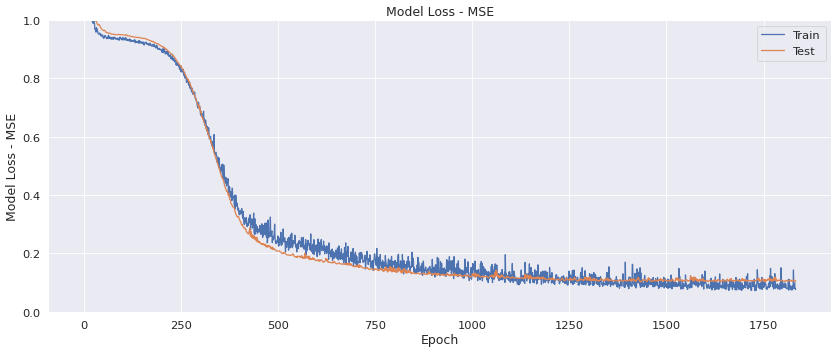

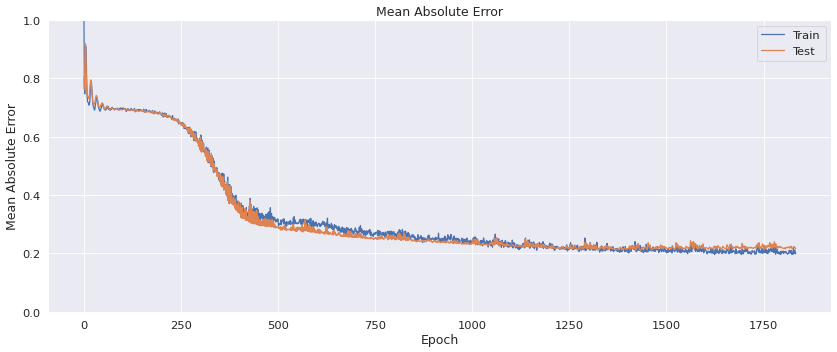

In [154]:
# Plot train vs test loss during training
plot_results(history.history['loss'], history.history['val_loss'], 1, 'Model Loss - MSE')

# Plot train vs test accuracy during training
plot_results(history.history['mae'], history.history['val_mae'], 1, 'Mean Absolute Error')

In [155]:
print('Model Evaluation Loss: {:.3f}'.format(model.evaluate(X_valid, y_valid)[0]))

19/19 [==============================] - 0s 878us/step - loss: 0.1015 - mae: 0.2104 - mse: 0.1015
Model Evaluation Loss: 0.101


Load the weights if no earlystopping

In [156]:
model.load_weights('../model/best_model.hdf5')
model.evaluate(X_valid, y_valid)

19/19 [==============================] - 0s 818us/step - loss: 0.1015 - mae: 0.2104 - mse: 0.1015


[0.10148631781339645, 0.21044816076755524, 0.10148631781339645]

### Preparing Kaggle Submission file

In [157]:
predict_features = np.array(X_test)
y_test = targetScalar.inverse_transform(model.predict(predict_features))

In [158]:
submission.SalePrice = y_test.flatten()
submission.to_csv('../output/submission.csv', index=False) 

---
## Peer Comparison
Checking against data submission found here:
- https://www.kaggle.com/lavanyashukla01/how-i-made-top-0-3-on-a-kaggle-competition/output?select=submission_regression1.csv

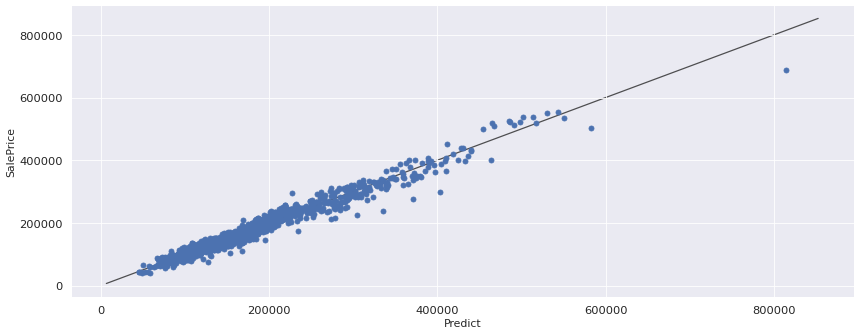

In [159]:
check = pd.read_csv(DATA_FOLDER + 'results.csv')
check['Predict'] = submission.SalePrice
plot_check(check, 'Predict', 'SalePrice')

In [170]:
from sklearn.metrics import mean_squared_error 
realVals = check.SalePrice
predictedVals = check.Predict
rmse = mean_squared_error(realVals, predictedVals, squared = False)

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

print('VALIDATION_ERROR: {}'.format(hist.val_mse.min()))
print('NODES: {}'.format(NODES))
print('LR: {}'.format(LR))
print('ACTIVATION: {}'.format(ACTIVATION))
print('BATCH_SIZE: {}'.format(BATCH_SIZE))
print('INPUT_DROPOUT: {}'.format(INPUT_DROPOUT))
print('EPOCHS: {}'.format(EPOCHS))
print('MAX EPOCHS: {}'.format(hist.epoch.max()))
print('BEST EPOCHS: {}'.format(int(hist.iloc[hist.val_loss.idxmin()].epoch)))
print('EARLY STOPPED: {}'.format(hist.epoch.max() < EPOCHS - 1))
print('PATIENCE: {}'.format(PATIENCE))
print('RMSE: {}'.format(rmse))

VALIDATION_ERROR: 0.10148629546165466
NODES: (8, 16, 32)
LR: 0.0005
ACTIVATION: sigmoid
BATCH_SIZE: 874
INPUT_DROPOUT: 0.05
EPOCHS: 2000
MAX EPOCHS: 1833
BEST EPOCHS: 1433
EARLY STOPPED: True
PATIENCE: 400
RMSE: 15436.425898458156


In [167]:
hist.iloc[hist.val_loss.idxmin()].epoch

1433.0

### Hyperparameter search on peer comparison data

In [141]:
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import mean_squared_error 

check = pd.read_csv(DATA_FOLDER + 'results.csv')

results = []

NODES_LIST = [(8, 16, 32), (16, 32, 64)]
LRs = [0.0005, 0.001, 0.002]
ACTIVATIONs = ['relu','sigmoid']
EPOCHS_LIST = [2000]
INPUTDROPOUT_LIST = [0, 0.05]
PATIENCE = 2000

for NODE in tqdm(NODES_LIST):
    for LR in LRs:
        for ACTIVATION in ACTIVATIONs:
            for EPOCHS in EPOCHS_LIST:
                for INPUT_DROPOUT in INPUTDROPOUT_LIST:
                    result = {}

                    PATIENCE = int(EPOCHS * 0.2)
                    
                    bestmodel_earlystop = EarlyStopping(monitor='val_mse', 
                                                    patience=PATIENCE, 
                                                    restore_best_weights=True)

                    #'model-{epoch:03d}-{loss:03f}-{val_loss:03f}.hdf5'
                    bestmodel_chkpt = ModelCheckpoint('../model/search_best_model.hdf5', 
                                                           monitor='val_loss', 
                                                           save_best_only=True, mode='min')
                    
                    CALLBACKS = [bestmodel_chkpt, bestmodel_earlystop]

                    model = build_model(nodes=NODE, activation=ACTIVATION, 
                                        learning_rate=LR, input_dropout=INPUT_DROPOUT)
                    history = model.fit(X_train, y_train, epochs=EPOCHS, 
                                        validation_data=(X_valid, y_valid), 
                                        batch_size=BATCH_SIZE, verbose=0, 
                                        callbacks=CALLBACKS)

                    hist = pd.DataFrame(history.history)
                    hist['epoch'] = history.epoch

                    result['node'] = NODE
                    result['learningrate'] = LR
                    result['activation'] = ACTIVATION
                    result['batchsize'] = BATCH_SIZE
                    result['inputdropout'] = INPUT_DROPOUT
                    result['epochs'] = EPOCHS
                    result['loss'] = hist.val_mse.min()
                    result['maxepoch'] = hist.epoch.max()
                    result['bestepoch'] = int(hist.iloc[hist.val_mse.idxmin()].epoch)
                    result['earlystopped'] = hist.epoch.max() < EPOCHS - 1

#                     try:
#                         model.load_weights('../model/search_best_model.hdf5')
#                     except:
#                         print('No Saved Model!')
#                         pass

                    y_predict = targetScalar.inverse_transform(model.predict(np.array(X_test))).flatten()
                    result['rmse'] = mean_squared_error(check.SalePrice, y_predict, squared = False)

                    results.append(result)

In [142]:
pd.DataFrame(results).sort_values('rmse')

activation  batchsize  bestepoch  earlystopped  epochs  inputdropout  \
3     sigmoid        874       1671          True    2000          0.05   
1        relu        874       1837          True    2000          0.05   
17       relu        874        574          True    2000          0.05   
20       relu        874        522          True    2000          0.00   
19    sigmoid        874       1776          True    2000          0.05   
16       relu        874        919          True    2000          0.00   
2     sigmoid        874       1033          True    2000          0.00   
7     sigmoid        874        848          True    2000          0.05   
18    sigmoid        874        585          True    2000          0.00   
23    sigmoid        874        620          True    2000          0.05   
8        relu        874        696          True    2000          0.00   
4        relu        874       1025          True    2000          0.00   
22    sigmoid        874        569          True    2000          0.00   
13       relu        874        984          True    2000          0.05   
0        relu        874       1666          True    2000          0.00   
12       relu        874       1076          True    2000          0.00   
10    sigmoid        874        627          True    2000          0.00   
11    sigmoid        874        999          True    2000          0.05   
15    sigmoid        874       1935          True    2000          0.05   
21       relu        874        864          True    2000          0.05   
14    sigmoid        874        955          True    2000          0.00   
9        relu        874       1352          True    2000          0.05   
6     sigmoid        874       1992          True    2000          0.00   
5        relu        874        279          True    2000          0.05   

    learningrate      loss  maxepoch          node          rmse  
3         0.0005  0.100806      1999   (8, 16, 32)  14735.025647  
1         0.0005  0.108663      1999   (8, 16, 32)  15200.439687  
17        0.0010  0.105742       974  (16, 32, 64)  15539.438460  
20        0.0020  0.111664       922  (16, 32, 64)  15738.442257  
19        0.0010  0.109058      1999  (16, 32, 64)  15872.234274  
16        0.0010  0.127487      1319  (16, 32, 64)  15938.075833  
2         0.0005  0.105933      1433   (8, 16, 32)  16426.287065  
7         0.0010  0.108402      1248   (8, 16, 32)  16586.521948  
18        0.0010  0.104872       985  (16, 32, 64)  16711.052976  
23        0.0020  0.110261      1020  (16, 32, 64)  16714.507202  
8         0.0020  0.117288      1096   (8, 16, 32)  16819.254906  
4         0.0010  0.108484      1425   (8, 16, 32)  17045.861146  
22        0.0020  0.111726       969  (16, 32, 64)  17398.734610  
13        0.0005  0.100789      1384  (16, 32, 64)  17610.806569  
0         0.0005  0.115793      1999   (8, 16, 32)  17713.399637  
12        0.0005  0.112295      1476  (16, 32, 64)  17882.689625  
10        0.0020  0.119464      1027   (8, 16, 32)  17902.008333  
11        0.0020  0.116376      1399   (8, 16, 32)  18415.105897  
15        0.0005  0.106009      1999  (16, 32, 64)  19028.949733  
21        0.0020  0.112617      1264  (16, 32, 64)  19100.029427  
14        0.0005  0.105067      1355  (16, 32, 64)  19247.773419  
9         0.0020  0.149991      1752   (8, 16, 32)  23306.157862  
6         0.0010  0.120308      1999   (8, 16, 32)  25712.428218  
5         0.0010  0.948278       679   (8, 16, 32)  75397.712540